In [1]:
import nibabel as nib
import numpy as np
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
import cv
import torch
import cv2
from cv2 import resize
import nrrd
import torchvision.transforms as transforms
from tqdm import tqdm
%matplotlib inline

In [2]:
INPUT_SHAPE = (192, 192, 3)
epochs = 10
batch_size = 32
valratio = 0.15

In [3]:
train_path = 'HACKATHON/images/train/'
test_path = 'HACKATHON/images/test/'
label_path = 'HACKATHON/train.txt'
segmentation_path = 'HACKATHON/segmentations/'

In [4]:
ss = []
with open(label_path, 'r') as f:
    for row in f:
        ss.append(row)

In [5]:
len(os.listdir(train_path))

355

In [6]:
def loadnib(path, root = train_path):
    scan = nib.load(root+ path)
    return np.array(scan.dataobj)

In [7]:
img = loadnib('0657.nii.gz')
img.shape, img[0].shape

((512, 512, 66), (512, 66))

In [8]:
def nibtoimg(path, root = train_path, slc = 25, file = 't.jpg'):
    scan = nib.load(root+ path)
    scan = np.array(scan.dataobj)
    t = np.rot90(scan[:,:,slc], k=3)
    plt.imsave(file, t)

In [9]:
nibtoimg('0013.nii.gz',root = test_path, slc = 72, file = 'curr.jpg')

In [10]:
k = rgb_loader('curr.jpg')
plt.imshow(k)

NameError: name 'rgb_loader' is not defined

In [ ]:
def plot_slice(img, slc):
    plt.imshow(np.rot90(img[:,:,slc], k=3),cmap='gray')

In [ ]:
plot_slice(img, 34)

In [11]:
labels = []
for k in sorted(ss):
    a,b = k.split(',')
    labels.append(int(b))

In [12]:
labels = np.array(labels)
labels = np.expand_dims(labels, axis =0)

In [13]:
def save_img(img, path = 'output.jpeg'):
    plt.imsave(path, img, cmap = 'gray')

In [14]:
from PIL import Image
def rgb_loader(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (352, 352))
    return Image.fromarray(img)


def transform(x):
    operation = transforms.Compose([
                transforms.Resize((352, 352)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406],
                                    [0.229, 0.224, 0.225])
    ])
    return operation(x).unsqueeze(0)

In [15]:
k  = rgb_loader('t.jpg')
plt.imshow(k, cmap = 'gray')

error: OpenCV(4.5.1) /tmp/pip-req-build-ms668fyv/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [16]:
def get_ready(n, slc = 0):
    im = Image.fromarray(n[:,:,slc])
    im = im.convert('RGB')
    return transform(im)

In [ ]:
im = get_ready(k)
plt.imshow(k[:,:,1])

In [ ]:
def gen(path = train_path):
    for filepath in os.listdir(path):
        try:
            scan = nib.load(path+filepath)
            yield np.array(scan.dataobj)
        except StopIteration:
            break;

In [ ]:
g = gen()

In [ ]:
n = next(g)
n = n.astype('float32')


In [ ]:
plt.imshow(np.rot90(n[:,:,23], k = 3))

In [17]:
print("You mothafucka")

You mothafucka


## Semi Inf-Net

In [18]:
!mkdir -p Results/semi

In [19]:
save_path = 'Results/semi'

In [25]:
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo
import torch
import torch.nn.functional as F

__all__ = ['Res2Net', 'res2net50_v1b', 'res2net101_v1b', 'res2net50_v1b_26w_4s']

model_urls = {
    'res2net50_v1b_26w_4s': 'https://shanghuagao.oss-cn-beijing.aliyuncs.com/res2net/res2net50_v1b_26w_4s-3cf99910.pth',
    'res2net101_v1b_26w_4s': 'https://shanghuagao.oss-cn-beijing.aliyuncs.com/res2net/res2net101_v1b_26w_4s-0812c246.pth',
}


class Bottle2neck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, baseWidth=26, scale=4, stype='normal'):
        """ Constructor
        Args:
            inplanes: input channel dimensionality
            planes: output channel dimensionality
            stride: conv stride. Replaces pooling layer.
            downsample: None when stride = 1
            baseWidth: basic width of conv3x3
            scale: number of scale.
            type: 'normal': normal set. 'stage': first block of a new stage.
        """
        super(Bottle2neck, self).__init__()

        width = int(math.floor(planes * (baseWidth / 64.0)))
        self.conv1 = nn.Conv2d(inplanes, width * scale, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(width * scale)

        if scale == 1:
            self.nums = 1
        else:
            self.nums = scale - 1
        if stype == 'stage':
            self.pool = nn.AvgPool2d(kernel_size=3, stride=stride, padding=1)
        convs = []
        bns = []
        for i in range(self.nums):
            convs.append(nn.Conv2d(width, width, kernel_size=3, stride=stride, padding=1, bias=False))
            bns.append(nn.BatchNorm2d(width))
        self.convs = nn.ModuleList(convs)
        self.bns = nn.ModuleList(bns)

        self.conv3 = nn.Conv2d(width * scale, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stype = stype
        self.scale = scale
        self.width = width

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        spx = torch.split(out, self.width, 1)
        for i in range(self.nums):
            if i == 0 or self.stype == 'stage':
                sp = spx[i]
            else:
                sp = sp + spx[i]
            sp = self.convs[i](sp)
            sp = self.relu(self.bns[i](sp))
            if i == 0:
                out = sp
            else:
                out = torch.cat((out, sp), 1)
        if self.scale != 1 and self.stype == 'normal':
            out = torch.cat((out, spx[self.nums]), 1)
        elif self.scale != 1 and self.stype == 'stage':
            out = torch.cat((out, self.pool(spx[self.nums])), 1)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Res2Net(nn.Module):

    def __init__(self, block, layers, baseWidth=26, scale=4, num_classes=1000):
        self.inplanes = 64
        super(Res2Net, self).__init__()
        self.baseWidth = baseWidth
        self.scale = scale
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, 1, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, 1, 1, bias=False)
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.AvgPool2d(kernel_size=stride, stride=stride,
                             ceil_mode=True, count_include_pad=False),
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample=downsample,
                            stype='stage', baseWidth=self.baseWidth, scale=self.scale))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, baseWidth=self.baseWidth, scale=self.scale))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def res2net50_v1b(pretrained=False, **kwargs):
    """Constructs a Res2Net-50_v1b model_lung_infection.
    Res2Net-50 refers to the Res2Net-50_v1b_26w_4s.
    Args:
        pretrained (bool): If True, returns a model_lung_infection pre-trained on ImageNet
    """
    model = Res2Net(Bottle2neck, [3, 4, 6, 3], baseWidth=26, scale=4, **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['res2net50_v1b_26w_4s']),map_location=torch.device('cpu') )
    return model


def res2net101_v1b(pretrained=False, **kwargs):
    """Constructs a Res2Net-50_v1b_26w_4s model_lung_infection.
    Args:
        pretrained (bool): If True, returns a model_lung_infection pre-trained on ImageNet
    """
    model = Res2Net(Bottle2neck, [3, 4, 23, 3], baseWidth=26, scale=4, **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['res2net101_v1b_26w_4s']))
    return model


def res2net50_v1b_26w_4s(pretrained=True, **kwargs):
    """Constructs a Res2Net-50_v1b_26w_4s model_lung_infection.
    Args:
        pretrained (bool): If True, returns a model_lung_infection pre-trained on ImageNet
    """
    model = Res2Net(Bottle2neck, [3, 4, 6, 3], baseWidth=26, scale=4, **kwargs)
    if pretrained:
        # Please replace it with your custom path
        model_state = torch.load('./Snapshots/res2net50_v1b_26w_4s-3cf99910.pth', map_location=torch.device('cpu'))
        model.load_state_dict(model_state)
        # model_lung_infection.load_state_dict(model_zoo.load_url(model_urls['res2net50_v1b_26w_4s']))
    return model


def res2net101_v1b_26w_4s(pretrained=False, **kwargs):
    """Constructs a Res2Net-50_v1b_26w_4s model_lung_infection.
    Args:
        pretrained (bool): If True, returns a model_lung_infection pre-trained on ImageNet
    """
    model = Res2Net(Bottle2neck, [3, 4, 23, 3], baseWidth=26, scale=4, **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['res2net101_v1b_26w_4s']))
    return model


def res2net152_v1b_26w_4s(pretrained=False, **kwargs):
    """Constructs a Res2Net-50_v1b_26w_4s model_lung_infection.
    Args:
        pretrained (bool): If True, returns a model_lung_infection pre-trained on ImageNet
    """
    model = Res2Net(Bottle2neck, [3, 8, 36, 3], baseWidth=26, scale=4, **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['res2net152_v1b_26w_4s']))
    return model

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicConv2d(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_planes, out_planes,
                              kernel_size=kernel_size, stride=stride,
                              padding=padding, dilation=dilation, bias=False)
        self.bn = nn.BatchNorm2d(out_planes)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return x


class RFB_modified(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(RFB_modified, self).__init__()
        self.relu = nn.ReLU(True)
        self.branch0 = nn.Sequential(
            BasicConv2d(in_channel, out_channel, 1),
        )
        self.branch1 = nn.Sequential(
            BasicConv2d(in_channel, out_channel, 1),
            BasicConv2d(out_channel, out_channel, kernel_size=(1, 3), padding=(0, 1)),
            BasicConv2d(out_channel, out_channel, kernel_size=(3, 1), padding=(1, 0)),
            BasicConv2d(out_channel, out_channel, 3, padding=3, dilation=3)
        )
        self.branch2 = nn.Sequential(
            BasicConv2d(in_channel, out_channel, 1),
            BasicConv2d(out_channel, out_channel, kernel_size=(1, 5), padding=(0, 2)),
            BasicConv2d(out_channel, out_channel, kernel_size=(5, 1), padding=(2, 0)),
            BasicConv2d(out_channel, out_channel, 3, padding=5, dilation=5)
        )
        self.branch3 = nn.Sequential(
            BasicConv2d(in_channel, out_channel, 1),
            BasicConv2d(out_channel, out_channel, kernel_size=(1, 7), padding=(0, 3)),
            BasicConv2d(out_channel, out_channel, kernel_size=(7, 1), padding=(3, 0)),
            BasicConv2d(out_channel, out_channel, 3, padding=7, dilation=7)
        )
        self.conv_cat = BasicConv2d(4*out_channel, out_channel, 3, padding=1)
        self.conv_res = BasicConv2d(in_channel, out_channel, 1)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        x_cat = self.conv_cat(torch.cat((x0, x1, x2, x3), 1))

        x = self.relu(x_cat + self.conv_res(x))
        return x


class aggregation(nn.Module):
    # dense aggregation, it can be replaced by other aggregation previous, such as DSS, amulet, and so on.
    # used after MSF
    def __init__(self, channel, n_class):
        super(aggregation, self).__init__()
        self.relu = nn.ReLU(True)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv_upsample1 = BasicConv2d(channel, channel, 3, padding=1)
        self.conv_upsample2 = BasicConv2d(channel, channel, 3, padding=1)
        self.conv_upsample3 = BasicConv2d(channel, channel, 3, padding=1)
        self.conv_upsample4 = BasicConv2d(channel, channel, 3, padding=1)
        self.conv_upsample5 = BasicConv2d(2*channel, 2*channel, 3, padding=1)

        self.conv_concat2 = BasicConv2d(2*channel, 2*channel, 3, padding=1)
        self.conv_concat3 = BasicConv2d(3*channel, 3*channel, 3, padding=1)
        self.conv4 = BasicConv2d(3*channel, 3*channel, 3, padding=1)
        self.conv5 = nn.Conv2d(3*channel, n_class, 1)

    def forward(self, x1, x2, x3):
        x1_1 = x1
        x2_1 = self.conv_upsample1(self.upsample(x1)) * x2
        x3_1 = self.conv_upsample2(self.upsample(self.upsample(x1))) \
               * self.conv_upsample3(self.upsample(x2)) * x3

        x2_2 = torch.cat((x2_1, self.conv_upsample4(self.upsample(x1_1))), 1)
        x2_2 = self.conv_concat2(x2_2)

        x3_2 = torch.cat((x3_1, self.conv_upsample5(self.upsample(x2_2))), 1)
        x3_2 = self.conv_concat3(x3_2)

        x = self.conv4(x3_2)
        x = self.conv5(x)

        return x


class Inf_Net(nn.Module):
    def __init__(self, channel=32, n_class=1):
        super(Inf_Net, self).__init__()
        # ---- ResNet Backbone ----
        self.resnet = res2net50_v1b_26w_4s(pretrained=True)
        # ---- Receptive Field Block like module ----
        self.rfb2_1 = RFB_modified(512, channel)
        self.rfb3_1 = RFB_modified(1024, channel)
        self.rfb4_1 = RFB_modified(2048, channel)

        # ---- Partial Decoder ----
        self.ParDec = aggregation(channel, n_class)

        # ---- reverse attention branch 4 ----
        self.ra4_conv1 = BasicConv2d(2048, 256, kernel_size=1)
        self.ra4_conv2 = BasicConv2d(256+64, 256, kernel_size=5, padding=2)
        self.ra4_conv3 = BasicConv2d(256, 256, kernel_size=5, padding=2)
        self.ra4_conv4 = BasicConv2d(256, 256, kernel_size=5, padding=2)
        self.ra4_conv5 = BasicConv2d(256, n_class, kernel_size=1)
        # ---- reverse attention branch 3 ----
        self.ra3_conv1 = BasicConv2d(1024, 64, kernel_size=1)
        self.ra3_conv2 = BasicConv2d(64+64, 64, kernel_size=3, padding=1)
        self.ra3_conv3 = BasicConv2d(64, 64, kernel_size=3, padding=1)
        self.ra3_conv4 = BasicConv2d(64, n_class, kernel_size=3, padding=1)
        # ---- reverse attention branch 2 ----
        self.ra2_conv1 = BasicConv2d(512, 64, kernel_size=1)
        self.ra2_conv2 = BasicConv2d(64+64, 64, kernel_size=3, padding=1)
        self.ra2_conv3 = BasicConv2d(64, 64, kernel_size=3, padding=1)
        self.ra2_conv4 = BasicConv2d(64, n_class, kernel_size=3, padding=1)

        # ---- edge branch ----
        self.edge_conv1 = BasicConv2d(256, 64, kernel_size=1)
        self.edge_conv2 = BasicConv2d(64, 64, kernel_size=3, padding=1)
        self.edge_conv3 = BasicConv2d(64, 64, kernel_size=3, padding=1)
        self.edge_conv4 = BasicConv2d(64, n_class, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)

        # ---- low-level features ----
        x = self.resnet.maxpool(x)      # bs, 64, 88, 88
        x1 = self.resnet.layer1(x)      # bs, 256, 88, 88

        # ---- high-level features ----
        x2 = self.resnet.layer2(x1)     # bs, 512, 44, 44
        x3 = self.resnet.layer3(x2)     # bs, 1024, 22, 22
        x4 = self.resnet.layer4(x3)     # bs, 2048, 11, 11
        x2_rfb = self.rfb2_1(x2)        # channel -> 32
        x3_rfb = self.rfb3_1(x3)        # channel -> 32
        x4_rfb = self.rfb4_1(x4)        # channel -> 32

        # ---- edge guidance ----
        x = self.edge_conv1(x1)
        x = self.edge_conv2(x)
        edge_guidance = self.edge_conv3(x)  # torch.Size([1, 64, 88, 88])
        lateral_edge = self.edge_conv4(edge_guidance)   # NOTES: Sup-2 (bs, 1, 88, 88) -> (bs, 1, 352, 352)
        lateral_edge = F.interpolate(lateral_edge,
                                     scale_factor=4,
                                     mode='bilinear')

        # ---- global guidance ----
        ra5_feat = self.ParDec(x4_rfb, x3_rfb, x2_rfb)
        lateral_map_5 = F.interpolate(ra5_feat,
                                      scale_factor=8,
                                      mode='bilinear')    # NOTES: Sup-1 (bs, 1, 44, 44) -> (bs, 1, 352, 352)

        # ---- reverse attention branch_4 ----
        crop_4 = F.interpolate(ra5_feat, scale_factor=0.25, mode='bilinear')
        x = -1*(torch.sigmoid(crop_4)) + 1  # reverse
        x = x.expand(-1, 2048, -1, -1).mul(x4)
        x = torch.cat((self.ra4_conv1(x), F.interpolate(edge_guidance, scale_factor=1/8, mode='bilinear')), dim=1)
        x = F.relu(self.ra4_conv2(x))
        x = F.relu(self.ra4_conv3(x))
        x = F.relu(self.ra4_conv4(x))
        ra4_feat = self.ra4_conv5(x)
        x = ra4_feat + crop_4   # element-wise addition
        lateral_map_4 = F.interpolate(x,
                                      scale_factor=32,
                                      mode='bilinear')  # NOTES: Sup-2 (bs, 1, 11, 11) -> (bs, 1, 352, 352)

        # ---- reverse attention branch_3 ----
        crop_3 = F.interpolate(x, scale_factor=2, mode='bilinear')
        x = -1*(torch.sigmoid(crop_3)) + 1
        x = x.expand(-1, 1024, -1, -1).mul(x3)
        x = torch.cat((self.ra3_conv1(x), F.interpolate(edge_guidance, scale_factor=1/4, mode='bilinear')), dim=1)
        x = F.relu(self.ra3_conv2(x))
        x = F.relu(self.ra3_conv3(x))
        ra3_feat = self.ra3_conv4(x)
        x = ra3_feat + crop_3
        lateral_map_3 = F.interpolate(x,
                                      scale_factor=16,
                                      mode='bilinear')  # NOTES: Sup-3 (bs, 1, 22, 22) -> (bs, 1, 352, 352)

        # ---- reverse attention branch_2 ----
        crop_2 = F.interpolate(x, scale_factor=2, mode='bilinear')

        x = -1*(torch.sigmoid(crop_2)) + 1
        x = x.expand(-1, 512, -1, -1).mul(x2)
        x = torch.cat((self.ra2_conv1(x), F.interpolate(edge_guidance, scale_factor=1/2, mode='bilinear')), dim=1)
        x = F.relu(self.ra2_conv2(x))
        x = F.relu(self.ra2_conv3(x))
        ra2_feat = self.ra2_conv4(x)
        x = ra2_feat + crop_2
        lateral_map_2 = F.interpolate(x,
                                      scale_factor=8,
                                      mode='bilinear')   # NOTES: Sup-4 (bs, 1, 44, 44) -> (bs, 1, 352, 352)

        return lateral_map_5, lateral_map_4, lateral_map_3, lateral_map_2, lateral_edge


In [33]:
seminet_pth ='Snapshots/Semi-Inf-Net-100.pth'
save_test = 'Results/Lung-infection-segmentation/Semi-Inf-Net/'
save_train = 'Results/Lung-infection-segmentation/train/'

In [34]:
semi = Inf_Net()
device = torch.device('cpu')
semi.load_state_dict(torch.load(seminet_pth, map_location=device))

<All keys matched successfully>

In [35]:
semi.eval()

Inf_Net(
  (resnet): Res2Net(
    (conv1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottle2neck(
        (conv1): Conv2d(64, 104, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(104, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [36]:
def predict_semi(k):
    lateral_map_5, lateral_map_4, lateral_map_3, lateral_map_2, lateral_edge = semi(k)
    res = lateral_map_2
    res = res.sigmoid().data.cpu().numpy().squeeze()
    res = (res - res.min()) / (res.max() - res.min() + 1e-8)
    #plt.imsave(save_path + '0.jpeg' ,res, cmap = 'gray')
    #plt.imshow(res, cmap='gray')
    return res

In [37]:
n = next(g)
plot_slice(n, slc = 34)

NameError: name 'g' is not defined

In [38]:
k = get_ready(n)
x = predict_semi(k)

NameError: name 'n' is not defined

In [ ]:
plt.imshow(np.rot90(x), cmap = 'gray')

In [39]:
def percent_lungs_slice(filepath_mask, slice_number):
    M, _ = nrrd.read(filepath_mask)
    current_slice, _ = bound_box_and_reshape(M, slice_number)
    num_pixels = current_slice.shape[2] * current_slice.shape[1]
    white = np.sum(current_slice)
    return "{:.1f}".format(white / num_pixels)

In [40]:
def bound_box_and_reshape(img, slice_idx):
    """
    Crop given slice of image to lung size (remove redundant empty space) and reshape to 512x512 pxls. Return edited img_slice.
    """
    img_slice = img[:,:,slice_idx]    
    rows = np.any(img_slice, axis=1)
    cols = np.any(img_slice, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    img_slice = resize(img_slice[rmin:rmax, cmin:cmax], (512,512))
    img_slice = np.transpose(img_slice[:, :, np.newaxis], axes = [2, 0, 1]).astype('float32')
    lung_pixels = abs((rmax-rmin) * (cmax - cmin))
    
    return img_slice, lung_pixels

In [41]:
def mask_original(filepath_CT, filepath_mask):
    """
    Mask and normalize original CT. Select only preset number of central slices. 
    """
    I = np.array(nib.load(filepath_CT).dataobj)
    #I = normalize(I, -1350, 150)
    M, _ = nrrd.read(filepath_mask)
    
    nS = np.where(M==1, I, M)
    
    #z = nS.shape[2]//2
    #dz = nb_central_slices//2
    #nS = nS[:,:,z-dz:z+dz]
        
    return nS

In [42]:
filename_img = '0013.nii.gz'
i = 64

In [43]:
filename_mask = filename_img.replace(".nii.gz", ".nrrd")
filepath_img = os.path.join(test_path, filename_img)
filepath_mask = os.path.join(segmentation_path+"test/", filename_mask)
patient_number = filename_mask.split(".nrrd")[0]
img = mask_original(filepath_img, filepath_mask)


In [44]:
#plt.imshow(img[:,:,45])

In [45]:
current_slice, bbox_pixels = bound_box_and_reshape(img, i)
current_slice = np.rot90(np.squeeze(current_slice))
percentage = percent_lungs_slice(filepath_mask, i)

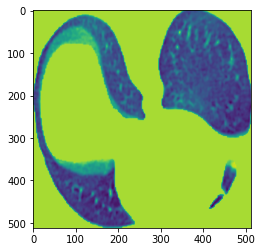

In [46]:
plt.imshow(current_slice)

In [47]:
plt.imsave('cur.jpg', current_slice)

In [48]:
t = transform(rgb_loader('cur.jpg'))

In [49]:
r = predict_semi(t)

/home/pc/.local/lib/python3.8/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/home/pc/.local/lib/python3.8/site-packages/torch/nn/functional.py:3502: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(


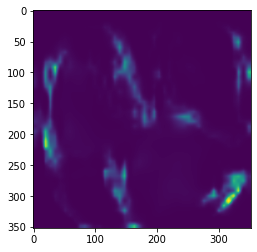

In [50]:
plt.imshow(r)
plt.imsave('semi.jpg', r)

In [51]:
x = Image.fromarray(current_slice).convert('RGB')
x = transform(x)

In [52]:
y = predict_semi(x)
y.shape

(352, 352)

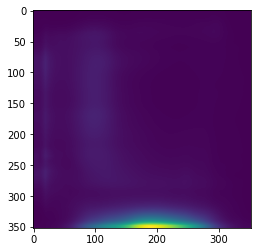

In [53]:
plt.imshow(y)

In [54]:
e = transform(rgb_loader('semi.jpg'))

In [55]:
e.shape

torch.Size([1, 3, 352, 352])

In [56]:
def store_results(path = test_path):
    for k in tqdm(os.listdir(path)):
        save_pseudo(k, opt = save_train)

In [57]:
#store_results(path = train_path)

In [58]:
saving_path = 'Results/wash/'

In [59]:
def calculate_mask_area_percentage(mask, NP_VALUE_OF_MASK):
    """
        Input je numpy array. Vrže ven odstotek, kolikšen
        del slike zajema anomalija.
    """
    mask = np.where(mask == NP_VALUE_OF_MASK, 1, 0)
    summa = np.sum(mask)
    percentage = float(summa) / (mask.shape[0]*mask.shape[1])
    return round(percentage,3)

In [60]:
def save_slice(slice_image, slice_name):
    plt.imsave(os.path.join(saving_path, slice_name + ".jpg"), np.rot90(np.squeeze(slice_image), k=3),cmap='gray')

# Semi Unet

In [61]:
path = 'Snapshots/unet_model_200.pkl'

In [62]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [63]:
class Inf_Net_UNet(nn.Module):
    """ Full assembly of the parts to form the complete network """
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(Inf_Net_UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)

        return logits

In [64]:
infnet = Inf_Net_UNet(6,3)
device = torch.device('cpu')
infnet.load_state_dict(torch.load(path, map_location=device))

<All keys matched successfully>

In [65]:
infnet.eval()

Inf_Net_UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05

In [66]:
#plt.imsave('pseudo.jpeg', k.detach().numpy())

In [67]:
def predict_unet(k,d):
    s = torch.cat((k,d), dim=1)
    res = infnet(s)
    res = torch.sigmoid(res) 
    b, _, w, h = res.size()
    # output b*n_class*h*w -- > b*h*w
    pred = res.cpu().permute(0, 2, 3, 1).contiguous().view(-1, 3).max(1)[1].view(b, w, h).numpy().squeeze()
    return pred

In [68]:
def split_class_imgs(pred):
    im_array_red = np.array(pred)  # 0, 38
    im_array_green = np.array(pred)  # 0, 75
    print(np.unique(im_array_red)) # mask value is max of this

    im_array_red[im_array_red != 0] = 1
    im_array_red[im_array_red == 0] = 255
    im_array_red[im_array_red == 1] = 0

    im_array_green[im_array_green != 1] = 0
    im_array_green[im_array_green == 1] = 255
    
   # red = Image.fromarray(im_array_red).convert('1').resize(size=(512, 512))
    #green = Image.fromarray(im_array_red).convert('1').resize(size=(512, 512))

    return im_array_green, im_array_red

In [69]:
LABEL_PATH = 'HACKATHON/train.txt'

In [70]:
def get_label(patient_number):
    with open(LABEL_PATH) as file:
        for line in file.readlines():
            if str(patient_number) in line:
                label = line.split(",")[1].rsplit("\n")[0]
                return label

In [71]:
##  končna segmentacija(summa)

In [72]:
def process_one_patient(filename_img, path = train_path, seg_path = segmentation_path):
    filename_mask = filename_img.replace(".nii.gz", ".nrrd")
    filepath_img = os.path.join(path, filename_img)
    filepath_mask = os.path.join(seg_path, filename_mask)
    patient_number = filename_mask.split(".nrrd")[0]
    img = mask_original(filepath_img, filepath_mask)
    num_slices = img.shape[2]
    
    label = get_label(patient_number)
    
    patient_lung_volume_score = 0.0
    patient_ggo_score = 0.0
    patient_consolidation_score = 0.0
        
    for i in tqdm(range(num_slices)):
        try:
            current_slice, bbox_pixels = bound_box_and_reshape(img, i)
        except:
            continue
    
        current_slice = np.rot90(np.squeeze(current_slice))
        percentage = percent_lungs_slice(filepath_mask, i)
        if percentage != 0:
            plt.imsave('cur.png', current_slice)
            t = transform(rgb_loader('cur.png'))
            r = predict_semi(t)
            plt.imsave('semi.png', r)
            e = transform(rgb_loader('semi.png'))
            pred = predict_unet(t,e)
            ggo_mask, consolidation_mask = split_class_imgs(pred)
            
            NP_VALUE_OF_MASK = 255
            patient_lung_volume_score += float(percentage) * bbox_pixels
            
            ggo_percentage = calculate_mask_area_percentage(ggo_mask, NP_VALUE_OF_MASK)
            consolidation_percentage = calculate_mask_area_percentage(consolidation_mask, NP_VALUE_OF_MASK)
            
            patient_ggo_score += ggo_percentage * bbox_pixels
            patient_consolidation_score += consolidation_percentage * bbox_pixels
            
            plt.show()
    
    return {"filename_img" : filename_img,
            "label" : label,
            "lung_vol": patient_lung_volume_score, 
            "ggo_vol" : patient_ggo_score, 
            "cons_vol" : patient_consolidation_score}

In [77]:
f = os.listdir(train_path)[:30]
training_csv = 'proba.csv'

In [78]:
def process_all_patients(path = bet_path, seg_path = seg_p):
    training_set = []
    for _,_,filenames in os.walk(path):
        for filename in tqdm(filenames):
            if filename.endswith(".nii.gz"):
                patient_dict = process_one_patient(filename, path = path, seg_path = seg_path)
                with open(training_csv, mode='a') as file_:
                    file_.write(str(patient_dict.values()))
                    file_.write("\n")
                training_set.append(patient_dict)
    return training_set

In [ ]:
## isto naredi tudi z slikami za unet, 

In [ ]:
print("Eh")

In [ ]:
vis_path = 'visual/'
def initdir(filename):
    path = vis_path + filename.replace(".nii.gz", "/")
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path)
    return path

In [ ]:
def save_images_one(filename_img, train = True):
    k_path = initdir(filename_img)
    filename_mask = filename_img.replace(".nii.gz", ".nrrd")
    if train:
        filepath_img = os.path.join(train_path, filename_img)
        seg = segmentation_path +"train/"
    else: 
        filepath_img = os.path.join(test_path, filename_img)
        seg = segmentation_path +  "test/"
    filepath_mask = os.path.join(seg, filename_mask)
    patient_number = filename_mask.split(".nrrd")[0]
    
    img = mask_original(filepath_img, filepath_mask)
    num_slices = img.shape[2]
    
    
    
    for i in tqdm(range(num_slices)):
        store_path = k_path + str(i)+"-"
        try:
            current_slice, bbox_pixels = bound_box_and_reshape(img, i)
        except:
            continue
        current_slice = np.rot90(np.squeeze(current_slice))
        percentage = percent_lungs_slice(filepath_mask, i)
        if percentage != 0:
            # lahko v eni rundi kličem in semi in unet
            plt.imsave(store_path+"cur"+".png", current_slice, cmap = 'gray')
            current_slice = rgb_loader(store_path+"cur"+".png")
            seg = transform(current_slice)
            semi_mask = predict_net(seg)
            plt.imsave(store_path+"semi"+".png", semi_mask, cmap = 'gray')
            unet_mask = predict_unet(transform(rgb_loader(store_path+"semi"+".png")), seg)
            plt.imsave(store_path+"unet"+".png", unet_mask, cmap = 'gray')
            

            ggo_mask, consolidation_mask = split_class_imgs(unet_mask)
            plt.imsave(store_path+"ggo"+".png", ggo_mask, cmap = 'gray')
            plt.imsave(store_path+"conso"+".png", consolidation_mask, cmap = 'gray')

In [73]:
bet_path = '/media/pc/Elements/final/HACKATHON_finalround/images/train'
seg_p = '/media/pc/Elements/final/HACKATHON_finalround/segmentations/train'

In [ ]:
f = os.listdir(bet_path)[0]
x = process_one_patient(f, bet_path, seg_p)

In [79]:
y = process_all_patients(path = bet_path, seg_path = seg_p)

 16%|█▌        | 10/63 [00:03<00:18,  2.86it/s]

[0 2]



 17%|█▋        | 11/63 [00:11<01:04,  1.25s/it]

[0 1 2]



 19%|█▉        | 12/63 [00:15<01:27,  1.72s/it]

[0 1 2]



 21%|██        | 13/63 [00:18<01:38,  1.98s/it]

[0 1 2]



 22%|██▏       | 14/63 [00:20<01:37,  1.99s/it]

[0 1 2]



 24%|██▍       | 15/63 [00:22<01:30,  1.89s/it]

[0 1 2]



 25%|██▌       | 16/63 [00:23<01:24,  1.80s/it]

[0 1 2]



 27%|██▋       | 17/63 [00:25<01:25,  1.86s/it]

[0 2]



 29%|██▊       | 18/63 [00:27<01:22,  1.83s/it]

[0 1 2]



 30%|███       | 19/63 [00:29<01:19,  1.81s/it]

[0 1 2]



 32%|███▏      | 20/63 [00:30<01:13,  1.72s/it]

[0 1 2]



 33%|███▎      | 21/63 [00:32<01:09,  1.66s/it]

[0 1 2]



 35%|███▍      | 22/63 [00:33<01:06,  1.62s/it]

[0 1 2]



 37%|███▋      | 23/63 [00:35<01:03,  1.58s/it]

[0 1 2]



 38%|███▊      | 24/63 [00:37<01:06,  1.69s/it]

[0 1 2]



 40%|███▉      | 25/63 [00:38<01:05,  1.73s/it]

[0 1 2]



 41%|████▏     | 26/63 [00:41<01:16,  2.08s/it]

[0 1 2]



 43%|████▎     | 27/63 [00:43<01:12,  2.00s/it]

[0 1 2]



 44%|████▍     | 28/63 [00:45<01:06,  1.89s/it]

[0 1 2]



 46%|████▌     | 29/63 [00:47<01:02,  1.83s/it]

[0 1 2]



 48%|████▊     | 30/63 [00:48<00:57,  1.74s/it]

[0 1 2]



 49%|████▉     | 31/63 [00:50<00:55,  1.72s/it]

[0 1 2]



 51%|█████     | 32/63 [00:51<00:51,  1.66s/it]

[0 1 2]



 52%|█████▏    | 33/63 [00:53<00:48,  1.61s/it]

[0 1 2]



 54%|█████▍    | 34/63 [00:54<00:46,  1.60s/it]

[0 1 2]



 56%|█████▌    | 35/63 [00:56<00:44,  1.58s/it]

[0 2]



 57%|█████▋    | 36/63 [00:59<00:51,  1.92s/it]

[0 1 2]



 59%|█████▊    | 37/63 [01:02<01:04,  2.47s/it]

[0 1 2]



 60%|██████    | 38/63 [01:04<00:57,  2.31s/it]

[0 1 2]



 62%|██████▏   | 39/63 [01:07<00:56,  2.36s/it]

[0 1 2]



 63%|██████▎   | 40/63 [01:14<01:31,  3.96s/it]

[0 1 2]



 65%|██████▌   | 41/63 [01:18<01:23,  3.78s/it]

[0 1 2]



 67%|██████▋   | 42/63 [01:19<01:06,  3.15s/it]

[0 1 2]



 68%|██████▊   | 43/63 [01:21<00:53,  2.67s/it]

[0 1 2]



 70%|██████▉   | 44/63 [01:23<00:44,  2.34s/it]

[0 1 2]



 71%|███████▏  | 45/63 [01:24<00:37,  2.10s/it]

[0 1 2]



 73%|███████▎  | 46/63 [01:26<00:32,  1.94s/it]

[0 1 2]



 75%|███████▍  | 47/63 [01:27<00:28,  1.81s/it]

[0 2]



 76%|███████▌  | 48/63 [01:29<00:26,  1.74s/it]

[0 2]



 78%|███████▊  | 49/63 [01:30<00:24,  1.73s/it]

[0 1 2]



 79%|███████▉  | 50/63 [01:32<00:21,  1.67s/it]

[0 1 2]



 81%|████████  | 51/63 [01:34<00:20,  1.75s/it]

[0 1 2]



 83%|████████▎ | 52/63 [01:36<00:19,  1.76s/it]

[0 1 2]



 84%|████████▍ | 53/63 [01:39<00:20,  2.08s/it]

[0 1 2]



 86%|████████▌ | 54/63 [01:41<00:18,  2.08s/it]

[0 1 2]



 87%|████████▋ | 55/63 [01:43<00:16,  2.05s/it]

[0 1 2]



 89%|████████▉ | 56/63 [01:44<00:13,  1.92s/it]

[0 1 2]



 90%|█████████ | 57/63 [01:46<00:11,  1.94s/it]

[0 1 2]



 92%|█████████▏| 58/63 [01:48<00:09,  1.94s/it]

[0 1 2]



 94%|█████████▎| 59/63 [01:50<00:07,  1.82s/it]

[0 1 2]



  1%|▏         | 1/80 [01:52<2:28:37, 112.88s/it]

[0 1 2]



 11%|█         | 6/56 [00:02<00:20,  2.46it/s]

[0 1 2]



 12%|█▎        | 7/56 [00:03<00:30,  1.60it/s]

[0 2]



 14%|█▍        | 8/56 [00:05<00:41,  1.15it/s]

[0 2]



 16%|█▌        | 9/56 [00:07<00:49,  1.04s/it]

[0 1 2]



 18%|█▊        | 10/56 [00:09<01:01,  1.35s/it]

[0 1 2]



 20%|█▉        | 11/56 [00:11<01:05,  1.45s/it]

[0 1 2]



 21%|██▏       | 12/56 [00:12<01:04,  1.46s/it]

[0 1 2]



 23%|██▎       | 13/56 [00:15<01:14,  1.74s/it]

[0 1 2]



 25%|██▌       | 14/56 [00:17<01:14,  1.77s/it]

[0 1 2]



 27%|██▋       | 15/56 [00:18<01:09,  1.70s/it]

[0 1 2]



 29%|██▊       | 16/56 [00:20<01:05,  1.64s/it]

[0 1 2]



 30%|███       | 17/56 [00:21<01:03,  1.62s/it]

[0 1 2]



 32%|███▏      | 18/56 [00:23<01:00,  1.60s/it]

[0 1 2]



 34%|███▍      | 19/56 [00:24<00:58,  1.59s/it]

[0 2]



 36%|███▌      | 20/56 [00:26<00:57,  1.60s/it]

[0 1 2]



 38%|███▊      | 21/56 [00:28<00:55,  1.58s/it]

[0 1 2]



 39%|███▉      | 22/56 [00:29<00:54,  1.60s/it]

[0 1 2]



 41%|████      | 23/56 [00:31<00:58,  1.76s/it]

[0 1 2]



 43%|████▎     | 24/56 [00:33<00:55,  1.73s/it]

[0 1 2]



 45%|████▍     | 25/56 [00:34<00:51,  1.67s/it]

[0 1 2]



 46%|████▋     | 26/56 [00:36<00:50,  1.68s/it]

[0 1 2]



 48%|████▊     | 27/56 [00:38<00:47,  1.64s/it]

[0 1 2]



 50%|█████     | 28/56 [00:39<00:45,  1.62s/it]

[0 1 2]



 52%|█████▏    | 29/56 [00:41<00:45,  1.70s/it]

[0 1 2]



 54%|█████▎    | 30/56 [00:43<00:43,  1.66s/it]

[0 1 2]



 55%|█████▌    | 31/56 [00:44<00:40,  1.62s/it]

[0 1 2]



 57%|█████▋    | 32/56 [00:46<00:39,  1.64s/it]

[0 1 2]



 59%|█████▉    | 33/56 [00:48<00:38,  1.67s/it]

[0 1 2]



 61%|██████    | 34/56 [00:50<00:37,  1.72s/it]

[0 1 2]



 62%|██████▎   | 35/56 [00:54<00:50,  2.43s/it]

[0 1 2]



 64%|██████▍   | 36/56 [00:57<00:51,  2.57s/it]

[0 1 2]



 66%|██████▌   | 37/56 [01:00<00:52,  2.78s/it]

[0 1 2]



 68%|██████▊   | 38/56 [01:01<00:43,  2.43s/it]

[0 1 2]



 70%|██████▉   | 39/56 [01:03<00:37,  2.20s/it]

[0 1 2]



 71%|███████▏  | 40/56 [01:05<00:31,  1.99s/it]

[0 1 2]



 73%|███████▎  | 41/56 [01:06<00:27,  1.86s/it]

[0 1 2]



 75%|███████▌  | 42/56 [01:08<00:26,  1.88s/it]

[0 1 2]



 77%|███████▋  | 43/56 [01:10<00:23,  1.79s/it]

[0 1 2]



 79%|███████▊  | 44/56 [01:11<00:20,  1.72s/it]

[0 1 2]



 80%|████████  | 45/56 [01:13<00:18,  1.65s/it]

[0 1 2]



 82%|████████▏ | 46/56 [01:14<00:16,  1.64s/it]

[0 1 2]



 84%|████████▍ | 47/56 [01:16<00:14,  1.64s/it]

[0 1 2]



 86%|████████▌ | 48/56 [01:18<00:13,  1.71s/it]

[0 1 2]



  2%|▎         | 2/80 [03:16<2:04:43, 95.94s/it] 

[0 1 2]



 12%|█▏        | 7/60 [00:01<00:13,  3.99it/s]

[0 2]



 13%|█▎        | 8/60 [00:03<00:24,  2.15it/s]

[0 1 2]



 15%|█▌        | 9/60 [00:05<00:38,  1.32it/s]

[0 1 2]



 17%|█▋        | 10/60 [00:07<00:50,  1.01s/it]

[0 1 2]



 18%|█▊        | 11/60 [00:08<00:56,  1.15s/it]

[0 1 2]



 20%|██        | 12/60 [00:10<01:01,  1.28s/it]

[0 1 2]



 22%|██▏       | 13/60 [00:12<01:04,  1.38s/it]

[0 1 2]



 23%|██▎       | 14/60 [00:13<01:07,  1.46s/it]

[0 2]



 25%|██▌       | 15/60 [00:15<01:08,  1.51s/it]

[0 1 2]



 27%|██▋       | 16/60 [00:17<01:10,  1.60s/it]

[0 1 2]



 28%|██▊       | 17/60 [00:19<01:13,  1.71s/it]

[0 1 2]



 30%|███       | 18/60 [00:20<01:10,  1.69s/it]

[0 1 2]



 32%|███▏      | 19/60 [00:22<01:07,  1.64s/it]

[0 1 2]



 33%|███▎      | 20/60 [00:23<01:05,  1.63s/it]

[0 1 2]



 35%|███▌      | 21/60 [00:25<01:03,  1.64s/it]

[0 1 2]



 37%|███▋      | 22/60 [00:27<01:01,  1.63s/it]

[0 1 2]



 38%|███▊      | 23/60 [00:30<01:18,  2.11s/it]

[0 1 2]



 40%|████      | 24/60 [00:32<01:12,  2.01s/it]

[0 1 2]



 42%|████▏     | 25/60 [00:34<01:14,  2.13s/it]

[0 1 2]



 43%|████▎     | 26/60 [00:36<01:08,  2.02s/it]

[0 1 2]



 45%|████▌     | 27/60 [00:38<01:09,  2.10s/it]

[0 1 2]



 47%|████▋     | 28/60 [00:40<01:02,  1.95s/it]

[0 1 2]



 48%|████▊     | 29/60 [00:41<00:57,  1.86s/it]

[0 1 2]



 50%|█████     | 30/60 [00:43<00:56,  1.88s/it]

[0 1 2]



 52%|█████▏    | 31/60 [00:45<00:53,  1.84s/it]

[0 1 2]



 53%|█████▎    | 32/60 [00:47<00:50,  1.79s/it]

[0 1 2]



 55%|█████▌    | 33/60 [00:49<00:48,  1.79s/it]

[0 1 2]



 57%|█████▋    | 34/60 [00:50<00:45,  1.73s/it]

[0 1 2]



 58%|█████▊    | 35/60 [00:52<00:42,  1.72s/it]

[0 1 2]



 60%|██████    | 36/60 [00:55<00:51,  2.16s/it]

[0 1 2]



 62%|██████▏   | 37/60 [00:57<00:45,  1.99s/it]

[0 1 2]



 63%|██████▎   | 38/60 [00:58<00:41,  1.87s/it]

[0 1 2]



 65%|██████▌   | 39/60 [01:00<00:38,  1.83s/it]

[0 2]



 67%|██████▋   | 40/60 [01:02<00:35,  1.77s/it]

[0 1 2]



 68%|██████▊   | 41/60 [01:03<00:32,  1.72s/it]

[0 1 2]



 70%|███████   | 42/60 [01:05<00:30,  1.67s/it]

[0 1 2]



 72%|███████▏  | 43/60 [01:06<00:28,  1.66s/it]

[0 1 2]



 73%|███████▎  | 44/60 [01:08<00:27,  1.70s/it]

[0 1 2]



 75%|███████▌  | 45/60 [01:10<00:27,  1.83s/it]

[0 1 2]



 77%|███████▋  | 46/60 [01:13<00:28,  2.03s/it]

[0 1 2]



 78%|███████▊  | 47/60 [01:15<00:25,  1.98s/it]

[0 1 2]



 80%|████████  | 48/60 [01:16<00:22,  1.87s/it]

[0 1 2]



 82%|████████▏ | 49/60 [01:18<00:20,  1.84s/it]

[0 1 2]



 83%|████████▎ | 50/60 [01:20<00:18,  1.90s/it]

[0 1 2]



 85%|████████▌ | 51/60 [01:22<00:17,  1.92s/it]

[0 1 2]



 87%|████████▋ | 52/60 [01:24<00:14,  1.82s/it]

[0 1 2]



 88%|████████▊ | 53/60 [01:25<00:12,  1.76s/it]

[0 1 2]



  4%|▍         | 3/80 [04:44<1:58:23, 92.25s/it]

[0 2]



 11%|█         | 32/291 [00:02<00:17, 14.44it/s]

[0 2]
[0 2]



 12%|█▏        | 34/291 [00:05<00:53,  4.83it/s]

[0 2]



 12%|█▏        | 35/291 [00:07<01:14,  3.42it/s]

[0 1 2]



 12%|█▏        | 36/291 [00:09<01:43,  2.47it/s]

[0 1 2]



 13%|█▎        | 37/291 [00:11<02:19,  1.83it/s]

[0 1 2]



 13%|█▎        | 38/291 [00:13<03:02,  1.39it/s]

[0 1 2]



 13%|█▎        | 39/291 [00:14<03:37,  1.16it/s]

[0 1 2]



 14%|█▎        | 40/291 [00:16<04:09,  1.00it/s]

[0 2]



 14%|█▍        | 41/291 [00:18<04:42,  1.13s/it]

[0 2]



 14%|█▍        | 42/291 [00:19<05:13,  1.26s/it]

[0 1 2]



 15%|█▍        | 43/291 [00:22<06:06,  1.48s/it]

[0 1 2]



 15%|█▌        | 44/291 [00:23<06:19,  1.53s/it]

[0 1 2]



 15%|█▌        | 45/291 [00:25<06:32,  1.60s/it]

[0 1 2]



 16%|█▌        | 46/291 [00:27<06:45,  1.65s/it]

[0 2]



 16%|█▌        | 47/291 [00:30<08:11,  2.02s/it]

[0 1 2]



 16%|█▋        | 48/291 [00:32<08:29,  2.10s/it]

[0 2]



 17%|█▋        | 49/291 [00:34<08:22,  2.07s/it]

[0 2]



 17%|█▋        | 50/291 [00:36<07:52,  1.96s/it]

[0 1 2]



 18%|█▊        | 51/291 [00:38<07:35,  1.90s/it]

[0 1 2]



 18%|█▊        | 52/291 [00:39<07:24,  1.86s/it]

[0 2]



 18%|█▊        | 53/291 [00:41<07:16,  1.84s/it]

[0 2]



 19%|█▊        | 54/291 [00:43<07:22,  1.87s/it]

[0 1 2]



 19%|█▉        | 55/291 [00:45<07:14,  1.84s/it]

[0 1 2]



 19%|█▉        | 56/291 [00:47<07:10,  1.83s/it]

[0 1 2]



 20%|█▉        | 57/291 [00:48<07:04,  1.82s/it]

[0 1 2]



 20%|█▉        | 58/291 [00:50<06:57,  1.79s/it]

[0 2]



 20%|██        | 59/291 [00:52<06:59,  1.81s/it]

[0 1 2]



 21%|██        | 60/291 [00:54<06:55,  1.80s/it]

[0 1 2]



 21%|██        | 61/291 [00:56<07:14,  1.89s/it]

[0 1 2]



 21%|██▏       | 62/291 [00:58<07:01,  1.84s/it]

[0 1 2]



 22%|██▏       | 63/291 [00:59<06:56,  1.83s/it]

[0 1 2]



 22%|██▏       | 64/291 [01:01<06:52,  1.82s/it]

[0 1 2]



 22%|██▏       | 65/291 [01:03<07:10,  1.91s/it]

[0 1 2]



 23%|██▎       | 66/291 [01:05<06:57,  1.86s/it]

[0 1 2]



 23%|██▎       | 67/291 [01:07<06:43,  1.80s/it]

[0 1 2]



 23%|██▎       | 68/291 [01:09<06:39,  1.79s/it]

[0 1 2]



 24%|██▎       | 69/291 [01:10<06:38,  1.80s/it]

[0 1 2]



 24%|██▍       | 70/291 [01:12<06:34,  1.79s/it]

[0 1 2]



 24%|██▍       | 71/291 [01:14<06:40,  1.82s/it]

[0 1 2]



 25%|██▍       | 72/291 [01:16<06:37,  1.82s/it]

[0 1 2]



 25%|██▌       | 73/291 [01:18<06:33,  1.81s/it]

[0 1 2]



 25%|██▌       | 74/291 [01:20<06:41,  1.85s/it]

[0 1 2]



 26%|██▌       | 75/291 [01:21<06:37,  1.84s/it]

[0 1 2]



 26%|██▌       | 76/291 [01:23<06:38,  1.85s/it]

[0 1 2]



 26%|██▋       | 77/291 [01:26<07:07,  2.00s/it]

[0 1 2]



 27%|██▋       | 78/291 [01:28<07:49,  2.21s/it]

[0 1 2]



 27%|██▋       | 79/291 [01:30<07:37,  2.16s/it]

[0 1 2]



 27%|██▋       | 80/291 [01:32<07:11,  2.04s/it]

[0 1 2]



 28%|██▊       | 81/291 [01:35<07:58,  2.28s/it]

[0 1 2]



 28%|██▊       | 82/291 [01:37<07:22,  2.12s/it]

[0 1 2]



 29%|██▊       | 83/291 [01:38<06:59,  2.02s/it]

[0 1 2]



 29%|██▉       | 84/291 [01:41<07:01,  2.04s/it]

[0 1 2]



 29%|██▉       | 85/291 [01:43<07:14,  2.11s/it]

[0 1 2]



 30%|██▉       | 86/291 [01:45<06:59,  2.04s/it]

[0 1 2]



 30%|██▉       | 87/291 [01:46<06:38,  1.96s/it]

[0 1 2]



 30%|███       | 88/291 [01:48<06:37,  1.96s/it]

[0 1 2]



 31%|███       | 89/291 [01:50<06:22,  1.90s/it]

[0 1 2]



 31%|███       | 90/291 [01:53<07:06,  2.12s/it]

[0 2]



 31%|███▏      | 91/291 [01:55<07:16,  2.18s/it]

[0 1 2]



 32%|███▏      | 92/291 [01:57<06:53,  2.08s/it]

[0 2]



 32%|███▏      | 93/291 [01:59<06:59,  2.12s/it]

[0 1 2]



 32%|███▏      | 94/291 [02:01<06:55,  2.11s/it]

[0 1 2]



 33%|███▎      | 95/291 [02:03<06:35,  2.02s/it]

[0 1 2]



 33%|███▎      | 96/291 [02:05<06:29,  2.00s/it]

[0 2]



 33%|███▎      | 97/291 [02:07<06:17,  1.95s/it]

[0 1 2]



 34%|███▎      | 98/291 [02:09<06:13,  1.94s/it]

[0 1 2]



 34%|███▍      | 99/291 [02:11<06:05,  1.90s/it]

[0 1 2]



 34%|███▍      | 100/291 [02:12<05:51,  1.84s/it]

[0 1 2]



 35%|███▍      | 101/291 [02:14<05:42,  1.80s/it]

[0 1 2]



 35%|███▌      | 102/291 [02:16<05:50,  1.86s/it]

[0 1 2]



 35%|███▌      | 103/291 [02:19<06:37,  2.11s/it]

[0 1 2]



 36%|███▌      | 104/291 [02:22<07:35,  2.43s/it]

[0 1 2]



 36%|███▌      | 105/291 [02:24<07:27,  2.41s/it]

[0 1 2]



 36%|███▋      | 106/291 [02:27<07:22,  2.39s/it]

[0 1 2]



 37%|███▋      | 107/291 [02:28<06:55,  2.26s/it]

[0 1 2]



 37%|███▋      | 108/291 [02:31<07:00,  2.30s/it]

[0 1 2]



 37%|███▋      | 109/291 [02:37<10:25,  3.44s/it]

[0 1 2]



 38%|███▊      | 110/291 [02:39<09:24,  3.12s/it]

[0 1 2]



 38%|███▊      | 111/291 [02:42<08:30,  2.84s/it]

[0 1 2]



 38%|███▊      | 112/291 [02:44<08:10,  2.74s/it]

[0 1 2]



 39%|███▉      | 113/291 [02:48<08:50,  2.98s/it]

[0 1 2]



 39%|███▉      | 114/291 [02:49<07:44,  2.62s/it]

[0 1 2]



 40%|███▉      | 115/291 [02:52<07:27,  2.54s/it]

[0 1 2]



 40%|███▉      | 116/291 [02:54<07:08,  2.45s/it]

[0 1 2]



 40%|████      | 117/291 [02:56<06:58,  2.40s/it]

[0 1 2]



 41%|████      | 118/291 [02:59<06:51,  2.38s/it]

[0 1 2]



 41%|████      | 119/291 [03:03<08:20,  2.91s/it]

[0 1 2]



 41%|████      | 120/291 [03:07<09:18,  3.27s/it]

[0 1 2]



 42%|████▏     | 121/291 [03:09<07:57,  2.81s/it]

[0 1 2]



 42%|████▏     | 122/291 [03:10<07:02,  2.50s/it]

[0 1 2]



 42%|████▏     | 123/291 [03:12<06:24,  2.29s/it]

[0 1 2]



 43%|████▎     | 124/291 [03:14<05:56,  2.14s/it]

[0 2]



 43%|████▎     | 125/291 [03:16<05:34,  2.02s/it]

[0 1 2]



 43%|████▎     | 126/291 [03:17<05:23,  1.96s/it]

[0 1 2]



 44%|████▎     | 127/291 [03:19<05:13,  1.91s/it]

[0 1 2]



 44%|████▍     | 128/291 [03:21<05:06,  1.88s/it]

[0 1 2]



 44%|████▍     | 129/291 [03:23<04:58,  1.84s/it]

[0 1 2]



 45%|████▍     | 130/291 [03:25<04:53,  1.82s/it]

[0 1 2]



 45%|████▌     | 131/291 [03:27<04:58,  1.87s/it]

[0 1 2]



 45%|████▌     | 132/291 [03:29<04:59,  1.88s/it]

[0 1 2]



 46%|████▌     | 133/291 [03:30<04:54,  1.86s/it]

[0 1 2]



 46%|████▌     | 134/291 [03:32<04:45,  1.82s/it]

[0 1 2]



 46%|████▋     | 135/291 [03:34<04:39,  1.79s/it]

[0 1 2]



 47%|████▋     | 136/291 [03:36<04:59,  1.93s/it]

[0 1 2]



 47%|████▋     | 137/291 [03:38<05:00,  1.95s/it]

[0 1 2]



 47%|████▋     | 138/291 [03:40<04:53,  1.92s/it]

[0 1 2]



 48%|████▊     | 139/291 [03:42<04:43,  1.87s/it]

[0 1 2]



 48%|████▊     | 140/291 [03:43<04:35,  1.82s/it]

[0 1 2]



 48%|████▊     | 141/291 [03:45<04:33,  1.82s/it]

[0 1 2]



 49%|████▉     | 142/291 [03:47<04:28,  1.80s/it]

[0 1 2]



 49%|████▉     | 143/291 [03:49<04:31,  1.84s/it]

[0 1 2]



 49%|████▉     | 144/291 [03:51<04:27,  1.82s/it]

[0 1 2]



 50%|████▉     | 145/291 [03:52<04:23,  1.80s/it]

[0 1 2]



 50%|█████     | 146/291 [03:54<04:18,  1.78s/it]

[0 1 2]



 51%|█████     | 147/291 [03:56<04:18,  1.80s/it]

[0 1 2]



 51%|█████     | 148/291 [03:58<04:11,  1.76s/it]

[0 1 2]



 51%|█████     | 149/291 [04:00<04:16,  1.81s/it]

[0 1 2]



 52%|█████▏    | 150/291 [04:01<04:11,  1.79s/it]

[0 1 2]



 52%|█████▏    | 151/291 [04:03<04:06,  1.76s/it]

[0 1 2]



 52%|█████▏    | 152/291 [04:05<04:03,  1.75s/it]

[0 1 2]



 53%|█████▎    | 153/291 [04:06<04:03,  1.76s/it]

[0 1 2]



 53%|█████▎    | 154/291 [04:08<04:03,  1.78s/it]

[0 1 2]



 53%|█████▎    | 155/291 [04:10<04:09,  1.83s/it]

[0 1 2]



 54%|█████▎    | 156/291 [04:12<04:02,  1.80s/it]

[0 1 2]



 54%|█████▍    | 157/291 [04:14<03:56,  1.77s/it]

[0 1 2]



 54%|█████▍    | 158/291 [04:15<03:54,  1.76s/it]

[0 1 2]



 55%|█████▍    | 159/291 [04:17<03:51,  1.76s/it]

[0 1 2]



 55%|█████▍    | 160/291 [04:19<03:48,  1.74s/it]

[0 1 2]



 55%|█████▌    | 161/291 [04:21<03:48,  1.76s/it]

[0 1 2]



 56%|█████▌    | 162/291 [04:22<03:47,  1.76s/it]

[0 1 2]



 56%|█████▌    | 163/291 [04:24<03:43,  1.75s/it]

[0 1 2]



 56%|█████▋    | 164/291 [04:26<03:42,  1.75s/it]

[0 1 2]



 57%|█████▋    | 165/291 [04:28<03:41,  1.75s/it]

[0 1 2]



 57%|█████▋    | 166/291 [04:30<03:42,  1.78s/it]

[0 1 2]



 57%|█████▋    | 167/291 [04:31<03:41,  1.79s/it]

[0 2]



 58%|█████▊    | 168/291 [04:33<03:40,  1.80s/it]

[0 2]



 58%|█████▊    | 169/291 [04:35<03:37,  1.78s/it]

[0 2]



 58%|█████▊    | 170/291 [04:37<03:35,  1.78s/it]

[0 1 2]



 59%|█████▉    | 171/291 [04:38<03:33,  1.78s/it]

[0 2]



 59%|█████▉    | 172/291 [04:40<03:37,  1.83s/it]

[0 2]



 59%|█████▉    | 173/291 [04:42<03:30,  1.79s/it]

[0 1 2]



 60%|█████▉    | 174/291 [04:44<03:27,  1.77s/it]

[0 1 2]



 60%|██████    | 175/291 [04:46<03:25,  1.77s/it]

[0 1 2]



 60%|██████    | 176/291 [04:47<03:23,  1.77s/it]

[0 1 2]



 61%|██████    | 177/291 [04:49<03:20,  1.76s/it]

[0 2]



 61%|██████    | 178/291 [04:51<03:40,  1.95s/it]

[0 1 2]



 62%|██████▏   | 179/291 [04:53<03:33,  1.91s/it]

[0 1 2]



 62%|██████▏   | 180/291 [04:55<03:26,  1.86s/it]

[0 1 2]



 62%|██████▏   | 181/291 [04:57<03:26,  1.87s/it]

[0 1 2]



 63%|██████▎   | 182/291 [04:59<03:18,  1.83s/it]

[0 1 2]



 63%|██████▎   | 183/291 [05:00<03:17,  1.82s/it]

[0 1 2]



 63%|██████▎   | 184/291 [05:02<03:11,  1.79s/it]

[0 1 2]



 64%|██████▎   | 185/291 [05:04<03:08,  1.78s/it]

[0 1 2]



 64%|██████▍   | 186/291 [05:06<03:06,  1.78s/it]

[0 1 2]



 64%|██████▍   | 187/291 [05:07<03:04,  1.77s/it]

[0 1 2]



 65%|██████▍   | 188/291 [05:09<03:03,  1.78s/it]

[0 1 2]



 65%|██████▍   | 189/291 [05:11<03:07,  1.84s/it]

[0 1 2]



 65%|██████▌   | 190/291 [05:13<03:13,  1.92s/it]

[0 1 2]



 66%|██████▌   | 191/291 [05:15<03:05,  1.86s/it]

[0 1 2]



 66%|██████▌   | 192/291 [05:17<02:59,  1.81s/it]

[0 1 2]



 66%|██████▋   | 193/291 [05:18<02:54,  1.78s/it]

[0 1 2]



 67%|██████▋   | 194/291 [05:20<02:52,  1.78s/it]

[0 1 2]



 67%|██████▋   | 195/291 [05:22<02:55,  1.82s/it]

[0 1 2]



 67%|██████▋   | 196/291 [05:24<03:04,  1.94s/it]

[0 1 2]



 68%|██████▊   | 197/291 [05:27<03:07,  2.00s/it]

[0 1 2]



 68%|██████▊   | 198/291 [05:28<02:59,  1.93s/it]

[0 1 2]



 68%|██████▊   | 199/291 [05:30<02:52,  1.87s/it]

[0 1 2]



 69%|██████▊   | 200/291 [05:32<02:53,  1.90s/it]

[0 1 2]



 69%|██████▉   | 201/291 [05:34<02:47,  1.86s/it]

[0 1 2]



 69%|██████▉   | 202/291 [05:36<02:43,  1.84s/it]

[0 1 2]



 70%|██████▉   | 203/291 [05:37<02:39,  1.82s/it]

[0 1 2]



 70%|███████   | 204/291 [05:39<02:34,  1.78s/it]

[0 1 2]



 70%|███████   | 205/291 [05:41<02:31,  1.76s/it]

[0 1 2]



 71%|███████   | 206/291 [05:43<02:32,  1.79s/it]

[0 1 2]



 71%|███████   | 207/291 [05:45<02:37,  1.88s/it]

[0 2]



 71%|███████▏  | 208/291 [05:46<02:31,  1.82s/it]

[0 1 2]



 72%|███████▏  | 209/291 [05:48<02:27,  1.80s/it]

[0 1 2]



 72%|███████▏  | 210/291 [05:50<02:23,  1.78s/it]

[0 1 2]



 73%|███████▎  | 211/291 [05:52<02:21,  1.77s/it]

[0 1 2]



 73%|███████▎  | 212/291 [05:54<02:25,  1.84s/it]

[0 1 2]



 73%|███████▎  | 213/291 [05:55<02:20,  1.80s/it]

[0 1 2]



 74%|███████▎  | 214/291 [05:57<02:20,  1.82s/it]

[0 1 2]



 74%|███████▍  | 215/291 [05:59<02:17,  1.81s/it]

[0 1 2]



 74%|███████▍  | 216/291 [06:01<02:13,  1.79s/it]

[0 1 2]



 75%|███████▍  | 217/291 [06:02<02:11,  1.78s/it]

[0 1 2]



 75%|███████▍  | 218/291 [06:05<02:18,  1.90s/it]

[0 1 2]



 75%|███████▌  | 219/291 [06:06<02:13,  1.86s/it]

[0 1 2]



 76%|███████▌  | 220/291 [06:08<02:09,  1.82s/it]

[0 1 2]



 76%|███████▌  | 221/291 [06:10<02:05,  1.80s/it]

[0 1 2]



 76%|███████▋  | 222/291 [06:12<02:01,  1.76s/it]

[0 1 2]



 77%|███████▋  | 223/291 [06:13<02:02,  1.80s/it]

[0 1 2]



 77%|███████▋  | 224/291 [06:15<02:01,  1.81s/it]

[0 1 2]



 77%|███████▋  | 225/291 [06:17<01:58,  1.80s/it]

[0 1 2]



 78%|███████▊  | 226/291 [06:19<01:54,  1.76s/it]

[0 1 2]



 78%|███████▊  | 227/291 [06:20<01:52,  1.75s/it]

[0 1 2]



 78%|███████▊  | 228/291 [06:22<01:50,  1.76s/it]

[0 1 2]



 79%|███████▊  | 229/291 [06:24<01:54,  1.84s/it]

[0 1 2]



 79%|███████▉  | 230/291 [06:26<01:51,  1.84s/it]

[0 1 2]



 79%|███████▉  | 231/291 [06:28<01:50,  1.84s/it]

[0 1 2]



 80%|███████▉  | 232/291 [06:30<01:46,  1.80s/it]

[0 1 2]



 80%|████████  | 233/291 [06:31<01:43,  1.79s/it]

[0 1 2]



 80%|████████  | 234/291 [06:33<01:40,  1.77s/it]

[0 1 2]



 81%|████████  | 235/291 [06:35<01:41,  1.82s/it]

[0 1 2]



 81%|████████  | 236/291 [06:37<01:38,  1.79s/it]

[0 1 2]



 81%|████████▏ | 237/291 [06:39<01:35,  1.77s/it]

[0 1 2]



 82%|████████▏ | 238/291 [06:40<01:33,  1.76s/it]

[0 1 2]



 82%|████████▏ | 239/291 [06:42<01:31,  1.76s/it]

[0 1 2]



 82%|████████▏ | 240/291 [06:44<01:29,  1.75s/it]

[0 1 2]



 83%|████████▎ | 241/291 [06:46<01:32,  1.84s/it]

[0 1 2]



 83%|████████▎ | 242/291 [06:47<01:27,  1.79s/it]

[0 1 2]



 84%|████████▎ | 243/291 [06:49<01:24,  1.76s/it]

[0 1 2]



 84%|████████▍ | 244/291 [06:51<01:22,  1.75s/it]

[0 1 2]



 84%|████████▍ | 245/291 [06:53<01:20,  1.74s/it]

[0 1 2]



 85%|████████▍ | 246/291 [06:54<01:18,  1.75s/it]

[0 1 2]



 85%|████████▍ | 247/291 [06:56<01:15,  1.73s/it]

[0 1 2]



 85%|████████▌ | 248/291 [06:58<01:14,  1.74s/it]

[0 1 2]



 86%|████████▌ | 249/291 [07:00<01:12,  1.73s/it]

[0 2]



 86%|████████▌ | 250/291 [07:01<01:11,  1.75s/it]

[0 1 2]



  5%|▌         | 4/80 [11:50<4:43:21, 223.70s/it]

[0 1 2]



  6%|▌         | 3/50 [00:02<00:34,  1.38it/s]

[0 1 2]



  8%|▊         | 4/50 [00:03<00:45,  1.00it/s]

[0 1 2]



 10%|█         | 5/50 [00:05<00:53,  1.18s/it]

[0 2]



 12%|█▏        | 6/50 [00:06<00:58,  1.32s/it]

[0 1 2]



 14%|█▍        | 7/50 [00:08<01:00,  1.42s/it]

[0 1 2]



 16%|█▌        | 8/50 [00:10<01:01,  1.47s/it]

[0 1 2]



 18%|█▊        | 9/50 [00:11<01:03,  1.56s/it]

[0 1 2]



 20%|██        | 10/50 [00:13<01:03,  1.59s/it]

[0 1 2]



 22%|██▏       | 11/50 [00:15<01:01,  1.58s/it]

[0 1 2]



 24%|██▍       | 12/50 [00:16<01:00,  1.60s/it]

[0 1 2]



 26%|██▌       | 13/50 [00:18<00:59,  1.61s/it]

[0 2]



 28%|██▊       | 14/50 [00:20<00:58,  1.62s/it]

[0 1 2]



 30%|███       | 15/50 [00:22<01:04,  1.84s/it]

[0 1 2]



 32%|███▏      | 16/50 [00:24<01:01,  1.80s/it]

[0 2]



 34%|███▍      | 17/50 [00:25<00:58,  1.78s/it]

[0 2]



 36%|███▌      | 18/50 [00:27<00:55,  1.74s/it]

[0 1 2]



 38%|███▊      | 19/50 [00:29<00:52,  1.69s/it]

[0 1 2]



 40%|████      | 20/50 [00:30<00:50,  1.68s/it]

[0 1 2]



 42%|████▏     | 21/50 [00:32<00:50,  1.73s/it]

[0 1 2]



 44%|████▍     | 22/50 [00:34<00:47,  1.70s/it]

[0 2]



 46%|████▌     | 23/50 [00:35<00:45,  1.70s/it]

[0 1 2]



 48%|████▊     | 24/50 [00:37<00:43,  1.68s/it]

[0 1 2]



 50%|█████     | 25/50 [00:39<00:41,  1.65s/it]

[0 1 2]



 52%|█████▏    | 26/50 [00:40<00:39,  1.65s/it]

[0 1 2]



 54%|█████▍    | 27/50 [00:42<00:41,  1.79s/it]

[0 1 2]



 56%|█████▌    | 28/50 [00:44<00:38,  1.76s/it]

[0 1 2]



 58%|█████▊    | 29/50 [00:46<00:36,  1.74s/it]

[0 1 2]



 60%|██████    | 30/50 [00:48<00:34,  1.74s/it]

[0 1 2]



 62%|██████▏   | 31/50 [00:49<00:32,  1.72s/it]

[0 1 2]



 64%|██████▍   | 32/50 [00:51<00:31,  1.73s/it]

[0 1 2]



 66%|██████▌   | 33/50 [00:53<00:30,  1.81s/it]

[0 1 2]



 68%|██████▊   | 34/50 [00:55<00:28,  1.78s/it]

[0 1 2]



 70%|███████   | 35/50 [00:56<00:26,  1.75s/it]

[0 1 2]



 72%|███████▏  | 36/50 [00:58<00:24,  1.74s/it]

[0 1 2]



 74%|███████▍  | 37/50 [01:00<00:22,  1.71s/it]

[0 1 2]



 76%|███████▌  | 38/50 [01:02<00:21,  1.79s/it]

[0 1 2]



 78%|███████▊  | 39/50 [01:04<00:19,  1.81s/it]

[0 1 2]



 80%|████████  | 40/50 [01:05<00:17,  1.77s/it]

[0 1 2]



 82%|████████▏ | 41/50 [01:07<00:15,  1.72s/it]

[0 1 2]



 84%|████████▍ | 42/50 [01:08<00:13,  1.70s/it]

[0 1 2]



 86%|████████▌ | 43/50 [01:10<00:11,  1.68s/it]

[0 1 2]



 88%|████████▊ | 44/50 [01:12<00:09,  1.65s/it]

[0 1 2]



 90%|█████████ | 45/50 [01:13<00:08,  1.69s/it]

[0 1 2]



  6%|▋         | 5/80 [13:06<3:33:09, 170.52s/it]

[0 1 2]



 15%|█▌        | 11/73 [00:01<00:08,  7.24it/s]

[0 1 2]



 16%|█▋        | 12/73 [00:03<00:19,  3.11it/s]

[0 1 2]



 18%|█▊        | 13/73 [00:05<00:31,  1.91it/s]

[0 1 2]



 19%|█▉        | 14/73 [00:06<00:42,  1.40it/s]

[0 1 2]



 21%|██        | 15/73 [00:08<00:53,  1.08it/s]

[0 1 2]



 22%|██▏       | 16/73 [00:10<01:01,  1.08s/it]

[0 1 2]



 23%|██▎       | 17/73 [00:11<01:07,  1.21s/it]

[0 1 2]



 25%|██▍       | 18/73 [00:13<01:12,  1.32s/it]

[0 1 2]



 26%|██▌       | 19/73 [00:15<01:20,  1.49s/it]

[0 1 2]



 27%|██▋       | 20/73 [00:17<01:23,  1.57s/it]

[0 1 2]



 29%|██▉       | 21/73 [00:18<01:24,  1.62s/it]

[0 1 2]



 30%|███       | 22/73 [00:20<01:22,  1.62s/it]

[0 1 2]



 32%|███▏      | 23/73 [00:22<01:21,  1.62s/it]

[0 1 2]



 33%|███▎      | 24/73 [00:23<01:21,  1.67s/it]

[0 1 2]



 34%|███▍      | 25/73 [00:25<01:21,  1.69s/it]

[0 1 2]



 36%|███▌      | 26/73 [00:27<01:19,  1.69s/it]

[0 1 2]



 37%|███▋      | 27/73 [00:29<01:19,  1.73s/it]

[0 1 2]



 38%|███▊      | 28/73 [00:30<01:17,  1.71s/it]

[0 1 2]



 40%|███▉      | 29/73 [00:32<01:15,  1.71s/it]

[0 1 2]



 41%|████      | 30/73 [00:34<01:13,  1.71s/it]

[0 1 2]



 42%|████▏     | 31/73 [00:35<01:10,  1.68s/it]

[0 1 2]



 44%|████▍     | 32/73 [00:37<01:09,  1.71s/it]

[0 1 2]



 45%|████▌     | 33/73 [00:39<01:08,  1.72s/it]

[0 1 2]



 47%|████▋     | 34/73 [00:41<01:06,  1.70s/it]

[0 1 2]



 48%|████▊     | 35/73 [00:42<01:04,  1.69s/it]

[0 1 2]



 49%|████▉     | 36/73 [00:44<01:04,  1.75s/it]

[0 1 2]



 51%|█████     | 37/73 [00:46<01:02,  1.74s/it]

[0 1 2]



 52%|█████▏    | 38/73 [00:47<00:59,  1.69s/it]

[0 1 2]



 53%|█████▎    | 39/73 [00:49<00:59,  1.74s/it]

[0 1 2]



 55%|█████▍    | 40/73 [00:51<00:56,  1.71s/it]

[0 1 2]



 56%|█████▌    | 41/73 [00:53<00:54,  1.70s/it]

[0 1 2]



 58%|█████▊    | 42/73 [00:54<00:51,  1.67s/it]

[0 1 2]



 59%|█████▉    | 43/73 [00:56<00:50,  1.68s/it]

[0 1 2]



 60%|██████    | 44/73 [00:57<00:48,  1.67s/it]

[0 1 2]



 62%|██████▏   | 45/73 [00:59<00:48,  1.74s/it]

[0 2]



 63%|██████▎   | 46/73 [01:01<00:46,  1.72s/it]

[0 2]



 64%|██████▍   | 47/73 [01:03<00:44,  1.71s/it]

[0 1 2]



 66%|██████▌   | 48/73 [01:05<00:43,  1.76s/it]

[0 2]



 67%|██████▋   | 49/73 [01:07<00:44,  1.87s/it]

[0 1 2]



 68%|██████▊   | 50/73 [01:08<00:41,  1.80s/it]

[0 1 2]



 70%|██████▉   | 51/73 [01:10<00:39,  1.81s/it]

[0 1 2]



 71%|███████   | 52/73 [01:12<00:36,  1.76s/it]

[0 1 2]



 73%|███████▎  | 53/73 [01:14<00:34,  1.73s/it]

[0 1 2]



 74%|███████▍  | 54/73 [01:15<00:32,  1.70s/it]

[0 2]



 75%|███████▌  | 55/73 [01:17<00:30,  1.70s/it]

[0 1 2]



 77%|███████▋  | 56/73 [01:18<00:28,  1.67s/it]

[0 1 2]



 78%|███████▊  | 57/73 [01:20<00:27,  1.74s/it]

[0 1 2]



 79%|███████▉  | 58/73 [01:22<00:25,  1.71s/it]

[0 1 2]



 81%|████████  | 59/73 [01:24<00:24,  1.74s/it]

[0 1 2]



 82%|████████▏ | 60/73 [01:26<00:23,  1.77s/it]

[0 1 2]



 84%|████████▎ | 61/73 [01:27<00:20,  1.73s/it]

[0 1 2]



 85%|████████▍ | 62/73 [01:29<00:18,  1.70s/it]

[0 1 2]



 86%|████████▋ | 63/73 [01:31<00:17,  1.73s/it]

[0 1 2]



  8%|▊         | 6/80 [14:39<2:58:01, 144.35s/it]

[0 1 2]



 13%|█▎        | 8/61 [00:01<00:09,  5.31it/s]

[0 2]



 15%|█▍        | 9/61 [00:03<00:21,  2.45it/s]

[0 1 2]



 16%|█▋        | 10/61 [00:04<00:33,  1.52it/s]

[0 1 2]



 18%|█▊        | 11/61 [00:06<00:42,  1.18it/s]

[0 1 2]



 20%|█▉        | 12/61 [00:08<00:52,  1.07s/it]

[0 1 2]



 21%|██▏       | 13/61 [00:10<00:57,  1.20s/it]

[0 1 2]



 23%|██▎       | 14/61 [00:11<01:05,  1.39s/it]

[0 1 2]



 25%|██▍       | 15/61 [00:13<01:06,  1.45s/it]

[0 1 2]



 26%|██▌       | 16/61 [00:15<01:07,  1.49s/it]

[0 1 2]



 28%|██▊       | 17/61 [00:16<01:07,  1.54s/it]

[0 1 2]



 30%|██▉       | 18/61 [00:18<01:09,  1.61s/it]

[0 1 2]



 31%|███       | 19/61 [00:20<01:07,  1.61s/it]

[0 1 2]



 33%|███▎      | 20/61 [00:21<01:06,  1.61s/it]

[0 1 2]



 34%|███▍      | 21/61 [00:23<01:05,  1.63s/it]

[0 1 2]



 36%|███▌      | 22/61 [00:25<01:03,  1.64s/it]

[0 1 2]



 38%|███▊      | 23/61 [00:26<01:02,  1.64s/it]

[0 1 2]



 39%|███▉      | 24/61 [00:28<01:03,  1.71s/it]

[0 1 2]



 41%|████      | 25/61 [00:30<01:00,  1.69s/it]

[0 1 2]



 43%|████▎     | 26/61 [00:32<01:03,  1.81s/it]

[0 1 2]



 44%|████▍     | 27/61 [00:34<01:00,  1.79s/it]

[0 1 2]



 46%|████▌     | 28/61 [00:35<00:57,  1.73s/it]

[0 1 2]



 48%|████▊     | 29/61 [00:37<00:55,  1.72s/it]

[0 1 2]



 49%|████▉     | 30/61 [00:39<00:54,  1.77s/it]

[0 1 2]



 51%|█████     | 31/61 [00:40<00:52,  1.74s/it]

[0 2]



 52%|█████▏    | 32/61 [00:42<00:50,  1.73s/it]

[0 1 2]



 54%|█████▍    | 33/61 [00:44<00:47,  1.71s/it]

[0 1 2]



 56%|█████▌    | 34/61 [00:45<00:45,  1.68s/it]

[0 1 2]



 57%|█████▋    | 35/61 [00:47<00:43,  1.67s/it]

[0 2]



 59%|█████▉    | 36/61 [00:49<00:43,  1.72s/it]

[0 1 2]



 61%|██████    | 37/61 [00:51<00:40,  1.70s/it]

[0 1 2]



 62%|██████▏   | 38/61 [00:53<00:42,  1.83s/it]

[0 1 2]



 64%|██████▍   | 39/61 [00:54<00:39,  1.79s/it]

[0 1 2]



 66%|██████▌   | 40/61 [00:56<00:37,  1.76s/it]

[0 1 2]



 67%|██████▋   | 41/61 [00:58<00:34,  1.73s/it]

[0 1 2]



 69%|██████▉   | 42/61 [01:00<00:33,  1.77s/it]

[0 1 2]



 70%|███████   | 43/61 [01:01<00:31,  1.73s/it]

[0 1 2]



 72%|███████▏  | 44/61 [01:03<00:29,  1.71s/it]

[0 1 2]



 74%|███████▍  | 45/61 [01:05<00:27,  1.74s/it]

[0 1 2]



 75%|███████▌  | 46/61 [01:06<00:25,  1.73s/it]

[0 1 2]



 77%|███████▋  | 47/61 [01:08<00:24,  1.73s/it]

[0 1 2]



 79%|███████▊  | 48/61 [01:10<00:22,  1.72s/it]

[0 1 2]



 80%|████████  | 49/61 [01:12<00:21,  1.75s/it]

[0 1 2]



 82%|████████▏ | 50/61 [01:13<00:19,  1.73s/it]

[0 1 2]



 84%|████████▎ | 51/61 [01:15<00:17,  1.71s/it]

[0 1 2]



 85%|████████▌ | 52/61 [01:17<00:15,  1.69s/it]

[0 1 2]



 87%|████████▋ | 53/61 [01:18<00:13,  1.69s/it]

[0 1 2]



 89%|████████▊ | 54/61 [01:20<00:12,  1.73s/it]

[0 1 2]



 90%|█████████ | 55/61 [01:22<00:10,  1.72s/it]

[0 1 2]



 92%|█████████▏| 56/61 [01:24<00:08,  1.69s/it]

[0 2]



  9%|▉         | 7/80 [16:06<2:32:32, 125.38s/it]

[0 1 2]



  9%|▉         | 5/54 [00:01<00:15,  3.13it/s]

[0 1 2]



 11%|█         | 6/54 [00:03<00:29,  1.63it/s]

[0 1 2]



 13%|█▎        | 7/54 [00:05<00:44,  1.05it/s]

[0 1 2]



 15%|█▍        | 8/54 [00:07<00:56,  1.23s/it]

[0 1 2]



 17%|█▋        | 9/54 [00:08<01:00,  1.35s/it]

[0 1 2]



 19%|█▊        | 10/54 [00:10<01:02,  1.43s/it]

[0 1 2]



 20%|██        | 11/54 [00:12<01:03,  1.47s/it]

[0 1 2]



 22%|██▏       | 12/54 [00:13<01:04,  1.54s/it]

[0 2]



 24%|██▍       | 13/54 [00:15<01:03,  1.55s/it]

[0 1 2]



 26%|██▌       | 14/54 [00:17<01:03,  1.59s/it]

[0 1 2]



 28%|██▊       | 15/54 [00:18<01:02,  1.60s/it]

[0 1 2]



 30%|██▉       | 16/54 [00:20<01:00,  1.61s/it]

[0 1 2]



 31%|███▏      | 17/54 [00:22<01:00,  1.62s/it]

[0 1 2]



 33%|███▎      | 18/54 [00:23<00:58,  1.63s/it]

[0 1 2]



 35%|███▌      | 19/54 [00:25<01:01,  1.75s/it]

[0 1 2]



 37%|███▋      | 20/54 [00:27<01:00,  1.77s/it]

[0 1 2]



 39%|███▉      | 21/54 [00:29<00:57,  1.76s/it]

[0 1 2]



 41%|████      | 22/54 [00:30<00:54,  1.71s/it]

[0 1 2]



 43%|████▎     | 23/54 [00:32<00:52,  1.69s/it]

[0 1 2]



 44%|████▍     | 24/54 [00:34<00:51,  1.73s/it]

[0 1 2]



 46%|████▋     | 25/54 [00:36<00:49,  1.72s/it]

[0 1 2]



 48%|████▊     | 26/54 [00:37<00:48,  1.73s/it]

[0 1 2]



 50%|█████     | 27/54 [00:39<00:46,  1.72s/it]

[0 1 2]



 52%|█████▏    | 28/54 [00:41<00:44,  1.71s/it]

[0 1 2]



 54%|█████▎    | 29/54 [00:42<00:41,  1.67s/it]

[0 1 2]



 56%|█████▌    | 30/54 [00:44<00:41,  1.73s/it]

[0 2]



 57%|█████▋    | 31/54 [00:46<00:40,  1.74s/it]

[0 1 2]



 59%|█████▉    | 32/54 [00:48<00:38,  1.75s/it]

[0 1 2]



 61%|██████    | 33/54 [00:49<00:36,  1.73s/it]

[0 1 2]



 63%|██████▎   | 34/54 [00:51<00:34,  1.73s/it]

[0 1 2]



 65%|██████▍   | 35/54 [00:53<00:32,  1.70s/it]

[0 1 2]



 67%|██████▋   | 36/54 [00:54<00:30,  1.70s/it]

[0 1 2]



 69%|██████▊   | 37/54 [00:56<00:29,  1.72s/it]

[0 1 2]



 70%|███████   | 38/54 [00:58<00:27,  1.74s/it]

[0 1 2]



 72%|███████▏  | 39/54 [01:00<00:25,  1.71s/it]

[0 1 2]



 74%|███████▍  | 40/54 [01:01<00:23,  1.71s/it]

[0 1 2]



 76%|███████▌  | 41/54 [01:03<00:22,  1.70s/it]

[0 1 2]



 78%|███████▊  | 42/54 [01:05<00:21,  1.81s/it]

[0 2]



 80%|███████▉  | 43/54 [01:07<00:19,  1.77s/it]

[0 2]



 81%|████████▏ | 44/54 [01:08<00:17,  1.76s/it]

[0 1 2]



 83%|████████▎ | 45/54 [01:10<00:15,  1.75s/it]

[0 1 2]



 85%|████████▌ | 46/54 [01:12<00:13,  1.71s/it]

[0 1 2]



 87%|████████▋ | 47/54 [01:13<00:11,  1.70s/it]

[0 1 2]



 89%|████████▉ | 48/54 [01:15<00:10,  1.68s/it]

[0 1 2]



 91%|█████████ | 49/54 [01:17<00:08,  1.70s/it]

[0 1 2]



 93%|█████████▎| 50/54 [01:18<00:06,  1.68s/it]

[0 1 2]



 10%|█         | 8/80 [17:27<2:13:35, 111.33s/it]

[0 1 2]



 42%|████▏     | 33/78 [00:01<00:02, 21.50it/s]

[0 2]
[0 1 2]
[0 1 2]



 46%|████▌     | 36/78 [00:06<00:10,  4.11it/s]

[0 1 2]



 47%|████▋     | 37/78 [00:08<00:12,  3.16it/s]

[0 1 2]



 49%|████▊     | 38/78 [00:10<00:16,  2.46it/s]

[0 2]



 50%|█████     | 39/78 [00:11<00:20,  1.94it/s]

[0 1 2]



 51%|█████▏    | 40/78 [00:13<00:25,  1.52it/s]

[0 1 2]



 53%|█████▎    | 41/78 [00:15<00:29,  1.25it/s]

[0 1 2]



 54%|█████▍    | 42/78 [00:16<00:34,  1.03it/s]

[0 1 2]



 55%|█████▌    | 43/78 [00:18<00:38,  1.10s/it]

[0 1 2]



 56%|█████▋    | 44/78 [00:20<00:41,  1.22s/it]

[0 1 2]



 58%|█████▊    | 45/78 [00:21<00:43,  1.31s/it]

[0 2]



 59%|█████▉    | 46/78 [00:23<00:45,  1.44s/it]

[0 2]



 60%|██████    | 47/78 [00:25<00:48,  1.55s/it]

[0 1 2]



 62%|██████▏   | 48/78 [00:27<00:47,  1.60s/it]

[0 1 2]



 63%|██████▎   | 49/78 [00:28<00:46,  1.60s/it]

[0 2]



 64%|██████▍   | 50/78 [00:30<00:44,  1.60s/it]

[0 2]



 65%|██████▌   | 51/78 [00:32<00:43,  1.59s/it]

[0 1 2]



 67%|██████▋   | 52/78 [00:33<00:42,  1.62s/it]

[0 1 2]



 68%|██████▊   | 53/78 [00:35<00:40,  1.61s/it]

[0 2]



 69%|██████▉   | 54/78 [00:37<00:41,  1.71s/it]

[0 1 2]



 71%|███████   | 55/78 [00:38<00:39,  1.70s/it]

[0 2]



 72%|███████▏  | 56/78 [00:40<00:36,  1.68s/it]

[0 1 2]



 73%|███████▎  | 57/78 [00:42<00:35,  1.67s/it]

[0 1 2]



 74%|███████▍  | 58/78 [00:44<00:34,  1.74s/it]

[0 1 2]



 76%|███████▌  | 59/78 [00:46<00:35,  1.88s/it]

[0 1 2]



 77%|███████▋  | 60/78 [00:48<00:33,  1.88s/it]

[0 1 2]



 78%|███████▊  | 61/78 [00:49<00:30,  1.82s/it]

[0 1 2]



 79%|███████▉  | 62/78 [00:51<00:28,  1.78s/it]

[0 1 2]



 81%|████████  | 63/78 [00:53<00:27,  1.83s/it]

[0 1 2]



 82%|████████▏ | 64/78 [00:55<00:26,  1.90s/it]

[0 1 2]



 83%|████████▎ | 65/78 [00:57<00:24,  1.90s/it]

[0 1 2]



 85%|████████▍ | 66/78 [00:59<00:22,  1.85s/it]

[0 1 2]



 86%|████████▌ | 67/78 [01:00<00:19,  1.79s/it]

[0 1 2]



 87%|████████▋ | 68/78 [01:02<00:17,  1.74s/it]

[0 1 2]



 88%|████████▊ | 69/78 [01:04<00:16,  1.78s/it]

[0 1 2]



 90%|████████▉ | 70/78 [01:06<00:14,  1.79s/it]

[0 1 2]



 91%|█████████ | 71/78 [01:08<00:12,  1.81s/it]

[0 1 2]



 92%|█████████▏| 72/78 [01:09<00:10,  1.75s/it]

[0 1 2]



 11%|█▏        | 9/80 [18:39<1:57:11, 99.03s/it] 

[0 2]



 12%|█▎        | 8/64 [00:01<00:11,  4.86it/s]

[0 1 2]



 14%|█▍        | 9/64 [00:03<00:23,  2.34it/s]

[0 1 2]



 16%|█▌        | 10/64 [00:05<00:35,  1.52it/s]

[0 1 2]



 17%|█▋        | 11/64 [00:06<00:46,  1.13it/s]

[0 1 2]



 19%|█▉        | 12/64 [00:08<00:55,  1.06s/it]

[0 1 2]



 20%|██        | 13/64 [00:10<01:01,  1.20s/it]

[0 1 2]



 22%|██▏       | 14/64 [00:11<01:05,  1.32s/it]

[0 1 2]



 23%|██▎       | 15/64 [00:13<01:13,  1.50s/it]

[0 1 2]



 25%|██▌       | 16/64 [00:15<01:13,  1.53s/it]

[0 1 2]



 27%|██▋       | 17/64 [00:17<01:15,  1.60s/it]

[0 1 2]



 28%|██▊       | 18/64 [00:18<01:14,  1.61s/it]

[0 2]



 30%|██▉       | 19/64 [00:20<01:12,  1.61s/it]

[0 1 2]



 31%|███▏      | 20/64 [00:22<01:11,  1.62s/it]

[0 1 2]



 33%|███▎      | 21/64 [00:23<01:09,  1.62s/it]

[0 1 2]



 34%|███▍      | 22/64 [00:25<01:09,  1.64s/it]

[0 1 2]



 36%|███▌      | 23/64 [00:27<01:10,  1.71s/it]

[0 1 2]



 38%|███▊      | 24/64 [00:28<01:07,  1.69s/it]

[0 1 2]



 39%|███▉      | 25/64 [00:30<01:05,  1.69s/it]

[0 1 2]



 41%|████      | 26/64 [00:32<01:08,  1.80s/it]

[0 1 2]



 42%|████▏     | 27/64 [00:34<01:05,  1.78s/it]

[0 1 2]



 44%|████▍     | 28/64 [00:36<01:03,  1.77s/it]

[0 1 2]



 45%|████▌     | 29/64 [00:37<01:01,  1.74s/it]

[0 1 2]



 47%|████▋     | 30/64 [00:39<00:58,  1.73s/it]

[0 1 2]



 48%|████▊     | 31/64 [00:41<00:58,  1.76s/it]

[0 1 2]



 50%|█████     | 32/64 [00:42<00:54,  1.71s/it]

[0 1 2]



 52%|█████▏    | 33/64 [00:44<00:52,  1.70s/it]

[0 1 2]



 53%|█████▎    | 34/64 [00:46<00:50,  1.68s/it]

[0 1 2]



 55%|█████▍    | 35/64 [00:47<00:49,  1.70s/it]

[0 1 2]



 56%|█████▋    | 36/64 [00:49<00:46,  1.68s/it]

[0 1 2]



 58%|█████▊    | 37/64 [00:51<00:46,  1.72s/it]

[0 1 2]



 59%|█████▉    | 38/64 [00:53<00:44,  1.73s/it]

[0 1 2]



 61%|██████    | 39/64 [00:54<00:42,  1.71s/it]

[0 1 2]



 62%|██████▎   | 40/64 [00:56<00:40,  1.70s/it]

[0 1 2]



 64%|██████▍   | 41/64 [00:58<00:39,  1.71s/it]

[0 1 2]



 66%|██████▌   | 42/64 [00:59<00:36,  1.68s/it]

[0 1 2]



 67%|██████▋   | 43/64 [01:01<00:35,  1.67s/it]

[0 1 2]



 69%|██████▉   | 44/64 [01:03<00:33,  1.67s/it]

[0 1 2]



 70%|███████   | 45/64 [01:04<00:32,  1.68s/it]

[0 1 2]



 72%|███████▏  | 46/64 [01:06<00:30,  1.71s/it]

[0 1 2]



 73%|███████▎  | 47/64 [01:08<00:29,  1.72s/it]

[0 1 2]



 75%|███████▌  | 48/64 [01:10<00:27,  1.70s/it]

[0 1 2]



 77%|███████▋  | 49/64 [01:11<00:26,  1.77s/it]

[0 1 2]



 78%|███████▊  | 50/64 [01:13<00:24,  1.75s/it]

[0 1 2]



 80%|███████▉  | 51/64 [01:15<00:22,  1.73s/it]

[0 1 2]



 81%|████████▏ | 52/64 [01:17<00:20,  1.71s/it]

[0 1 2]



 83%|████████▎ | 53/64 [01:18<00:19,  1.76s/it]

[0 1 2]



 84%|████████▍ | 54/64 [01:20<00:17,  1.71s/it]

[0 1 2]



 86%|████████▌ | 55/64 [01:22<00:15,  1.69s/it]

[0 1 2]



 88%|████████▊ | 56/64 [01:23<00:13,  1.68s/it]

[0 1 2]



 89%|████████▉ | 57/64 [01:25<00:11,  1.69s/it]

[0 1 2]



 12%|█▎        | 10/80 [20:07<1:51:30, 95.57s/it]

[0 2]



  9%|▉         | 6/66 [00:01<00:16,  3.56it/s]

[0 1 2]



 11%|█         | 7/66 [00:03<00:32,  1.84it/s]

[0 1 2]



 12%|█▏        | 8/66 [00:05<00:48,  1.20it/s]

[0 1 2]



 14%|█▎        | 9/66 [00:07<01:05,  1.15s/it]

[0 1 2]



 15%|█▌        | 10/66 [00:09<01:13,  1.31s/it]

[0 1 2]



 17%|█▋        | 11/66 [00:10<01:17,  1.42s/it]

[0 1 2]



 18%|█▊        | 12/66 [00:12<01:20,  1.49s/it]

[0 1 2]



 20%|█▉        | 13/66 [00:14<01:22,  1.56s/it]

[0 2]



 21%|██        | 14/66 [00:15<01:22,  1.58s/it]

[0 2]



 23%|██▎       | 15/66 [00:17<01:22,  1.62s/it]

[0 1 2]



 24%|██▍       | 16/66 [00:19<01:22,  1.65s/it]

[0 1 2]



 26%|██▌       | 17/66 [00:21<01:23,  1.70s/it]

[0 1 2]



 27%|██▋       | 18/66 [00:22<01:20,  1.67s/it]

[0 1 2]



 29%|██▉       | 19/66 [00:24<01:23,  1.77s/it]

[0 1 2]



 30%|███       | 20/66 [00:26<01:21,  1.77s/it]

[0 1 2]



 32%|███▏      | 21/66 [00:28<01:18,  1.74s/it]

[0 1 2]



 33%|███▎      | 22/66 [00:29<01:15,  1.71s/it]

[0 1 2]



 35%|███▍      | 23/66 [00:31<01:14,  1.73s/it]

[0 1 2]



 36%|███▋      | 24/66 [00:33<01:12,  1.72s/it]

[0 1 2]



 38%|███▊      | 25/66 [00:34<01:09,  1.69s/it]

[0 2]



 39%|███▉      | 26/66 [00:36<01:07,  1.69s/it]

[0 1 2]



 41%|████      | 27/66 [00:38<01:07,  1.72s/it]

[0 1 2]



 42%|████▏     | 28/66 [00:40<01:05,  1.71s/it]

[0 1 2]



 44%|████▍     | 29/66 [00:41<01:04,  1.74s/it]

[0 1 2]



 45%|████▌     | 30/66 [00:43<01:02,  1.73s/it]

[0 1 2]



 47%|████▋     | 31/66 [00:45<01:02,  1.79s/it]

[0 1 2]



 48%|████▊     | 32/66 [00:47<01:00,  1.78s/it]

[0 1 2]



 50%|█████     | 33/66 [00:49<00:57,  1.75s/it]

[0 1 2]



 52%|█████▏    | 34/66 [00:50<00:55,  1.72s/it]

[0 1 2]



 53%|█████▎    | 35/66 [00:52<00:53,  1.74s/it]

[0 1 2]



 55%|█████▍    | 36/66 [00:54<00:51,  1.73s/it]

[0 1 2]



 56%|█████▌    | 37/66 [00:55<00:49,  1.70s/it]

[0 1 2]



 58%|█████▊    | 38/66 [00:57<00:47,  1.70s/it]

[0 1 2]



 59%|█████▉    | 39/66 [00:59<00:46,  1.73s/it]

[0 1 2]



 61%|██████    | 40/66 [01:00<00:44,  1.71s/it]

[0 1 2]



 62%|██████▏   | 41/66 [01:02<00:43,  1.75s/it]

[0 1 2]



 64%|██████▎   | 42/66 [01:04<00:43,  1.80s/it]

[0 1 2]



 65%|██████▌   | 43/66 [01:06<00:40,  1.78s/it]

[0 1 2]



 67%|██████▋   | 44/66 [01:08<00:39,  1.79s/it]

[0 1 2]



 68%|██████▊   | 45/66 [01:09<00:36,  1.74s/it]

[0 1 2]



 70%|██████▉   | 46/66 [01:11<00:34,  1.71s/it]

[0 1 2]



 71%|███████   | 47/66 [01:13<00:32,  1.72s/it]

[0 1 2]



 73%|███████▎  | 48/66 [01:14<00:30,  1.71s/it]

[0 1 2]



 74%|███████▍  | 49/66 [01:16<00:28,  1.70s/it]

[0 1 2]



 76%|███████▌  | 50/66 [01:18<00:27,  1.72s/it]

[0 1 2]



 77%|███████▋  | 51/66 [01:20<00:25,  1.72s/it]

[0 1 2]



 79%|███████▉  | 52/66 [01:21<00:23,  1.70s/it]

[0 1 2]



 80%|████████  | 53/66 [01:23<00:22,  1.72s/it]

[0 1 2]



 82%|████████▏ | 54/66 [01:25<00:21,  1.79s/it]

[0 1 2]



 83%|████████▎ | 55/66 [01:27<00:19,  1.79s/it]

[0 1 2]



 85%|████████▍ | 56/66 [01:28<00:17,  1.74s/it]

[0 1 2]



 86%|████████▋ | 57/66 [01:30<00:15,  1.73s/it]

[0 1 2]



 88%|████████▊ | 58/66 [01:32<00:13,  1.71s/it]

[0 1 2]



 89%|████████▉ | 59/66 [01:34<00:12,  1.76s/it]

[0 1 2]



 91%|█████████ | 60/66 [01:35<00:10,  1.71s/it]

[0 1 2]



 92%|█████████▏| 61/66 [01:37<00:08,  1.70s/it]

[0 1 2]



 14%|█▍        | 11/80 [21:47<1:51:27, 96.92s/it]

[0 1 2]



 14%|█▍        | 8/58 [00:01<00:10,  4.79it/s]

[0 2]



 16%|█▌        | 9/58 [00:03<00:20,  2.34it/s]

[0 1 2]



 17%|█▋        | 10/58 [00:05<00:33,  1.43it/s]

[0 1 2]



 19%|█▉        | 11/58 [00:06<00:42,  1.11it/s]

[0 1 2]



 21%|██        | 12/58 [00:08<00:50,  1.10s/it]

[0 1 2]



 22%|██▏       | 13/58 [00:10<00:55,  1.24s/it]

[0 1 2]



 24%|██▍       | 14/58 [00:12<00:58,  1.34s/it]

[0 2]



 26%|██▌       | 15/58 [00:13<01:01,  1.42s/it]

[0 2]



 28%|██▊       | 16/58 [00:15<01:05,  1.56s/it]

[0 1 2]



 29%|██▉       | 17/58 [00:17<01:05,  1.61s/it]

[0 1 2]



 31%|███       | 18/58 [00:19<01:05,  1.63s/it]

[0 1 2]



 33%|███▎      | 19/58 [00:20<01:04,  1.64s/it]

[0 1 2]



 34%|███▍      | 20/58 [00:22<01:02,  1.64s/it]

[0 1 2]



 36%|███▌      | 21/58 [00:24<01:05,  1.78s/it]

[0 1 2]



 38%|███▊      | 22/58 [00:26<01:03,  1.76s/it]

[0 1 2]



 40%|███▉      | 23/58 [00:28<01:06,  1.91s/it]

[0 1 2]



 41%|████▏     | 24/58 [00:30<01:02,  1.85s/it]

[0 1 2]



 43%|████▎     | 25/58 [00:31<00:58,  1.79s/it]

[0 1 2]



 45%|████▍     | 26/58 [00:33<00:55,  1.74s/it]

[0 2]



 47%|████▋     | 27/58 [00:35<00:54,  1.77s/it]

[0 1 2]



 48%|████▊     | 28/58 [00:36<00:52,  1.75s/it]

[0 2]



 50%|█████     | 29/58 [00:38<00:50,  1.75s/it]

[0 1 2]



 52%|█████▏    | 30/58 [00:40<00:48,  1.73s/it]

[0 1 2]



 53%|█████▎    | 31/58 [00:42<00:46,  1.71s/it]

[0 1 2]



 55%|█████▌    | 32/58 [00:44<00:47,  1.81s/it]

[0 1 2]



 57%|█████▋    | 33/58 [00:45<00:45,  1.82s/it]

[0 1 2]



 59%|█████▊    | 34/58 [00:47<00:43,  1.80s/it]

[0 1 2]



 60%|██████    | 35/58 [00:49<00:40,  1.76s/it]

[0 1 2]



 62%|██████▏   | 36/58 [00:51<00:37,  1.73s/it]

[0 1 2]



 64%|██████▍   | 37/58 [00:52<00:35,  1.71s/it]

[0 1 2]



 66%|██████▌   | 38/58 [00:54<00:34,  1.70s/it]

[0 1 2]



 67%|██████▋   | 39/58 [00:56<00:33,  1.74s/it]

[0 2]



 69%|██████▉   | 40/58 [00:57<00:30,  1.72s/it]

[0 1 2]



 71%|███████   | 41/58 [00:59<00:29,  1.74s/it]

[0 1 2]



 72%|███████▏  | 42/58 [01:01<00:27,  1.74s/it]

[0 1 2]



 74%|███████▍  | 43/58 [01:03<00:25,  1.72s/it]

[0 1 2]



 76%|███████▌  | 44/58 [01:04<00:24,  1.78s/it]

[0 1 2]



 78%|███████▊  | 45/58 [01:06<00:23,  1.79s/it]

[0 1 2]



 79%|███████▉  | 46/58 [01:08<00:21,  1.77s/it]

[0 1 2]



 81%|████████  | 47/58 [01:10<00:19,  1.75s/it]

[0 1 2]



 83%|████████▎ | 48/58 [01:11<00:17,  1.73s/it]

[0 1 2]



 84%|████████▍ | 49/58 [01:13<00:15,  1.71s/it]

[0 1 2]



 86%|████████▌ | 50/58 [01:15<00:13,  1.71s/it]

[0 1 2]



 15%|█▌        | 12/80 [23:04<1:43:15, 91.10s/it]

[0 1 2]



 18%|█▊        | 11/60 [00:01<00:06,  7.03it/s]

[0 1 2]



 20%|██        | 12/60 [00:03<00:15,  3.10it/s]

[0 1 2]



 22%|██▏       | 13/60 [00:04<00:23,  1.97it/s]

[0 1 2]



 23%|██▎       | 14/60 [00:06<00:34,  1.34it/s]

[0 1 2]



 25%|██▌       | 15/60 [00:08<00:41,  1.09it/s]

[0 1 2]



 27%|██▋       | 16/60 [00:10<00:48,  1.10s/it]

[0 1 2]



 28%|██▊       | 17/60 [00:11<00:52,  1.22s/it]

[0 1 2]



 30%|███       | 18/60 [00:13<00:56,  1.33s/it]

[0 1 2]



 32%|███▏      | 19/60 [00:15<00:58,  1.42s/it]

[0 2]



 33%|███▎      | 20/60 [00:17<01:05,  1.63s/it]

[0 1 2]



 35%|███▌      | 21/60 [00:19<01:07,  1.73s/it]

[0 1 2]



 37%|███▋      | 22/60 [00:21<01:05,  1.73s/it]

[0 1 2]



 38%|███▊      | 23/60 [00:22<01:03,  1.73s/it]

[0 1 2]



 40%|████      | 24/60 [00:24<01:01,  1.70s/it]

[0 1 2]



 42%|████▏     | 25/60 [00:26<00:59,  1.69s/it]

[0 1 2]



 43%|████▎     | 26/60 [00:28<01:00,  1.79s/it]

[0 1 2]



 45%|████▌     | 27/60 [00:30<01:01,  1.85s/it]

[0 1 2]



 47%|████▋     | 28/60 [00:31<00:57,  1.80s/it]

[0 1 2]



 48%|████▊     | 29/60 [00:33<00:54,  1.77s/it]

[0 1 2]



 50%|█████     | 30/60 [00:35<00:51,  1.73s/it]

[0 1 2]



 52%|█████▏    | 31/60 [00:36<00:49,  1.71s/it]

[0 1 2]



 53%|█████▎    | 32/60 [00:38<00:48,  1.73s/it]

[0 2]



 55%|█████▌    | 33/60 [00:40<00:47,  1.76s/it]

[0 2]



 57%|█████▋    | 34/60 [00:42<00:44,  1.72s/it]

[0 1 2]



 58%|█████▊    | 35/60 [00:43<00:42,  1.72s/it]

[0 2]



 60%|██████    | 36/60 [00:45<00:41,  1.72s/it]

[0 1 2]



 62%|██████▏   | 37/60 [00:47<00:41,  1.80s/it]

[0 1 2]



 63%|██████▎   | 38/60 [00:49<00:38,  1.76s/it]

[0 1 2]



 65%|██████▌   | 39/60 [00:51<00:37,  1.81s/it]

[0 1 2]



 67%|██████▋   | 40/60 [00:52<00:35,  1.79s/it]

[0 2]



 68%|██████▊   | 41/60 [00:54<00:33,  1.75s/it]

[0 1 2]



 70%|███████   | 42/60 [00:56<00:31,  1.74s/it]

[0 1 2]



 72%|███████▏  | 43/60 [00:57<00:29,  1.74s/it]

[0 1 2]



 73%|███████▎  | 44/60 [00:59<00:27,  1.72s/it]

[0 1 2]



 75%|███████▌  | 45/60 [01:01<00:26,  1.76s/it]

[0 1 2]



 77%|███████▋  | 46/60 [01:03<00:24,  1.75s/it]

[0 1 2]



 78%|███████▊  | 47/60 [01:04<00:22,  1.71s/it]

[0 1 2]



 80%|████████  | 48/60 [01:06<00:20,  1.69s/it]

[0 1 2]



 82%|████████▏ | 49/60 [01:08<00:20,  1.82s/it]

[0 1 2]



 83%|████████▎ | 50/60 [01:10<00:19,  1.99s/it]

[0 1 2]



 85%|████████▌ | 51/60 [01:12<00:17,  1.90s/it]

[0 1 2]



 87%|████████▋ | 52/60 [01:14<00:14,  1.82s/it]

[0 1 2]



 88%|████████▊ | 53/60 [01:15<00:12,  1.78s/it]

[0 1 2]



 90%|█████████ | 54/60 [01:17<00:10,  1.76s/it]

[0 1 2]



 92%|█████████▏| 55/60 [01:19<00:08,  1.73s/it]

[0 1 2]



 93%|█████████▎| 56/60 [01:21<00:07,  1.76s/it]

[0 2]



 95%|█████████▌| 57/60 [01:22<00:05,  1.74s/it]

[0 2]



 16%|█▋        | 13/80 [24:30<1:39:42, 89.29s/it]

[0 2]



 11%|█         | 6/57 [00:01<00:13,  3.87it/s]

[0 2]



 12%|█▏        | 7/57 [00:03<00:29,  1.70it/s]

[0 1 2]



 14%|█▍        | 8/57 [00:05<00:40,  1.20it/s]

[0 1 2]



 16%|█▌        | 9/57 [00:07<00:51,  1.08s/it]

[0 1 2]



 18%|█▊        | 10/57 [00:08<00:58,  1.24s/it]

[0 1 2]



 19%|█▉        | 11/57 [00:10<01:02,  1.36s/it]

[0 1 2]



 21%|██        | 12/57 [00:12<01:04,  1.44s/it]

[0 1 2]



 23%|██▎       | 13/57 [00:13<01:06,  1.51s/it]

[0 1 2]



 25%|██▍       | 14/57 [00:15<01:09,  1.61s/it]

[0 2]



 26%|██▋       | 15/57 [00:17<01:10,  1.68s/it]

[0 1 2]



 28%|██▊       | 16/57 [00:19<01:08,  1.67s/it]

[0 2]



 30%|██▉       | 17/57 [00:20<01:07,  1.68s/it]

[0 1 2]



 32%|███▏      | 18/57 [00:22<01:08,  1.75s/it]

[0 1 2]



 33%|███▎      | 19/57 [00:24<01:06,  1.74s/it]

[0 1 2]



 35%|███▌      | 20/57 [00:26<01:03,  1.72s/it]

[0 1 2]



 37%|███▋      | 21/57 [00:28<01:03,  1.75s/it]

[0 2]



 39%|███▊      | 22/57 [00:29<01:01,  1.76s/it]

[0 1 2]



 40%|████      | 23/57 [00:31<00:59,  1.75s/it]

[0 2]



 42%|████▏     | 24/57 [00:33<00:56,  1.72s/it]

[0 1 2]



 44%|████▍     | 25/57 [00:34<00:54,  1.71s/it]

[0 1 2]



 46%|████▌     | 26/57 [00:36<00:53,  1.73s/it]

[0 1 2]



 47%|████▋     | 27/57 [00:38<00:54,  1.80s/it]

[0 1 2]



 49%|████▉     | 28/57 [00:40<00:55,  1.92s/it]

[0 1 2]



 51%|█████     | 29/57 [00:42<00:52,  1.88s/it]

[0 1 2]



 53%|█████▎    | 30/57 [00:44<00:48,  1.81s/it]

[0 1 2]



 54%|█████▍    | 31/57 [00:46<00:47,  1.83s/it]

[0 1 2]



 56%|█████▌    | 32/57 [00:48<00:47,  1.88s/it]

[0 1 2]



 58%|█████▊    | 33/57 [00:49<00:43,  1.82s/it]

[0 1 2]



 60%|█████▉    | 34/57 [00:51<00:41,  1.78s/it]

[0 1 2]



 61%|██████▏   | 35/57 [00:53<00:38,  1.77s/it]

[0 1 2]



 63%|██████▎   | 36/57 [00:54<00:36,  1.75s/it]

[0 1 2]



 65%|██████▍   | 37/57 [00:56<00:34,  1.73s/it]

[0 1 2]



 67%|██████▋   | 38/57 [00:58<00:33,  1.77s/it]

[0 2]



 68%|██████▊   | 39/57 [01:00<00:31,  1.72s/it]

[0 1 2]



 70%|███████   | 40/57 [01:02<00:30,  1.78s/it]

[0 1 2]



 72%|███████▏  | 41/57 [01:03<00:28,  1.76s/it]

[0 1 2]



 74%|███████▎  | 42/57 [01:05<00:26,  1.78s/it]

[0 2]



 75%|███████▌  | 43/57 [01:07<00:24,  1.73s/it]

[0 1 2]



 77%|███████▋  | 44/57 [01:09<00:22,  1.76s/it]

[0 1 2]



 79%|███████▉  | 45/57 [01:10<00:20,  1.72s/it]

[0 1 2]



 18%|█▊        | 14/80 [25:43<1:32:49, 84.39s/it]

[0 2]



 19%|█▉        | 12/63 [00:01<00:06,  7.31it/s]

[0 1 2]



 21%|██        | 13/63 [00:03<00:15,  3.14it/s]

[0 1 2]



 22%|██▏       | 14/63 [00:05<00:24,  2.04it/s]

[0 1 2]



 24%|██▍       | 15/63 [00:06<00:33,  1.44it/s]

[0 1 2]



 25%|██▌       | 16/63 [00:08<00:43,  1.07it/s]

[0 1 2]



 27%|██▋       | 17/63 [00:10<00:50,  1.09s/it]

[0 1 2]



 29%|██▊       | 18/63 [00:12<00:56,  1.25s/it]

[0 1 2]



 30%|███       | 19/63 [00:13<00:59,  1.35s/it]

[0 1 2]



 32%|███▏      | 20/63 [00:15<01:01,  1.43s/it]

[0 2]



 33%|███▎      | 21/63 [00:17<01:03,  1.52s/it]

[0 1 2]



 35%|███▍      | 22/63 [00:19<01:04,  1.57s/it]

[0 2]



 37%|███▋      | 23/63 [00:20<01:04,  1.61s/it]

[0 1 2]



 38%|███▊      | 24/63 [00:22<01:05,  1.67s/it]

[0 1 2]



 40%|███▉      | 25/63 [00:24<01:03,  1.68s/it]

[0 1 2]



 41%|████▏     | 26/63 [00:25<01:01,  1.67s/it]

[0 1 2]



 43%|████▎     | 27/63 [00:27<01:01,  1.70s/it]

[0 1 2]



 44%|████▍     | 28/63 [00:29<01:01,  1.76s/it]

[0 1 2]



 46%|████▌     | 29/63 [00:31<00:59,  1.75s/it]

[0 2]



 48%|████▊     | 30/63 [00:33<01:02,  1.90s/it]

[0 1 2]



 49%|████▉     | 31/63 [00:35<00:59,  1.86s/it]

[0 1 2]



 51%|█████     | 32/63 [00:37<00:57,  1.85s/it]

[0 1 2]



 52%|█████▏    | 33/63 [00:38<00:53,  1.78s/it]

[0 2]



 54%|█████▍    | 34/63 [00:40<00:50,  1.75s/it]

[0 1 2]



 56%|█████▌    | 35/63 [00:42<00:47,  1.71s/it]

[0 1 2]



 57%|█████▋    | 36/63 [00:43<00:46,  1.71s/it]

[0 1 2]



 59%|█████▊    | 37/63 [00:45<00:44,  1.69s/it]

[0 1 2]



 60%|██████    | 38/63 [00:47<00:43,  1.75s/it]

[0 2]



 62%|██████▏   | 39/63 [00:49<00:43,  1.80s/it]

[0 1 2]



 63%|██████▎   | 40/63 [00:51<00:40,  1.77s/it]

[0 1 2]



 65%|██████▌   | 41/63 [00:52<00:39,  1.79s/it]

[0 1 2]



 67%|██████▋   | 42/63 [00:54<00:37,  1.77s/it]

[0 1 2]



 68%|██████▊   | 43/63 [00:56<00:34,  1.72s/it]

[0 1 2]



 70%|██████▉   | 44/63 [00:58<00:33,  1.77s/it]

[0 1 2]



 71%|███████▏  | 45/63 [00:59<00:31,  1.74s/it]

[0 1 2]



 73%|███████▎  | 46/63 [01:01<00:29,  1.73s/it]

[0 1 2]



 75%|███████▍  | 47/63 [01:03<00:27,  1.74s/it]

[0 1 2]



 76%|███████▌  | 48/63 [01:04<00:25,  1.72s/it]

[0 1 2]



 78%|███████▊  | 49/63 [01:06<00:23,  1.71s/it]

[0 1 2]



 79%|███████▉  | 50/63 [01:08<00:22,  1.73s/it]

[0 1 2]



 81%|████████  | 51/63 [01:10<00:21,  1.83s/it]

[0 1 2]



 83%|████████▎ | 52/63 [01:12<00:19,  1.79s/it]

[0 1 2]



 84%|████████▍ | 53/63 [01:13<00:17,  1.79s/it]

[0 1 2]



 86%|████████▌ | 54/63 [01:15<00:15,  1.77s/it]

[0 1 2]



 87%|████████▋ | 55/63 [01:17<00:13,  1.75s/it]

[0 1 2]



 19%|█▉        | 15/80 [27:02<1:29:54, 82.99s/it]

[0 1 2]



  2%|▏         | 1/61 [00:01<01:44,  1.74s/it]

[0 1 2]



  3%|▎         | 2/61 [00:03<01:47,  1.83s/it]

[0 1 2]



  5%|▍         | 3/61 [00:05<01:40,  1.74s/it]

[0 1 2]



  7%|▋         | 4/61 [00:06<01:37,  1.71s/it]

[0 1 2]



  8%|▊         | 5/61 [00:08<01:35,  1.70s/it]

[0 1 2]



 10%|▉         | 6/61 [00:10<01:40,  1.83s/it]

[0 1 2]



 11%|█▏        | 7/61 [00:12<01:37,  1.81s/it]

[0 1 2]



 13%|█▎        | 8/61 [00:14<01:35,  1.80s/it]

[0 1 2]



 15%|█▍        | 9/61 [00:15<01:31,  1.76s/it]

[0 1 2]



 16%|█▋        | 10/61 [00:17<01:28,  1.73s/it]

[0 1 2]



 18%|█▊        | 11/61 [00:19<01:27,  1.75s/it]

[0 2]



 20%|█▉        | 12/61 [00:21<01:25,  1.74s/it]

[0 1 2]



 21%|██▏       | 13/61 [00:22<01:22,  1.72s/it]

[0 1 2]



 23%|██▎       | 14/61 [00:24<01:19,  1.70s/it]

[0 1 2]



 25%|██▍       | 15/61 [00:26<01:17,  1.68s/it]

[0 1 2]



 26%|██▌       | 16/61 [00:27<01:15,  1.69s/it]

[0 1 2]



 28%|██▊       | 17/61 [00:29<01:14,  1.70s/it]

[0 1 2]



 30%|██▉       | 18/61 [00:31<01:16,  1.77s/it]

[0 1 2]



 31%|███       | 19/61 [00:33<01:13,  1.74s/it]

[0 1 2]



 33%|███▎      | 20/61 [00:34<01:11,  1.75s/it]

[0 1 2]



 34%|███▍      | 21/61 [00:36<01:09,  1.74s/it]

[0 1 2]



 36%|███▌      | 22/61 [00:38<01:07,  1.73s/it]

[0 1 2]



 38%|███▊      | 23/61 [00:39<01:04,  1.69s/it]

[0 1 2]



 39%|███▉      | 24/61 [00:41<01:03,  1.71s/it]

[0 1 2]



 41%|████      | 25/61 [00:43<01:03,  1.77s/it]

[0 1 2]



 43%|████▎     | 26/61 [00:45<01:01,  1.75s/it]

[0 1 2]



 44%|████▍     | 27/61 [00:46<00:58,  1.71s/it]

[0 1 2]



 46%|████▌     | 28/61 [00:48<00:56,  1.70s/it]

[0 1 2]



 48%|████▊     | 29/61 [00:50<00:58,  1.83s/it]

[0 1 2]



 49%|████▉     | 30/61 [00:52<00:57,  1.86s/it]

[0 1 2]



 51%|█████     | 31/61 [00:54<00:54,  1.83s/it]

[0 1 2]



 52%|█████▏    | 32/61 [00:56<00:52,  1.80s/it]

[0 1 2]



 54%|█████▍    | 33/61 [00:57<00:49,  1.76s/it]

[0 1 2]



 56%|█████▌    | 34/61 [00:59<00:46,  1.72s/it]

[0 1 2]



 57%|█████▋    | 35/61 [01:01<00:46,  1.79s/it]

[0 1 2]



 59%|█████▉    | 36/61 [01:02<00:43,  1.75s/it]

[0 1 2]



 61%|██████    | 37/61 [01:04<00:41,  1.75s/it]

[0 1 2]



 62%|██████▏   | 38/61 [01:06<00:39,  1.73s/it]

[0 1 2]



 64%|██████▍   | 39/61 [01:08<00:39,  1.79s/it]

[0 1 2]



 66%|██████▌   | 40/61 [01:10<00:37,  1.77s/it]

[0 1 2]



 67%|██████▋   | 41/61 [01:11<00:36,  1.81s/it]

[0 1 2]



 69%|██████▉   | 42/61 [01:14<00:36,  1.94s/it]

[0 2]



 70%|███████   | 43/61 [01:16<00:34,  1.91s/it]

[0 1 2]



 72%|███████▏  | 44/61 [01:17<00:32,  1.91s/it]

[0 1 2]



 74%|███████▍  | 45/61 [01:20<00:31,  1.96s/it]

[0 1 2]



 75%|███████▌  | 46/61 [01:21<00:29,  1.95s/it]

[0 1 2]



 77%|███████▋  | 47/61 [01:23<00:26,  1.88s/it]

[0 1 2]



 79%|███████▊  | 48/61 [01:25<00:23,  1.84s/it]

[0 1 2]



 80%|████████  | 49/61 [01:27<00:21,  1.80s/it]

[0 1 2]



 82%|████████▏ | 50/61 [01:29<00:20,  1.85s/it]

[0 1 2]



 84%|████████▎ | 51/61 [01:30<00:18,  1.83s/it]

[0 2]



 85%|████████▌ | 52/61 [01:32<00:16,  1.88s/it]

[0 1 2]



 87%|████████▋ | 53/61 [01:34<00:14,  1.82s/it]

[0 1 2]



 89%|████████▊ | 54/61 [01:36<00:12,  1.80s/it]

[0 1 2]



 90%|█████████ | 55/61 [01:37<00:10,  1.74s/it]

[0 1 2]



 92%|█████████▏| 56/61 [01:39<00:08,  1.73s/it]

[0 1 2]



 20%|██        | 16/80 [28:44<1:34:36, 88.70s/it]

[0 2]



  8%|▊         | 6/71 [00:02<00:21,  3.00it/s]

[0 1 2]



 10%|▉         | 7/71 [00:03<00:38,  1.67it/s]

[0 1 2]



 11%|█▏        | 8/71 [00:05<00:52,  1.21it/s]

[0 1 2]



 13%|█▎        | 9/71 [00:07<01:07,  1.09s/it]

[0 1 2]



 14%|█▍        | 10/71 [00:09<01:16,  1.25s/it]

[0 1 2]



 15%|█▌        | 11/71 [00:10<01:23,  1.39s/it]

[0 1 2]



 17%|█▋        | 12/71 [00:12<01:26,  1.47s/it]

[0 1 2]



 18%|█▊        | 13/71 [00:14<01:28,  1.53s/it]

[0 1 2]



 20%|█▉        | 14/71 [00:15<01:29,  1.57s/it]

[0 1 2]



 21%|██        | 15/71 [00:17<01:30,  1.62s/it]

[0 1 2]



 23%|██▎       | 16/71 [00:19<01:30,  1.64s/it]

[0 1 2]



 24%|██▍       | 17/71 [00:21<01:30,  1.68s/it]

[0 1 2]



 25%|██▌       | 18/71 [00:22<01:30,  1.70s/it]

[0 1 2]



 27%|██▋       | 19/71 [00:24<01:28,  1.70s/it]

[0 1 2]



 28%|██▊       | 20/71 [00:26<01:27,  1.71s/it]

[0 1 2]



 30%|██▉       | 21/71 [00:28<01:28,  1.77s/it]

[0 1 2]



 31%|███       | 22/71 [00:29<01:25,  1.74s/it]

[0 1 2]



 32%|███▏      | 23/71 [00:31<01:27,  1.83s/it]

[0 1 2]



 34%|███▍      | 24/71 [00:33<01:24,  1.80s/it]

[0 1 2]



 35%|███▌      | 25/71 [00:35<01:21,  1.77s/it]

[0 1 2]



 37%|███▋      | 26/71 [00:36<01:17,  1.72s/it]

[0 1 2]



 38%|███▊      | 27/71 [00:38<01:15,  1.71s/it]

[0 1 2]



 39%|███▉      | 28/71 [00:40<01:12,  1.69s/it]

[0 1 2]



 41%|████      | 29/71 [00:42<01:15,  1.79s/it]

[0 1 2]



 42%|████▏     | 30/71 [00:43<01:12,  1.76s/it]

[0 1 2]



 44%|████▎     | 31/71 [00:45<01:10,  1.76s/it]

[0 1 2]



 45%|████▌     | 32/71 [00:47<01:12,  1.86s/it]

[0 1 2]



 46%|████▋     | 33/71 [00:49<01:09,  1.83s/it]

[0 1 2]



 48%|████▊     | 34/71 [00:51<01:06,  1.80s/it]

[0 1 2]



 49%|████▉     | 35/71 [00:53<01:05,  1.83s/it]

[0 1 2]



 51%|█████     | 36/71 [00:54<01:03,  1.80s/it]

[0 1 2]



 52%|█████▏    | 37/71 [00:56<01:00,  1.77s/it]

[0 1 2]



 54%|█████▎    | 38/71 [00:58<00:57,  1.74s/it]

[0 1 2]



 55%|█████▍    | 39/71 [01:00<00:55,  1.73s/it]

[0 2]



 56%|█████▋    | 40/71 [01:01<00:53,  1.72s/it]

[0 1 2]



 58%|█████▊    | 41/71 [01:03<00:53,  1.80s/it]

[0 1 2]



 59%|█████▉    | 42/71 [01:05<00:50,  1.74s/it]

[0 1 2]



 61%|██████    | 43/71 [01:07<00:48,  1.73s/it]

[0 1 2]



 62%|██████▏   | 44/71 [01:08<00:48,  1.79s/it]

[0 1 2]



 63%|██████▎   | 45/71 [01:10<00:45,  1.76s/it]

[0 1 2]



 65%|██████▍   | 46/71 [01:12<00:44,  1.78s/it]

[0 1 2]



 66%|██████▌   | 47/71 [01:14<00:43,  1.81s/it]

[0 1 2]



 68%|██████▊   | 48/71 [01:16<00:40,  1.78s/it]

[0 1 2]



 69%|██████▉   | 49/71 [01:17<00:38,  1.75s/it]

[0 1 2]



 70%|███████   | 50/71 [01:19<00:36,  1.73s/it]

[0 1 2]



 72%|███████▏  | 51/71 [01:21<00:34,  1.72s/it]

[0 1 2]



 73%|███████▎  | 52/71 [01:22<00:32,  1.71s/it]

[0 1 2]



 75%|███████▍  | 53/71 [01:24<00:31,  1.76s/it]

[0 1 2]



 76%|███████▌  | 54/71 [01:26<00:29,  1.75s/it]

[0 1 2]



 77%|███████▋  | 55/71 [01:28<00:28,  1.81s/it]

[0 1 2]



 79%|███████▉  | 56/71 [01:30<00:26,  1.78s/it]

[0 1 2]



 80%|████████  | 57/71 [01:31<00:25,  1.79s/it]

[0 1 2]



 82%|████████▏ | 58/71 [01:34<00:26,  2.01s/it]

[0 1 2]



 83%|████████▎ | 59/71 [01:36<00:23,  1.94s/it]

[0 2]



 85%|████████▍ | 60/71 [01:37<00:20,  1.86s/it]

[0 1 2]



 86%|████████▌ | 61/71 [01:39<00:18,  1.83s/it]

[0 1 2]



 87%|████████▋ | 62/71 [01:41<00:16,  1.87s/it]

[0 1 2]



 89%|████████▊ | 63/71 [01:43<00:14,  1.83s/it]

[0 1 2]



 90%|█████████ | 64/71 [01:45<00:12,  1.81s/it]

[0 1 2]



 21%|██▏       | 17/80 [30:32<1:39:03, 94.34s/it]

[0 1 2]



 20%|██        | 11/55 [00:01<00:07,  5.53it/s]

[0 1 2]



 22%|██▏       | 12/55 [00:03<00:15,  2.84it/s]

[0 1 2]



 24%|██▎       | 13/55 [00:05<00:22,  1.87it/s]

[0 1 2]



 25%|██▌       | 14/55 [00:07<00:30,  1.33it/s]

[0 1 2]



 27%|██▋       | 15/55 [00:08<00:37,  1.07it/s]

[0 1 2]



 29%|██▉       | 16/55 [00:10<00:42,  1.09s/it]

[0 1 2]



 31%|███       | 17/55 [00:12<00:47,  1.26s/it]

[0 1 2]



 33%|███▎      | 18/55 [00:13<00:50,  1.36s/it]

[0 1 2]



 35%|███▍      | 19/55 [00:15<00:52,  1.46s/it]

[0 1 2]



 36%|███▋      | 20/55 [00:17<00:55,  1.57s/it]

[0 2]



 38%|███▊      | 21/55 [00:19<00:54,  1.61s/it]

[0 2]



 40%|████      | 22/55 [00:21<00:56,  1.70s/it]

[0 1 2]



 42%|████▏     | 23/55 [00:22<00:53,  1.69s/it]

[0 1 2]



 44%|████▎     | 24/55 [00:24<00:52,  1.69s/it]

[0 1 2]



 45%|████▌     | 25/55 [00:26<00:51,  1.71s/it]

[0 1 2]



 47%|████▋     | 26/55 [00:28<00:50,  1.75s/it]

[0 1 2]



 49%|████▉     | 27/55 [00:29<00:49,  1.76s/it]

[0 1 2]



 51%|█████     | 28/55 [00:31<00:47,  1.74s/it]

[0 1 2]



 53%|█████▎    | 29/55 [00:33<00:45,  1.73s/it]

[0 1 2]



 55%|█████▍    | 30/55 [00:35<00:43,  1.76s/it]

[0 1 2]



 56%|█████▋    | 31/55 [00:36<00:41,  1.73s/it]

[0 2]



 58%|█████▊    | 32/55 [00:38<00:40,  1.76s/it]

[0 2]



 60%|██████    | 33/55 [00:40<00:39,  1.81s/it]

[0 1 2]



 62%|██████▏   | 34/55 [00:42<00:37,  1.77s/it]

[0 1 2]



 64%|██████▎   | 35/55 [00:43<00:35,  1.76s/it]

[0 1 2]



 65%|██████▌   | 36/55 [00:45<00:34,  1.80s/it]

[0 1 2]



 67%|██████▋   | 37/55 [00:47<00:31,  1.74s/it]

[0 1 2]



 69%|██████▉   | 38/55 [00:49<00:30,  1.78s/it]

[0 1 2]



 71%|███████   | 39/55 [00:51<00:27,  1.75s/it]

[0 1 2]



 73%|███████▎  | 40/55 [00:52<00:25,  1.72s/it]

[0 1 2]



 75%|███████▍  | 41/55 [00:54<00:23,  1.70s/it]

[0 1 2]



 76%|███████▋  | 42/55 [00:56<00:22,  1.70s/it]

[0 1 2]



 78%|███████▊  | 43/55 [00:57<00:20,  1.69s/it]

[0 1 2]



 80%|████████  | 44/55 [00:59<00:19,  1.80s/it]

[0 1 2]



 82%|████████▏ | 45/55 [01:01<00:17,  1.80s/it]

[0 1 2]



 84%|████████▎ | 46/55 [01:03<00:15,  1.76s/it]

[0 1 2]



 22%|██▎       | 18/80 [31:37<1:28:32, 85.68s/it]

[0 2]



 15%|█▌        | 11/72 [00:01<00:09,  6.29it/s]

[0 1 2]



 17%|█▋        | 12/72 [00:03<00:20,  2.91it/s]

[0 1 2]



 18%|█▊        | 13/72 [00:05<00:32,  1.80it/s]

[0 1 2]



 19%|█▉        | 14/72 [00:07<00:43,  1.34it/s]

[0 2]



 21%|██        | 15/72 [00:08<00:52,  1.08it/s]

[0 1 2]



 22%|██▏       | 16/72 [00:10<01:01,  1.10s/it]

[0 1 2]



 24%|██▎       | 17/72 [00:12<01:07,  1.23s/it]

[0 1 2]



 25%|██▌       | 18/72 [00:14<01:16,  1.42s/it]

[0 1 2]



 26%|██▋       | 19/72 [00:15<01:20,  1.52s/it]

[0 1 2]



 28%|██▊       | 20/72 [00:17<01:22,  1.58s/it]

[0 1 2]



 29%|██▉       | 21/72 [00:19<01:23,  1.64s/it]

[0 1 2]



 31%|███       | 22/72 [00:21<01:23,  1.67s/it]

[0 1 2]



 32%|███▏      | 23/72 [00:22<01:22,  1.68s/it]

[0 2]



 33%|███▎      | 24/72 [00:24<01:23,  1.74s/it]

[0 1 2]



 35%|███▍      | 25/72 [00:26<01:20,  1.72s/it]

[0 1 2]



 36%|███▌      | 26/72 [00:28<01:18,  1.71s/it]

[0 1 2]



 38%|███▊      | 27/72 [00:29<01:17,  1.72s/it]

[0 1 2]



 39%|███▉      | 28/72 [00:31<01:15,  1.72s/it]

[0 1 2]



 40%|████      | 29/72 [00:33<01:13,  1.71s/it]

[0 1 2]



 42%|████▏     | 30/72 [00:35<01:18,  1.86s/it]

[0 1 2]



 43%|████▎     | 31/72 [00:37<01:15,  1.85s/it]

[0 1 2]



 44%|████▍     | 32/72 [00:39<01:12,  1.81s/it]

[0 1 2]



 46%|████▌     | 33/72 [00:41<01:19,  2.03s/it]

[0 1 2]



 47%|████▋     | 34/72 [00:43<01:14,  1.96s/it]

[0 1 2]



 49%|████▊     | 35/72 [00:45<01:11,  1.93s/it]

[0 1 2]



 50%|█████     | 36/72 [00:46<01:06,  1.85s/it]

[0 2]



 51%|█████▏    | 37/72 [00:48<01:04,  1.83s/it]

[0 1 2]



 53%|█████▎    | 38/72 [00:50<01:00,  1.78s/it]

[0 2]



 54%|█████▍    | 39/72 [00:52<00:58,  1.76s/it]

[0 1 2]



 56%|█████▌    | 40/72 [00:53<00:55,  1.74s/it]

[0 2]



 57%|█████▋    | 41/72 [00:55<00:58,  1.88s/it]

[0 1 2]



 58%|█████▊    | 42/72 [00:57<00:55,  1.85s/it]

[0 1 2]



 60%|█████▉    | 43/72 [00:59<00:52,  1.80s/it]

[0 1 2]



 61%|██████    | 44/72 [01:01<00:49,  1.76s/it]

[0 1 2]



 62%|██████▎   | 45/72 [01:02<00:47,  1.75s/it]

[0 1 2]



 64%|██████▍   | 46/72 [01:04<00:45,  1.74s/it]

[0 1 2]



 65%|██████▌   | 47/72 [01:06<00:43,  1.75s/it]

[0 1 2]



 67%|██████▋   | 48/72 [01:08<00:42,  1.76s/it]

[0 2]



 68%|██████▊   | 49/72 [01:09<00:40,  1.78s/it]

[0 1 2]



 69%|██████▉   | 50/72 [01:11<00:39,  1.79s/it]

[0 2]



 71%|███████   | 51/72 [01:13<00:37,  1.78s/it]

[0 1 2]



 72%|███████▏  | 52/72 [01:15<00:37,  1.88s/it]

[0 1 2]



 74%|███████▎  | 53/72 [01:17<00:36,  1.90s/it]

[0 2]



 75%|███████▌  | 54/72 [01:19<00:33,  1.84s/it]

[0 1 2]



 76%|███████▋  | 55/72 [01:20<00:30,  1.79s/it]

[0 1 2]



 78%|███████▊  | 56/72 [01:22<00:28,  1.76s/it]

[0 1 2]



 79%|███████▉  | 57/72 [01:24<00:26,  1.75s/it]

[0 1 2]



 81%|████████  | 58/72 [01:25<00:24,  1.73s/it]

[0 1 2]



 82%|████████▏ | 59/72 [01:27<00:23,  1.78s/it]

[0 1 2]



 83%|████████▎ | 60/72 [01:29<00:20,  1.73s/it]

[0 1 2]



 85%|████████▍ | 61/72 [01:31<00:19,  1.74s/it]

[0 1 2]



 86%|████████▌ | 62/72 [01:32<00:17,  1.72s/it]

[0 1 2]



 88%|████████▊ | 63/72 [01:34<00:15,  1.72s/it]

[0 1 2]



 89%|████████▉ | 64/72 [01:36<00:14,  1.81s/it]

[0 1 2]



 90%|█████████ | 65/72 [01:38<00:12,  1.79s/it]

[0 1 2]



 92%|█████████▏| 66/72 [01:40<00:10,  1.81s/it]

[0 1 2]



 24%|██▍       | 19/80 [33:20<1:32:19, 90.82s/it]

[0 1 2]



 13%|█▎        | 7/53 [00:02<00:13,  3.35it/s]

[0 1 2]



 15%|█▌        | 8/53 [00:03<00:24,  1.87it/s]

[0 1 2]



 17%|█▋        | 9/53 [00:05<00:35,  1.25it/s]

[0 2]



 19%|█▉        | 10/53 [00:07<00:42,  1.01it/s]

[0 1 2]



 21%|██        | 11/53 [00:09<00:48,  1.16s/it]

[0 1 2]



 23%|██▎       | 12/53 [00:10<00:53,  1.31s/it]

[0 1 2]



 25%|██▍       | 13/53 [00:12<00:58,  1.46s/it]

[0 1 2]



 26%|██▋       | 14/53 [00:14<00:59,  1.54s/it]

[0 1 2]



 28%|██▊       | 15/53 [00:16<01:01,  1.62s/it]

[0 1 2]



 30%|███       | 16/53 [00:18<01:02,  1.68s/it]

[0 1 2]



 32%|███▏      | 17/53 [00:19<01:01,  1.71s/it]

[0 1 2]



 34%|███▍      | 18/53 [00:21<00:59,  1.71s/it]

[0 1 2]



 36%|███▌      | 19/53 [00:23<00:57,  1.69s/it]

[0 1 2]



 38%|███▊      | 20/53 [00:25<00:56,  1.72s/it]

[0 2]



 40%|███▉      | 21/53 [00:26<00:54,  1.71s/it]

[0 1 2]



 42%|████▏     | 22/53 [00:28<00:53,  1.73s/it]

[0 1 2]



 43%|████▎     | 23/53 [00:30<00:51,  1.72s/it]

[0 1 2]



 45%|████▌     | 24/53 [00:32<00:50,  1.76s/it]

[0 1 2]



 47%|████▋     | 25/53 [00:34<00:51,  1.84s/it]

[0 1 2]



 49%|████▉     | 26/53 [00:35<00:49,  1.84s/it]

[0 1 2]



 51%|█████     | 27/53 [00:37<00:46,  1.78s/it]

[0 1 2]



 53%|█████▎    | 28/53 [00:39<00:43,  1.74s/it]

[0 1 2]



 55%|█████▍    | 29/53 [00:40<00:41,  1.74s/it]

[0 1 2]



 57%|█████▋    | 30/53 [00:42<00:39,  1.74s/it]

[0 1 2]



 58%|█████▊    | 31/53 [00:44<00:37,  1.73s/it]

[0 1 2]



 60%|██████    | 32/53 [00:46<00:37,  1.80s/it]

[0 1 2]



 62%|██████▏   | 33/53 [00:48<00:36,  1.81s/it]

[0 1 2]



 64%|██████▍   | 34/53 [00:49<00:34,  1.82s/it]

[0 1 2]



 66%|██████▌   | 35/53 [00:52<00:34,  1.94s/it]

[0 1 2]



 68%|██████▊   | 36/53 [00:54<00:32,  1.91s/it]

[0 1 2]



 70%|██████▉   | 37/53 [00:55<00:29,  1.86s/it]

[0 1 2]



 72%|███████▏  | 38/53 [00:57<00:28,  1.88s/it]

[0 1 2]



 74%|███████▎  | 39/53 [01:00<00:29,  2.12s/it]

[0 1 2]



 75%|███████▌  | 40/53 [01:02<00:26,  2.00s/it]

[0 1 2]



 77%|███████▋  | 41/53 [01:03<00:22,  1.89s/it]

[0 1 2]



 79%|███████▉  | 42/53 [01:05<00:20,  1.83s/it]

[0 1 2]



 81%|████████  | 43/53 [01:07<00:18,  1.84s/it]

[0 1 2]



 83%|████████▎ | 44/53 [01:09<00:16,  1.81s/it]

[0 1 2]



 85%|████████▍ | 45/53 [01:10<00:14,  1.80s/it]

[0 1 2]



 87%|████████▋ | 46/53 [01:12<00:12,  1.83s/it]

[0 1 2]



 89%|████████▊ | 47/53 [01:14<00:10,  1.79s/it]

[0 1 2]



 25%|██▌       | 20/80 [34:37<1:26:34, 86.58s/it]

[0 1 2]



  5%|▌         | 3/58 [00:01<00:33,  1.66it/s]

[0 1 2]



  7%|▋         | 4/58 [00:03<00:53,  1.01it/s]

[0 1 2]



  9%|▊         | 5/58 [00:05<01:04,  1.22s/it]

[0 1 2]



 10%|█         | 6/58 [00:07<01:11,  1.38s/it]

[0 1 2]



 12%|█▏        | 7/58 [00:08<01:15,  1.48s/it]

[0 1 2]



 14%|█▍        | 8/58 [00:10<01:22,  1.64s/it]

[0 1 2]



 16%|█▌        | 9/58 [00:12<01:22,  1.68s/it]

[0 1 2]



 17%|█▋        | 10/58 [00:14<01:22,  1.72s/it]

[0 1 2]



 19%|█▉        | 11/58 [00:16<01:24,  1.79s/it]

[0 1 2]



 21%|██        | 12/58 [00:18<01:22,  1.79s/it]

[0 1 2]



 22%|██▏       | 13/58 [00:19<01:20,  1.79s/it]

[0 1 2]



 24%|██▍       | 14/58 [00:21<01:20,  1.83s/it]

[0 1 2]



 26%|██▌       | 15/58 [00:23<01:17,  1.79s/it]

[0 1 2]



 28%|██▊       | 16/58 [00:25<01:14,  1.78s/it]

[0 1 2]



 29%|██▉       | 17/58 [00:26<01:11,  1.75s/it]

[0 1 2]



 31%|███       | 18/58 [00:28<01:09,  1.74s/it]

[0 1 2]



 33%|███▎      | 19/58 [00:30<01:08,  1.74s/it]

[0 1 2]



 34%|███▍      | 20/58 [00:32<01:09,  1.83s/it]

[0 1 2]



 36%|███▌      | 21/58 [00:34<01:07,  1.83s/it]

[0 1 2]



 38%|███▊      | 22/58 [00:36<01:07,  1.88s/it]

[0 1 2]



 40%|███▉      | 23/58 [00:37<01:03,  1.83s/it]

[0 1 2]



 41%|████▏     | 24/58 [00:39<01:00,  1.77s/it]

[0 1 2]



 43%|████▎     | 25/58 [00:41<00:59,  1.82s/it]

[0 1 2]



 45%|████▍     | 26/58 [00:43<00:57,  1.81s/it]

[0 1 2]



 47%|████▋     | 27/58 [00:45<00:55,  1.80s/it]

[0 1 2]



 48%|████▊     | 28/58 [00:46<00:53,  1.79s/it]

[0 1 2]



 50%|█████     | 29/58 [00:48<00:51,  1.77s/it]

[0 1 2]



 52%|█████▏    | 30/58 [00:50<00:49,  1.75s/it]

[0 1 2]



 53%|█████▎    | 31/58 [00:52<00:49,  1.83s/it]

[0 1 2]



 55%|█████▌    | 32/58 [00:54<00:46,  1.79s/it]

[0 2]



 57%|█████▋    | 33/58 [00:55<00:46,  1.84s/it]

[0 1 2]



 59%|█████▊    | 34/58 [00:57<00:43,  1.80s/it]

[0 2]



 60%|██████    | 35/58 [00:59<00:41,  1.79s/it]

[0 1 2]



 62%|██████▏   | 36/58 [01:01<00:39,  1.80s/it]

[0 1 2]



 64%|██████▍   | 37/58 [01:03<00:39,  1.86s/it]

[0 1 2]



 66%|██████▌   | 38/58 [01:05<00:36,  1.82s/it]

[0 1 2]



 67%|██████▋   | 39/58 [01:06<00:34,  1.81s/it]

[0 1 2]



 69%|██████▉   | 40/58 [01:08<00:32,  1.79s/it]

[0 1 2]



 71%|███████   | 41/58 [01:10<00:30,  1.78s/it]

[0 1 2]



 72%|███████▏  | 42/58 [01:12<00:28,  1.80s/it]

[0 1 2]



 74%|███████▍  | 43/58 [01:14<00:27,  1.84s/it]

[0 1 2]



 76%|███████▌  | 44/58 [01:16<00:26,  1.90s/it]

[0 1 2]



 78%|███████▊  | 45/58 [01:17<00:23,  1.85s/it]

[0 1 2]



 79%|███████▉  | 46/58 [01:19<00:21,  1.80s/it]

[0 1 2]



 81%|████████  | 47/58 [01:21<00:19,  1.78s/it]

[0 1 2]



 83%|████████▎ | 48/58 [01:23<00:17,  1.79s/it]

[0 1 2]



 84%|████████▍ | 49/58 [01:24<00:16,  1.83s/it]

[0 1 2]



 86%|████████▌ | 50/58 [01:26<00:14,  1.79s/it]

[0 1 2]



 88%|████████▊ | 51/58 [01:28<00:12,  1.77s/it]

[0 1 2]



 90%|████████▉ | 52/58 [01:30<00:10,  1.77s/it]

[0 1 2]



 26%|██▋       | 21/80 [36:10<1:26:56, 88.41s/it]

[0 1 2]



 11%|█▏        | 6/53 [00:01<00:13,  3.37it/s]

[0 1 2]



 13%|█▎        | 7/53 [00:03<00:28,  1.62it/s]

[0 1 2]



 15%|█▌        | 8/53 [00:05<00:38,  1.17it/s]

[0 1 2]



 17%|█▋        | 9/53 [00:07<00:46,  1.06s/it]

[0 1 2]



 19%|█▉        | 10/53 [00:08<00:52,  1.23s/it]

[0 2]



 21%|██        | 11/53 [00:11<01:08,  1.63s/it]

[0 1 2]



 23%|██▎       | 12/53 [00:13<01:07,  1.65s/it]

[0 1 2]



 25%|██▍       | 13/53 [00:15<01:07,  1.68s/it]

[0 1 2]



 26%|██▋       | 14/53 [00:16<01:06,  1.70s/it]

[0 1 2]



 28%|██▊       | 15/53 [00:18<01:05,  1.72s/it]

[0 1 2]



 30%|███       | 16/53 [00:20<01:03,  1.72s/it]

[0 1 2]



 32%|███▏      | 17/53 [00:22<01:04,  1.78s/it]

[0 1 2]



 34%|███▍      | 18/53 [00:24<01:04,  1.85s/it]

[0 1 2]



 36%|███▌      | 19/53 [00:26<01:01,  1.82s/it]

[0 2]



 38%|███▊      | 20/53 [00:27<00:59,  1.79s/it]

[0 1 2]



 40%|███▉      | 21/53 [00:29<00:55,  1.75s/it]

[0 1 2]



 42%|████▏     | 22/53 [00:31<00:54,  1.76s/it]

[0 1 2]



 43%|████▎     | 23/53 [00:33<00:54,  1.82s/it]

[0 2]



 45%|████▌     | 24/53 [00:34<00:52,  1.81s/it]

[0 1 2]



 47%|████▋     | 25/53 [00:36<00:50,  1.80s/it]

[0 1 2]



 49%|████▉     | 26/53 [00:38<00:49,  1.82s/it]

[0 1 2]



 51%|█████     | 27/53 [00:40<00:46,  1.80s/it]

[0 1 2]



 53%|█████▎    | 28/53 [00:42<00:44,  1.79s/it]

[0 1 2]



 55%|█████▍    | 29/53 [00:44<00:45,  1.90s/it]

[0 2]



 57%|█████▋    | 30/53 [00:46<00:42,  1.85s/it]

[0 1 2]



 58%|█████▊    | 31/53 [00:47<00:39,  1.81s/it]

[0 2]



 60%|██████    | 32/53 [00:49<00:37,  1.81s/it]

[0 1 2]



 62%|██████▏   | 33/53 [00:51<00:36,  1.83s/it]

[0 1 2]



 64%|██████▍   | 34/53 [00:53<00:35,  1.85s/it]

[0 1 2]



 66%|██████▌   | 35/53 [00:54<00:32,  1.80s/it]

[0 1 2]



 68%|██████▊   | 36/53 [00:56<00:30,  1.80s/it]

[0 1 2]



 70%|██████▉   | 37/53 [00:58<00:28,  1.79s/it]

[0 1 2]



 72%|███████▏  | 38/53 [01:00<00:26,  1.76s/it]

[0 1 2]



 74%|███████▎  | 39/53 [01:02<00:26,  1.92s/it]

[0 1 2]



 75%|███████▌  | 40/53 [01:04<00:25,  1.98s/it]

[0 1 2]



 77%|███████▋  | 41/53 [01:06<00:22,  1.91s/it]

[0 1 2]



 79%|███████▉  | 42/53 [01:08<00:20,  1.84s/it]

[0 1 2]



 81%|████████  | 43/53 [01:09<00:18,  1.81s/it]

[0 1 2]



 83%|████████▎ | 44/53 [01:11<00:16,  1.79s/it]

[0 1 2]



 85%|████████▍ | 45/53 [01:13<00:14,  1.75s/it]

[0 1 2]



 87%|████████▋ | 46/53 [01:15<00:12,  1.79s/it]

[0 1 2]



 89%|████████▊ | 47/53 [01:16<00:10,  1.77s/it]

[0 1 2]



 91%|█████████ | 48/53 [01:18<00:08,  1.76s/it]

[0 1 2]



 92%|█████████▏| 49/53 [01:20<00:07,  1.76s/it]

[0 1 2]



 28%|██▊       | 22/80 [37:32<1:23:51, 86.75s/it]

[0 2]



  2%|▏         | 1/54 [00:01<01:39,  1.88s/it]

[0 1 2]



  4%|▎         | 2/54 [00:03<01:32,  1.77s/it]

[0 1 2]



  6%|▌         | 3/54 [00:05<01:28,  1.73s/it]

[0 1 2]



  7%|▋         | 4/54 [00:07<01:27,  1.75s/it]

[0 1 2]



  9%|▉         | 5/54 [00:08<01:27,  1.78s/it]

[0 2]



 11%|█         | 6/54 [00:10<01:23,  1.74s/it]

[0 1 2]



 13%|█▎        | 7/54 [00:12<01:22,  1.76s/it]

[0 1 2]



 15%|█▍        | 8/54 [00:13<01:19,  1.72s/it]

[0 2]



 17%|█▋        | 9/54 [00:15<01:18,  1.75s/it]

[0 1 2]



 19%|█▊        | 10/54 [00:17<01:16,  1.74s/it]

[0 2]



 20%|██        | 11/54 [00:19<01:15,  1.76s/it]

[0 2]



 22%|██▏       | 12/54 [00:21<01:16,  1.82s/it]

[0 1 2]



 24%|██▍       | 13/54 [00:23<01:15,  1.84s/it]

[0 1 2]



 26%|██▌       | 14/54 [00:24<01:12,  1.82s/it]

[0 1 2]



 28%|██▊       | 15/54 [00:26<01:10,  1.80s/it]

[0 1 2]



 30%|██▉       | 16/54 [00:28<01:08,  1.80s/it]

[0 1 2]



 31%|███▏      | 17/54 [00:30<01:05,  1.77s/it]

[0 1 2]



 33%|███▎      | 18/54 [00:31<01:03,  1.76s/it]

[0 1 2]



 35%|███▌      | 19/54 [00:33<01:01,  1.75s/it]

[0 1 2]



 37%|███▋      | 20/54 [00:35<01:00,  1.77s/it]

[0 1 2]



 39%|███▉      | 21/54 [00:37<00:57,  1.75s/it]

[0 1 2]



 41%|████      | 22/54 [00:38<00:55,  1.74s/it]

[0 1 2]



 43%|████▎     | 23/54 [00:40<00:56,  1.82s/it]

[0 1 2]



 44%|████▍     | 24/54 [00:42<00:56,  1.88s/it]

[0 1 2]



 46%|████▋     | 25/54 [00:44<00:53,  1.83s/it]

[0 1 2]



 48%|████▊     | 26/54 [00:46<00:50,  1.81s/it]

[0 2]



 50%|█████     | 27/54 [00:48<00:55,  2.05s/it]

[0 1 2]



 52%|█████▏    | 28/54 [00:50<00:52,  2.02s/it]

[0 1 2]



 54%|█████▎    | 29/54 [00:52<00:49,  2.00s/it]

[0 1 2]



 56%|█████▌    | 30/54 [00:54<00:46,  1.92s/it]

[0 1 2]



 57%|█████▋    | 31/54 [00:56<00:42,  1.85s/it]

[0 1 2]



 59%|█████▉    | 32/54 [00:58<00:40,  1.84s/it]

[0 1 2]



 61%|██████    | 33/54 [01:00<00:39,  1.88s/it]

[0 1 2]



 63%|██████▎   | 34/54 [01:01<00:37,  1.86s/it]

[0 1 2]



 65%|██████▍   | 35/54 [01:03<00:35,  1.87s/it]

[0 2]



 67%|██████▋   | 36/54 [01:05<00:32,  1.82s/it]

[0 1 2]



 69%|██████▊   | 37/54 [01:07<00:30,  1.81s/it]

[0 1 2]



 70%|███████   | 38/54 [01:09<00:28,  1.80s/it]

[0 1 2]



 72%|███████▏  | 39/54 [01:10<00:26,  1.78s/it]

[0 1 2]



 74%|███████▍  | 40/54 [01:12<00:24,  1.76s/it]

[0 1 2]



 76%|███████▌  | 41/54 [01:14<00:23,  1.83s/it]

[0 1 2]



 78%|███████▊  | 42/54 [01:16<00:21,  1.80s/it]

[0 1 2]



 80%|███████▉  | 43/54 [01:18<00:19,  1.80s/it]

[0 1 2]



 81%|████████▏ | 44/54 [01:19<00:17,  1.78s/it]

[0 1 2]



 83%|████████▎ | 45/54 [01:21<00:16,  1.86s/it]

[0 1 2]



 85%|████████▌ | 46/54 [01:23<00:14,  1.82s/it]

[0 1 2]



 87%|████████▋ | 47/54 [01:25<00:12,  1.84s/it]

[0 1 2]



 89%|████████▉ | 48/54 [01:27<00:10,  1.80s/it]

[0 1 2]



 29%|██▉       | 23/80 [39:02<1:23:10, 87.55s/it]

[0 1 2]



 10%|▉         | 5/51 [00:01<00:15,  2.99it/s]

[0 2]



 12%|█▏        | 6/51 [00:03<00:28,  1.57it/s]

[0 1 2]



 14%|█▎        | 7/51 [00:05<00:41,  1.06it/s]

[0 1 2]



 16%|█▌        | 8/51 [00:07<00:49,  1.15s/it]

[0 1 2]



 18%|█▊        | 9/51 [00:08<00:55,  1.31s/it]

[0 2]



 20%|█▉        | 10/51 [00:10<00:58,  1.42s/it]

[0 1 2]



 22%|██▏       | 11/51 [00:12<01:03,  1.60s/it]

[0 1 2]



 24%|██▎       | 12/51 [00:14<01:04,  1.65s/it]

[0 1 2]



 25%|██▌       | 13/51 [00:16<01:04,  1.71s/it]

[0 1 2]



 27%|██▋       | 14/51 [00:17<01:03,  1.71s/it]

[0 1 2]



 29%|██▉       | 15/51 [00:19<01:02,  1.74s/it]

[0 1 2]



 31%|███▏      | 16/51 [00:21<01:01,  1.74s/it]

[0 1 2]



 33%|███▎      | 17/51 [00:23<00:58,  1.72s/it]

[0 1 2]



 35%|███▌      | 18/51 [00:24<00:56,  1.72s/it]

[0 1 2]



 37%|███▋      | 19/51 [00:26<00:56,  1.77s/it]

[0 1 2]



 39%|███▉      | 20/51 [00:28<00:55,  1.78s/it]

[0 1 2]



 41%|████      | 21/51 [00:30<00:53,  1.79s/it]

[0 1 2]



 43%|████▎     | 22/51 [00:32<00:54,  1.89s/it]

[0 1 2]



 45%|████▌     | 23/51 [00:34<00:51,  1.85s/it]

[0 1 2]



 47%|████▋     | 24/51 [00:35<00:49,  1.82s/it]

[0 1 2]



 49%|████▉     | 25/51 [00:37<00:46,  1.79s/it]

[0 1 2]



 51%|█████     | 26/51 [00:39<00:44,  1.80s/it]

[0 1 2]



 53%|█████▎    | 27/51 [00:41<00:41,  1.75s/it]

[0 2]



 55%|█████▍    | 28/51 [00:42<00:39,  1.74s/it]

[0 1 2]



 57%|█████▋    | 29/51 [00:44<00:38,  1.76s/it]

[0 1 2]



 59%|█████▉    | 30/51 [00:46<00:37,  1.79s/it]

[0 1 2]



 61%|██████    | 31/51 [00:48<00:35,  1.76s/it]

[0 1 2]



 63%|██████▎   | 32/51 [00:50<00:33,  1.78s/it]

[0 1 2]



 65%|██████▍   | 33/51 [00:51<00:32,  1.82s/it]

[0 1 2]



 67%|██████▋   | 34/51 [00:53<00:30,  1.79s/it]

[0 1 2]



 69%|██████▊   | 35/51 [00:55<00:28,  1.81s/it]

[0 1 2]



 71%|███████   | 36/51 [00:57<00:27,  1.82s/it]

[0 1 2]



 73%|███████▎  | 37/51 [00:59<00:25,  1.80s/it]

[0 1 2]



 75%|███████▍  | 38/51 [01:00<00:23,  1.80s/it]

[0 1 2]



 76%|███████▋  | 39/51 [01:02<00:21,  1.78s/it]

[0 1 2]



 78%|███████▊  | 40/51 [01:04<00:19,  1.77s/it]

[0 1 2]



 80%|████████  | 41/51 [01:06<00:17,  1.76s/it]

[0 1 2]



 82%|████████▏ | 42/51 [01:08<00:16,  1.81s/it]

[0 1 2]



 84%|████████▍ | 43/51 [01:10<00:14,  1.86s/it]

[0 2]



 30%|███       | 24/80 [40:14<1:17:29, 83.03s/it]

[0 1 2]



 17%|█▋        | 10/60 [00:01<00:08,  6.01it/s]

[0 1 2]



 18%|█▊        | 11/60 [00:04<00:23,  2.04it/s]

[0 2]



 20%|██        | 12/60 [00:06<00:34,  1.37it/s]

[0 1 2]



 22%|██▏       | 13/60 [00:11<01:10,  1.50s/it]

[0 1 2]



 23%|██▎       | 14/60 [00:22<02:35,  3.38s/it]

[0 1 2]



 25%|██▌       | 15/60 [00:25<02:30,  3.35s/it]

[0 1 2]



 27%|██▋       | 16/60 [00:27<02:15,  3.09s/it]

[0 2]



 28%|██▊       | 17/60 [00:29<01:58,  2.75s/it]

[0 1 2]



 30%|███       | 18/60 [00:31<01:50,  2.63s/it]

[0 1 2]



 32%|███▏      | 19/60 [00:34<01:52,  2.75s/it]

[0 1 2]



 33%|███▎      | 20/60 [00:37<01:46,  2.67s/it]

[0 1 2]



 35%|███▌      | 21/60 [00:39<01:33,  2.40s/it]

[0 2]



 37%|███▋      | 22/60 [00:40<01:23,  2.21s/it]

[0 1 2]



 38%|███▊      | 23/60 [00:43<01:22,  2.24s/it]

[0 1 2]



 40%|████      | 24/60 [00:45<01:16,  2.14s/it]

[0 1 2]



 42%|████▏     | 25/60 [00:47<01:16,  2.17s/it]

[0 1 2]



 43%|████▎     | 26/60 [00:51<01:30,  2.67s/it]

[0 1 2]



 45%|████▌     | 27/60 [00:54<01:30,  2.75s/it]

[0 1 2]



 47%|████▋     | 28/60 [00:56<01:22,  2.58s/it]

[0 1 2]



 48%|████▊     | 29/60 [00:59<01:22,  2.66s/it]

[0 1 2]



 50%|█████     | 30/60 [01:02<01:24,  2.81s/it]

[0 1 2]



 52%|█████▏    | 31/60 [01:04<01:18,  2.71s/it]

[0 1 2]



 53%|█████▎    | 32/60 [01:07<01:15,  2.69s/it]

[0 1 2]



 55%|█████▌    | 33/60 [01:09<01:04,  2.39s/it]

[0 1 2]



 57%|█████▋    | 34/60 [01:10<00:57,  2.20s/it]

[0 1 2]



 58%|█████▊    | 35/60 [01:12<00:50,  2.03s/it]

[0 1 2]



 60%|██████    | 36/60 [01:14<00:46,  1.95s/it]

[0 1 2]



 62%|██████▏   | 37/60 [01:16<00:44,  1.92s/it]

[0 1 2]



 63%|██████▎   | 38/60 [01:18<00:45,  2.09s/it]

[0 1 2]



 65%|██████▌   | 39/60 [01:20<00:42,  2.03s/it]

[0 1 2]



 67%|██████▋   | 40/60 [01:22<00:38,  1.90s/it]

[0 1 2]



 68%|██████▊   | 41/60 [01:23<00:34,  1.84s/it]

[0 1 2]



 70%|███████   | 42/60 [01:25<00:33,  1.86s/it]

[0 1 2]



 72%|███████▏  | 43/60 [01:30<00:44,  2.63s/it]

[0 1 2]



 73%|███████▎  | 44/60 [01:32<00:40,  2.53s/it]

[0 1 2]



 75%|███████▌  | 45/60 [01:34<00:35,  2.36s/it]

[0 1 2]



 77%|███████▋  | 46/60 [01:37<00:36,  2.58s/it]

[0 1 2]



 78%|███████▊  | 47/60 [01:39<00:32,  2.46s/it]

[0 1 2]



 80%|████████  | 48/60 [01:41<00:26,  2.24s/it]

[0 1 2]



 82%|████████▏ | 49/60 [01:43<00:24,  2.21s/it]

[0 1 2]



 83%|████████▎ | 50/60 [01:46<00:24,  2.40s/it]

[0 1 2]



 85%|████████▌ | 51/60 [01:48<00:21,  2.39s/it]

[0 1 2]



 87%|████████▋ | 52/60 [01:50<00:18,  2.31s/it]

[0 1 2]



 31%|███▏      | 25/80 [42:08<1:24:37, 92.32s/it]

[0 1 2]



  5%|▌         | 3/56 [00:02<00:40,  1.31it/s]

[0 1 2]



  7%|▋         | 4/56 [00:04<00:58,  1.12s/it]

[0 1 2]



  9%|▉         | 5/56 [00:06<01:13,  1.45s/it]

[0 1 2]



 11%|█         | 6/56 [00:08<01:20,  1.61s/it]

[0 2]



 12%|█▎        | 7/56 [00:10<01:22,  1.69s/it]

[0 1 2]



 14%|█▍        | 8/56 [00:12<01:31,  1.91s/it]

[0 1 2]



 16%|█▌        | 9/56 [00:15<01:42,  2.18s/it]

[0 1 2]



 18%|█▊        | 10/56 [00:18<01:50,  2.41s/it]

[0 1 2]



 20%|█▉        | 11/56 [00:21<02:05,  2.78s/it]

[0 1 2]



 21%|██▏       | 12/56 [00:24<01:56,  2.64s/it]

[0 2]



 23%|██▎       | 13/56 [00:27<02:05,  2.93s/it]

[0 2]



 25%|██▌       | 14/56 [00:30<02:01,  2.90s/it]

[0 1 2]



 27%|██▋       | 15/56 [00:42<03:44,  5.48s/it]

[0 1 2]



 29%|██▊       | 16/56 [00:43<02:54,  4.37s/it]

[0 1 2]



 30%|███       | 17/56 [00:45<02:19,  3.57s/it]

[0 1 2]



 32%|███▏      | 18/56 [00:47<01:53,  2.98s/it]

[0 2]



 34%|███▍      | 19/56 [00:49<01:37,  2.64s/it]

[0 1 2]



 36%|███▌      | 20/56 [00:50<01:26,  2.40s/it]

[0 1 2]



 38%|███▊      | 21/56 [00:52<01:16,  2.18s/it]

[0 2]



 39%|███▉      | 22/56 [00:54<01:08,  2.02s/it]

[0 1 2]



 41%|████      | 23/56 [00:56<01:09,  2.09s/it]

[0 2]



 43%|████▎     | 24/56 [00:58<01:05,  2.04s/it]

[0 1 2]



 45%|████▍     | 25/56 [01:00<00:59,  1.93s/it]

[0 1 2]



 46%|████▋     | 26/56 [01:01<00:55,  1.85s/it]

[0 2]



 48%|████▊     | 27/56 [01:03<00:51,  1.79s/it]

[0 1 2]



 50%|█████     | 28/56 [01:05<00:49,  1.76s/it]

[0 2]



 52%|█████▏    | 29/56 [01:06<00:46,  1.74s/it]

[0 1 2]



 54%|█████▎    | 30/56 [01:08<00:45,  1.75s/it]

[0 1 2]



 55%|█████▌    | 31/56 [01:10<00:43,  1.73s/it]

[0 1 2]



 57%|█████▋    | 32/56 [01:12<00:47,  1.97s/it]

[0 1 2]



 59%|█████▉    | 33/56 [01:15<00:51,  2.22s/it]

[0 1 2]



 61%|██████    | 34/56 [01:17<00:46,  2.13s/it]

[0 2]



 62%|██████▎   | 35/56 [01:19<00:42,  2.03s/it]

[0 1 2]



 64%|██████▍   | 36/56 [01:21<00:38,  1.94s/it]

[0 1 2]



 66%|██████▌   | 37/56 [01:22<00:36,  1.90s/it]

[0 1 2]



 68%|██████▊   | 38/56 [01:24<00:32,  1.82s/it]

[0 1 2]



 70%|██████▉   | 39/56 [01:26<00:30,  1.79s/it]

[0 1 2]



 71%|███████▏  | 40/56 [01:28<00:28,  1.81s/it]

[0 2]



 73%|███████▎  | 41/56 [01:29<00:27,  1.84s/it]

[0 2]



 75%|███████▌  | 42/56 [01:31<00:24,  1.78s/it]

[0 2]



 77%|███████▋  | 43/56 [01:33<00:22,  1.74s/it]

[0 2]



 79%|███████▊  | 44/56 [01:34<00:20,  1.71s/it]

[0 2]



 80%|████████  | 45/56 [01:36<00:18,  1.69s/it]

[0 2]



 82%|████████▏ | 46/56 [01:38<00:17,  1.70s/it]

[0 1 2]



 84%|████████▍ | 47/56 [01:40<00:15,  1.73s/it]

[0 1 2]



 86%|████████▌ | 48/56 [01:41<00:13,  1.72s/it]

[0 1 2]



 88%|████████▊ | 49/56 [01:43<00:12,  1.72s/it]

[0 1 2]



 89%|████████▉ | 50/56 [01:45<00:10,  1.75s/it]

[0 1 2]



 91%|█████████ | 51/56 [01:46<00:08,  1.73s/it]

[0 1 2]



 93%|█████████▎| 52/56 [01:48<00:06,  1.72s/it]

[0 1 2]



 95%|█████████▍| 53/56 [01:50<00:05,  1.75s/it]

[0 1 2]



 32%|███▎      | 26/80 [44:01<1:28:36, 98.45s/it]

[0 2]



  7%|▋         | 4/57 [00:01<00:21,  2.47it/s]

[0 1 2]



  9%|▉         | 5/57 [00:03<00:37,  1.39it/s]

[0 1 2]



 11%|█         | 6/57 [00:04<00:48,  1.05it/s]

[0 1 2]



 12%|█▏        | 7/57 [00:06<00:55,  1.12s/it]

[0 2]



 14%|█▍        | 8/57 [00:08<01:04,  1.32s/it]

[0 1 2]



 16%|█▌        | 9/57 [00:09<01:10,  1.46s/it]

[0 1 2]



 18%|█▊        | 10/57 [00:11<01:09,  1.49s/it]

[0 1 2]



 19%|█▉        | 11/57 [00:13<01:10,  1.54s/it]

[0 1 2]



 21%|██        | 12/57 [00:14<01:11,  1.58s/it]

[0 1 2]



 23%|██▎       | 13/57 [00:16<01:09,  1.58s/it]

[0 1 2]



 25%|██▍       | 14/57 [00:18<01:12,  1.68s/it]

[0 1 2]



 26%|██▋       | 15/57 [00:20<01:10,  1.68s/it]

[0 1 2]



 28%|██▊       | 16/57 [00:21<01:07,  1.66s/it]

[0 1 2]



 30%|██▉       | 17/57 [00:23<01:07,  1.68s/it]

[0 1 2]



 32%|███▏      | 18/57 [00:25<01:12,  1.87s/it]

[0 1 2]



 33%|███▎      | 19/57 [00:27<01:08,  1.80s/it]

[0 1 2]



 35%|███▌      | 20/57 [00:29<01:07,  1.82s/it]

[0 1 2]



 37%|███▋      | 21/57 [00:30<01:03,  1.76s/it]

[0 1 2]



 39%|███▊      | 22/57 [00:32<01:00,  1.72s/it]

[0 1 2]



 40%|████      | 23/57 [00:34<00:58,  1.71s/it]

[0 1 2]



 42%|████▏     | 24/57 [00:35<00:56,  1.70s/it]

[0 1 2]



 44%|████▍     | 25/57 [00:37<00:54,  1.70s/it]

[0 1 2]



 46%|████▌     | 26/57 [00:39<00:53,  1.73s/it]

[0 1 2]



 47%|████▋     | 27/57 [00:40<00:51,  1.71s/it]

[0 1 2]



 49%|████▉     | 28/57 [00:42<00:49,  1.70s/it]

[0 1 2]



 51%|█████     | 29/57 [00:44<00:47,  1.70s/it]

[0 1 2]



 53%|█████▎    | 30/57 [00:46<00:45,  1.70s/it]

[0 2]



 54%|█████▍    | 31/57 [00:47<00:44,  1.69s/it]

[0 2]



 56%|█████▌    | 32/57 [00:49<00:43,  1.75s/it]

[0 1 2]



 58%|█████▊    | 33/57 [00:51<00:41,  1.73s/it]

[0 1 2]



 60%|█████▉    | 34/57 [00:52<00:39,  1.70s/it]

[0 1 2]



 61%|██████▏   | 35/57 [00:54<00:37,  1.69s/it]

[0 1 2]



 63%|██████▎   | 36/57 [00:56<00:35,  1.67s/it]

[0 1 2]



 65%|██████▍   | 37/57 [00:57<00:33,  1.67s/it]

[0 1 2]



 67%|██████▋   | 38/57 [00:59<00:32,  1.70s/it]

[0 2]



 68%|██████▊   | 39/57 [01:01<00:30,  1.70s/it]

[0 1 2]



 70%|███████   | 40/57 [01:03<00:28,  1.69s/it]

[0 1 2]



 72%|███████▏  | 41/57 [01:04<00:27,  1.70s/it]

[0 1 2]



 74%|███████▎  | 42/57 [01:06<00:25,  1.69s/it]

[0 1 2]



 75%|███████▌  | 43/57 [01:08<00:23,  1.70s/it]

[0 1 2]



 77%|███████▋  | 44/57 [01:09<00:22,  1.71s/it]

[0 1 2]



 79%|███████▉  | 45/57 [01:11<00:20,  1.72s/it]

[0 1 2]



 81%|████████  | 46/57 [01:13<00:18,  1.70s/it]

[0 1 2]



 82%|████████▏ | 47/57 [01:15<00:17,  1.71s/it]

[0 1 2]



 84%|████████▍ | 48/57 [01:16<00:15,  1.70s/it]

[0 1 2]



 86%|████████▌ | 49/57 [01:18<00:13,  1.70s/it]

[0 1 2]



 88%|████████▊ | 50/57 [01:20<00:11,  1.71s/it]

[0 1 2]



 34%|███▍      | 27/80 [45:23<1:22:43, 93.64s/it]

[0 2]



  9%|▉         | 6/66 [00:01<00:16,  3.59it/s]

[0 2]



 11%|█         | 7/66 [00:03<00:31,  1.89it/s]

[0 1 2]



 12%|█▏        | 8/66 [00:04<00:43,  1.32it/s]

[0 1 2]



 14%|█▎        | 9/66 [00:06<00:55,  1.03it/s]

[0 1 2]



 15%|█▌        | 10/66 [00:08<01:08,  1.22s/it]

[0 1 2]



 17%|█▋        | 11/66 [00:10<01:14,  1.36s/it]

[0 1 2]



 18%|█▊        | 12/66 [00:11<01:18,  1.45s/it]

[0 1 2]



 20%|█▉        | 13/66 [00:13<01:19,  1.51s/it]

[0 1 2]



 21%|██        | 14/66 [00:15<01:19,  1.52s/it]

[0 1 2]



 23%|██▎       | 15/66 [00:16<01:18,  1.54s/it]

[0 1 2]



 24%|██▍       | 16/66 [00:18<01:18,  1.57s/it]

[0 1 2]



 26%|██▌       | 17/66 [00:20<01:22,  1.67s/it]

[0 1 2]



 27%|██▋       | 18/66 [00:21<01:20,  1.69s/it]

[0 1 2]



 29%|██▉       | 19/66 [00:23<01:19,  1.70s/it]

[0 1 2]



 30%|███       | 20/66 [00:25<01:17,  1.68s/it]

[0 1 2]



 32%|███▏      | 21/66 [00:27<01:15,  1.69s/it]

[0 1 2]



 33%|███▎      | 22/66 [00:28<01:14,  1.70s/it]

[0 1 2]



 35%|███▍      | 23/66 [00:30<01:14,  1.73s/it]

[0 1 2]



 36%|███▋      | 24/66 [00:32<01:12,  1.74s/it]

[0 1 2]



 38%|███▊      | 25/66 [00:34<01:10,  1.73s/it]

[0 1 2]



 39%|███▉      | 26/66 [00:35<01:08,  1.71s/it]

[0 1 2]



 41%|████      | 27/66 [00:37<01:06,  1.69s/it]

[0 1 2]



 42%|████▏     | 28/66 [00:39<01:04,  1.70s/it]

[0 1 2]



 44%|████▍     | 29/66 [00:40<01:03,  1.72s/it]

[0 2]



 45%|████▌     | 30/66 [00:42<01:01,  1.70s/it]

[0 1 2]



 47%|████▋     | 31/66 [00:44<00:59,  1.70s/it]

[0 1 2]



 48%|████▊     | 32/66 [00:46<01:03,  1.87s/it]

[0 1 2]



 50%|█████     | 33/66 [00:49<01:08,  2.09s/it]

[0 1 2]



 52%|█████▏    | 34/66 [00:51<01:07,  2.12s/it]

[0 1 2]



 53%|█████▎    | 35/66 [00:53<01:04,  2.08s/it]

[0 1 2]



 55%|█████▍    | 36/66 [00:55<01:05,  2.18s/it]

[0 1 2]



 56%|█████▌    | 37/66 [00:59<01:13,  2.55s/it]

[0 1 2]



 58%|█████▊    | 38/66 [01:01<01:13,  2.61s/it]

[0 1 2]



 59%|█████▉    | 39/66 [01:04<01:09,  2.57s/it]

[0 1 2]



 61%|██████    | 40/66 [01:06<01:00,  2.32s/it]

[0 1 2]



 62%|██████▏   | 41/66 [01:07<00:53,  2.14s/it]

[0 1 2]



 64%|██████▎   | 42/66 [01:09<00:48,  2.02s/it]

[0 1 2]



 65%|██████▌   | 43/66 [01:11<00:46,  2.00s/it]

[0 1 2]



 67%|██████▋   | 44/66 [01:13<00:42,  1.93s/it]

[0 1 2]



 68%|██████▊   | 45/66 [01:15<00:40,  1.94s/it]

[0 1 2]



 70%|██████▉   | 46/66 [01:16<00:37,  1.89s/it]

[0 1 2]



 71%|███████   | 47/66 [01:18<00:35,  1.85s/it]

[0 1 2]



 73%|███████▎  | 48/66 [01:20<00:32,  1.80s/it]

[0 2]



 74%|███████▍  | 49/66 [01:22<00:31,  1.84s/it]

[0 2]



 76%|███████▌  | 50/66 [01:23<00:28,  1.78s/it]

[0 1 2]



 77%|███████▋  | 51/66 [01:25<00:26,  1.75s/it]

[0 1 2]



 79%|███████▉  | 52/66 [01:27<00:25,  1.81s/it]

[0 1 2]



 80%|████████  | 53/66 [01:29<00:23,  1.81s/it]

[0 1 2]



 82%|████████▏ | 54/66 [01:31<00:22,  1.86s/it]

[0 1 2]



 83%|████████▎ | 55/66 [01:33<00:20,  1.82s/it]

[0 1 2]



 85%|████████▍ | 56/66 [01:34<00:17,  1.79s/it]

[0 1 2]



 86%|████████▋ | 57/66 [01:36<00:15,  1.76s/it]

[0 1 2]



 35%|███▌      | 28/80 [47:02<1:22:31, 95.22s/it]

[0 2]



 10%|█         | 6/60 [00:01<00:16,  3.23it/s]

[0 1 2]



 12%|█▏        | 7/60 [00:03<00:30,  1.72it/s]

[0 2]



 13%|█▎        | 8/60 [00:05<00:42,  1.23it/s]

[0 2]



 15%|█▌        | 9/60 [00:06<00:51,  1.00s/it]

[0 1 2]



 17%|█▋        | 10/60 [00:08<00:59,  1.19s/it]

[0 1 2]



 18%|█▊        | 11/60 [00:10<01:04,  1.32s/it]

[0 1 2]



 20%|██        | 12/60 [00:11<01:07,  1.40s/it]

[0 2]



 22%|██▏       | 13/60 [00:14<01:15,  1.61s/it]

[0 1 2]



 23%|██▎       | 14/60 [00:15<01:15,  1.65s/it]

[0 1 2]



 25%|██▌       | 15/60 [00:17<01:14,  1.66s/it]

[0 1 2]



 27%|██▋       | 16/60 [00:19<01:14,  1.70s/it]

[0 1 2]



 28%|██▊       | 17/60 [00:20<01:13,  1.70s/it]

[0 1 2]



 30%|███       | 18/60 [00:22<01:11,  1.71s/it]

[0 1 2]



 32%|███▏      | 19/60 [00:24<01:12,  1.76s/it]

[0 1 2]



 33%|███▎      | 20/60 [00:26<01:10,  1.77s/it]

[0 1 2]



 35%|███▌      | 21/60 [00:28<01:07,  1.73s/it]

[0 1 2]



 37%|███▋      | 22/60 [00:29<01:05,  1.72s/it]

[0 1 2]



 38%|███▊      | 23/60 [00:31<01:03,  1.72s/it]

[0 1 2]



 40%|████      | 24/60 [00:33<01:01,  1.72s/it]

[0 1 2]



 42%|████▏     | 25/60 [00:35<01:01,  1.77s/it]

[0 1 2]



 43%|████▎     | 26/60 [00:36<01:00,  1.77s/it]

[0 1 2]



 45%|████▌     | 27/60 [00:38<00:59,  1.80s/it]

[0 1 2]



 47%|████▋     | 28/60 [00:40<00:57,  1.80s/it]

[0 1 2]



 48%|████▊     | 29/60 [00:42<00:54,  1.77s/it]

[0 1 2]



 50%|█████     | 30/60 [00:43<00:53,  1.79s/it]

[0 1 2]



 52%|█████▏    | 31/60 [00:45<00:51,  1.78s/it]

[0 1 2]



 53%|█████▎    | 32/60 [00:47<00:50,  1.81s/it]

[0 1 2]



 55%|█████▌    | 33/60 [00:49<00:49,  1.83s/it]

[0 1 2]



 57%|█████▋    | 34/60 [00:51<00:46,  1.80s/it]

[0 1 2]



 58%|█████▊    | 35/60 [00:53<00:45,  1.81s/it]

[0 1 2]



 60%|██████    | 36/60 [00:55<00:44,  1.85s/it]

[0 1 2]



 62%|██████▏   | 37/60 [00:56<00:41,  1.82s/it]

[0 1 2]



 63%|██████▎   | 38/60 [00:58<00:38,  1.76s/it]

[0 1 2]



 65%|██████▌   | 39/60 [01:00<00:36,  1.75s/it]

[0 1 2]



 67%|██████▋   | 40/60 [01:01<00:35,  1.77s/it]

[0 1 2]



 68%|██████▊   | 41/60 [01:03<00:33,  1.74s/it]

[0 1 2]



 70%|███████   | 42/60 [01:05<00:31,  1.76s/it]

[0 1 2]



 72%|███████▏  | 43/60 [01:07<00:29,  1.74s/it]

[0 2]



 73%|███████▎  | 44/60 [01:08<00:27,  1.73s/it]

[0 1 2]



 75%|███████▌  | 45/60 [01:10<00:26,  1.76s/it]

[0 1 2]



 77%|███████▋  | 46/60 [01:12<00:24,  1.74s/it]

[0 1 2]



 78%|███████▊  | 47/60 [01:14<00:22,  1.73s/it]

[0 1 2]



 80%|████████  | 48/60 [01:15<00:21,  1.79s/it]

[0 2]



 82%|████████▏ | 49/60 [01:17<00:19,  1.79s/it]

[0 1 2]



 83%|████████▎ | 50/60 [01:20<00:20,  2.08s/it]

[0 1 2]



 85%|████████▌ | 51/60 [01:22<00:18,  2.02s/it]

[0 1 2]



 87%|████████▋ | 52/60 [01:24<00:15,  1.94s/it]

[0 1 2]



 88%|████████▊ | 53/60 [01:27<00:15,  2.23s/it]

[0 1 2]



 90%|█████████ | 54/60 [01:28<00:12,  2.06s/it]

[0 1 2]



 92%|█████████▏| 55/60 [01:30<00:09,  1.96s/it]

[0 1 2]



 36%|███▋      | 29/80 [48:35<1:20:17, 94.46s/it]

[0 1 2]



 17%|█▋        | 11/63 [00:01<00:07,  6.60it/s]

[0 1 2]



 19%|█▉        | 12/63 [00:03<00:17,  2.89it/s]

[0 1 2]



 21%|██        | 13/63 [00:05<00:26,  1.88it/s]

[0 1 2]



 22%|██▏       | 14/63 [00:06<00:35,  1.40it/s]

[0 1 2]



 24%|██▍       | 15/63 [00:08<00:43,  1.10it/s]

[0 1 2]



 25%|██▌       | 16/63 [00:10<00:50,  1.07s/it]

[0 2]



 27%|██▋       | 17/63 [00:12<00:58,  1.26s/it]

[0 1 2]



 29%|██▊       | 18/63 [00:13<01:04,  1.42s/it]

[0 1 2]



 30%|███       | 19/63 [00:15<01:06,  1.51s/it]

[0 1 2]



 32%|███▏      | 20/63 [00:17<01:07,  1.57s/it]

[0 1 2]



 33%|███▎      | 21/63 [00:19<01:07,  1.61s/it]

[0 1 2]



 35%|███▍      | 22/63 [00:20<01:06,  1.63s/it]

[0 1 2]



 37%|███▋      | 23/63 [00:22<01:05,  1.64s/it]

[0 1 2]



 38%|███▊      | 24/63 [00:24<01:06,  1.70s/it]

[0 1 2]



 40%|███▉      | 25/63 [00:26<01:05,  1.72s/it]

[0 1 2]



 41%|████▏     | 26/63 [00:27<01:04,  1.74s/it]

[0 1 2]



 43%|████▎     | 27/63 [00:29<01:02,  1.73s/it]

[0 1 2]



 44%|████▍     | 28/63 [00:31<01:00,  1.73s/it]

[0 1 2]



 46%|████▌     | 29/63 [00:33<00:59,  1.74s/it]

[0 1 2]



 48%|████▊     | 30/63 [00:34<00:58,  1.78s/it]

[0 1 2]



 49%|████▉     | 31/63 [00:37<01:00,  1.89s/it]

[0 1 2]



 51%|█████     | 32/63 [00:38<00:56,  1.82s/it]

[0 1 2]



 52%|█████▏    | 33/63 [00:40<00:54,  1.82s/it]

[0 1 2]



 54%|█████▍    | 34/63 [00:42<00:51,  1.78s/it]

[0 2]



 56%|█████▌    | 35/63 [00:43<00:49,  1.75s/it]

[0 1 2]



 57%|█████▋    | 36/63 [00:45<00:49,  1.82s/it]

[0 1 2]



 59%|█████▊    | 37/63 [00:47<00:47,  1.83s/it]

[0 2]



 60%|██████    | 38/63 [00:49<00:44,  1.78s/it]

[0 1 2]



 62%|██████▏   | 39/63 [00:51<00:42,  1.75s/it]

[0 2]



 63%|██████▎   | 40/63 [00:52<00:39,  1.72s/it]

[0 1 2]



 65%|██████▌   | 41/63 [00:54<00:37,  1.71s/it]

[0 1 2]



 67%|██████▋   | 42/63 [00:56<00:36,  1.75s/it]

[0 1 2]



 68%|██████▊   | 43/63 [00:58<00:35,  1.78s/it]

[0 1 2]



 70%|██████▉   | 44/63 [00:59<00:33,  1.77s/it]

[0 1 2]



 71%|███████▏  | 45/63 [01:01<00:32,  1.82s/it]

[0 1 2]



 73%|███████▎  | 46/63 [01:03<00:30,  1.81s/it]

[0 2]



 75%|███████▍  | 47/63 [01:05<00:28,  1.78s/it]

[0 1 2]



 76%|███████▌  | 48/63 [01:07<00:26,  1.76s/it]

[0 1 2]



 78%|███████▊  | 49/63 [01:08<00:24,  1.77s/it]

[0 1 2]



 79%|███████▉  | 50/63 [01:10<00:23,  1.78s/it]

[0 1 2]



 81%|████████  | 51/63 [01:12<00:21,  1.76s/it]

[0 1 2]



 83%|████████▎ | 52/63 [01:14<00:19,  1.73s/it]

[0 1 2]



 84%|████████▍ | 53/63 [01:16<00:18,  1.81s/it]

[0 1 2]



 86%|████████▌ | 54/63 [01:17<00:15,  1.77s/it]

[0 1 2]



 87%|████████▋ | 55/63 [01:19<00:13,  1.73s/it]

[0 1 2]



 89%|████████▉ | 56/63 [01:21<00:11,  1.71s/it]

[0 1 2]



 38%|███▊      | 30/80 [49:58<1:15:56, 91.12s/it]

[0 1 2]



  9%|▉         | 5/53 [00:01<00:15,  3.10it/s]

[0 1 2]



 11%|█▏        | 6/53 [00:03<00:34,  1.36it/s]

[0 1 2]



 13%|█▎        | 7/53 [00:05<00:43,  1.05it/s]

[0 2]



 15%|█▌        | 8/53 [00:07<00:51,  1.13s/it]

[0 1 2]



 17%|█▋        | 9/53 [00:08<00:57,  1.31s/it]

[0 1 2]



 19%|█▉        | 10/53 [00:10<01:00,  1.41s/it]

[0 1 2]



 21%|██        | 11/53 [00:12<01:01,  1.45s/it]

[0 1 2]



 23%|██▎       | 12/53 [00:14<01:15,  1.84s/it]

[0 1 2]



 25%|██▍       | 13/53 [00:23<02:32,  3.81s/it]

[0 1 2]



 26%|██▋       | 14/53 [00:26<02:15,  3.47s/it]

[0 1 2]



 28%|██▊       | 15/53 [00:28<01:59,  3.14s/it]

[0 1 2]



 30%|███       | 16/53 [00:30<01:44,  2.84s/it]

[0 1 2]



 32%|███▏      | 17/53 [00:34<01:53,  3.15s/it]

[0 1 2]



 34%|███▍      | 18/53 [00:36<01:35,  2.72s/it]

[0 1 2]



 36%|███▌      | 19/53 [00:37<01:21,  2.41s/it]

[0 1 2]



 38%|███▊      | 20/53 [00:39<01:14,  2.24s/it]

[0 2]



 40%|███▉      | 21/53 [00:41<01:07,  2.12s/it]

[0 1 2]



 42%|████▏     | 22/53 [00:43<01:02,  2.03s/it]

[0 1 2]



 43%|████▎     | 23/53 [00:45<00:59,  1.98s/it]

[0 2]



 45%|████▌     | 24/53 [00:46<00:54,  1.87s/it]

[0 1 2]



 47%|████▋     | 25/53 [00:48<00:50,  1.79s/it]

[0 1 2]



 49%|████▉     | 26/53 [00:50<00:46,  1.73s/it]

[0 1 2]



 51%|█████     | 27/53 [00:51<00:43,  1.68s/it]

[0 2]



 53%|█████▎    | 28/53 [00:53<00:42,  1.70s/it]

[0 2]



 55%|█████▍    | 29/53 [00:55<00:42,  1.76s/it]

[0 1 2]



 57%|█████▋    | 30/53 [00:57<00:40,  1.76s/it]

[0 1 2]



 58%|█████▊    | 31/53 [00:59<00:40,  1.83s/it]

[0 1 2]



 60%|██████    | 32/53 [01:00<00:37,  1.80s/it]

[0 1 2]



 62%|██████▏   | 33/53 [01:02<00:35,  1.75s/it]

[0 2]



 64%|██████▍   | 34/53 [01:04<00:32,  1.72s/it]

[0 1 2]



 66%|██████▌   | 35/53 [01:06<00:33,  1.88s/it]

[0 1 2]



 68%|██████▊   | 36/53 [01:08<00:32,  1.93s/it]

[0 1 2]



 70%|██████▉   | 37/53 [01:10<00:30,  1.88s/it]

[0 1 2]



 72%|███████▏  | 38/53 [01:11<00:27,  1.83s/it]

[0 1 2]



 74%|███████▎  | 39/53 [01:13<00:25,  1.79s/it]

[0 1 2]



 75%|███████▌  | 40/53 [01:15<00:22,  1.72s/it]

[0 2]



 77%|███████▋  | 41/53 [01:17<00:21,  1.77s/it]

[0 1 2]



 79%|███████▉  | 42/53 [01:18<00:19,  1.74s/it]

[0 1 2]



 81%|████████  | 43/53 [01:20<00:16,  1.70s/it]

[0 1 2]



 83%|████████▎ | 44/53 [01:22<00:15,  1.74s/it]

[0 1 2]



 85%|████████▍ | 45/53 [01:23<00:14,  1.76s/it]

[0 1 2]



 87%|████████▋ | 46/53 [01:25<00:12,  1.75s/it]

[0 1 2]



 89%|████████▊ | 47/53 [01:27<00:10,  1.73s/it]

[0 1 2]



 39%|███▉      | 31/80 [51:28<1:14:02, 90.67s/it]

[0 1 2]



 11%|█         | 5/47 [00:01<00:13,  3.20it/s]

[0 1 2]



 13%|█▎        | 6/47 [00:03<00:23,  1.76it/s]

[0 1 2]



 15%|█▍        | 7/47 [00:04<00:32,  1.25it/s]

[0 1 2]



 17%|█▋        | 8/47 [00:06<00:38,  1.01it/s]

[0 1 2]



 19%|█▉        | 9/47 [00:07<00:44,  1.17s/it]

[0 1 2]



 21%|██▏       | 10/47 [00:09<00:46,  1.27s/it]

[0 1 2]



 23%|██▎       | 11/47 [00:10<00:48,  1.34s/it]

[0 1 2]



 26%|██▌       | 12/47 [00:12<00:49,  1.41s/it]

[0 1 2]



 28%|██▊       | 13/47 [00:13<00:49,  1.46s/it]

[0 1 2]



 30%|██▉       | 14/47 [00:15<00:49,  1.49s/it]

[0 2]



 32%|███▏      | 15/47 [00:17<00:50,  1.58s/it]

[0 1 2]



 34%|███▍      | 16/47 [00:18<00:49,  1.59s/it]

[0 2]



 36%|███▌      | 17/47 [00:20<00:47,  1.59s/it]

[0 1 2]



 38%|███▊      | 18/47 [00:22<00:46,  1.59s/it]

[0 1 2]



 40%|████      | 19/47 [00:23<00:45,  1.63s/it]

[0 1 2]



 43%|████▎     | 20/47 [00:25<00:44,  1.64s/it]

[0 1 2]



 45%|████▍     | 21/47 [00:27<00:43,  1.69s/it]

[0 1 2]



 47%|████▋     | 22/47 [00:28<00:41,  1.67s/it]

[0 1 2]



 49%|████▉     | 23/47 [00:30<00:40,  1.68s/it]

[0 1 2]



 51%|█████     | 24/47 [00:32<00:39,  1.70s/it]

[0 1 2]



 53%|█████▎    | 25/47 [00:34<00:37,  1.69s/it]

[0 1 2]



 55%|█████▌    | 26/47 [00:35<00:36,  1.72s/it]

[0 1 2]



 57%|█████▋    | 27/47 [00:37<00:33,  1.69s/it]

[0 1 2]



 60%|█████▉    | 28/47 [00:39<00:32,  1.73s/it]

[0 2]



 62%|██████▏   | 29/47 [00:40<00:30,  1.70s/it]

[0 1 2]



 64%|██████▍   | 30/47 [00:42<00:27,  1.64s/it]

[0 1 2]



 66%|██████▌   | 31/47 [00:44<00:26,  1.65s/it]

[0 1 2]



 68%|██████▊   | 32/47 [00:45<00:25,  1.71s/it]

[0 1 2]



 70%|███████   | 33/47 [00:47<00:23,  1.70s/it]

[0 1 2]



 72%|███████▏  | 34/47 [00:49<00:22,  1.72s/it]

[0 1 2]



 74%|███████▍  | 35/47 [00:50<00:20,  1.67s/it]

[0 1 2]



 77%|███████▋  | 36/47 [00:52<00:18,  1.68s/it]

[0 1 2]



 79%|███████▊  | 37/47 [00:54<00:16,  1.70s/it]

[0 1 2]



 81%|████████  | 38/47 [00:56<00:15,  1.70s/it]

[0 2]



 83%|████████▎ | 39/47 [00:57<00:13,  1.67s/it]

[0 1 2]



 85%|████████▌ | 40/47 [00:59<00:11,  1.68s/it]

[0 1 2]



 87%|████████▋ | 41/47 [01:00<00:09,  1.64s/it]

[0 1 2]



 89%|████████▉ | 42/47 [01:02<00:08,  1.64s/it]

[0 1 2]



 91%|█████████▏| 43/47 [01:05<00:08,  2.05s/it]

[0 1 2]



 94%|█████████▎| 44/47 [01:07<00:05,  1.97s/it]

[0 2]



 40%|████      | 32/80 [52:38<1:07:30, 84.39s/it]

[0 1 2]



  6%|▋         | 4/63 [00:01<00:23,  2.48it/s]

[0 1 2]



  8%|▊         | 5/63 [00:03<00:42,  1.35it/s]

[0 2]



 10%|▉         | 6/63 [00:05<00:59,  1.04s/it]

[0 1 2]



 11%|█         | 7/63 [00:06<01:08,  1.22s/it]

[0 1 2]



 13%|█▎        | 8/63 [00:08<01:13,  1.34s/it]

[0 1 2]



 14%|█▍        | 9/63 [00:10<01:25,  1.58s/it]

[0 2]



 16%|█▌        | 10/63 [00:12<01:22,  1.56s/it]

[0 1 2]



 17%|█▋        | 11/63 [00:13<01:23,  1.61s/it]

[0 1 2]



 19%|█▉        | 12/63 [00:15<01:22,  1.61s/it]

[0 1 2]



 21%|██        | 13/63 [00:16<01:19,  1.58s/it]

[0 1 2]



 22%|██▏       | 14/63 [00:18<01:19,  1.62s/it]

[0 1 2]



 24%|██▍       | 15/63 [00:20<01:22,  1.72s/it]

[0 1 2]



 25%|██▌       | 16/63 [00:22<01:21,  1.73s/it]

[0 1 2]



 27%|██▋       | 17/63 [00:23<01:17,  1.69s/it]

[0 1 2]



 29%|██▊       | 18/63 [00:25<01:13,  1.64s/it]

[0 1 2]



 30%|███       | 19/63 [00:27<01:11,  1.61s/it]

[0 1 2]



 32%|███▏      | 20/63 [00:28<01:12,  1.69s/it]

[0 1 2]



 33%|███▎      | 21/63 [00:30<01:14,  1.77s/it]

[0 2]



 35%|███▍      | 22/63 [00:32<01:13,  1.78s/it]

[0 1 2]



 37%|███▋      | 23/63 [00:34<01:09,  1.75s/it]

[0 1 2]



 38%|███▊      | 24/63 [00:36<01:08,  1.76s/it]

[0 1 2]



 40%|███▉      | 25/63 [00:38<01:10,  1.85s/it]

[0 1 2]



 41%|████▏     | 26/63 [00:40<01:07,  1.83s/it]

[0 1 2]



 43%|████▎     | 27/63 [00:41<01:05,  1.82s/it]

[0 2]



 44%|████▍     | 28/63 [00:44<01:10,  2.02s/it]

[0 1 2]



 46%|████▌     | 29/63 [00:45<01:04,  1.89s/it]

[0 1 2]



 48%|████▊     | 30/63 [00:47<01:01,  1.86s/it]

[0 1 2]



 49%|████▉     | 31/63 [00:49<00:57,  1.80s/it]

[0 2]



 51%|█████     | 32/63 [00:51<00:56,  1.83s/it]

[0 2]



 52%|█████▏    | 33/63 [00:52<00:52,  1.75s/it]

[0 1 2]



 54%|█████▍    | 34/63 [00:54<00:49,  1.72s/it]

[0 1 2]



 56%|█████▌    | 35/63 [00:56<00:47,  1.70s/it]

[0 1 2]



 57%|█████▋    | 36/63 [00:57<00:45,  1.67s/it]

[0 1 2]



 59%|█████▊    | 37/63 [00:59<00:43,  1.67s/it]

[0 1 2]



 60%|██████    | 38/63 [01:01<00:44,  1.78s/it]

[0 1 2]



 62%|██████▏   | 39/63 [01:03<00:41,  1.74s/it]

[0 1 2]



 63%|██████▎   | 40/63 [01:04<00:39,  1.70s/it]

[0 1 2]



 65%|██████▌   | 41/63 [01:06<00:37,  1.71s/it]

[0 2]



 67%|██████▋   | 42/63 [01:08<00:36,  1.75s/it]

[0 1 2]



 68%|██████▊   | 43/63 [01:09<00:34,  1.73s/it]

[0 1 2]



 70%|██████▉   | 44/63 [01:11<00:33,  1.77s/it]

[0 1 2]



 71%|███████▏  | 45/63 [01:13<00:32,  1.83s/it]

[0 1 2]



 73%|███████▎  | 46/63 [01:15<00:31,  1.83s/it]

[0 1 2]



 75%|███████▍  | 47/63 [01:17<00:28,  1.79s/it]

[0 1 2]



 76%|███████▌  | 48/63 [01:19<00:26,  1.79s/it]

[0 1 2]



 78%|███████▊  | 49/63 [01:20<00:24,  1.74s/it]

[0 1 2]



 79%|███████▉  | 50/63 [01:22<00:23,  1.77s/it]

[0 1 2]



 81%|████████  | 51/63 [01:24<00:21,  1.77s/it]

[0 1 2]



 83%|████████▎ | 52/63 [01:25<00:18,  1.73s/it]

[0 1 2]



 84%|████████▍ | 53/63 [01:27<00:17,  1.76s/it]

[0 1 2]



 86%|████████▌ | 54/63 [01:29<00:15,  1.75s/it]

[0 1 2]



 87%|████████▋ | 55/63 [01:31<00:13,  1.71s/it]

[0 1 2]



 89%|████████▉ | 56/63 [01:33<00:13,  1.87s/it]

[0 1 2]



 90%|█████████ | 57/63 [01:35<00:10,  1.81s/it]

[0 1 2]



 41%|████▏     | 33/80 [54:15<1:09:06, 88.22s/it]

[0 1 2]



 11%|█         | 6/57 [00:01<00:14,  3.50it/s]

[0 1 2]



 12%|█▏        | 7/57 [00:03<00:27,  1.85it/s]

[0 2]



 14%|█▍        | 8/57 [00:04<00:36,  1.33it/s]

[0 1 2]



 16%|█▌        | 9/57 [00:06<00:47,  1.01it/s]

[0 1 2]



 18%|█▊        | 10/57 [00:08<00:53,  1.13s/it]

[0 2]



 19%|█▉        | 11/57 [00:09<00:56,  1.23s/it]

[0 1 2]



 21%|██        | 12/57 [00:11<01:01,  1.37s/it]

[0 1 2]



 23%|██▎       | 13/57 [00:13<01:03,  1.44s/it]

[0 1 2]



 25%|██▍       | 14/57 [00:14<01:03,  1.49s/it]

[0 1 2]



 26%|██▋       | 15/57 [00:16<01:05,  1.56s/it]

[0 2]



 28%|██▊       | 16/57 [00:21<01:43,  2.52s/it]

[0 1 2]



 30%|██▉       | 17/57 [00:26<02:07,  3.19s/it]

[0 1 2]



 32%|███▏      | 18/57 [00:28<01:52,  2.90s/it]

[0 1 2]



 33%|███▎      | 19/57 [00:31<01:56,  3.07s/it]

[0 1 2]



 35%|███▌      | 20/57 [00:37<02:28,  4.02s/it]

[0 1 2]



 37%|███▋      | 21/57 [00:40<02:07,  3.54s/it]

[0 1 2]



 39%|███▊      | 22/57 [00:42<01:46,  3.04s/it]

[0 2]



 40%|████      | 23/57 [00:45<01:45,  3.12s/it]

[0 2]



 42%|████▏     | 24/57 [00:47<01:32,  2.80s/it]

[0 1 2]



 44%|████▍     | 25/57 [00:49<01:22,  2.57s/it]

[0 2]



 46%|████▌     | 26/57 [00:51<01:12,  2.33s/it]

[0 1 2]



 47%|████▋     | 27/57 [00:53<01:11,  2.38s/it]

[0 2]



 49%|████▉     | 28/57 [00:55<01:02,  2.15s/it]

[0 1 2]



 51%|█████     | 29/57 [00:57<00:57,  2.06s/it]

[0 1 2]



 53%|█████▎    | 30/57 [00:58<00:52,  1.93s/it]

[0 1 2]



 54%|█████▍    | 31/57 [01:00<00:50,  1.93s/it]

[0 1 2]



 56%|█████▌    | 32/57 [01:02<00:45,  1.83s/it]

[0 1 2]



 58%|█████▊    | 33/57 [01:04<00:48,  2.02s/it]

[0 1 2]



 60%|█████▉    | 34/57 [01:09<01:07,  2.92s/it]

[0 1 2]



 61%|██████▏   | 35/57 [01:12<00:58,  2.65s/it]

[0 1 2]



 63%|██████▎   | 36/57 [01:15<00:58,  2.77s/it]

[0 1 2]



 65%|██████▍   | 37/57 [01:17<00:55,  2.77s/it]

[0 1 2]



 67%|██████▋   | 38/57 [01:21<00:55,  2.91s/it]

[0 1 2]



 68%|██████▊   | 39/57 [01:25<01:01,  3.41s/it]

[0 1 2]



 70%|███████   | 40/57 [01:31<01:09,  4.11s/it]

[0 1 2]



 72%|███████▏  | 41/57 [01:33<00:54,  3.38s/it]

[0 1 2]



 74%|███████▎  | 42/57 [01:35<00:46,  3.07s/it]

[0 2]



 75%|███████▌  | 43/57 [01:37<00:39,  2.82s/it]

[0 1 2]



 77%|███████▋  | 44/57 [01:40<00:35,  2.71s/it]

[0 1 2]



 79%|███████▉  | 45/57 [01:42<00:29,  2.49s/it]

[0 1 2]



 81%|████████  | 46/57 [01:44<00:26,  2.39s/it]

[0 1 2]



 82%|████████▏ | 47/57 [01:45<00:22,  2.20s/it]

[0 1 2]



 84%|████████▍ | 48/57 [01:47<00:18,  2.08s/it]

[0 1 2]



 42%|████▎     | 34/80 [56:06<1:12:49, 94.98s/it]

[0 1 2]



  5%|▍         | 3/63 [00:01<00:38,  1.56it/s]

[0 1 2]



  6%|▋         | 4/63 [00:04<01:12,  1.24s/it]

[0 1 2]



  8%|▊         | 5/63 [00:08<02:05,  2.17s/it]

[0 1 2]



 10%|▉         | 6/63 [00:10<01:56,  2.04s/it]

[0 1 2]



 11%|█         | 7/63 [00:11<01:46,  1.90s/it]

[0 1 2]



 13%|█▎        | 8/63 [00:13<01:39,  1.82s/it]

[0 1 2]



 14%|█▍        | 9/63 [00:15<01:35,  1.77s/it]

[0 1 2]



 16%|█▌        | 10/63 [00:17<01:35,  1.80s/it]

[0 1 2]



 17%|█▋        | 11/63 [00:19<01:35,  1.84s/it]

[0 1 2]



 19%|█▉        | 12/63 [00:20<01:33,  1.84s/it]

[0 1 2]



 21%|██        | 13/63 [00:22<01:30,  1.80s/it]

[0 1 2]



 22%|██▏       | 14/63 [00:24<01:33,  1.92s/it]

[0 1 2]



 24%|██▍       | 15/63 [00:28<01:53,  2.37s/it]

[0 2]



 25%|██▌       | 16/63 [00:31<02:09,  2.76s/it]

[0 2]



 27%|██▋       | 17/63 [00:34<02:00,  2.61s/it]

[0 1 2]



 29%|██▊       | 18/63 [00:35<01:43,  2.30s/it]

[0 1 2]



 30%|███       | 19/63 [00:37<01:34,  2.14s/it]

[0 1 2]



 32%|███▏      | 20/63 [00:39<01:29,  2.08s/it]

[0 1 2]



 33%|███▎      | 21/63 [00:41<01:23,  1.99s/it]

[0 1 2]



 35%|███▍      | 22/63 [00:42<01:17,  1.88s/it]

[0 1 2]



 37%|███▋      | 23/63 [00:44<01:13,  1.83s/it]

[0 1 2]



 38%|███▊      | 24/63 [00:46<01:11,  1.82s/it]

[0 1 2]



 40%|███▉      | 25/63 [00:47<01:07,  1.77s/it]

[0 1 2]



 41%|████▏     | 26/63 [00:50<01:09,  1.87s/it]

[0 1 2]



 43%|████▎     | 27/63 [00:52<01:14,  2.07s/it]

[0 1 2]



 44%|████▍     | 28/63 [00:54<01:10,  2.00s/it]

[0 1 2]



 46%|████▌     | 29/63 [00:56<01:08,  2.02s/it]

[0 1 2]



 48%|████▊     | 30/63 [00:58<01:03,  1.93s/it]

[0 1 2]



 49%|████▉     | 31/63 [01:00<01:03,  2.00s/it]

[0 1 2]



 51%|█████     | 32/63 [01:02<00:59,  1.92s/it]

[0 1 2]



 52%|█████▏    | 33/63 [01:04<00:57,  1.90s/it]

[0 1 2]



 54%|█████▍    | 34/63 [01:05<00:53,  1.84s/it]

[0 1 2]



 56%|█████▌    | 35/63 [01:07<00:51,  1.83s/it]

[0 1 2]



 57%|█████▋    | 36/63 [01:09<00:48,  1.79s/it]

[0 1 2]



 59%|█████▊    | 37/63 [01:11<00:47,  1.83s/it]

[0 1 2]



 60%|██████    | 38/63 [01:13<00:47,  1.88s/it]

[0 1 2]



 62%|██████▏   | 39/63 [01:15<00:45,  1.91s/it]

[0 1 2]



 63%|██████▎   | 40/63 [01:17<00:48,  2.09s/it]

[0 1 2]



 65%|██████▌   | 41/63 [01:19<00:42,  1.95s/it]

[0 1 2]



 67%|██████▋   | 42/63 [01:21<00:41,  1.97s/it]

[0 1 2]



 68%|██████▊   | 43/63 [01:23<00:38,  1.94s/it]

[0 1 2]



 70%|██████▉   | 44/63 [01:24<00:35,  1.86s/it]

[0 1 2]



 71%|███████▏  | 45/63 [01:26<00:32,  1.79s/it]

[0 1 2]



 73%|███████▎  | 46/63 [01:28<00:29,  1.75s/it]

[0 1 2]



 75%|███████▍  | 47/63 [01:29<00:27,  1.75s/it]

[0 1 2]



 76%|███████▌  | 48/63 [01:31<00:26,  1.74s/it]

[0 1 2]



 78%|███████▊  | 49/63 [01:33<00:24,  1.75s/it]

[0 1 2]



 79%|███████▉  | 50/63 [01:35<00:23,  1.82s/it]

[0 1 2]



 81%|████████  | 51/63 [01:37<00:22,  1.85s/it]

[0 1 2]



 83%|████████▎ | 52/63 [01:39<00:20,  1.85s/it]

[0 1 2]



 84%|████████▍ | 53/63 [01:41<00:19,  1.92s/it]

[0 1 2]



 86%|████████▌ | 54/63 [01:43<00:17,  1.95s/it]

[0 1 2]



 87%|████████▋ | 55/63 [01:44<00:14,  1.85s/it]

[0 1 2]



 89%|████████▉ | 56/63 [01:47<00:13,  2.00s/it]

[0 1 2]



 90%|█████████ | 57/63 [01:53<00:19,  3.18s/it]

[0 1 2]



 44%|████▍     | 35/80 [58:04<1:16:34, 102.10s/it]

[0 1 2]



 11%|█         | 7/63 [00:02<00:17,  3.12it/s]

[0 1 2]



 13%|█▎        | 8/63 [00:04<00:32,  1.69it/s]

[0 1 2]



 14%|█▍        | 9/63 [00:06<00:45,  1.18it/s]

[0 1 2]



 16%|█▌        | 10/63 [00:07<00:56,  1.07s/it]

[0 1 2]



 17%|█▋        | 11/63 [00:09<01:03,  1.23s/it]

[0 1 2]



 19%|█▉        | 12/63 [00:11<01:07,  1.31s/it]

[0 1 2]



 21%|██        | 13/63 [00:12<01:11,  1.43s/it]

[0 2]



 22%|██▏       | 14/63 [00:14<01:14,  1.53s/it]

[0 1 2]



 24%|██▍       | 15/63 [00:17<01:23,  1.74s/it]

[0 2]



 25%|██▌       | 16/63 [00:19<01:27,  1.86s/it]

[0 1 2]



 27%|██▋       | 17/63 [00:21<01:24,  1.85s/it]

[0 1 2]



 29%|██▊       | 18/63 [00:22<01:22,  1.83s/it]

[0 1 2]



 30%|███       | 19/63 [00:24<01:21,  1.86s/it]

[0 1 2]



 32%|███▏      | 20/63 [00:26<01:19,  1.84s/it]

[0 1 2]



 33%|███▎      | 21/63 [00:28<01:15,  1.80s/it]

[0 1 2]



 35%|███▍      | 22/63 [00:29<01:12,  1.77s/it]

[0 1 2]



 37%|███▋      | 23/63 [00:31<01:11,  1.80s/it]

[0 1 2]



 38%|███▊      | 24/63 [00:34<01:19,  2.04s/it]

[0 1 2]



 40%|███▉      | 25/63 [00:36<01:15,  1.98s/it]

[0 1 2]



 41%|████▏     | 26/63 [00:37<01:10,  1.90s/it]

[0 1 2]



 43%|████▎     | 27/63 [00:39<01:05,  1.83s/it]

[0 1 2]



 44%|████▍     | 28/63 [00:41<01:03,  1.80s/it]

[0 1 2]



 46%|████▌     | 29/63 [00:43<01:01,  1.80s/it]

[0 1 2]



 48%|████▊     | 30/63 [00:45<01:00,  1.83s/it]

[0 1 2]



 49%|████▉     | 31/63 [00:46<00:57,  1.81s/it]

[0 2]



 51%|█████     | 32/63 [00:48<00:55,  1.80s/it]

[0 1 2]



 52%|█████▏    | 33/63 [00:50<00:53,  1.77s/it]

[0 1 2]



 54%|█████▍    | 34/63 [00:51<00:50,  1.74s/it]

[0 1 2]



 56%|█████▌    | 35/63 [00:53<00:48,  1.72s/it]

[0 1 2]



 57%|█████▋    | 36/63 [00:55<00:47,  1.77s/it]

[0 1 2]



 59%|█████▊    | 37/63 [00:57<00:46,  1.80s/it]

[0 1 2]



 60%|██████    | 38/63 [00:59<00:44,  1.77s/it]

[0 1 2]



 62%|██████▏   | 39/63 [01:00<00:41,  1.75s/it]

[0 1 2]



 63%|██████▎   | 40/63 [01:02<00:40,  1.75s/it]

[0 1 2]



 65%|██████▌   | 41/63 [01:04<00:38,  1.74s/it]

[0 1 2]



 67%|██████▋   | 42/63 [01:06<00:36,  1.75s/it]

[0 1 2]



 68%|██████▊   | 43/63 [01:07<00:34,  1.74s/it]

[0 1 2]



 70%|██████▉   | 44/63 [01:09<00:32,  1.73s/it]

[0 1 2]



 71%|███████▏  | 45/63 [01:11<00:31,  1.73s/it]

[0 1 2]



 73%|███████▎  | 46/63 [01:12<00:29,  1.72s/it]

[0 1 2]



 75%|███████▍  | 47/63 [01:14<00:27,  1.72s/it]

[0 1 2]



 76%|███████▌  | 48/63 [01:16<00:27,  1.80s/it]

[0 1 2]



 78%|███████▊  | 49/63 [01:18<00:25,  1.79s/it]

[0 1 2]



 79%|███████▉  | 50/63 [01:20<00:23,  1.78s/it]

[0 1 2]



 81%|████████  | 51/63 [01:22<00:22,  1.88s/it]

[0 1 2]



 83%|████████▎ | 52/63 [01:23<00:20,  1.83s/it]

[0 1 2]



 84%|████████▍ | 53/63 [01:25<00:17,  1.80s/it]

[0 1 2]



 86%|████████▌ | 54/63 [01:27<00:16,  1.84s/it]

[0 1 2]



 87%|████████▋ | 55/63 [01:29<00:14,  1.78s/it]

[0 1 2]



 89%|████████▉ | 56/63 [01:30<00:12,  1.76s/it]

[0 1 2]



 45%|████▌     | 36/80 [59:38<1:12:57, 99.48s/it] 

[0 1 2]



  2%|▏         | 1/62 [00:01<01:42,  1.67s/it]

[0 1 2]



  3%|▎         | 2/62 [00:03<01:39,  1.67s/it]

[0 1 2]



  5%|▍         | 3/62 [00:05<01:41,  1.72s/it]

[0 1 2]



  6%|▋         | 4/62 [00:06<01:39,  1.71s/it]

[0 1 2]



  8%|▊         | 5/62 [00:08<01:36,  1.69s/it]

[0 1 2]



 10%|▉         | 6/62 [00:10<01:35,  1.70s/it]

[0 1 2]



 11%|█▏        | 7/62 [00:11<01:33,  1.70s/it]

[0 1 2]



 13%|█▎        | 8/62 [00:13<01:34,  1.75s/it]

[0 1 2]



 15%|█▍        | 9/62 [00:15<01:33,  1.76s/it]

[0 1 2]



 16%|█▌        | 10/62 [00:17<01:29,  1.72s/it]

[0 1 2]



 18%|█▊        | 11/62 [00:18<01:26,  1.70s/it]

[0 1 2]



 19%|█▉        | 12/62 [00:20<01:23,  1.68s/it]

[0 1 2]



 21%|██        | 13/62 [00:22<01:21,  1.67s/it]

[0 1 2]



 23%|██▎       | 14/62 [00:23<01:19,  1.65s/it]

[0 1 2]



 24%|██▍       | 15/62 [00:25<01:20,  1.72s/it]

[0 1 2]



 26%|██▌       | 16/62 [00:27<01:18,  1.72s/it]

[0 1 2]



 27%|██▋       | 17/62 [00:29<01:17,  1.72s/it]

[0 1 2]



 29%|██▉       | 18/62 [00:30<01:15,  1.71s/it]

[0 1 2]



 31%|███       | 19/62 [00:32<01:14,  1.73s/it]

[0 1 2]



 32%|███▏      | 20/62 [00:34<01:14,  1.77s/it]

[0 1 2]



 34%|███▍      | 21/62 [00:36<01:12,  1.77s/it]

[0 1 2]



 35%|███▌      | 22/62 [00:37<01:11,  1.78s/it]

[0 1 2]



 37%|███▋      | 23/62 [00:39<01:09,  1.79s/it]

[0 1 2]



 39%|███▊      | 24/62 [00:41<01:06,  1.75s/it]

[0 1 2]



 40%|████      | 25/62 [00:43<01:04,  1.74s/it]

[0 1 2]



 42%|████▏     | 26/62 [00:45<01:05,  1.83s/it]

[0 1 2]



 44%|████▎     | 27/62 [00:46<01:03,  1.80s/it]

[0 2]



 45%|████▌     | 28/62 [00:48<01:00,  1.78s/it]

[0 1 2]



 47%|████▋     | 29/62 [00:50<00:58,  1.78s/it]

[0 1 2]



 48%|████▊     | 30/62 [00:52<00:55,  1.74s/it]

[0 1 2]



 50%|█████     | 31/62 [00:53<00:53,  1.73s/it]

[0 1 2]



 52%|█████▏    | 32/62 [00:55<00:53,  1.78s/it]

[0 2]



 53%|█████▎    | 33/62 [00:57<00:51,  1.77s/it]

[0 1 2]



 55%|█████▍    | 34/62 [00:59<00:49,  1.76s/it]

[0 1 2]



 56%|█████▋    | 35/62 [01:00<00:47,  1.75s/it]

[0 1 2]



 58%|█████▊    | 36/62 [01:03<00:54,  2.10s/it]

[0 1 2]



 60%|█████▉    | 37/62 [01:05<00:51,  2.04s/it]

[0 1 2]



 61%|██████▏   | 38/62 [01:07<00:47,  1.97s/it]

[0 2]



 63%|██████▎   | 39/62 [01:09<00:43,  1.91s/it]

[0 1 2]



 65%|██████▍   | 40/62 [01:10<00:40,  1.85s/it]

[0 1 2]



 66%|██████▌   | 41/62 [01:12<00:37,  1.80s/it]

[0 1 2]



 68%|██████▊   | 42/62 [01:14<00:35,  1.76s/it]

[0 1 2]



 69%|██████▉   | 43/62 [01:16<00:34,  1.83s/it]

[0 1 2]



 71%|███████   | 44/62 [01:18<00:32,  1.80s/it]

[0 1 2]



 73%|███████▎  | 45/62 [01:19<00:30,  1.78s/it]

[0 1 2]



 74%|███████▍  | 46/62 [01:21<00:28,  1.77s/it]

[0 1 2]



 76%|███████▌  | 47/62 [01:23<00:26,  1.79s/it]

[0 1 2]



 77%|███████▋  | 48/62 [01:25<00:24,  1.76s/it]

[0 1 2]



 79%|███████▉  | 49/62 [01:27<00:24,  1.86s/it]

[0 1 2]



 81%|████████  | 50/62 [01:28<00:21,  1.79s/it]

[0 1 2]



 82%|████████▏ | 51/62 [01:30<00:19,  1.79s/it]

[0 1 2]



 46%|████▋     | 37/80 [1:01:11<1:09:51, 97.48s/it]

[0 1 2]



  2%|▏         | 1/57 [00:01<01:35,  1.71s/it]

[0 1 2]



  4%|▎         | 2/57 [00:03<01:37,  1.76s/it]

[0 1 2]



  5%|▌         | 3/57 [00:05<01:39,  1.84s/it]

[0 1 2]



  7%|▋         | 4/57 [00:07<01:34,  1.78s/it]

[0 2]



  9%|▉         | 5/57 [00:08<01:30,  1.75s/it]

[0 1 2]



 11%|█         | 6/57 [00:10<01:28,  1.74s/it]

[0 1 2]



 12%|█▏        | 7/57 [00:12<01:24,  1.69s/it]

[0 1 2]



 14%|█▍        | 8/57 [00:13<01:23,  1.70s/it]

[0 1 2]



 16%|█▌        | 9/57 [00:15<01:23,  1.74s/it]

[0 1 2]



 18%|█▊        | 10/57 [00:17<01:20,  1.72s/it]

[0 1 2]



 19%|█▉        | 11/57 [00:19<01:18,  1.71s/it]

[0 1 2]



 21%|██        | 12/57 [00:20<01:18,  1.74s/it]

[0 1 2]



 23%|██▎       | 13/57 [00:22<01:17,  1.75s/it]

[0 1 2]



 25%|██▍       | 14/57 [00:24<01:14,  1.72s/it]

[0 1 2]



 26%|██▋       | 15/57 [00:26<01:14,  1.78s/it]

[0 1 2]



 28%|██▊       | 16/57 [00:27<01:12,  1.76s/it]

[0 1 2]



 30%|██▉       | 17/57 [00:29<01:09,  1.75s/it]

[0 1 2]



 32%|███▏      | 18/57 [00:31<01:07,  1.74s/it]

[0 1 2]



 33%|███▎      | 19/57 [00:33<01:06,  1.74s/it]

[0 1 2]



 35%|███▌      | 20/57 [00:34<01:05,  1.76s/it]

[0 1 2]



 37%|███▋      | 21/57 [00:36<01:03,  1.75s/it]

[0 1 2]



 39%|███▊      | 22/57 [00:38<01:01,  1.74s/it]

[0 1 2]



 40%|████      | 23/57 [00:40<00:58,  1.72s/it]

[0 1 2]



 42%|████▏     | 24/57 [00:41<00:57,  1.75s/it]

[0 1 2]



 44%|████▍     | 25/57 [00:43<00:56,  1.77s/it]

[0 1 2]



 46%|████▌     | 26/57 [00:45<00:56,  1.83s/it]

[0 1 2]



 47%|████▋     | 27/57 [00:47<00:54,  1.80s/it]

[0 1 2]



 49%|████▉     | 28/57 [00:49<00:53,  1.83s/it]

[0 1 2]



 51%|█████     | 29/57 [00:50<00:50,  1.79s/it]

[0 1 2]



 53%|█████▎    | 30/57 [00:52<00:47,  1.77s/it]

[0 2]



 54%|█████▍    | 31/57 [00:54<00:45,  1.77s/it]

[0 1 2]



 56%|█████▌    | 32/57 [00:56<00:44,  1.79s/it]

[0 1 2]



 58%|█████▊    | 33/57 [00:58<00:42,  1.77s/it]

[0 1 2]



 60%|█████▉    | 34/57 [00:59<00:40,  1.77s/it]

[0 1 2]



 61%|██████▏   | 35/57 [01:01<00:38,  1.76s/it]

[0 1 2]



 63%|██████▎   | 36/57 [01:03<00:37,  1.80s/it]

[0 1 2]



 65%|██████▍   | 37/57 [01:05<00:35,  1.77s/it]

[0 1 2]



 67%|██████▋   | 38/57 [01:06<00:33,  1.78s/it]

[0 1 2]



 68%|██████▊   | 39/57 [01:08<00:31,  1.75s/it]

[0 1 2]



 70%|███████   | 40/57 [01:10<00:30,  1.80s/it]

[0 1 2]



 72%|███████▏  | 41/57 [01:12<00:28,  1.77s/it]

[0 1 2]



 74%|███████▎  | 42/57 [01:14<00:26,  1.80s/it]

[0 1 2]



 75%|███████▌  | 43/57 [01:15<00:24,  1.77s/it]

[0 1 2]



 77%|███████▋  | 44/57 [01:17<00:23,  1.81s/it]

[0 1 2]



 79%|███████▉  | 45/57 [01:19<00:21,  1.77s/it]

[0 1 2]



 81%|████████  | 46/57 [01:20<00:18,  1.71s/it]

[0 1 2]



 82%|████████▏ | 47/57 [01:22<00:16,  1.69s/it]

[0 1 2]



 84%|████████▍ | 48/57 [01:24<00:15,  1.68s/it]

[0 1 2]



 86%|████████▌ | 49/57 [01:25<00:13,  1.69s/it]

[0 1 2]



 88%|████████▊ | 50/57 [01:27<00:12,  1.78s/it]

[0 1 2]



 48%|████▊     | 38/80 [1:02:41<1:06:42, 95.31s/it]

[0 1 2]



  5%|▍         | 3/62 [00:02<00:55,  1.07it/s]

[0 2]



  6%|▋         | 4/62 [00:04<01:08,  1.18s/it]

[0 1 2]



  8%|▊         | 5/62 [00:06<01:20,  1.42s/it]

[0 1 2]



 10%|▉         | 6/62 [00:08<01:26,  1.55s/it]

[0 1 2]



 11%|█▏        | 7/62 [00:09<01:26,  1.57s/it]

[0 1 2]



 13%|█▎        | 8/62 [00:11<01:25,  1.59s/it]

[0 1 2]



 15%|█▍        | 9/62 [00:13<01:26,  1.62s/it]

[0 1 2]



 16%|█▌        | 10/62 [00:14<01:24,  1.63s/it]

[0 1 2]



 18%|█▊        | 11/62 [00:16<01:22,  1.63s/it]

[0 2]



 19%|█▉        | 12/62 [00:18<01:26,  1.72s/it]

[0 1 2]



 21%|██        | 13/62 [00:20<01:24,  1.73s/it]

[0 1 2]



 23%|██▎       | 14/62 [00:21<01:22,  1.72s/it]

[0 1 2]



 24%|██▍       | 15/62 [00:23<01:21,  1.73s/it]

[0 2]



 26%|██▌       | 16/62 [00:25<01:18,  1.71s/it]

[0 1 2]



 27%|██▋       | 17/62 [00:26<01:16,  1.69s/it]

[0 1 2]



 29%|██▉       | 18/62 [00:28<01:15,  1.72s/it]

[0 1 2]



 31%|███       | 19/62 [00:30<01:15,  1.77s/it]

[0 1 2]



 32%|███▏      | 20/62 [00:32<01:13,  1.74s/it]

[0 1 2]



 34%|███▍      | 21/62 [00:34<01:11,  1.75s/it]

[0 1 2]



 35%|███▌      | 22/62 [00:35<01:09,  1.74s/it]

[0 1 2]



 37%|███▋      | 23/62 [00:37<01:07,  1.72s/it]

[0 1 2]



 39%|███▊      | 24/62 [00:39<01:10,  1.85s/it]

[0 1 2]



 40%|████      | 25/62 [00:41<01:14,  2.02s/it]

[0 1 2]



 42%|████▏     | 26/62 [00:43<01:10,  1.95s/it]

[0 1 2]



 44%|████▎     | 27/62 [00:45<01:05,  1.88s/it]

[0 1 2]



 45%|████▌     | 28/62 [00:47<01:02,  1.84s/it]

[0 1 2]



 47%|████▋     | 29/62 [00:49<01:00,  1.84s/it]

[0 2]



 48%|████▊     | 30/62 [00:50<00:58,  1.83s/it]

[0 1 2]



 50%|█████     | 31/62 [00:52<00:55,  1.79s/it]

[0 1 2]



 52%|█████▏    | 32/62 [00:54<00:53,  1.79s/it]

[0 1 2]



 53%|█████▎    | 33/62 [00:56<00:52,  1.80s/it]

[0 1 2]



 55%|█████▍    | 34/62 [00:57<00:49,  1.78s/it]

[0 1 2]



 56%|█████▋    | 35/62 [00:59<00:48,  1.81s/it]

[0 1 2]



 58%|█████▊    | 36/62 [01:01<00:46,  1.79s/it]

[0 1 2]



 60%|█████▉    | 37/62 [01:03<00:44,  1.79s/it]

[0 1 2]



 61%|██████▏   | 38/62 [01:05<00:42,  1.76s/it]

[0 2]



 63%|██████▎   | 39/62 [01:06<00:40,  1.77s/it]

[0 1 2]



 65%|██████▍   | 40/62 [01:08<00:39,  1.78s/it]

[0 1 2]



 66%|██████▌   | 41/62 [01:10<00:38,  1.82s/it]

[0 2]



 68%|██████▊   | 42/62 [01:12<00:35,  1.77s/it]

[0 1 2]



 69%|██████▉   | 43/62 [01:13<00:33,  1.76s/it]

[0 1 2]



 71%|███████   | 44/62 [01:15<00:31,  1.75s/it]

[0 1 2]



 73%|███████▎  | 45/62 [01:17<00:29,  1.74s/it]

[0 1 2]



 74%|███████▍  | 46/62 [01:19<00:28,  1.81s/it]

[0 1 2]



 76%|███████▌  | 47/62 [01:21<00:26,  1.77s/it]

[0 1 2]



 77%|███████▋  | 48/62 [01:22<00:24,  1.74s/it]

[0 1 2]



 79%|███████▉  | 49/62 [01:24<00:22,  1.74s/it]

[0 1 2]



 81%|████████  | 50/62 [01:26<00:20,  1.71s/it]

[0 1 2]



 82%|████████▏ | 51/62 [01:27<00:18,  1.71s/it]

[0 1 2]



 84%|████████▍ | 52/62 [01:29<00:17,  1.73s/it]

[0 1 2]



 85%|████████▌ | 53/62 [01:31<00:15,  1.73s/it]

[0 1 2]



 87%|████████▋ | 54/62 [01:33<00:13,  1.73s/it]

[0 1 2]



 89%|████████▊ | 55/62 [01:34<00:12,  1.72s/it]

[0 1 2]



 49%|████▉     | 39/80 [1:04:18<1:05:28, 95.82s/it]

[0 2]



  8%|▊         | 5/61 [00:01<00:18,  3.06it/s]

[0 2]



 10%|▉         | 6/61 [00:03<00:37,  1.48it/s]

[0 2]



 11%|█▏        | 7/61 [00:05<00:49,  1.10it/s]

[0 1 2]



 13%|█▎        | 8/61 [00:07<01:02,  1.17s/it]

[0 1 2]



 15%|█▍        | 9/61 [00:08<01:08,  1.33s/it]

[0 1 2]



 16%|█▋        | 10/61 [00:10<01:13,  1.44s/it]

[0 1 2]



 18%|█▊        | 11/61 [00:12<01:15,  1.52s/it]

[0 1 2]



 20%|█▉        | 12/61 [00:14<01:18,  1.60s/it]

[0 1 2]



 21%|██▏       | 13/61 [00:15<01:17,  1.61s/it]

[0 1 2]



 23%|██▎       | 14/61 [00:17<01:16,  1.63s/it]

[0 1 2]



 25%|██▍       | 15/61 [00:19<01:16,  1.66s/it]

[0 1 2]



 26%|██▌       | 16/61 [00:20<01:15,  1.68s/it]

[0 1 2]



 28%|██▊       | 17/61 [00:22<01:14,  1.69s/it]

[0 2]



 30%|██▉       | 18/61 [00:24<01:15,  1.75s/it]

[0 1 2]



 31%|███       | 19/61 [00:27<01:26,  2.05s/it]

[0 1 2]



 33%|███▎      | 20/61 [00:29<01:20,  1.97s/it]

[0 1 2]



 34%|███▍      | 21/61 [00:30<01:16,  1.91s/it]

[0 1 2]



 36%|███▌      | 22/61 [00:32<01:13,  1.90s/it]

[0 1 2]



 38%|███▊      | 23/61 [00:34<01:12,  1.91s/it]

[0 1 2]



 39%|███▉      | 24/61 [00:36<01:09,  1.88s/it]

[0 1 2]



 41%|████      | 25/61 [00:38<01:05,  1.82s/it]

[0 1 2]



 43%|████▎     | 26/61 [00:39<01:02,  1.78s/it]

[0 1 2]



 44%|████▍     | 27/61 [00:41<01:00,  1.78s/it]

[0 2]



 46%|████▌     | 28/61 [00:43<00:58,  1.77s/it]

[0 1 2]



 48%|████▊     | 29/61 [00:45<00:57,  1.81s/it]

[0 1 2]



 49%|████▉     | 30/61 [00:46<00:55,  1.78s/it]

[0 1 2]



 51%|█████     | 31/61 [00:48<00:52,  1.76s/it]

[0 1 2]



 52%|█████▏    | 32/61 [00:50<00:51,  1.77s/it]

[0 1 2]



 54%|█████▍    | 33/61 [00:52<00:49,  1.76s/it]

[0 1 2]



 56%|█████▌    | 34/61 [00:53<00:47,  1.75s/it]

[0 1 2]



 57%|█████▋    | 35/61 [00:55<00:46,  1.80s/it]

[0 2]



 59%|█████▉    | 36/61 [00:57<00:45,  1.81s/it]

[0 1 2]



 61%|██████    | 37/61 [00:59<00:42,  1.77s/it]

[0 1 2]



 62%|██████▏   | 38/61 [01:01<00:40,  1.76s/it]

[0 1 2]



 64%|██████▍   | 39/61 [01:02<00:38,  1.74s/it]

[0 1 2]



 66%|██████▌   | 40/61 [01:04<00:36,  1.72s/it]

[0 1 2]



 67%|██████▋   | 41/61 [01:06<00:37,  1.88s/it]

[0 1 2]



 69%|██████▉   | 42/61 [01:12<00:57,  3.00s/it]

[0 1 2]



 70%|███████   | 43/61 [01:19<01:14,  4.15s/it]

[0 1 2]



 72%|███████▏  | 44/61 [01:21<00:59,  3.47s/it]

[0 1 2]



 74%|███████▍  | 45/61 [01:23<00:48,  3.04s/it]

[0 1 2]



 75%|███████▌  | 46/61 [01:25<00:44,  2.96s/it]

[0 1 2]



 77%|███████▋  | 47/61 [01:29<00:45,  3.25s/it]

[0 1 2]



 79%|███████▊  | 48/61 [01:31<00:37,  2.91s/it]

[0 1 2]



 80%|████████  | 49/61 [01:33<00:30,  2.57s/it]

[0 2]



 50%|█████     | 40/80 [1:05:54<1:03:53, 95.84s/it]

[0 2]



 12%|█▏        | 8/66 [00:01<00:14,  4.02it/s]

[0 1 2]



 14%|█▎        | 9/66 [00:03<00:28,  2.02it/s]

[0 2]



 15%|█▌        | 10/66 [00:05<00:39,  1.41it/s]

[0 1 2]



 17%|█▋        | 11/66 [00:07<00:50,  1.08it/s]

[0 1 2]



 18%|█▊        | 12/66 [00:08<00:58,  1.09s/it]

[0 1 2]



 20%|█▉        | 13/66 [00:11<01:09,  1.32s/it]

[0 1 2]



 21%|██        | 14/66 [00:12<01:14,  1.43s/it]

[0 1 2]



 23%|██▎       | 15/66 [00:14<01:17,  1.51s/it]

[0 1 2]



 24%|██▍       | 16/66 [00:16<01:19,  1.58s/it]

[0 1 2]



 26%|██▌       | 17/66 [00:18<01:19,  1.63s/it]

[0 1 2]



 27%|██▋       | 18/66 [00:19<01:18,  1.64s/it]

[0 1 2]



 29%|██▉       | 19/66 [00:21<01:23,  1.77s/it]

[0 1 2]



 30%|███       | 20/66 [00:23<01:22,  1.79s/it]

[0 1 2]



 32%|███▏      | 21/66 [00:25<01:20,  1.79s/it]

[0 1 2]



 33%|███▎      | 22/66 [00:27<01:19,  1.81s/it]

[0 2]



 35%|███▍      | 23/66 [00:29<01:17,  1.80s/it]

[0 1 2]



 36%|███▋      | 24/66 [00:31<01:21,  1.95s/it]

[0 1 2]



 38%|███▊      | 25/66 [00:33<01:20,  1.96s/it]

[0 1 2]



 39%|███▉      | 26/66 [00:35<01:16,  1.91s/it]

[0 1 2]



 41%|████      | 27/66 [00:37<01:16,  1.97s/it]

[0 1 2]



 42%|████▏     | 28/66 [00:38<01:12,  1.91s/it]

[0 1 2]



 44%|████▍     | 29/66 [00:40<01:09,  1.88s/it]

[0 1 2]



 45%|████▌     | 30/66 [00:42<01:07,  1.87s/it]

[0 1 2]



 47%|████▋     | 31/66 [00:44<01:04,  1.83s/it]

[0 1 2]



 48%|████▊     | 32/66 [00:46<01:00,  1.79s/it]

[0 2]



 50%|█████     | 33/66 [00:47<00:58,  1.76s/it]

[0 1 2]



 52%|█████▏    | 34/66 [00:49<00:56,  1.76s/it]

[0 1 2]



 53%|█████▎    | 35/66 [00:51<00:54,  1.75s/it]

[0 1 2]



 55%|█████▍    | 36/66 [00:54<01:03,  2.13s/it]

[0 1 2]



 56%|█████▌    | 37/66 [00:56<00:58,  2.02s/it]

[0 1 2]



 58%|█████▊    | 38/66 [00:57<00:53,  1.93s/it]

[0 2]



 59%|█████▉    | 39/66 [00:59<00:50,  1.87s/it]

[0 1 2]



 61%|██████    | 40/66 [01:01<00:49,  1.90s/it]

[0 1 2]



 62%|██████▏   | 41/66 [01:03<00:47,  1.91s/it]

[0 1 2]



 64%|██████▎   | 42/66 [01:05<00:44,  1.87s/it]

[0 1 2]



 65%|██████▌   | 43/66 [01:06<00:42,  1.84s/it]

[0 1 2]



 67%|██████▋   | 44/66 [01:08<00:39,  1.80s/it]

[0 1 2]



 68%|██████▊   | 45/66 [01:10<00:37,  1.79s/it]

[0 1 2]



 70%|██████▉   | 46/66 [01:12<00:35,  1.79s/it]

[0 1 2]



 71%|███████   | 47/66 [01:14<00:34,  1.84s/it]

[0 1 2]



 73%|███████▎  | 48/66 [01:15<00:32,  1.79s/it]

[0 1 2]



 74%|███████▍  | 49/66 [01:17<00:30,  1.78s/it]

[0 1 2]



 76%|███████▌  | 50/66 [01:19<00:28,  1.78s/it]

[0 1 2]



 77%|███████▋  | 51/66 [01:21<00:26,  1.77s/it]

[0 1 2]



 79%|███████▉  | 52/66 [01:22<00:24,  1.75s/it]

[0 1 2]



 80%|████████  | 53/66 [01:24<00:23,  1.82s/it]

[0 1 2]



 82%|████████▏ | 54/66 [01:26<00:22,  1.86s/it]

[0 1 2]



 83%|████████▎ | 55/66 [01:28<00:19,  1.80s/it]

[0 1 2]



 85%|████████▍ | 56/66 [01:30<00:17,  1.77s/it]

[0 1 2]



 86%|████████▋ | 57/66 [01:31<00:16,  1.81s/it]

[0 1 2]



 51%|█████▏    | 41/80 [1:07:28<1:02:02, 95.44s/it]

[0 1 2]



  2%|▏         | 1/46 [00:01<01:13,  1.64s/it]

[0 1 2]



  4%|▍         | 2/46 [00:03<01:12,  1.65s/it]

[0 1 2]



  7%|▋         | 3/46 [00:05<01:12,  1.69s/it]

[0 1 2]



  9%|▊         | 4/46 [00:06<01:11,  1.71s/it]

[0 1 2]



 11%|█         | 5/46 [00:08<01:09,  1.71s/it]

[0 1 2]



 13%|█▎        | 6/46 [00:10<01:09,  1.74s/it]

[0 1 2]



 15%|█▌        | 7/46 [00:11<01:07,  1.73s/it]

[0 1 2]



 17%|█▋        | 8/46 [00:13<01:06,  1.74s/it]

[0 1 2]



 20%|█▉        | 9/46 [00:16<01:13,  1.98s/it]

[0 1 2]



 22%|██▏       | 10/46 [00:20<01:36,  2.67s/it]

[0 2]



 24%|██▍       | 11/46 [00:24<01:50,  3.17s/it]

[0 1 2]



 26%|██▌       | 12/46 [00:26<01:33,  2.74s/it]

[0 1 2]



 28%|██▊       | 13/46 [00:28<01:20,  2.44s/it]

[0 2]



 30%|███       | 14/46 [00:29<01:10,  2.19s/it]

[0 2]



 33%|███▎      | 15/46 [00:31<01:03,  2.05s/it]

[0 1 2]



 35%|███▍      | 16/46 [00:33<00:57,  1.93s/it]

[0 2]



 37%|███▋      | 17/46 [00:34<00:54,  1.87s/it]

[0 2]



 39%|███▉      | 18/46 [00:36<00:50,  1.79s/it]

[0 2]



 41%|████▏     | 19/46 [00:38<00:48,  1.78s/it]

[0 2]



 43%|████▎     | 20/46 [00:40<00:46,  1.78s/it]

[0 1 2]



 46%|████▌     | 21/46 [00:42<00:46,  1.87s/it]

[0 2]



 48%|████▊     | 22/46 [00:44<00:45,  1.88s/it]

[0 2]



 50%|█████     | 23/46 [00:46<00:43,  1.88s/it]

[0 1 2]



 52%|█████▏    | 24/46 [00:48<00:43,  1.98s/it]

[0 1 2]



 54%|█████▍    | 25/46 [00:49<00:40,  1.91s/it]

[0 1 2]



 57%|█████▋    | 26/46 [00:52<00:40,  2.03s/it]

[0 1 2]



 59%|█████▊    | 27/46 [00:54<00:39,  2.07s/it]

[0 1 2]



 61%|██████    | 28/46 [00:56<00:34,  1.93s/it]

[0 1 2]



 63%|██████▎   | 29/46 [00:57<00:31,  1.84s/it]

[0 1 2]



 65%|██████▌   | 30/46 [00:59<00:28,  1.76s/it]

[0 1 2]



 67%|██████▋   | 31/46 [01:00<00:25,  1.70s/it]

[0 1 2]



 70%|██████▉   | 32/46 [01:02<00:23,  1.68s/it]

[0 1 2]



 72%|███████▏  | 33/46 [01:04<00:21,  1.67s/it]

[0 1 2]



 74%|███████▍  | 34/46 [01:06<00:21,  1.79s/it]

[0 1 2]



 76%|███████▌  | 35/46 [01:07<00:19,  1.78s/it]

[0 1 2]



 78%|███████▊  | 36/46 [01:09<00:17,  1.79s/it]

[0 1 2]



 80%|████████  | 37/46 [01:11<00:15,  1.74s/it]

[0 1 2]



 83%|████████▎ | 38/46 [01:13<00:14,  1.75s/it]

[0 1 2]



 85%|████████▍ | 39/46 [01:14<00:11,  1.69s/it]

[0 1 2]



 52%|█████▎    | 42/80 [1:08:45<56:55, 89.88s/it]  

[0 1 2]



 12%|█▏        | 5/43 [00:01<00:12,  3.09it/s]

[0 2]



 14%|█▍        | 6/43 [00:04<00:33,  1.10it/s]

[0 1 2]



 16%|█▋        | 7/43 [00:06<00:41,  1.14s/it]

[0 1 2]



 19%|█▊        | 8/43 [00:08<00:45,  1.29s/it]

[0 1 2]



 21%|██        | 9/43 [00:10<00:50,  1.48s/it]

[0 1 2]



 23%|██▎       | 10/43 [00:12<00:52,  1.60s/it]

[0 1 2]



 26%|██▌       | 11/43 [00:13<00:53,  1.66s/it]

[0 1 2]



 28%|██▊       | 12/43 [00:16<00:55,  1.79s/it]

[0 1 2]



 30%|███       | 13/43 [00:17<00:53,  1.77s/it]

[0 1 2]



 33%|███▎      | 14/43 [00:19<00:51,  1.79s/it]

[0 1 2]



 35%|███▍      | 15/43 [00:21<00:49,  1.78s/it]

[0 1 2]



 37%|███▋      | 16/43 [00:23<00:47,  1.77s/it]

[0 1 2]



 40%|███▉      | 17/43 [00:25<00:48,  1.88s/it]

[0 1 2]



 42%|████▏     | 18/43 [00:27<00:46,  1.85s/it]

[0 1 2]



 44%|████▍     | 19/43 [00:28<00:44,  1.85s/it]

[0 1 2]



 47%|████▋     | 20/43 [00:30<00:40,  1.76s/it]

[0 1 2]



 49%|████▉     | 21/43 [00:32<00:37,  1.72s/it]

[0 1 2]



 51%|█████     | 22/43 [00:33<00:35,  1.71s/it]

[0 1 2]



 53%|█████▎    | 23/43 [00:35<00:35,  1.75s/it]

[0 1 2]



 56%|█████▌    | 24/43 [00:37<00:35,  1.86s/it]

[0 1 2]



 58%|█████▊    | 25/43 [00:39<00:33,  1.85s/it]

[0 1 2]



 60%|██████    | 26/43 [00:41<00:30,  1.81s/it]

[0 1 2]



 63%|██████▎   | 27/43 [00:42<00:28,  1.77s/it]

[0 1 2]



 65%|██████▌   | 28/43 [00:44<00:25,  1.71s/it]

[0 1 2]



 67%|██████▋   | 29/43 [00:46<00:23,  1.69s/it]

[0 1 2]



 70%|██████▉   | 30/43 [00:47<00:22,  1.72s/it]

[0 1 2]



 72%|███████▏  | 31/43 [00:49<00:20,  1.69s/it]

[0 1 2]



 74%|███████▍  | 32/43 [00:51<00:18,  1.67s/it]

[0 1 2]



 77%|███████▋  | 33/43 [00:52<00:16,  1.63s/it]

[0 1 2]



 79%|███████▉  | 34/43 [00:54<00:14,  1.61s/it]

[0 1 2]



 81%|████████▏ | 35/43 [00:55<00:12,  1.62s/it]

[0 1 2]



 84%|████████▎ | 36/43 [00:57<00:11,  1.62s/it]

[0 1 2]



 54%|█████▍    | 43/80 [1:09:45<49:50, 80.83s/it]

[0 1 2]



 15%|█▌        | 9/60 [00:01<00:09,  5.66it/s]

[0 2]



 17%|█▋        | 10/60 [00:03<00:19,  2.57it/s]

[0 2]



 18%|█▊        | 11/60 [00:04<00:28,  1.70it/s]

[0 1 2]



 20%|██        | 12/60 [00:06<00:37,  1.28it/s]

[0 1 2]



 22%|██▏       | 13/60 [00:08<00:46,  1.00it/s]

[0 1 2]



 23%|██▎       | 14/60 [00:09<00:51,  1.13s/it]

[0 2]



 25%|██▌       | 15/60 [00:11<00:55,  1.23s/it]

[0 2]



 27%|██▋       | 16/60 [00:12<00:57,  1.31s/it]

[0 1 2]



 28%|██▊       | 17/60 [00:14<00:59,  1.39s/it]

[0 1 2]



 30%|███       | 18/60 [00:16<01:00,  1.45s/it]

[0 1 2]



 32%|███▏      | 19/60 [00:18<01:07,  1.66s/it]

[0 1 2]



 33%|███▎      | 20/60 [00:19<01:05,  1.64s/it]

[0 1 2]



 35%|███▌      | 21/60 [00:21<01:03,  1.62s/it]

[0 1 2]



 37%|███▋      | 22/60 [00:23<01:01,  1.61s/it]

[0 1 2]



 38%|███▊      | 23/60 [00:24<00:59,  1.61s/it]

[0 1 2]



 40%|████      | 24/60 [00:26<00:58,  1.62s/it]

[0 1 2]



 42%|████▏     | 25/60 [00:28<00:57,  1.64s/it]

[0 1 2]



 43%|████▎     | 26/60 [00:29<00:57,  1.70s/it]

[0 1 2]



 45%|████▌     | 27/60 [00:31<00:54,  1.65s/it]

[0 1 2]



 47%|████▋     | 28/60 [00:33<00:52,  1.65s/it]

[0 1 2]



 48%|████▊     | 29/60 [00:34<00:50,  1.63s/it]

[0 1 2]



 50%|█████     | 30/60 [00:36<00:51,  1.73s/it]

[0 1 2]



 52%|█████▏    | 31/60 [00:38<00:49,  1.70s/it]

[0 1 2]



 53%|█████▎    | 32/60 [00:40<00:48,  1.73s/it]

[0 1 2]



 55%|█████▌    | 33/60 [00:41<00:45,  1.69s/it]

[0 1 2]



 57%|█████▋    | 34/60 [00:43<00:43,  1.65s/it]

[0 1 2]



 58%|█████▊    | 35/60 [00:44<00:41,  1.65s/it]

[0 1 2]



 60%|██████    | 36/60 [00:46<00:39,  1.65s/it]

[0 1 2]



 62%|██████▏   | 37/60 [00:48<00:37,  1.63s/it]

[0 1 2]



 63%|██████▎   | 38/60 [00:49<00:37,  1.70s/it]

[0 1 2]



 65%|██████▌   | 39/60 [00:51<00:34,  1.66s/it]

[0 1 2]



 67%|██████▋   | 40/60 [00:53<00:32,  1.65s/it]

[0 1 2]



 68%|██████▊   | 41/60 [00:55<00:33,  1.75s/it]

[0 1 2]



 70%|███████   | 42/60 [00:56<00:31,  1.75s/it]

[0 1 2]



 72%|███████▏  | 43/60 [00:58<00:30,  1.82s/it]

[0 1 2]



 73%|███████▎  | 44/60 [01:00<00:29,  1.86s/it]

[0 1 2]



 75%|███████▌  | 45/60 [01:02<00:27,  1.84s/it]

[0 1 2]



 77%|███████▋  | 46/60 [01:04<00:25,  1.79s/it]

[0 1 2]



 78%|███████▊  | 47/60 [01:07<00:28,  2.20s/it]

[0 1 2]



 80%|████████  | 48/60 [01:12<00:38,  3.17s/it]

[0 1 2]



 82%|████████▏ | 49/60 [01:15<00:31,  2.87s/it]

[0 1 2]



 83%|████████▎ | 50/60 [01:16<00:25,  2.58s/it]

[0 1 2]



 85%|████████▌ | 51/60 [01:18<00:21,  2.38s/it]

[0 1 2]



 87%|████████▋ | 52/60 [01:21<00:18,  2.34s/it]

[0 1 2]



 88%|████████▊ | 53/60 [01:22<00:15,  2.21s/it]

[0 1 2]



 90%|█████████ | 54/60 [01:24<00:12,  2.10s/it]

[0 1 2]



 55%|█████▌    | 44/80 [1:11:12<49:38, 82.75s/it]

[0 2]



 17%|█▋        | 13/75 [00:02<00:11,  5.33it/s]

[0 1 2]



 19%|█▊        | 14/75 [00:04<00:22,  2.74it/s]

[0 1 2]



 20%|██        | 15/75 [00:06<00:35,  1.71it/s]

[0 1 2]



 21%|██▏       | 16/75 [00:08<00:43,  1.35it/s]

[0 1 2]



 23%|██▎       | 17/75 [00:09<00:52,  1.11it/s]

[0 1 2]



 24%|██▍       | 18/75 [00:11<00:59,  1.04s/it]

[0 1 2]



 25%|██▌       | 19/75 [00:13<01:09,  1.24s/it]

[0 1 2]



 27%|██▋       | 20/75 [00:14<01:13,  1.33s/it]

[0 1 2]



 28%|██▊       | 21/75 [00:16<01:18,  1.45s/it]

[0 1 2]



 29%|██▉       | 22/75 [00:18<01:26,  1.63s/it]

[0 1 2]



 31%|███       | 23/75 [00:20<01:24,  1.63s/it]

[0 1 2]



 32%|███▏      | 24/75 [00:22<01:23,  1.64s/it]

[0 2]



 33%|███▎      | 25/75 [00:24<01:26,  1.73s/it]

[0 1 2]



 35%|███▍      | 26/75 [00:26<01:27,  1.79s/it]

[0 1 2]



 36%|███▌      | 27/75 [00:28<01:28,  1.83s/it]

[0 1 2]



 37%|███▋      | 28/75 [00:29<01:24,  1.80s/it]

[0 1 2]



 39%|███▊      | 29/75 [00:31<01:23,  1.81s/it]

[0 1 2]



 40%|████      | 30/75 [00:33<01:21,  1.81s/it]

[0 2]



 41%|████▏     | 31/75 [00:35<01:21,  1.85s/it]

[0 2]



 43%|████▎     | 32/75 [00:37<01:23,  1.95s/it]

[0 1 2]



 44%|████▍     | 33/75 [00:39<01:20,  1.93s/it]

[0 1 2]



 45%|████▌     | 34/75 [00:40<01:14,  1.82s/it]

[0 1 2]



 47%|████▋     | 35/75 [00:42<01:11,  1.78s/it]

[0 1 2]



 48%|████▊     | 36/75 [00:44<01:09,  1.79s/it]

[0 1 2]



 49%|████▉     | 37/75 [00:46<01:05,  1.73s/it]

[0 1 2]



 51%|█████     | 38/75 [00:47<01:02,  1.69s/it]

[0 1 2]



 52%|█████▏    | 39/75 [00:49<01:00,  1.68s/it]

[0 1 2]



 53%|█████▎    | 40/75 [00:50<00:58,  1.66s/it]

[0 2]



 55%|█████▍    | 41/75 [00:52<00:56,  1.65s/it]

[0 1 2]



 56%|█████▌    | 42/75 [00:54<00:53,  1.61s/it]

[0 1 2]



 57%|█████▋    | 43/75 [00:55<00:52,  1.65s/it]

[0 1 2]



 59%|█████▊    | 44/75 [00:57<00:51,  1.65s/it]

[0 1 2]



 60%|██████    | 45/75 [00:59<00:49,  1.64s/it]

[0 1 2]



 61%|██████▏   | 46/75 [01:00<00:48,  1.67s/it]

[0 1 2]



 63%|██████▎   | 47/75 [01:02<00:47,  1.69s/it]

[0 1 2]



 64%|██████▍   | 48/75 [01:04<00:45,  1.67s/it]

[0 1 2]



 65%|██████▌   | 49/75 [01:05<00:44,  1.71s/it]

[0 1 2]



 67%|██████▋   | 50/75 [01:07<00:42,  1.70s/it]

[0 1 2]



 68%|██████▊   | 51/75 [01:09<00:40,  1.67s/it]

[0 1 2]



 69%|██████▉   | 52/75 [01:10<00:38,  1.67s/it]

[0 1 2]



 71%|███████   | 53/75 [01:12<00:36,  1.66s/it]

[0 1 2]



 72%|███████▏  | 54/75 [01:14<00:35,  1.68s/it]

[0 1 2]



 73%|███████▎  | 55/75 [01:16<00:34,  1.73s/it]

[0 1 2]



 75%|███████▍  | 56/75 [01:17<00:32,  1.72s/it]

[0 1 2]



 76%|███████▌  | 57/75 [01:19<00:31,  1.73s/it]

[0 1 2]



 77%|███████▋  | 58/75 [01:21<00:28,  1.69s/it]

[0 1 2]



 79%|███████▊  | 59/75 [01:22<00:26,  1.68s/it]

[0 1 2]



 80%|████████  | 60/75 [01:24<00:24,  1.66s/it]

[0 1 2]



 81%|████████▏ | 61/75 [01:26<00:23,  1.70s/it]

[0 1 2]



 83%|████████▎ | 62/75 [01:30<00:32,  2.49s/it]

[0 1 2]



 84%|████████▍ | 63/75 [01:33<00:29,  2.49s/it]

[0 1 2]



 85%|████████▌ | 64/75 [01:34<00:24,  2.23s/it]

[0 1 2]



 87%|████████▋ | 65/75 [01:36<00:20,  2.09s/it]

[0 1 2]



 88%|████████▊ | 66/75 [01:38<00:17,  1.99s/it]

[0 1 2]



 89%|████████▉ | 67/75 [01:40<00:17,  2.15s/it]

[0 1 2]



 91%|█████████ | 68/75 [01:42<00:13,  2.00s/it]

[0 1 2]



 56%|█████▋    | 45/80 [1:12:57<52:06, 89.33s/it]

[0 1 2]



 17%|█▋        | 17/100 [00:01<00:07, 10.91it/s]

[0 1 2]
[0 1 2]



 19%|█▉        | 19/100 [00:04<00:25,  3.21it/s]

[0 1 2]



 20%|██        | 20/100 [00:06<00:34,  2.30it/s]

[0 1 2]



 21%|██        | 21/100 [00:07<00:44,  1.78it/s]

[0 2]



 22%|██▏       | 22/100 [00:09<00:54,  1.42it/s]

[0 1 2]



 23%|██▎       | 23/100 [00:11<01:05,  1.18it/s]

[0 1 2]



 24%|██▍       | 24/100 [00:12<01:16,  1.01s/it]

[0 1 2]



 25%|██▌       | 25/100 [00:14<01:23,  1.12s/it]

[0 1 2]



 26%|██▌       | 26/100 [00:15<01:30,  1.23s/it]

[0 1 2]



 27%|██▋       | 27/100 [00:17<01:35,  1.31s/it]

[0 1 2]



 28%|██▊       | 28/100 [00:18<01:40,  1.39s/it]

[0 1 2]



 29%|██▉       | 29/100 [00:20<01:41,  1.43s/it]

[0 1 2]



 30%|███       | 30/100 [00:22<01:43,  1.47s/it]

[0 1 2]



 31%|███       | 31/100 [00:23<01:49,  1.58s/it]

[0 1 2]



 32%|███▏      | 32/100 [00:25<01:54,  1.68s/it]

[0 1 2]



 33%|███▎      | 33/100 [00:27<01:50,  1.64s/it]

[0 1 2]



 34%|███▍      | 34/100 [00:29<01:49,  1.65s/it]

[0 1 2]



 35%|███▌      | 35/100 [00:30<01:47,  1.66s/it]

[0 1 2]



 36%|███▌      | 36/100 [00:32<01:43,  1.62s/it]

[0 1 2]



 37%|███▋      | 37/100 [00:34<01:43,  1.65s/it]

[0 1 2]



 38%|███▊      | 38/100 [00:35<01:42,  1.65s/it]

[0 1 2]



 39%|███▉      | 39/100 [00:37<01:39,  1.64s/it]

[0 1 2]



 40%|████      | 40/100 [00:38<01:38,  1.65s/it]

[0 2]



 41%|████      | 41/100 [00:40<01:35,  1.62s/it]

[0 1 2]



 42%|████▏     | 42/100 [00:42<01:33,  1.61s/it]

[0 1 2]



 43%|████▎     | 43/100 [00:43<01:33,  1.64s/it]

[0 1 2]



 44%|████▍     | 44/100 [00:45<01:31,  1.64s/it]

[0 1 2]



 45%|████▌     | 45/100 [00:47<01:30,  1.64s/it]

[0 1 2]



 46%|████▌     | 46/100 [00:48<01:28,  1.63s/it]

[0 1 2]



 47%|████▋     | 47/100 [00:50<01:26,  1.63s/it]

[0 1 2]



 48%|████▊     | 48/100 [00:51<01:23,  1.61s/it]

[0 1 2]



 49%|████▉     | 49/100 [00:53<01:24,  1.67s/it]

[0 1 2]



 50%|█████     | 50/100 [00:55<01:22,  1.65s/it]

[0 1 2]



 51%|█████     | 51/100 [00:56<01:18,  1.61s/it]

[0 1 2]



 52%|█████▏    | 52/100 [00:58<01:16,  1.60s/it]

[0 2]



 53%|█████▎    | 53/100 [01:00<01:15,  1.60s/it]

[0 1 2]



 54%|█████▍    | 54/100 [01:01<01:13,  1.60s/it]

[0 2]



 55%|█████▌    | 55/100 [01:03<01:11,  1.59s/it]

[0 1 2]



 56%|█████▌    | 56/100 [01:04<01:11,  1.62s/it]

[0 2]



 57%|█████▋    | 57/100 [01:06<01:09,  1.62s/it]

[0 1 2]



 58%|█████▊    | 58/100 [01:08<01:08,  1.62s/it]

[0 1 2]



 59%|█████▉    | 59/100 [01:09<01:05,  1.60s/it]

[0 1 2]



 60%|██████    | 60/100 [01:11<01:03,  1.59s/it]

[0 1 2]



 61%|██████    | 61/100 [01:12<01:02,  1.59s/it]

[0 1 2]



 62%|██████▏   | 62/100 [01:14<01:02,  1.64s/it]

[0 1 2]



 63%|██████▎   | 63/100 [01:16<01:00,  1.63s/it]

[0 1 2]



 64%|██████▍   | 64/100 [01:17<00:58,  1.62s/it]

[0 1 2]



 65%|██████▌   | 65/100 [01:19<00:58,  1.68s/it]

[0 1 2]



 66%|██████▌   | 66/100 [01:21<00:56,  1.66s/it]

[0 1 2]



 67%|██████▋   | 67/100 [01:22<00:54,  1.65s/it]

[0 1 2]



 68%|██████▊   | 68/100 [01:24<00:53,  1.68s/it]

[0 1 2]



 69%|██████▉   | 69/100 [01:26<00:52,  1.70s/it]

[0 1 2]



 70%|███████   | 70/100 [01:27<00:49,  1.66s/it]

[0 1 2]



 71%|███████   | 71/100 [01:29<00:48,  1.66s/it]

[0 1 2]



 72%|███████▏  | 72/100 [01:31<00:45,  1.63s/it]

[0 1 2]



 73%|███████▎  | 73/100 [01:32<00:43,  1.62s/it]

[0 1 2]



 74%|███████▍  | 74/100 [01:34<00:42,  1.62s/it]

[0 1 2]



 75%|███████▌  | 75/100 [01:36<00:41,  1.66s/it]

[0 1 2]



 76%|███████▌  | 76/100 [01:37<00:38,  1.62s/it]

[0 1 2]



 77%|███████▋  | 77/100 [01:39<00:36,  1.60s/it]

[0 1 2]



 78%|███████▊  | 78/100 [01:40<00:34,  1.57s/it]

[0 1 2]



 79%|███████▉  | 79/100 [01:42<00:32,  1.56s/it]

[0 1 2]



 80%|████████  | 80/100 [01:43<00:31,  1.57s/it]

[0 1 2]



 81%|████████  | 81/100 [01:45<00:30,  1.61s/it]

[0 1 2]



 82%|████████▏ | 82/100 [01:47<00:28,  1.61s/it]

[0 1 2]



 83%|████████▎ | 83/100 [01:48<00:27,  1.62s/it]

[0 1 2]



 84%|████████▍ | 84/100 [01:50<00:25,  1.61s/it]

[0 1 2]



 85%|████████▌ | 85/100 [01:51<00:24,  1.61s/it]

[0 1 2]



 86%|████████▌ | 86/100 [01:53<00:22,  1.58s/it]

[0 1 2]



 87%|████████▋ | 87/100 [01:55<00:20,  1.58s/it]

[0 1 2]



 88%|████████▊ | 88/100 [01:57<00:22,  1.87s/it]

[0 1 2]



 89%|████████▉ | 89/100 [01:59<00:20,  1.86s/it]

[0 1 2]



 90%|█████████ | 90/100 [02:00<00:17,  1.76s/it]

[0 1 2]



 91%|█████████ | 91/100 [02:02<00:15,  1.71s/it]

[0 1 2]



 92%|█████████▏| 92/100 [02:04<00:13,  1.68s/it]

[0 1 2]



 57%|█████▊    | 46/80 [1:15:03<56:57, 100.52s/it]

[0 1 2]



 11%|█         | 6/56 [00:01<00:12,  4.10it/s]

[0 1 2]



 12%|█▎        | 7/56 [00:03<00:24,  1.98it/s]

[0 2]



 14%|█▍        | 8/56 [00:04<00:34,  1.39it/s]

[0 1 2]



 16%|█▌        | 9/56 [00:06<00:43,  1.09it/s]

[0 2]



 18%|█▊        | 10/56 [00:07<00:48,  1.05s/it]

[0 2]



 20%|█▉        | 11/56 [00:09<00:52,  1.17s/it]

[0 1 2]



 21%|██▏       | 12/56 [00:10<00:58,  1.33s/it]

[0 1 2]



 23%|██▎       | 13/56 [00:12<00:59,  1.38s/it]

[0 1 2]



 25%|██▌       | 14/56 [00:13<01:00,  1.44s/it]

[0 1 2]



 27%|██▋       | 15/56 [00:15<00:59,  1.46s/it]

[0 1 2]



 29%|██▊       | 16/56 [00:16<00:59,  1.49s/it]

[0 2]



 30%|███       | 17/56 [00:18<00:58,  1.51s/it]

[0 1 2]



 32%|███▏      | 18/56 [00:20<00:58,  1.55s/it]

[0 1 2]



 34%|███▍      | 19/56 [00:21<00:57,  1.56s/it]

[0 1 2]



 36%|███▌      | 20/56 [00:23<00:57,  1.60s/it]

[0 1 2]



 38%|███▊      | 21/56 [00:25<00:55,  1.59s/it]

[0 1 2]



 39%|███▉      | 22/56 [00:26<00:54,  1.59s/it]

[0 1 2]



 41%|████      | 23/56 [00:28<00:52,  1.59s/it]

[0 1 2]



 43%|████▎     | 24/56 [00:29<00:50,  1.57s/it]

[0 1 2]



 45%|████▍     | 25/56 [00:31<00:50,  1.61s/it]

[0 1 2]



 46%|████▋     | 26/56 [00:33<00:47,  1.60s/it]

[0 2]



 48%|████▊     | 27/56 [00:34<00:46,  1.59s/it]

[0 1 2]



 50%|█████     | 28/56 [00:36<00:43,  1.57s/it]

[0 1 2]



 52%|█████▏    | 29/56 [00:37<00:42,  1.56s/it]

[0 1 2]



 54%|█████▎    | 30/56 [00:39<00:40,  1.55s/it]

[0 1 2]



 55%|█████▌    | 31/56 [00:40<00:39,  1.60s/it]

[0 1 2]



 57%|█████▋    | 32/56 [00:42<00:38,  1.62s/it]

[0 1 2]



 59%|█████▉    | 33/56 [00:44<00:36,  1.58s/it]

[0 1 2]



 61%|██████    | 34/56 [00:45<00:34,  1.56s/it]

[0 1 2]



 62%|██████▎   | 35/56 [00:47<00:32,  1.56s/it]

[0 1 2]



 64%|██████▍   | 36/56 [00:48<00:31,  1.56s/it]

[0 1 2]



 66%|██████▌   | 37/56 [00:50<00:29,  1.54s/it]

[0 1 2]



 68%|██████▊   | 38/56 [00:51<00:28,  1.60s/it]

[0 1 2]



 70%|██████▉   | 39/56 [00:53<00:27,  1.64s/it]

[0 1 2]



 71%|███████▏  | 40/56 [00:55<00:25,  1.60s/it]

[0 1 2]



 73%|███████▎  | 41/56 [00:56<00:23,  1.60s/it]

[0 1 2]



 75%|███████▌  | 42/56 [00:58<00:22,  1.59s/it]

[0 1 2]



 77%|███████▋  | 43/56 [00:59<00:20,  1.60s/it]

[0 1 2]



 79%|███████▊  | 44/56 [01:01<00:19,  1.61s/it]

[0 1 2]



 80%|████████  | 45/56 [01:03<00:17,  1.62s/it]

[0 1 2]



 82%|████████▏ | 46/56 [01:04<00:16,  1.60s/it]

[0 1 2]



 84%|████████▍ | 47/56 [01:06<00:14,  1.57s/it]

[0 1 2]



 59%|█████▉    | 47/80 [1:16:12<49:59, 90.89s/it] 

[0 1 2]



 13%|█▎        | 9/71 [00:01<00:10,  6.00it/s]

[0 1 2]



 14%|█▍        | 10/71 [00:03<00:21,  2.83it/s]

[0 1 2]



 15%|█▌        | 11/71 [00:04<00:34,  1.74it/s]

[0 1 2]



 17%|█▋        | 12/71 [00:06<00:44,  1.33it/s]

[0 1 2]



 18%|█▊        | 13/71 [00:07<00:52,  1.10it/s]

[0 2]



 20%|█▉        | 14/71 [00:09<01:00,  1.05s/it]

[0 1 2]



 21%|██        | 15/71 [00:10<01:05,  1.17s/it]

[0 1 2]



 23%|██▎       | 16/71 [00:12<01:08,  1.25s/it]

[0 2]



 24%|██▍       | 17/71 [00:13<01:13,  1.35s/it]

[0 2]



 25%|██▌       | 18/71 [00:15<01:15,  1.43s/it]

[0 1 2]



 27%|██▋       | 19/71 [00:17<01:16,  1.47s/it]

[0 1 2]



 28%|██▊       | 20/71 [00:18<01:16,  1.49s/it]

[0 2]



 30%|██▉       | 21/71 [00:20<01:15,  1.50s/it]

[0 1 2]



 31%|███       | 22/71 [00:21<01:14,  1.52s/it]

[0 1 2]



 32%|███▏      | 23/71 [00:23<01:14,  1.55s/it]

[0 1 2]



 34%|███▍      | 24/71 [00:25<01:14,  1.58s/it]

[0 1 2]



 35%|███▌      | 25/71 [00:26<01:12,  1.58s/it]

[0 1 2]



 37%|███▋      | 26/71 [00:28<01:10,  1.58s/it]

[0 1 2]



 38%|███▊      | 27/71 [00:29<01:08,  1.56s/it]

[0 1 2]



 39%|███▉      | 28/71 [00:31<01:07,  1.56s/it]

[0 1 2]



 41%|████      | 29/71 [00:32<01:05,  1.57s/it]

[0 1 2]



 42%|████▏     | 30/71 [00:34<01:07,  1.64s/it]

[0 1 2]



 44%|████▎     | 31/71 [00:36<01:03,  1.60s/it]

[0 1 2]



 45%|████▌     | 32/71 [00:37<01:02,  1.59s/it]

[0 1 2]



 46%|████▋     | 33/71 [00:39<01:00,  1.58s/it]

[0 1 2]



 48%|████▊     | 34/71 [00:40<00:58,  1.59s/it]

[0 1 2]



 49%|████▉     | 35/71 [00:42<00:56,  1.58s/it]

[0 2]



 51%|█████     | 36/71 [00:45<01:06,  1.89s/it]

[0 1 2]



 52%|█████▏    | 37/71 [00:46<01:01,  1.81s/it]

[0 1 2]



 54%|█████▎    | 38/71 [00:48<00:57,  1.75s/it]

[0 1 2]



 55%|█████▍    | 39/71 [00:49<00:54,  1.70s/it]

[0 1 2]



 56%|█████▋    | 40/71 [00:51<00:51,  1.65s/it]

[0 1 2]



 58%|█████▊    | 41/71 [00:52<00:48,  1.63s/it]

[0 1 2]



 59%|█████▉    | 42/71 [00:54<00:46,  1.60s/it]

[0 1 2]



 61%|██████    | 43/71 [00:56<00:46,  1.66s/it]

[0 1 2]



 62%|██████▏   | 44/71 [00:57<00:44,  1.63s/it]

[0 1 2]



 63%|██████▎   | 45/71 [00:59<00:42,  1.63s/it]

[0 1 2]



 65%|██████▍   | 46/71 [01:01<00:40,  1.63s/it]

[0 2]



 66%|██████▌   | 47/71 [01:02<00:38,  1.61s/it]

[0 1 2]



 68%|██████▊   | 48/71 [01:04<00:36,  1.60s/it]

[0 1 2]



 69%|██████▉   | 49/71 [01:06<00:36,  1.66s/it]

[0 1 2]



 70%|███████   | 50/71 [01:07<00:34,  1.64s/it]

[0 1 2]



 72%|███████▏  | 51/71 [01:09<00:32,  1.64s/it]

[0 1 2]



 73%|███████▎  | 52/71 [01:10<00:30,  1.63s/it]

[0 1 2]



 75%|███████▍  | 53/71 [01:12<00:29,  1.62s/it]

[0 1 2]



 76%|███████▌  | 54/71 [01:14<00:27,  1.62s/it]

[0 1 2]



 77%|███████▋  | 55/71 [01:15<00:25,  1.62s/it]

[0 1 2]



 79%|███████▉  | 56/71 [01:17<00:24,  1.63s/it]

[0 1 2]



 80%|████████  | 57/71 [01:18<00:22,  1.60s/it]

[0 1 2]



 82%|████████▏ | 58/71 [01:20<00:20,  1.60s/it]

[0 1 2]



 83%|████████▎ | 59/71 [01:22<00:19,  1.60s/it]

[0 1 2]



 85%|████████▍ | 60/71 [01:23<00:17,  1.60s/it]

[0 1 2]



 86%|████████▌ | 61/71 [01:25<00:16,  1.60s/it]

[0 1 2]



 87%|████████▋ | 62/71 [01:27<00:14,  1.65s/it]

[0 1 2]



 89%|████████▊ | 63/71 [01:28<00:12,  1.62s/it]

[0 1 2]



 90%|█████████ | 64/71 [01:30<00:11,  1.60s/it]

[0 1 2]



 92%|█████████▏| 65/71 [01:31<00:09,  1.59s/it]

[0 1 2]



 60%|██████    | 48/80 [1:17:46<48:58, 91.81s/it]

[0 2]



 10%|▉         | 7/73 [00:01<00:14,  4.70it/s]

[0 2]



 11%|█         | 8/73 [00:03<00:29,  2.20it/s]

[0 1 2]



 12%|█▏        | 9/73 [00:04<00:42,  1.50it/s]

[0 1 2]



 14%|█▎        | 10/73 [00:06<00:56,  1.11it/s]

[0 1 2]



 15%|█▌        | 11/73 [00:07<01:05,  1.06s/it]

[0 2]



 16%|█▋        | 12/73 [00:09<01:11,  1.18s/it]

[0 1 2]



 18%|█▊        | 13/73 [00:11<01:16,  1.28s/it]

[0 1 2]



 19%|█▉        | 14/73 [00:12<01:18,  1.34s/it]

[0 2]



 21%|██        | 15/73 [00:14<01:24,  1.46s/it]

[0 1 2]



 22%|██▏       | 16/73 [00:15<01:24,  1.48s/it]

[0 1 2]



 23%|██▎       | 17/73 [00:17<01:23,  1.49s/it]

[0 1 2]



 25%|██▍       | 18/73 [00:18<01:22,  1.51s/it]

[0 1 2]



 26%|██▌       | 19/73 [00:20<01:22,  1.52s/it]

[0 1 2]



 27%|██▋       | 20/73 [00:22<01:22,  1.55s/it]

[0 1 2]



 29%|██▉       | 21/73 [00:23<01:22,  1.58s/it]

[0 1 2]



 30%|███       | 22/73 [00:25<01:20,  1.58s/it]

[0 2]



 32%|███▏      | 23/73 [00:26<01:19,  1.59s/it]

[0 2]



 33%|███▎      | 24/73 [00:28<01:17,  1.58s/it]

[0 2]



 34%|███▍      | 25/73 [00:30<01:15,  1.58s/it]

[0 1 2]



 36%|███▌      | 26/73 [00:31<01:13,  1.56s/it]

[0 2]



 37%|███▋      | 27/73 [00:33<01:12,  1.57s/it]

[0 1 2]



 38%|███▊      | 28/73 [00:35<01:17,  1.73s/it]

[0 1 2]



 40%|███▉      | 29/73 [00:37<01:17,  1.77s/it]

[0 1 2]



 41%|████      | 30/73 [00:38<01:14,  1.73s/it]

[0 1 2]



 42%|████▏     | 31/73 [00:40<01:12,  1.73s/it]

[0 2]



 44%|████▍     | 32/73 [00:42<01:10,  1.71s/it]

[0 1 2]



 45%|████▌     | 33/73 [00:43<01:06,  1.67s/it]

[0 1 2]



 47%|████▋     | 34/73 [00:45<01:05,  1.67s/it]

[0 1 2]



 48%|████▊     | 35/73 [00:47<01:02,  1.64s/it]

[0 1 2]



 49%|████▉     | 36/73 [00:48<01:01,  1.66s/it]

[0 1 2]



 51%|█████     | 37/73 [00:50<00:58,  1.63s/it]

[0 1 2]



 52%|█████▏    | 38/73 [00:51<00:56,  1.61s/it]

[0 1 2]



 53%|█████▎    | 39/73 [00:53<00:54,  1.59s/it]

[0 2]



 55%|█████▍    | 40/73 [00:55<00:54,  1.66s/it]

[0 1 2]



 56%|█████▌    | 41/73 [00:56<00:52,  1.63s/it]

[0 1 2]



 58%|█████▊    | 42/73 [00:58<00:49,  1.61s/it]

[0 1 2]



 59%|█████▉    | 43/73 [00:59<00:47,  1.59s/it]

[0 2]



 60%|██████    | 44/73 [01:01<00:45,  1.57s/it]

[0 2]



 62%|██████▏   | 45/73 [01:02<00:43,  1.56s/it]

[0 1 2]



 63%|██████▎   | 46/73 [01:04<00:41,  1.55s/it]

[0 2]



 64%|██████▍   | 47/73 [01:06<00:41,  1.60s/it]

[0 1 2]



 66%|██████▌   | 48/73 [01:07<00:39,  1.59s/it]

[0 1 2]



 67%|██████▋   | 49/73 [01:09<00:38,  1.59s/it]

[0 1 2]



 68%|██████▊   | 50/73 [01:10<00:36,  1.60s/it]

[0 1 2]



 70%|██████▉   | 51/73 [01:13<00:44,  2.03s/it]

[0 1 2]



 71%|███████   | 52/73 [01:15<00:41,  1.97s/it]

[0 1 2]



 73%|███████▎  | 53/73 [01:17<00:37,  1.86s/it]

[0 1 2]



 74%|███████▍  | 54/73 [01:19<00:33,  1.79s/it]

[0 1 2]



 75%|███████▌  | 55/73 [01:20<00:30,  1.71s/it]

[0 1 2]



 77%|███████▋  | 56/73 [01:22<00:28,  1.68s/it]

[0 1 2]



 78%|███████▊  | 57/73 [01:23<00:26,  1.65s/it]

[0 1 2]



 79%|███████▉  | 58/73 [01:25<00:24,  1.65s/it]

[0 1 2]



 81%|████████  | 59/73 [01:26<00:22,  1.64s/it]

[0 1 2]



 82%|████████▏ | 60/73 [01:28<00:20,  1.60s/it]

[0 1 2]



 84%|████████▎ | 61/73 [01:30<00:19,  1.60s/it]

[0 1 2]



 85%|████████▍ | 62/73 [01:31<00:17,  1.58s/it]

[0 1 2]



 86%|████████▋ | 63/73 [01:33<00:15,  1.59s/it]

[0 1 2]



 61%|██████▏   | 49/80 [1:19:21<48:00, 92.92s/it]

[0 2]



 19%|█▉        | 12/62 [00:01<00:06,  7.18it/s]

[0 2]



 21%|██        | 13/62 [00:03<00:13,  3.56it/s]

[0 1 2]



 23%|██▎       | 14/62 [00:04<00:21,  2.21it/s]

[0 1 2]



 24%|██▍       | 15/62 [00:06<00:30,  1.54it/s]

[0 1 2]



 26%|██▌       | 16/62 [00:07<00:37,  1.24it/s]

[0 1 2]



 27%|██▋       | 17/62 [00:09<00:42,  1.06it/s]

[0 1 2]



 29%|██▉       | 18/62 [00:11<00:48,  1.11s/it]

[0 1 2]



 31%|███       | 19/62 [00:12<00:51,  1.20s/it]

[0 1 2]



 32%|███▏      | 20/62 [00:14<00:54,  1.30s/it]

[0 2]



 34%|███▍      | 21/62 [00:15<00:55,  1.35s/it]

[0 1 2]



 35%|███▌      | 22/62 [00:17<00:55,  1.40s/it]

[0 1 2]



 37%|███▋      | 23/62 [00:18<00:55,  1.43s/it]

[0 1 2]



 39%|███▊      | 24/62 [00:20<00:55,  1.46s/it]

[0 1 2]



 40%|████      | 25/62 [00:21<00:57,  1.55s/it]

[0 1 2]



 42%|████▏     | 26/62 [00:23<00:55,  1.54s/it]

[0 1 2]



 44%|████▎     | 27/62 [00:24<00:53,  1.54s/it]

[0 1 2]



 45%|████▌     | 28/62 [00:26<00:52,  1.53s/it]

[0 1 2]



 47%|████▋     | 29/62 [00:28<00:50,  1.54s/it]

[0 1 2]



 48%|████▊     | 30/62 [00:29<00:48,  1.52s/it]

[0 1 2]



 50%|█████     | 31/62 [00:31<00:47,  1.52s/it]

[0 1 2]



 52%|█████▏    | 32/62 [00:32<00:47,  1.59s/it]

[0 1 2]



 53%|█████▎    | 33/62 [00:34<00:45,  1.56s/it]

[0 1 2]



 55%|█████▍    | 34/62 [00:35<00:43,  1.55s/it]

[0 1 2]



 56%|█████▋    | 35/62 [00:37<00:41,  1.54s/it]

[0 2]



 58%|█████▊    | 36/62 [00:38<00:40,  1.54s/it]

[0 2]



 60%|█████▉    | 37/62 [00:40<00:38,  1.54s/it]

[0 2]



 61%|██████▏   | 38/62 [00:42<00:37,  1.58s/it]

[0 2]



 63%|██████▎   | 39/62 [00:43<00:36,  1.58s/it]

[0 1 2]



 65%|██████▍   | 40/62 [00:45<00:35,  1.59s/it]

[0 1 2]



 66%|██████▌   | 41/62 [00:46<00:33,  1.57s/it]

[0 1 2]



 68%|██████▊   | 42/62 [00:48<00:31,  1.56s/it]

[0 1 2]



 69%|██████▉   | 43/62 [00:49<00:29,  1.56s/it]

[0 1 2]



 71%|███████   | 44/62 [00:51<00:27,  1.56s/it]

[0 1 2]



 73%|███████▎  | 45/62 [00:53<00:27,  1.62s/it]

[0 1 2]



 74%|███████▍  | 46/62 [00:54<00:26,  1.64s/it]

[0 1 2]



 76%|███████▌  | 47/62 [00:56<00:24,  1.62s/it]

[0 1 2]



 77%|███████▋  | 48/62 [00:58<00:22,  1.60s/it]

[0 2]



 79%|███████▉  | 49/62 [00:59<00:20,  1.58s/it]

[0 1 2]



 81%|████████  | 50/62 [01:01<00:19,  1.59s/it]

[0 1 2]



 82%|████████▏ | 51/62 [01:02<00:18,  1.65s/it]

[0 1 2]



 84%|████████▍ | 52/62 [01:04<00:16,  1.63s/it]

[0 1 2]



 85%|████████▌ | 53/62 [01:06<00:14,  1.64s/it]

[0 1 2]



 87%|████████▋ | 54/62 [01:07<00:12,  1.62s/it]

[0 1 2]



 89%|████████▊ | 55/62 [01:09<00:11,  1.60s/it]

[0 1 2]



 90%|█████████ | 56/62 [01:10<00:09,  1.59s/it]

[0 1 2]



 92%|█████████▏| 57/62 [01:12<00:07,  1.56s/it]

[0 1 2]



 94%|█████████▎| 58/62 [01:14<00:06,  1.62s/it]

[0 1 2]



 62%|██████▎   | 50/80 [1:20:38<43:58, 87.94s/it]

[0 2]



  7%|▋         | 3/44 [00:01<00:20,  2.02it/s]

[0 1 2]



  9%|▉         | 4/44 [00:02<00:32,  1.22it/s]

[0 2]



 11%|█▏        | 5/44 [00:04<00:39,  1.02s/it]

[0 1 2]



 14%|█▎        | 6/44 [00:05<00:44,  1.16s/it]

[0 1 2]



 16%|█▌        | 7/44 [00:07<00:49,  1.34s/it]

[0 1 2]



 18%|█▊        | 8/44 [00:09<00:50,  1.40s/it]

[0 1 2]



 20%|██        | 9/44 [00:10<00:50,  1.44s/it]

[0 1 2]



 23%|██▎       | 10/44 [00:12<00:49,  1.45s/it]

[0 2]



 25%|██▌       | 11/44 [00:13<00:48,  1.48s/it]

[0 1 2]



 27%|██▋       | 12/44 [00:15<00:48,  1.51s/it]

[0 1 2]



 30%|██▉       | 13/44 [00:16<00:47,  1.53s/it]

[0 1 2]



 32%|███▏      | 14/44 [00:18<00:47,  1.57s/it]

[0 1 2]



 34%|███▍      | 15/44 [00:20<00:45,  1.58s/it]

[0 1 2]



 36%|███▋      | 16/44 [00:21<00:44,  1.57s/it]

[0 1 2]



 39%|███▊      | 17/44 [00:24<00:54,  2.02s/it]

[0 1 2]



 41%|████      | 18/44 [00:26<00:48,  1.87s/it]

[0 1 2]



 43%|████▎     | 19/44 [00:27<00:44,  1.79s/it]

[0 1 2]



 45%|████▌     | 20/44 [00:29<00:42,  1.75s/it]

[0 1 2]



 48%|████▊     | 21/44 [00:31<00:39,  1.70s/it]

[0 1 2]



 50%|█████     | 22/44 [00:32<00:36,  1.65s/it]

[0 2]



 52%|█████▏    | 23/44 [00:34<00:33,  1.61s/it]

[0 1 2]



 55%|█████▍    | 24/44 [00:36<00:33,  1.68s/it]

[0 1 2]



 57%|█████▋    | 25/44 [00:39<00:42,  2.24s/it]

[0 1 2]



 59%|█████▉    | 26/44 [00:45<00:57,  3.22s/it]

[0 2]



 61%|██████▏   | 27/44 [00:47<00:50,  2.94s/it]

[0 1 2]



 64%|██████▎   | 28/44 [00:49<00:41,  2.60s/it]

[0 1 2]



 66%|██████▌   | 29/44 [00:50<00:35,  2.34s/it]

[0 1 2]



 68%|██████▊   | 30/44 [00:52<00:30,  2.14s/it]

[0 1 2]



 70%|███████   | 31/44 [00:54<00:25,  1.97s/it]

[0 1 2]



 73%|███████▎  | 32/44 [00:55<00:22,  1.89s/it]

[0 1 2]



 75%|███████▌  | 33/44 [00:57<00:19,  1.81s/it]

[0 2]



 77%|███████▋  | 34/44 [00:59<00:17,  1.75s/it]

[0 1 2]



 80%|███████▉  | 35/44 [01:00<00:15,  1.71s/it]

[0 1 2]



 82%|████████▏ | 36/44 [01:02<00:13,  1.67s/it]

[0 1 2]



 84%|████████▍ | 37/44 [01:04<00:11,  1.71s/it]

[0 1 2]



 86%|████████▋ | 38/44 [01:06<00:10,  1.80s/it]

[0 1 2]



 89%|████████▊ | 39/44 [01:07<00:08,  1.77s/it]

[0 1 2]



 91%|█████████ | 40/44 [01:10<00:07,  1.95s/it]

[0 1 2]



 93%|█████████▎| 41/44 [01:12<00:05,  1.92s/it]

[0 1 2]



 95%|█████████▌| 42/44 [01:13<00:03,  1.83s/it]

[0 2]



 64%|██████▍   | 51/80 [1:21:54<40:48, 84.42s/it]

[0 1 2]



 19%|█▊        | 13/70 [00:01<00:07,  7.92it/s]

[0 2]



 20%|██        | 14/70 [00:03<00:16,  3.33it/s]

[0 1 2]



 21%|██▏       | 15/70 [00:05<00:25,  2.19it/s]

[0 1 2]



 23%|██▎       | 16/70 [00:06<00:33,  1.61it/s]

[0 1 2]



 24%|██▍       | 17/70 [00:08<00:42,  1.24it/s]

[0 1 2]



 26%|██▌       | 18/70 [00:09<00:50,  1.03it/s]

[0 1 2]



 27%|██▋       | 19/70 [00:11<00:56,  1.11s/it]

[0 1 2]



 29%|██▊       | 20/70 [00:13<01:06,  1.32s/it]

[0 1 2]



 30%|███       | 21/70 [00:15<01:10,  1.43s/it]

[0 1 2]



 31%|███▏      | 22/70 [00:16<01:11,  1.49s/it]

[0 1 2]



 33%|███▎      | 23/70 [00:18<01:10,  1.51s/it]

[0 1 2]



 34%|███▍      | 24/70 [00:20<01:11,  1.54s/it]

[0 1 2]



 36%|███▌      | 25/70 [00:22<01:17,  1.71s/it]

[0 1 2]



 37%|███▋      | 26/70 [00:24<01:17,  1.77s/it]

[0 1 2]



 39%|███▊      | 27/70 [00:25<01:16,  1.77s/it]

[0 1 2]



 40%|████      | 28/70 [00:27<01:15,  1.80s/it]

[0 1 2]



 41%|████▏     | 29/70 [00:29<01:12,  1.78s/it]

[0 1 2]



 43%|████▎     | 30/70 [00:31<01:10,  1.75s/it]

[0 1 2]



 44%|████▍     | 31/70 [00:33<01:12,  1.86s/it]

[0 1 2]



 46%|████▌     | 32/70 [00:35<01:16,  2.01s/it]

[0 1 2]



 47%|████▋     | 33/70 [00:37<01:16,  2.06s/it]

[0 1 2]



 49%|████▊     | 34/70 [00:39<01:14,  2.07s/it]

[0 1 2]



 50%|█████     | 35/70 [00:41<01:11,  2.06s/it]

[0 1 2]



 51%|█████▏    | 36/70 [00:43<01:06,  1.94s/it]

[0 1 2]



 53%|█████▎    | 37/70 [00:45<01:03,  1.92s/it]

[0 2]



 54%|█████▍    | 38/70 [00:47<01:02,  1.95s/it]

[0 1 2]



 56%|█████▌    | 39/70 [00:49<00:57,  1.84s/it]

[0 1 2]



 57%|█████▋    | 40/70 [00:50<00:53,  1.78s/it]

[0 1 2]



 59%|█████▊    | 41/70 [00:53<00:58,  2.01s/it]

[0 1 2]



 60%|██████    | 42/70 [00:55<00:54,  1.94s/it]

[0 1 2]



 61%|██████▏   | 43/70 [00:56<00:49,  1.84s/it]

[0 1 2]



 63%|██████▎   | 44/70 [00:58<00:46,  1.78s/it]

[0 1 2]



 64%|██████▍   | 45/70 [01:00<00:45,  1.83s/it]

[0 1 2]



 66%|██████▌   | 46/70 [01:02<00:44,  1.84s/it]

[0 1 2]



 67%|██████▋   | 47/70 [01:03<00:40,  1.78s/it]

[0 1 2]



 69%|██████▊   | 48/70 [01:06<00:47,  2.15s/it]

[0 1 2]



 70%|███████   | 49/70 [01:12<01:09,  3.30s/it]

[0 1 2]



 71%|███████▏  | 50/70 [01:16<01:08,  3.44s/it]

[0 1 2]



 73%|███████▎  | 51/70 [01:19<01:00,  3.19s/it]

[0 1 2]



 74%|███████▍  | 52/70 [01:20<00:49,  2.77s/it]

[0 1 2]



 76%|███████▌  | 53/70 [01:22<00:42,  2.49s/it]

[0 1 2]



 77%|███████▋  | 54/70 [01:24<00:36,  2.30s/it]

[0 1 2]



 79%|███████▊  | 55/70 [01:26<00:33,  2.22s/it]

[0 1 2]



 80%|████████  | 56/70 [01:29<00:32,  2.31s/it]

[0 1 2]



 81%|████████▏ | 57/70 [01:30<00:27,  2.12s/it]

[0 1 2]



 83%|████████▎ | 58/70 [01:32<00:24,  2.04s/it]

[0 1 2]



 84%|████████▍ | 59/70 [01:34<00:21,  1.93s/it]

[0 1 2]



 65%|██████▌   | 52/80 [1:23:31<41:07, 88.11s/it]

[0 1 2]



  4%|▍         | 2/45 [00:01<00:35,  1.21it/s]

[0 2]



  7%|▋         | 3/45 [00:03<00:47,  1.14s/it]

[0 2]



  9%|▉         | 4/45 [00:04<00:53,  1.31s/it]

[0 1 2]



 11%|█         | 5/45 [00:06<00:59,  1.49s/it]

[0 1 2]



 13%|█▎        | 6/45 [00:08<00:59,  1.53s/it]

[0 1 2]



 16%|█▌        | 7/45 [00:09<00:58,  1.53s/it]

[0 1 2]



 18%|█▊        | 8/45 [00:11<00:59,  1.62s/it]

[0 1 2]



 20%|██        | 9/45 [00:13<00:57,  1.60s/it]

[0 1 2]



 22%|██▏       | 10/45 [00:14<00:56,  1.60s/it]

[0 1 2]



 24%|██▍       | 11/45 [00:16<00:54,  1.60s/it]

[0 1 2]



 27%|██▋       | 12/45 [00:18<00:53,  1.61s/it]

[0 1 2]



 29%|██▉       | 13/45 [00:19<00:51,  1.61s/it]

[0 1 2]



 31%|███       | 14/45 [00:21<00:51,  1.66s/it]

[0 1 2]



 33%|███▎      | 15/45 [00:22<00:49,  1.64s/it]

[0 2]



 36%|███▌      | 16/45 [00:24<00:47,  1.64s/it]

[0 1 2]



 38%|███▊      | 17/45 [00:26<00:46,  1.65s/it]

[0 1 2]



 40%|████      | 18/45 [00:28<00:45,  1.68s/it]

[0 1 2]



 42%|████▏     | 19/45 [00:29<00:43,  1.66s/it]

[0 1 2]



 44%|████▍     | 20/45 [00:31<00:42,  1.71s/it]

[0 1 2]



 47%|████▋     | 21/45 [00:33<00:42,  1.77s/it]

[0 1 2]



 49%|████▉     | 22/45 [00:35<00:40,  1.74s/it]

[0 2]



 51%|█████     | 23/45 [00:36<00:38,  1.73s/it]

[0 1 2]



 53%|█████▎    | 24/45 [00:38<00:35,  1.70s/it]

[0 1 2]



 56%|█████▌    | 25/45 [00:40<00:34,  1.70s/it]

[0 1 2]



 58%|█████▊    | 26/45 [00:41<00:32,  1.73s/it]

[0 1 2]



 60%|██████    | 27/45 [00:43<00:31,  1.73s/it]

[0 1 2]



 62%|██████▏   | 28/45 [00:45<00:28,  1.71s/it]

[0 1 2]



 64%|██████▍   | 29/45 [00:46<00:26,  1.68s/it]

[0 1 2]



 67%|██████▋   | 30/45 [00:48<00:24,  1.66s/it]

[0 1 2]



 69%|██████▉   | 31/45 [00:50<00:23,  1.68s/it]

[0 1 2]



 71%|███████   | 32/45 [00:52<00:22,  1.75s/it]

[0 2]



 73%|███████▎  | 33/45 [00:53<00:20,  1.73s/it]

[0 1 2]



 76%|███████▌  | 34/45 [00:55<00:18,  1.72s/it]

[0 1 2]



 78%|███████▊  | 35/45 [00:57<00:17,  1.78s/it]

[0 1 2]



 80%|████████  | 36/45 [00:59<00:15,  1.74s/it]

[0 1 2]



 82%|████████▏ | 37/45 [01:00<00:13,  1.71s/it]

[0 1 2]



 84%|████████▍ | 38/45 [01:02<00:12,  1.77s/it]

[0 1 2]



 87%|████████▋ | 39/45 [01:04<00:10,  1.74s/it]

[0 1 2]



 89%|████████▉ | 40/45 [01:05<00:08,  1.70s/it]

[0 1 2]



 91%|█████████ | 41/45 [01:07<00:06,  1.68s/it]

[0 1 2]



 93%|█████████▎| 42/45 [01:09<00:04,  1.67s/it]

[0 1 2]



 66%|██████▋   | 53/80 [1:24:42<37:23, 83.11s/it]

[0 1 2]



  8%|▊         | 5/65 [00:01<00:23,  2.59it/s]

[0 2]



  9%|▉         | 6/65 [00:03<00:39,  1.49it/s]

[0 2]



 11%|█         | 7/65 [00:05<00:51,  1.12it/s]

[0 1 2]



 12%|█▏        | 8/65 [00:06<01:01,  1.09s/it]

[0 2]



 14%|█▍        | 9/65 [00:08<01:09,  1.24s/it]

[0 1 2]



 15%|█▌        | 10/65 [00:10<01:16,  1.39s/it]

[0 1 2]



 17%|█▋        | 11/65 [00:12<01:22,  1.53s/it]

[0 1 2]



 18%|█▊        | 12/65 [00:13<01:22,  1.56s/it]

[0 1 2]



 20%|██        | 13/65 [00:15<01:22,  1.59s/it]

[0 1 2]



 22%|██▏       | 14/65 [00:17<01:24,  1.66s/it]

[0 1 2]



 23%|██▎       | 15/65 [00:18<01:23,  1.67s/it]

[0 1 2]



 25%|██▍       | 16/65 [00:20<01:22,  1.69s/it]

[0 1 2]



 26%|██▌       | 17/65 [00:22<01:26,  1.79s/it]

[0 1 2]



 28%|██▊       | 18/65 [00:25<01:37,  2.07s/it]

[0 1 2]



 29%|██▉       | 19/65 [00:27<01:30,  1.96s/it]

[0 1 2]



 31%|███       | 20/65 [00:28<01:24,  1.89s/it]

[0 1 2]



 32%|███▏      | 21/65 [00:30<01:20,  1.84s/it]

[0 2]



 34%|███▍      | 22/65 [00:32<01:18,  1.82s/it]

[0 1 2]



 35%|███▌      | 23/65 [00:34<01:17,  1.84s/it]

[0 1 2]



 37%|███▋      | 24/65 [00:35<01:13,  1.80s/it]

[0 1 2]



 38%|███▊      | 25/65 [00:37<01:10,  1.75s/it]

[0 1 2]



 40%|████      | 26/65 [00:39<01:07,  1.73s/it]

[0 1 2]



 42%|████▏     | 27/65 [00:40<01:05,  1.71s/it]

[0 1 2]



 43%|████▎     | 28/65 [00:42<01:04,  1.74s/it]

[0 1 2]



 45%|████▍     | 29/65 [00:44<01:01,  1.72s/it]

[0 1 2]



 46%|████▌     | 30/65 [00:46<01:00,  1.72s/it]

[0 1 2]



 48%|████▊     | 31/65 [00:47<00:58,  1.71s/it]

[0 1 2]



 49%|████▉     | 32/65 [00:49<00:55,  1.68s/it]

[0 1 2]



 51%|█████     | 33/65 [00:51<00:53,  1.68s/it]

[0 1 2]



 52%|█████▏    | 34/65 [00:52<00:52,  1.69s/it]

[0 2]



 54%|█████▍    | 35/65 [00:54<00:51,  1.72s/it]

[0 1 2]



 55%|█████▌    | 36/65 [00:56<00:49,  1.69s/it]

[0 2]



 57%|█████▋    | 37/65 [00:58<00:47,  1.71s/it]

[0 2]



 58%|█████▊    | 38/65 [00:59<00:47,  1.76s/it]

[0 2]



 60%|██████    | 39/65 [01:01<00:45,  1.73s/it]

[0 2]



 62%|██████▏   | 40/65 [01:03<00:42,  1.72s/it]

[0 1 2]



 63%|██████▎   | 41/65 [01:04<00:41,  1.72s/it]

[0 1 2]



 65%|██████▍   | 42/65 [01:06<00:39,  1.72s/it]

[0 1 2]



 66%|██████▌   | 43/65 [01:08<00:37,  1.70s/it]

[0 1 2]



 68%|██████▊   | 44/65 [01:10<00:36,  1.73s/it]

[0 1 2]



 69%|██████▉   | 45/65 [01:14<00:47,  2.38s/it]

[0 1 2]



 71%|███████   | 46/65 [01:19<01:00,  3.19s/it]

[0 1 2]



 72%|███████▏  | 47/65 [01:22<00:57,  3.20s/it]

[0 1 2]



 74%|███████▍  | 48/65 [01:24<00:47,  2.79s/it]

[0 1 2]



 75%|███████▌  | 49/65 [01:26<00:41,  2.60s/it]

[0 1 2]



 77%|███████▋  | 50/65 [01:27<00:34,  2.32s/it]

[0 1 2]



 78%|███████▊  | 51/65 [01:29<00:29,  2.12s/it]

[0 1 2]



 80%|████████  | 52/65 [01:31<00:26,  2.04s/it]

[0 1 2]



 82%|████████▏ | 53/65 [01:33<00:23,  1.93s/it]

[0 1 2]



 83%|████████▎ | 54/65 [01:35<00:22,  2.03s/it]

[0 1 2]



 85%|████████▍ | 55/65 [01:37<00:18,  1.90s/it]

[0 1 2]



 86%|████████▌ | 56/65 [01:38<00:16,  1.79s/it]

[0 1 2]



 88%|████████▊ | 57/65 [01:40<00:14,  1.77s/it]

[0 1 2]



 89%|████████▉ | 58/65 [01:41<00:11,  1.71s/it]

[0 1 2]



 91%|█████████ | 59/65 [01:43<00:10,  1.72s/it]

[0 1 2]



 92%|█████████▏| 60/65 [01:45<00:08,  1.78s/it]

[0 1 2]



 68%|██████▊   | 54/80 [1:26:30<39:16, 90.64s/it]

[0 2]



 14%|█▎        | 8/59 [00:01<00:10,  5.00it/s]

[0 1 2]



 15%|█▌        | 9/59 [00:03<00:19,  2.57it/s]

[0 1 2]



 17%|█▋        | 10/59 [00:04<00:28,  1.71it/s]

[0 2]



 19%|█▊        | 11/59 [00:06<00:44,  1.09it/s]

[0 2]



 20%|██        | 12/59 [00:08<00:50,  1.08s/it]

[0 1 2]



 22%|██▏       | 13/59 [00:09<00:54,  1.19s/it]

[0 1 2]



 24%|██▎       | 14/59 [00:11<00:58,  1.30s/it]

[0 1 2]



 25%|██▌       | 15/59 [00:13<00:59,  1.36s/it]

[0 1 2]



 27%|██▋       | 16/59 [00:14<01:00,  1.41s/it]

[0 1 2]



 29%|██▉       | 17/59 [00:16<01:02,  1.48s/it]

[0 1 2]



 31%|███       | 18/59 [00:18<01:03,  1.56s/it]

[0 1 2]



 32%|███▏      | 19/59 [00:19<01:02,  1.56s/it]

[0 1 2]



 34%|███▍      | 20/59 [00:21<01:03,  1.62s/it]

[0 2]



 36%|███▌      | 21/59 [00:22<01:00,  1.59s/it]

[0 1 2]



 37%|███▋      | 22/59 [00:24<00:58,  1.58s/it]

[0 1 2]



 39%|███▉      | 23/59 [00:26<00:57,  1.59s/it]

[0 1 2]



 41%|████      | 24/59 [00:27<00:57,  1.65s/it]

[0 1 2]



 42%|████▏     | 25/59 [00:29<00:55,  1.63s/it]

[0 1 2]



 44%|████▍     | 26/59 [00:31<00:53,  1.63s/it]

[0 1 2]



 46%|████▌     | 27/59 [00:32<00:51,  1.62s/it]

[0 1 2]



 47%|████▋     | 28/59 [00:34<00:50,  1.62s/it]

[0 1 2]



 49%|████▉     | 29/59 [00:35<00:48,  1.63s/it]

[0 2]



 51%|█████     | 30/59 [00:39<01:01,  2.12s/it]

[0 1 2]



 53%|█████▎    | 31/59 [00:40<00:55,  1.98s/it]

[0 1 2]



 54%|█████▍    | 32/59 [00:42<00:50,  1.86s/it]

[0 1 2]



 56%|█████▌    | 33/59 [00:44<00:46,  1.79s/it]

[0 2]



 58%|█████▊    | 34/59 [00:45<00:42,  1.72s/it]

[0 1 2]



 59%|█████▉    | 35/59 [00:47<00:40,  1.67s/it]

[0 1 2]



 61%|██████    | 36/59 [00:48<00:39,  1.71s/it]

[0 1 2]



 63%|██████▎   | 37/59 [00:50<00:39,  1.81s/it]

[0 1 2]



 64%|██████▍   | 38/59 [00:52<00:36,  1.76s/it]

[0 1 2]



 66%|██████▌   | 39/59 [00:54<00:35,  1.75s/it]

[0 1 2]



 68%|██████▊   | 40/59 [00:55<00:32,  1.69s/it]

[0 1 2]



 69%|██████▉   | 41/59 [00:57<00:31,  1.73s/it]

[0 1 2]



 71%|███████   | 42/59 [00:59<00:31,  1.85s/it]

[0 2]



 73%|███████▎  | 43/59 [01:01<00:28,  1.77s/it]

[0 1 2]



 75%|███████▍  | 44/59 [01:03<00:26,  1.75s/it]

[0 1 2]



 76%|███████▋  | 45/59 [01:04<00:23,  1.70s/it]

[0 1 2]



 78%|███████▊  | 46/59 [01:06<00:22,  1.76s/it]

[0 1 2]



 80%|███████▉  | 47/59 [01:08<00:20,  1.70s/it]

[0 1 2]



 81%|████████▏ | 48/59 [01:10<00:19,  1.75s/it]

[0 1 2]



 83%|████████▎ | 49/59 [01:11<00:17,  1.73s/it]

[0 1 2]



 85%|████████▍ | 50/59 [01:13<00:15,  1.75s/it]

[0 2]



 69%|██████▉   | 55/80 [1:27:46<35:54, 86.19s/it]

[0 2]



  4%|▍         | 3/72 [00:01<00:40,  1.72it/s]

[0 1 2]



  6%|▌         | 4/72 [00:03<01:06,  1.02it/s]

[0 1 2]



  7%|▋         | 5/72 [00:05<01:24,  1.26s/it]

[0 1 2]



  8%|▊         | 6/72 [00:06<01:28,  1.34s/it]

[0 1 2]



 10%|▉         | 7/72 [00:08<01:35,  1.48s/it]

[0 1 2]



 11%|█         | 8/72 [00:10<01:47,  1.68s/it]

[0 1 2]



 12%|█▎        | 9/72 [00:12<01:53,  1.80s/it]

[0 1 2]



 14%|█▍        | 10/72 [00:14<01:52,  1.81s/it]

[0 1 2]



 15%|█▌        | 11/72 [00:16<01:44,  1.71s/it]

[0 1 2]



 17%|█▋        | 12/72 [00:17<01:40,  1.68s/it]

[0 1 2]



 18%|█▊        | 13/72 [00:19<01:38,  1.67s/it]

[0 2]



 19%|█▉        | 14/72 [00:21<01:42,  1.76s/it]

[0 1 2]



 21%|██        | 15/72 [00:22<01:36,  1.69s/it]

[0 2]



 22%|██▏       | 16/72 [00:25<01:39,  1.79s/it]

[0 2]



 24%|██▎       | 17/72 [00:26<01:36,  1.75s/it]

[0 1 2]



 25%|██▌       | 18/72 [00:28<01:31,  1.69s/it]

[0 1 2]



 26%|██▋       | 19/72 [00:30<01:34,  1.79s/it]

[0 1 2]



 28%|██▊       | 20/72 [00:31<01:29,  1.73s/it]

[0 1 2]



 29%|██▉       | 21/72 [00:33<01:30,  1.77s/it]

[0 1 2]



 31%|███       | 22/72 [00:36<01:43,  2.06s/it]

[0 1 2]



 32%|███▏      | 23/72 [00:38<01:39,  2.02s/it]

[0 1 2]



 33%|███▎      | 24/72 [00:40<01:31,  1.92s/it]

[0 1 2]



 35%|███▍      | 25/72 [00:41<01:25,  1.82s/it]

[0 1 2]



 36%|███▌      | 26/72 [00:43<01:22,  1.80s/it]

[0 1 2]



 38%|███▊      | 27/72 [00:45<01:25,  1.89s/it]

[0 1 2]



 39%|███▉      | 28/72 [00:47<01:18,  1.79s/it]

[0 1 2]



 40%|████      | 29/72 [00:48<01:13,  1.71s/it]

[0 1 2]



 42%|████▏     | 30/72 [00:50<01:10,  1.67s/it]

[0 1 2]



 43%|████▎     | 31/72 [00:51<01:07,  1.64s/it]

[0 1 2]



 44%|████▍     | 32/72 [00:53<01:06,  1.67s/it]

[0 2]



 46%|████▌     | 33/72 [00:55<01:04,  1.65s/it]

[0 2]



 47%|████▋     | 34/72 [00:56<01:02,  1.66s/it]

[0 1 2]



 49%|████▊     | 35/72 [00:58<00:59,  1.62s/it]

[0 1 2]



 50%|█████     | 36/72 [00:59<00:57,  1.60s/it]

[0 1 2]



 51%|█████▏    | 37/72 [01:01<00:58,  1.67s/it]

[0 1 2]



 53%|█████▎    | 38/72 [01:03<00:58,  1.72s/it]

[0 1 2]



 54%|█████▍    | 39/72 [01:05<00:56,  1.70s/it]

[0 1 2]



 56%|█████▌    | 40/72 [01:07<00:56,  1.75s/it]

[0 2]



 57%|█████▋    | 41/72 [01:08<00:53,  1.72s/it]

[0 1 2]



 58%|█████▊    | 42/72 [01:10<00:56,  1.87s/it]

[0 1 2]



 60%|█████▉    | 43/72 [01:12<00:54,  1.88s/it]

[0 1 2]



 61%|██████    | 44/72 [01:16<01:05,  2.34s/it]

[0 2]



 62%|██████▎   | 45/72 [01:19<01:08,  2.55s/it]

[0 1 2]



 64%|██████▍   | 46/72 [01:22<01:09,  2.66s/it]

[0 2]



 65%|██████▌   | 47/72 [01:26<01:19,  3.18s/it]

[0 1 2]



 67%|██████▋   | 48/72 [01:29<01:12,  3.00s/it]

[0 1 2]



 68%|██████▊   | 49/72 [01:31<01:03,  2.77s/it]

[0 1 2]



 69%|██████▉   | 50/72 [01:37<01:25,  3.87s/it]

[0 1 2]



 71%|███████   | 51/72 [01:40<01:14,  3.57s/it]

[0 1 2]



 72%|███████▏  | 52/72 [01:42<01:02,  3.11s/it]

[0 1 2]



 74%|███████▎  | 53/72 [01:44<00:51,  2.72s/it]

[0 1 2]



 75%|███████▌  | 54/72 [01:46<00:43,  2.44s/it]

[0 1 2]



 76%|███████▋  | 55/72 [01:48<00:42,  2.52s/it]

[0 1 2]



 78%|███████▊  | 56/72 [01:50<00:37,  2.32s/it]

[0 1 2]



 79%|███████▉  | 57/72 [01:52<00:33,  2.26s/it]

[0 1 2]



 81%|████████  | 58/72 [01:54<00:29,  2.14s/it]

[0 1 2]



 82%|████████▏ | 59/72 [01:56<00:26,  2.06s/it]

[0 1 2]



 83%|████████▎ | 60/72 [01:58<00:24,  2.08s/it]

[0 1 2]



 85%|████████▍ | 61/72 [02:00<00:22,  2.04s/it]

[0 1 2]



 86%|████████▌ | 62/72 [02:02<00:19,  1.96s/it]

[0 1 2]



 88%|████████▊ | 63/72 [02:04<00:16,  1.86s/it]

[0 1 2]



 89%|████████▉ | 64/72 [02:05<00:14,  1.84s/it]

[0 1 2]



 90%|█████████ | 65/72 [02:07<00:12,  1.81s/it]

[0 1 2]



 70%|███████   | 56/80 [1:29:56<39:44, 99.36s/it]

[0 2]



 15%|█▌        | 8/53 [00:02<00:11,  4.00it/s]

[0 2]



 17%|█▋        | 9/53 [00:03<00:21,  2.04it/s]

[0 1 2]



 19%|█▉        | 10/53 [00:05<00:30,  1.39it/s]

[0 1 2]



 21%|██        | 11/53 [00:07<00:38,  1.08it/s]

[0 1 2]



 23%|██▎       | 12/53 [00:09<00:44,  1.09s/it]

[0 1 2]



 25%|██▍       | 13/53 [00:10<00:48,  1.22s/it]

[0 1 2]



 26%|██▋       | 14/53 [00:12<00:50,  1.29s/it]

[0 1 2]



 28%|██▊       | 15/53 [00:13<00:51,  1.36s/it]

[0 1 2]



 30%|███       | 16/53 [00:15<00:54,  1.48s/it]

[0 1 2]



 32%|███▏      | 17/53 [00:17<00:54,  1.52s/it]

[0 2]



 34%|███▍      | 18/53 [00:18<00:56,  1.62s/it]

[0 1 2]



 36%|███▌      | 19/53 [00:20<00:57,  1.68s/it]

[0 1 2]



 38%|███▊      | 20/53 [00:22<00:54,  1.65s/it]

[0 1 2]



 40%|███▉      | 21/53 [00:23<00:52,  1.65s/it]

[0 1 2]



 42%|████▏     | 22/53 [00:25<00:50,  1.64s/it]

[0 1 2]



 43%|████▎     | 23/53 [00:27<00:49,  1.63s/it]

[0 1 2]



 45%|████▌     | 24/53 [00:28<00:47,  1.63s/it]

[0 1 2]



 47%|████▋     | 25/53 [00:30<00:45,  1.64s/it]

[0 1 2]



 49%|████▉     | 26/53 [00:32<00:44,  1.64s/it]

[0 1 2]



 51%|█████     | 27/53 [00:33<00:42,  1.65s/it]

[0 1 2]



 53%|█████▎    | 28/53 [00:35<00:41,  1.66s/it]

[0 1 2]



 55%|█████▍    | 29/53 [00:37<00:39,  1.66s/it]

[0 1 2]



 57%|█████▋    | 30/53 [00:39<00:44,  1.95s/it]

[0 1 2]



 58%|█████▊    | 31/53 [00:41<00:41,  1.87s/it]

[0 2]



 60%|██████    | 32/53 [00:44<00:44,  2.13s/it]

[0 1 2]



 62%|██████▏   | 33/53 [00:46<00:44,  2.22s/it]

[0 1 2]



 64%|██████▍   | 34/53 [00:48<00:39,  2.07s/it]

[0 1 2]



 66%|██████▌   | 35/53 [00:52<00:49,  2.73s/it]

[0 1 2]



 68%|██████▊   | 36/53 [00:54<00:40,  2.40s/it]

[0 1 2]



 70%|██████▉   | 37/53 [00:55<00:35,  2.19s/it]

[0 1 2]



 72%|███████▏  | 38/53 [00:57<00:30,  2.05s/it]

[0 1 2]



 74%|███████▎  | 39/53 [00:59<00:27,  1.96s/it]

[0 1 2]



 75%|███████▌  | 40/53 [01:01<00:25,  1.94s/it]

[0 1 2]



 77%|███████▋  | 41/53 [01:03<00:22,  1.87s/it]

[0 1 2]



 79%|███████▉  | 42/53 [01:05<00:20,  1.90s/it]

[0 1 2]



 81%|████████  | 43/53 [01:06<00:18,  1.86s/it]

[0 1 2]



 83%|████████▎ | 44/53 [01:08<00:16,  1.81s/it]

[0 1 2]



 85%|████████▍ | 45/53 [01:10<00:14,  1.84s/it]

[0 1 2]



 87%|████████▋ | 46/53 [01:12<00:12,  1.83s/it]

[0 1 2]



 89%|████████▊ | 47/53 [01:14<00:11,  1.84s/it]

[0 1 2]



 91%|█████████ | 48/53 [01:16<00:10,  2.09s/it]

[0 1 2]



 71%|███████▏  | 57/80 [1:31:16<35:47, 93.39s/it]

[0 1 2]



 18%|█▊        | 12/68 [00:02<00:09,  5.69it/s]

[0 2]



 19%|█▉        | 13/68 [00:03<00:18,  2.93it/s]

[0 1 2]



 21%|██        | 14/68 [00:05<00:28,  1.89it/s]

[0 1 2]



 22%|██▏       | 15/68 [00:07<00:37,  1.41it/s]

[0 1 2]



 24%|██▎       | 16/68 [00:08<00:46,  1.12it/s]

[0 1 2]



 25%|██▌       | 17/68 [00:10<00:56,  1.11s/it]

[0 1 2]



 26%|██▋       | 18/68 [00:12<01:05,  1.32s/it]

[0 1 2]



 28%|██▊       | 19/68 [00:14<01:10,  1.43s/it]

[0 1 2]



 29%|██▉       | 20/68 [00:16<01:18,  1.63s/it]

[0 1 2]



 31%|███       | 21/68 [00:18<01:16,  1.63s/it]

[0 1 2]



 32%|███▏      | 22/68 [00:20<01:14,  1.61s/it]

[0 1 2]



 34%|███▍      | 23/68 [00:21<01:15,  1.67s/it]

[0 1 2]



 35%|███▌      | 24/68 [00:23<01:12,  1.65s/it]

[0 1 2]



 37%|███▋      | 25/68 [00:25<01:15,  1.76s/it]

[0 1 2]



 38%|███▊      | 26/68 [00:27<01:12,  1.74s/it]

[0 1 2]



 40%|███▉      | 27/68 [00:28<01:10,  1.71s/it]

[0 1 2]



 41%|████      | 28/68 [00:30<01:13,  1.83s/it]

[0 1 2]



 43%|████▎     | 29/68 [00:32<01:09,  1.79s/it]

[0 1 2]



 44%|████▍     | 30/68 [00:34<01:05,  1.72s/it]

[0 1 2]



 46%|████▌     | 31/68 [00:36<01:06,  1.79s/it]

[0 1 2]



 47%|████▋     | 32/68 [00:37<01:02,  1.73s/it]

[0 1 2]



 49%|████▊     | 33/68 [00:39<00:59,  1.69s/it]

[0 2]



 50%|█████     | 34/68 [00:41<00:57,  1.69s/it]

[0 1 2]



 51%|█████▏    | 35/68 [00:42<00:55,  1.68s/it]

[0 1 2]



 53%|█████▎    | 36/68 [00:44<00:57,  1.80s/it]

[0 1 2]



 54%|█████▍    | 37/68 [00:46<00:56,  1.82s/it]

[0 1 2]



 56%|█████▌    | 38/68 [00:48<00:54,  1.82s/it]

[0 1 2]



 57%|█████▋    | 39/68 [00:50<00:51,  1.79s/it]

[0 1 2]



 59%|█████▉    | 40/68 [00:51<00:48,  1.74s/it]

[0 1 2]



 60%|██████    | 41/68 [00:53<00:47,  1.76s/it]

[0 1 2]



 62%|██████▏   | 42/68 [00:55<00:45,  1.75s/it]

[0 1 2]



 63%|██████▎   | 43/68 [00:57<00:43,  1.75s/it]

[0 1 2]



 65%|██████▍   | 44/68 [00:59<00:43,  1.81s/it]

[0 1 2]



 66%|██████▌   | 45/68 [01:00<00:40,  1.75s/it]

[0 1 2]



 68%|██████▊   | 46/68 [01:03<00:44,  2.03s/it]

[0 1 2]



 69%|██████▉   | 47/68 [01:05<00:41,  1.98s/it]

[0 1 2]



 71%|███████   | 48/68 [01:06<00:37,  1.86s/it]

[0 1 2]



 72%|███████▏  | 49/68 [01:08<00:35,  1.88s/it]

[0 1 2]



 74%|███████▎  | 50/68 [01:11<00:39,  2.20s/it]

[0 1 2]



 75%|███████▌  | 51/68 [01:15<00:44,  2.63s/it]

[0 1 2]



 76%|███████▋  | 52/68 [01:17<00:38,  2.42s/it]

[0 1 2]



 78%|███████▊  | 53/68 [01:19<00:33,  2.24s/it]

[0 1 2]



 79%|███████▉  | 54/68 [01:20<00:29,  2.13s/it]

[0 1 2]



 81%|████████  | 55/68 [01:22<00:26,  2.04s/it]

[0 1 2]



 82%|████████▏ | 56/68 [01:24<00:25,  2.10s/it]

[0 1 2]



 84%|████████▍ | 57/68 [01:26<00:22,  2.05s/it]

[0 1 2]



 85%|████████▌ | 58/68 [01:28<00:19,  2.00s/it]

[0 1 2]



 87%|████████▋ | 59/68 [01:30<00:17,  1.96s/it]

[0 1 2]



 88%|████████▊ | 60/68 [01:32<00:15,  1.93s/it]

[0 1 2]



 90%|████████▉ | 61/68 [01:34<00:13,  1.98s/it]

[0 1 2]



 72%|███████▎  | 58/80 [1:32:53<34:39, 94.52s/it]

[0 2]



 11%|█         | 6/55 [00:01<00:13,  3.65it/s]

[0 1 2]



 13%|█▎        | 7/55 [00:03<00:27,  1.72it/s]

[0 1 2]



 15%|█▍        | 8/55 [00:05<00:39,  1.19it/s]

[0 2]



 16%|█▋        | 9/55 [00:07<00:52,  1.14s/it]

[0 1 2]



 18%|█▊        | 10/55 [00:09<01:01,  1.36s/it]

[0 1 2]



 20%|██        | 11/55 [00:11<01:04,  1.47s/it]

[0 1 2]



 22%|██▏       | 12/55 [00:12<01:06,  1.55s/it]

[0 1 2]



 24%|██▎       | 13/55 [00:14<01:08,  1.62s/it]

[0 1 2]



 25%|██▌       | 14/55 [00:16<01:07,  1.65s/it]

[0 1 2]



 27%|██▋       | 15/55 [00:18<01:09,  1.75s/it]

[0 1 2]



 29%|██▉       | 16/55 [00:20<01:08,  1.76s/it]

[0 1 2]



 31%|███       | 17/55 [00:24<01:29,  2.35s/it]

[0 1 2]



 33%|███▎      | 18/55 [00:25<01:21,  2.20s/it]

[0 1 2]



 35%|███▍      | 19/55 [00:28<01:19,  2.21s/it]

[0 1 2]



 36%|███▋      | 20/55 [00:30<01:18,  2.25s/it]

[0 1 2]



 38%|███▊      | 21/55 [00:32<01:13,  2.16s/it]

[0 1 2]



 40%|████      | 22/55 [00:34<01:07,  2.05s/it]

[0 1 2]



 42%|████▏     | 23/55 [00:36<01:03,  1.98s/it]

[0 2]



 44%|████▎     | 24/55 [00:38<01:02,  2.02s/it]

[0 2]



 45%|████▌     | 25/55 [00:40<01:00,  2.02s/it]

[0 1 2]



 47%|████▋     | 26/55 [00:42<00:58,  2.02s/it]

[0 1 2]



 49%|████▉     | 27/55 [00:44<00:55,  1.97s/it]

[0 2]



 51%|█████     | 28/55 [00:45<00:52,  1.96s/it]

[0 1 2]



 53%|█████▎    | 29/55 [00:47<00:50,  1.93s/it]

[0 1 2]



 55%|█████▍    | 30/55 [00:49<00:48,  1.94s/it]

[0 1 2]



 56%|█████▋    | 31/55 [00:51<00:46,  1.92s/it]

[0 1 2]



 58%|█████▊    | 32/55 [00:53<00:44,  1.93s/it]

[0 1 2]



 60%|██████    | 33/55 [00:55<00:43,  1.96s/it]

[0 1 2]



 62%|██████▏   | 34/55 [00:57<00:40,  1.93s/it]

[0 1 2]



 64%|██████▎   | 35/55 [00:59<00:38,  1.93s/it]

[0 1 2]



 65%|██████▌   | 36/55 [01:01<00:36,  1.91s/it]

[0 1 2]



 67%|██████▋   | 37/55 [01:03<00:34,  1.91s/it]

[0 1 2]



 69%|██████▉   | 38/55 [01:04<00:31,  1.87s/it]

[0 1 2]



 71%|███████   | 39/55 [01:06<00:30,  1.90s/it]

[0 1 2]



 73%|███████▎  | 40/55 [01:08<00:28,  1.90s/it]

[0 1 2]



 75%|███████▍  | 41/55 [01:10<00:26,  1.89s/it]

[0 1 2]



 76%|███████▋  | 42/55 [01:12<00:24,  1.91s/it]

[0 1 2]



 78%|███████▊  | 43/55 [01:14<00:23,  1.96s/it]

[0 1 2]



 80%|████████  | 44/55 [01:16<00:21,  1.97s/it]

[0 1 2]



 82%|████████▏ | 45/55 [01:18<00:19,  1.97s/it]

[0 1 2]



 84%|████████▎ | 46/55 [01:20<00:17,  1.96s/it]

[0 1 2]



 85%|████████▌ | 47/55 [01:22<00:15,  1.96s/it]

[0 1 2]



 87%|████████▋ | 48/55 [01:24<00:13,  1.97s/it]

[0 1 2]



 89%|████████▉ | 49/55 [01:26<00:11,  1.91s/it]

[0 1 2]



 74%|███████▍  | 59/80 [1:34:21<32:27, 92.76s/it]

[0 1 2]



 19%|█▉        | 11/58 [00:01<00:06,  6.82it/s]

[0 1 2]



 21%|██        | 12/58 [00:03<00:16,  2.76it/s]

[0 1 2]



 22%|██▏       | 13/58 [00:05<00:27,  1.66it/s]

[0 2]



 24%|██▍       | 14/58 [00:07<00:35,  1.22it/s]

[0 1 2]



 26%|██▌       | 15/58 [00:09<00:45,  1.05s/it]

[0 1 2]



 28%|██▊       | 16/58 [00:11<00:53,  1.26s/it]

[0 1 2]



 29%|██▉       | 17/58 [00:13<00:58,  1.42s/it]

[0 1 2]



 31%|███       | 18/58 [00:15<01:01,  1.53s/it]

[0 1 2]



 33%|███▎      | 19/58 [00:17<01:01,  1.58s/it]

[0 1 2]



 34%|███▍      | 20/58 [00:19<01:03,  1.68s/it]

[0 1 2]



 36%|███▌      | 21/58 [00:20<01:03,  1.71s/it]

[0 1 2]



 38%|███▊      | 22/58 [00:22<01:02,  1.74s/it]

[0 1 2]



 40%|███▉      | 23/58 [00:24<01:01,  1.77s/it]

[0 1 2]



 41%|████▏     | 24/58 [00:26<01:01,  1.81s/it]

[0 1 2]



 43%|████▎     | 25/58 [00:28<01:01,  1.86s/it]

[0 2]



 45%|████▍     | 26/58 [00:30<01:01,  1.91s/it]

[0 1 2]



 47%|████▋     | 27/58 [00:32<00:58,  1.88s/it]

[0 1 2]



 48%|████▊     | 28/58 [00:34<00:58,  1.94s/it]

[0 1 2]



 50%|█████     | 29/58 [00:36<00:55,  1.92s/it]

[0 2]



 52%|█████▏    | 30/58 [00:38<00:52,  1.89s/it]

[0 1 2]



 53%|█████▎    | 31/58 [00:39<00:51,  1.91s/it]

[0 1 2]



 55%|█████▌    | 32/58 [00:42<00:50,  1.95s/it]

[0 1 2]



 57%|█████▋    | 33/58 [00:44<00:49,  1.98s/it]

[0 1 2]



 59%|█████▊    | 34/58 [00:46<00:48,  2.02s/it]

[0 1 2]



 60%|██████    | 35/58 [00:48<00:45,  1.97s/it]

[0 1 2]



 62%|██████▏   | 36/58 [00:49<00:42,  1.92s/it]

[0 1 2]



 64%|██████▍   | 37/58 [00:51<00:40,  1.92s/it]

[0 1 2]



 66%|██████▌   | 38/58 [00:53<00:38,  1.92s/it]

[0 1 2]



 67%|██████▋   | 39/58 [00:57<00:47,  2.50s/it]

[0 1 2]



 69%|██████▉   | 40/58 [00:59<00:42,  2.34s/it]

[0 1 2]



 71%|███████   | 41/58 [01:01<00:36,  2.17s/it]

[0 1 2]



 72%|███████▏  | 42/58 [01:03<00:32,  2.06s/it]

[0 1 2]



 74%|███████▍  | 43/58 [01:05<00:30,  2.03s/it]

[0 1 2]



 76%|███████▌  | 44/58 [01:07<00:28,  2.02s/it]

[0 2]



 78%|███████▊  | 45/58 [01:09<00:26,  2.02s/it]

[0 1 2]



 79%|███████▉  | 46/58 [01:10<00:23,  1.96s/it]

[0 1 2]



 81%|████████  | 47/58 [01:12<00:21,  1.95s/it]

[0 1 2]



 83%|████████▎ | 48/58 [01:14<00:19,  1.95s/it]

[0 1 2]



 84%|████████▍ | 49/58 [01:16<00:17,  1.94s/it]

[0 1 2]



 86%|████████▌ | 50/58 [01:18<00:15,  1.93s/it]

[0 1 2]



 88%|████████▊ | 51/58 [01:20<00:13,  1.94s/it]

[0 1 2]



 75%|███████▌  | 60/80 [1:35:44<29:56, 89.83s/it]

[0 1 2]



 11%|█         | 8/75 [00:01<00:15,  4.26it/s]

[0 2]



 12%|█▏        | 9/75 [00:03<00:32,  2.02it/s]

[0 1 2]



 13%|█▎        | 10/75 [00:05<00:48,  1.34it/s]

[0 1 2]



 15%|█▍        | 11/75 [00:07<01:03,  1.01it/s]

[0 1 2]



 16%|█▌        | 12/75 [00:09<01:15,  1.20s/it]

[0 1 2]



 17%|█▋        | 13/75 [00:11<01:23,  1.34s/it]

[0 1 2]



 19%|█▊        | 14/75 [00:13<01:34,  1.54s/it]

[0 2]



 20%|██        | 15/75 [00:15<01:38,  1.64s/it]

[0 1 2]



 21%|██▏       | 16/75 [00:17<01:40,  1.71s/it]

[0 1 2]



 23%|██▎       | 17/75 [00:19<01:43,  1.78s/it]

[0 1 2]



 24%|██▍       | 18/75 [00:21<01:42,  1.79s/it]

[0 1 2]



 25%|██▌       | 19/75 [00:22<01:42,  1.82s/it]

[0 1 2]



 27%|██▋       | 20/75 [00:24<01:41,  1.85s/it]

[0 1 2]



 28%|██▊       | 21/75 [00:26<01:41,  1.89s/it]

[0 1 2]



 29%|██▉       | 22/75 [00:28<01:38,  1.85s/it]

[0 1 2]



 31%|███       | 23/75 [00:30<01:35,  1.83s/it]

[0 1 2]



 32%|███▏      | 24/75 [00:32<01:33,  1.84s/it]

[0 1 2]



 33%|███▎      | 25/75 [00:34<01:36,  1.93s/it]

[0 1 2]



 35%|███▍      | 26/75 [00:36<01:33,  1.90s/it]

[0 1 2]



 36%|███▌      | 27/75 [00:38<01:30,  1.88s/it]

[0 1 2]



 37%|███▋      | 28/75 [00:40<01:30,  1.92s/it]

[0 1 2]



 39%|███▊      | 29/75 [00:42<01:28,  1.92s/it]

[0 1 2]



 40%|████      | 30/75 [00:43<01:26,  1.92s/it]

[0 1 2]



 41%|████▏     | 31/75 [00:45<01:24,  1.92s/it]

[0 2]



 43%|████▎     | 32/75 [00:47<01:19,  1.86s/it]

[0 1 2]



 44%|████▍     | 33/75 [00:49<01:17,  1.84s/it]

[0 1 2]



 45%|████▌     | 34/75 [00:51<01:16,  1.87s/it]

[0 1 2]



 47%|████▋     | 35/75 [00:53<01:14,  1.87s/it]

[0 1 2]



 48%|████▊     | 36/75 [00:55<01:15,  1.93s/it]

[0 1 2]



 49%|████▉     | 37/75 [00:57<01:12,  1.90s/it]

[0 1 2]



 51%|█████     | 38/75 [00:58<01:09,  1.87s/it]

[0 2]



 52%|█████▏    | 39/75 [01:00<01:06,  1.83s/it]

[0 1 2]



 53%|█████▎    | 40/75 [01:02<01:03,  1.82s/it]

[0 2]



 55%|█████▍    | 41/75 [01:04<01:03,  1.87s/it]

[0 1 2]



 56%|█████▌    | 42/75 [01:06<01:01,  1.85s/it]

[0 1 2]



 57%|█████▋    | 43/75 [01:08<00:59,  1.85s/it]

[0 1 2]



 59%|█████▊    | 44/75 [01:10<00:58,  1.89s/it]

[0 1 2]



 60%|██████    | 45/75 [01:11<00:55,  1.86s/it]

[0 1 2]



 61%|██████▏   | 46/75 [01:13<00:53,  1.84s/it]

[0 2]



 63%|██████▎   | 47/75 [01:15<00:52,  1.89s/it]

[0 1 2]



 64%|██████▍   | 48/75 [01:17<00:50,  1.89s/it]

[0 1 2]



 65%|██████▌   | 49/75 [01:19<00:50,  1.93s/it]

[0 1 2]



 67%|██████▋   | 50/75 [01:21<00:47,  1.91s/it]

[0 1 2]



 68%|██████▊   | 51/75 [01:23<00:47,  1.98s/it]

[0 1 2]



 69%|██████▉   | 52/75 [01:25<00:46,  2.00s/it]

[0 1 2]



 71%|███████   | 53/75 [01:27<00:43,  1.99s/it]

[0 1 2]



 72%|███████▏  | 54/75 [01:29<00:40,  1.93s/it]

[0 1 2]



 73%|███████▎  | 55/75 [01:31<00:38,  1.94s/it]

[0 1 2]



 75%|███████▍  | 56/75 [01:33<00:36,  1.92s/it]

[0 1 2]



 76%|███████▌  | 57/75 [01:36<00:44,  2.45s/it]

[0 1 2]



 77%|███████▋  | 58/75 [01:38<00:38,  2.24s/it]

[0 1 2]



 79%|███████▊  | 59/75 [01:40<00:34,  2.14s/it]

[0 1 2]



 80%|████████  | 60/75 [01:42<00:31,  2.09s/it]

[0 1 2]



 81%|████████▏ | 61/75 [01:44<00:28,  2.01s/it]

[0 1 2]



 83%|████████▎ | 62/75 [01:46<00:26,  2.03s/it]

[0 1 2]



 84%|████████▍ | 63/75 [01:48<00:23,  1.96s/it]

[0 1 2]



 85%|████████▌ | 64/75 [01:50<00:21,  1.96s/it]

[0 1 2]



 87%|████████▋ | 65/75 [01:51<00:19,  1.92s/it]

[0 1 2]



 88%|████████▊ | 66/75 [01:53<00:17,  1.91s/it]

[0 1 2]



 89%|████████▉ | 67/75 [01:55<00:15,  1.96s/it]

[0 1 2]



 76%|███████▋  | 61/80 [1:37:43<31:11, 98.50s/it]

[0 2]



 13%|█▎        | 9/70 [00:01<00:12,  4.72it/s]

[0 2]



 14%|█▍        | 10/70 [00:03<00:28,  2.13it/s]

[0 1 2]



 16%|█▌        | 11/70 [00:05<00:40,  1.45it/s]

[0 1 2]



 17%|█▋        | 12/70 [00:07<00:53,  1.09it/s]

[0 2]



 19%|█▊        | 13/70 [00:09<01:04,  1.13s/it]

[0 1 2]



 20%|██        | 14/70 [00:11<01:12,  1.30s/it]

[0 1 2]



 21%|██▏       | 15/70 [00:13<01:18,  1.42s/it]

[0 1 2]



 23%|██▎       | 16/70 [00:15<01:24,  1.56s/it]

[0 1 2]



 24%|██▍       | 17/70 [00:16<01:25,  1.62s/it]

[0 1 2]



 26%|██▌       | 18/70 [00:19<01:31,  1.76s/it]

[0 1 2]



 27%|██▋       | 19/70 [00:20<01:30,  1.77s/it]

[0 1 2]



 29%|██▊       | 20/70 [00:22<01:29,  1.79s/it]

[0 1 2]



 30%|███       | 21/70 [00:24<01:30,  1.85s/it]

[0 1 2]



 31%|███▏      | 22/70 [00:26<01:27,  1.83s/it]

[0 1 2]



 33%|███▎      | 23/70 [00:28<01:27,  1.85s/it]

[0 1 2]



 34%|███▍      | 24/70 [00:30<01:25,  1.85s/it]

[0 1 2]



 36%|███▌      | 25/70 [00:32<01:23,  1.86s/it]

[0 1 2]



 37%|███▋      | 26/70 [00:33<01:20,  1.84s/it]

[0 1 2]



 39%|███▊      | 27/70 [00:35<01:20,  1.87s/it]

[0 1 2]



 40%|████      | 28/70 [00:37<01:21,  1.93s/it]

[0 1 2]



 41%|████▏     | 29/70 [00:40<01:22,  2.01s/it]

[0 1 2]



 43%|████▎     | 30/70 [00:41<01:17,  1.95s/it]

[0 1 2]



 44%|████▍     | 31/70 [00:43<01:14,  1.90s/it]

[0 1 2]



 46%|████▌     | 32/70 [00:45<01:11,  1.89s/it]

[0 1 2]



 47%|████▋     | 33/70 [00:47<01:09,  1.88s/it]

[0 1 2]



 49%|████▊     | 34/70 [00:49<01:12,  2.01s/it]

[0 1 2]



 50%|█████     | 35/70 [00:51<01:08,  1.95s/it]

[0 1 2]



 51%|█████▏    | 36/70 [00:53<01:05,  1.93s/it]

[0 1 2]



 53%|█████▎    | 37/70 [00:55<01:02,  1.91s/it]

[0 1 2]



 54%|█████▍    | 38/70 [00:57<01:01,  1.93s/it]

[0 2]



 56%|█████▌    | 39/70 [00:59<01:00,  1.97s/it]

[0 1 2]



 57%|█████▋    | 40/70 [01:01<00:59,  1.97s/it]

[0 1 2]



 59%|█████▊    | 41/70 [01:03<00:56,  1.94s/it]

[0 1 2]



 60%|██████    | 42/70 [01:05<00:54,  1.94s/it]

[0 1 2]



 61%|██████▏   | 43/70 [01:07<00:51,  1.92s/it]

[0 1 2]



 63%|██████▎   | 44/70 [01:08<00:50,  1.94s/it]

[0 1 2]



 64%|██████▍   | 45/70 [01:11<00:50,  2.00s/it]

[0 1 2]



 66%|██████▌   | 46/70 [01:13<00:47,  1.96s/it]

[0 1 2]



 67%|██████▋   | 47/70 [01:14<00:44,  1.92s/it]

[0 1 2]



 69%|██████▊   | 48/70 [01:16<00:42,  1.93s/it]

[0 1 2]



 70%|███████   | 49/70 [01:18<00:40,  1.93s/it]

[0 1 2]



 71%|███████▏  | 50/70 [01:20<00:39,  1.98s/it]

[0 1 2]



 73%|███████▎  | 51/70 [01:22<00:37,  1.96s/it]

[0 1 2]



 74%|███████▍  | 52/70 [01:24<00:34,  1.91s/it]

[0 1 2]



 76%|███████▌  | 53/70 [01:26<00:32,  1.90s/it]

[0 1 2]



 77%|███████▋  | 54/70 [01:28<00:30,  1.93s/it]

[0 1 2]



 79%|███████▊  | 55/70 [01:30<00:28,  1.90s/it]

[0 1 2]



 80%|████████  | 56/70 [01:32<00:26,  1.92s/it]

[0 1 2]



 81%|████████▏ | 57/70 [01:34<00:24,  1.89s/it]

[0 1 2]



 83%|████████▎ | 58/70 [01:35<00:22,  1.89s/it]

[0 1 2]



 84%|████████▍ | 59/70 [01:39<00:26,  2.45s/it]

[0 1 2]



 86%|████████▌ | 60/70 [01:41<00:23,  2.34s/it]

[0 1 2]



 87%|████████▋ | 61/70 [01:43<00:20,  2.24s/it]

[0 1 2]



 89%|████████▊ | 62/70 [01:47<00:20,  2.57s/it]

[0 1 2]



 90%|█████████ | 63/70 [01:53<00:26,  3.81s/it]

[0 1 2]



 78%|███████▊  | 62/80 [1:39:40<31:14, 104.12s/it]

[0 2]



 29%|██▉       | 25/86 [00:02<00:05, 10.88it/s]

[0 2]
[0 1 2]



 31%|███▏      | 27/86 [00:06<00:16,  3.61it/s]

[0 1 2]



 33%|███▎      | 28/86 [00:08<00:22,  2.56it/s]

[0 1 2]



 34%|███▎      | 29/86 [00:10<00:30,  1.87it/s]

[0 1 2]



 35%|███▍      | 30/86 [00:12<00:39,  1.43it/s]

[0 2]



 36%|███▌      | 31/86 [00:13<00:47,  1.15it/s]

[0 1 2]



 37%|███▋      | 32/86 [00:16<00:57,  1.07s/it]

[0 1 2]



 38%|███▊      | 33/86 [00:17<01:05,  1.23s/it]

[0 1 2]



 40%|███▉      | 34/86 [00:19<01:10,  1.36s/it]

[0 1 2]



 41%|████      | 35/86 [00:21<01:16,  1.49s/it]

[0 1 2]



 42%|████▏     | 36/86 [00:23<01:21,  1.63s/it]

[0 1 2]



 43%|████▎     | 37/86 [00:25<01:24,  1.72s/it]

[0 1 2]



 44%|████▍     | 38/86 [00:27<01:25,  1.78s/it]

[0 2]



 45%|████▌     | 39/86 [00:29<01:24,  1.81s/it]

[0 1 2]



 47%|████▋     | 40/86 [00:31<01:25,  1.85s/it]

[0 1 2]



 48%|████▊     | 41/86 [00:33<01:24,  1.87s/it]

[0 1 2]



 49%|████▉     | 42/86 [00:35<01:23,  1.89s/it]

[0 1 2]



 50%|█████     | 43/86 [00:37<01:23,  1.94s/it]

[0 2]



 51%|█████     | 44/86 [00:39<01:20,  1.93s/it]

[0 1 2]



 52%|█████▏    | 45/86 [00:41<01:17,  1.88s/it]

[0 1 2]



 53%|█████▎    | 46/86 [00:43<01:16,  1.92s/it]

[0 1 2]



 55%|█████▍    | 47/86 [00:44<01:13,  1.89s/it]

[0 1 2]



 56%|█████▌    | 48/86 [00:46<01:12,  1.92s/it]

[0 1 2]



 57%|█████▋    | 49/86 [00:48<01:10,  1.89s/it]

[0 1 2]



 58%|█████▊    | 50/86 [00:50<01:07,  1.89s/it]

[0 1 2]



 59%|█████▉    | 51/86 [00:52<01:05,  1.88s/it]

[0 1 2]



 60%|██████    | 52/86 [00:54<01:05,  1.92s/it]

[0 1 2]



 62%|██████▏   | 53/86 [00:56<01:03,  1.93s/it]

[0 1 2]



 63%|██████▎   | 54/86 [00:58<01:02,  1.95s/it]

[0 1 2]



 64%|██████▍   | 55/86 [01:00<00:59,  1.92s/it]

[0 2]



 65%|██████▌   | 56/86 [01:02<00:57,  1.90s/it]

[0 1 2]



 66%|██████▋   | 57/86 [01:04<00:55,  1.90s/it]

[0 1 2]



 67%|██████▋   | 58/86 [01:05<00:52,  1.89s/it]

[0 1 2]



 69%|██████▊   | 59/86 [01:08<00:52,  1.96s/it]

[0 1 2]



 70%|██████▉   | 60/86 [01:10<00:51,  1.99s/it]

[0 2]



 71%|███████   | 61/86 [01:11<00:48,  1.94s/it]

[0 2]



 72%|███████▏  | 62/86 [01:13<00:47,  1.96s/it]

[0 1 2]



 73%|███████▎  | 63/86 [01:15<00:43,  1.90s/it]

[0 2]



 74%|███████▍  | 64/86 [01:17<00:42,  1.93s/it]

[0 1 2]



 76%|███████▌  | 65/86 [01:19<00:39,  1.90s/it]

[0 1 2]



 77%|███████▋  | 66/86 [01:21<00:37,  1.89s/it]

[0 1 2]



 78%|███████▊  | 67/86 [01:23<00:36,  1.90s/it]

[0 1 2]



 79%|███████▉  | 68/86 [01:25<00:33,  1.89s/it]

[0 1 2]



 80%|████████  | 69/86 [01:27<00:32,  1.90s/it]

[0 1 2]



 81%|████████▏ | 70/86 [01:29<00:30,  1.93s/it]

[0 1 2]



 83%|████████▎ | 71/86 [01:30<00:28,  1.88s/it]

[0 1 2]



 84%|████████▎ | 72/86 [01:32<00:27,  1.93s/it]

[0 1 2]



 85%|████████▍ | 73/86 [01:34<00:25,  1.93s/it]

[0 1 2]



 86%|████████▌ | 74/86 [01:36<00:22,  1.89s/it]

[0 1 2]



 87%|████████▋ | 75/86 [01:38<00:21,  1.97s/it]

[0 1 2]



 88%|████████▊ | 76/86 [01:40<00:19,  1.95s/it]

[0 1 2]



 90%|████████▉ | 77/86 [01:44<00:22,  2.52s/it]

[0 1 2]



 91%|█████████ | 78/86 [01:46<00:18,  2.33s/it]

[0 1 2]



 92%|█████████▏| 79/86 [01:48<00:15,  2.23s/it]

[0 1 2]



 93%|█████████▎| 80/86 [01:50<00:13,  2.18s/it]

[0 1 2]



 94%|█████████▍| 81/86 [01:52<00:10,  2.10s/it]

[0 1 2]



 79%|███████▉  | 63/80 [1:41:35<30:26, 107.43s/it]

[0 2]



  9%|▉         | 6/68 [00:01<00:18,  3.37it/s]

[0 1 2]



 10%|█         | 7/68 [00:03<00:38,  1.60it/s]

[0 1 2]



 12%|█▏        | 8/68 [00:05<00:53,  1.13it/s]

[0 1 2]



 13%|█▎        | 9/68 [00:07<01:04,  1.10s/it]

[0 1 2]



 15%|█▍        | 10/68 [00:09<01:16,  1.33s/it]

[0 1 2]



 16%|█▌        | 11/68 [00:11<01:23,  1.47s/it]

[0 1 2]



 18%|█▊        | 12/68 [00:13<01:28,  1.58s/it]

[0 1 2]



 19%|█▉        | 13/68 [00:15<01:34,  1.71s/it]

[0 1 2]



 21%|██        | 14/68 [00:17<01:34,  1.74s/it]

[0 1 2]



 22%|██▏       | 15/68 [00:18<01:34,  1.77s/it]

[0 1 2]



 24%|██▎       | 16/68 [00:21<01:37,  1.88s/it]

[0 2]



 25%|██▌       | 17/68 [00:22<01:35,  1.88s/it]

[0 1 2]



 26%|██▋       | 18/68 [00:24<01:34,  1.90s/it]

[0 1 2]



 28%|██▊       | 19/68 [00:26<01:33,  1.91s/it]

[0 1 2]



 29%|██▉       | 20/68 [00:28<01:33,  1.95s/it]

[0 1 2]



 31%|███       | 21/68 [00:30<01:30,  1.93s/it]

[0 1 2]



 32%|███▏      | 22/68 [00:32<01:27,  1.91s/it]

[0 1 2]



 34%|███▍      | 23/68 [00:34<01:27,  1.94s/it]

[0 1 2]



 35%|███▌      | 24/68 [00:36<01:23,  1.90s/it]

[0 1 2]



 37%|███▋      | 25/68 [00:38<01:21,  1.90s/it]

[0 1 2]



 38%|███▊      | 26/68 [00:40<01:20,  1.92s/it]

[0 1 2]



 40%|███▉      | 27/68 [00:42<01:19,  1.94s/it]

[0 1 2]



 41%|████      | 28/68 [00:44<01:17,  1.93s/it]

[0 1 2]



 43%|████▎     | 29/68 [00:46<01:16,  1.96s/it]

[0 1 2]



 44%|████▍     | 30/68 [00:47<01:12,  1.90s/it]

[0 1 2]



 46%|████▌     | 31/68 [00:49<01:10,  1.92s/it]

[0 2]



 47%|████▋     | 32/68 [00:51<01:07,  1.88s/it]

[0 1 2]



 49%|████▊     | 33/68 [00:53<01:07,  1.93s/it]

[0 1 2]



 50%|█████     | 34/68 [00:55<01:06,  1.97s/it]

[0 1 2]



 51%|█████▏    | 35/68 [00:57<01:04,  1.96s/it]

[0 2]



 53%|█████▎    | 36/68 [00:59<01:01,  1.93s/it]

[0 1 2]



 54%|█████▍    | 37/68 [01:01<01:00,  1.94s/it]

[0 1 2]



 56%|█████▌    | 38/68 [01:03<00:56,  1.89s/it]

[0 1 2]



 57%|█████▋    | 39/68 [01:05<00:54,  1.87s/it]

[0 1 2]



 59%|█████▉    | 40/68 [01:07<00:53,  1.90s/it]

[0 1 2]



 60%|██████    | 41/68 [01:09<00:51,  1.91s/it]

[0 1 2]



 62%|██████▏   | 42/68 [01:11<00:50,  1.95s/it]

[0 1 2]



 63%|██████▎   | 43/68 [01:13<00:49,  1.98s/it]

[0 2]



 65%|██████▍   | 44/68 [01:14<00:46,  1.93s/it]

[0 1 2]



 66%|██████▌   | 45/68 [01:16<00:44,  1.94s/it]

[0 1 2]



 68%|██████▊   | 46/68 [01:18<00:42,  1.95s/it]

[0 1 2]



 69%|██████▉   | 47/68 [01:20<00:41,  1.95s/it]

[0 1 2]



 71%|███████   | 48/68 [01:22<00:39,  1.99s/it]

[0 1 2]



 72%|███████▏  | 49/68 [01:24<00:37,  1.95s/it]

[0 1 2]



 74%|███████▎  | 50/68 [01:26<00:35,  1.99s/it]

[0 1 2]



 75%|███████▌  | 51/68 [01:28<00:33,  1.96s/it]

[0 1 2]



 76%|███████▋  | 52/68 [01:30<00:31,  1.97s/it]

[0 1 2]



 78%|███████▊  | 53/68 [01:32<00:29,  1.98s/it]

[0 1 2]



 79%|███████▉  | 54/68 [01:34<00:26,  1.93s/it]

[0 1 2]



 81%|████████  | 55/68 [01:36<00:24,  1.90s/it]

[0 1 2]



 82%|████████▏ | 56/68 [01:38<00:22,  1.90s/it]

[0 1 2]



 84%|████████▍ | 57/68 [01:40<00:20,  1.89s/it]

[0 1 2]



 85%|████████▌ | 58/68 [01:41<00:18,  1.88s/it]

[0 2]



 87%|████████▋ | 59/68 [01:43<00:16,  1.86s/it]

[0 2]



 88%|████████▊ | 60/68 [01:46<00:15,  1.98s/it]

[0 1 2]



 90%|████████▉ | 61/68 [01:48<00:14,  2.01s/it]

[0 1 2]



 91%|█████████ | 62/68 [01:52<00:15,  2.60s/it]

[0 1 2]



 80%|████████  | 64/80 [1:43:30<29:14, 109.65s/it]

[0 1 2]



 11%|█         | 8/75 [00:01<00:15,  4.20it/s]

[0 1 2]



 12%|█▏        | 9/75 [00:03<00:33,  1.98it/s]

[0 2]



 13%|█▎        | 10/75 [00:05<00:47,  1.36it/s]

[0 1 2]



 15%|█▍        | 11/75 [00:07<01:03,  1.01it/s]

[0 1 2]



 16%|█▌        | 12/75 [00:09<01:17,  1.23s/it]

[0 1 2]



 17%|█▋        | 13/75 [00:11<01:28,  1.43s/it]

[0 1 2]



 19%|█▊        | 14/75 [00:13<01:38,  1.62s/it]

[0 1 2]



 20%|██        | 15/75 [00:15<01:40,  1.68s/it]

[0 1 2]



 21%|██▏       | 16/75 [00:17<01:45,  1.78s/it]

[0 1 2]



 23%|██▎       | 17/75 [00:19<01:44,  1.79s/it]

[0 2]



 24%|██▍       | 18/75 [00:21<01:42,  1.79s/it]

[0 1 2]



 25%|██▌       | 19/75 [00:23<01:42,  1.82s/it]

[0 2]



 27%|██▋       | 20/75 [00:25<01:43,  1.89s/it]

[0 1 2]



 28%|██▊       | 21/75 [00:27<01:42,  1.90s/it]

[0 1 2]



 29%|██▉       | 22/75 [00:29<01:42,  1.93s/it]

[0 1 2]



 31%|███       | 23/75 [00:31<01:42,  1.96s/it]

[0 1 2]



 32%|███▏      | 24/75 [00:33<01:37,  1.91s/it]

[0 1 2]



 33%|███▎      | 25/75 [00:35<01:37,  1.94s/it]

[0 1 2]



 35%|███▍      | 26/75 [00:37<01:36,  1.97s/it]

[0 1 2]



 36%|███▌      | 27/75 [00:39<01:31,  1.91s/it]

[0 1 2]



 37%|███▋      | 28/75 [00:41<01:32,  1.96s/it]

[0 1 2]



 39%|███▊      | 29/75 [00:42<01:28,  1.93s/it]

[0 1 2]



 40%|████      | 30/75 [00:45<01:29,  1.98s/it]

[0 1 2]



 41%|████▏     | 31/75 [00:47<01:27,  1.99s/it]

[0 1 2]



 43%|████▎     | 32/75 [00:48<01:24,  1.95s/it]

[0 1 2]



 44%|████▍     | 33/75 [00:50<01:21,  1.94s/it]

[0 1 2]



 45%|████▌     | 34/75 [00:52<01:17,  1.90s/it]

[0 1 2]



 47%|████▋     | 35/75 [00:54<01:16,  1.92s/it]

[0 1 2]



 48%|████▊     | 36/75 [00:56<01:15,  1.94s/it]

[0 1 2]



 49%|████▉     | 37/75 [00:58<01:12,  1.91s/it]

[0 1 2]



 51%|█████     | 38/75 [01:00<01:09,  1.89s/it]

[0 1 2]



 52%|█████▏    | 39/75 [01:02<01:10,  1.97s/it]

[0 1 2]



 53%|█████▎    | 40/75 [01:04<01:09,  1.98s/it]

[0 2]



 55%|█████▍    | 41/75 [01:06<01:06,  1.95s/it]

[0 1 2]



 56%|█████▌    | 42/75 [01:08<01:04,  1.95s/it]

[0 1 2]



 57%|█████▋    | 43/75 [01:10<01:03,  1.98s/it]

[0 1 2]



 59%|█████▊    | 44/75 [01:12<01:01,  1.97s/it]

[0 1 2]



 60%|██████    | 45/75 [01:14<00:59,  1.99s/it]

[0 2]



 61%|██████▏   | 46/75 [01:16<01:01,  2.12s/it]

[0 1 2]



 63%|██████▎   | 47/75 [01:18<00:58,  2.09s/it]

[0 1 2]



 64%|██████▍   | 48/75 [01:20<00:55,  2.04s/it]

[0 1 2]



 65%|██████▌   | 49/75 [01:22<00:51,  1.98s/it]

[0 1 2]



 67%|██████▋   | 50/75 [01:24<00:49,  1.98s/it]

[0 1 2]



 68%|██████▊   | 51/75 [01:26<00:47,  1.99s/it]

[0 1 2]



 69%|██████▉   | 52/75 [01:28<00:45,  1.98s/it]

[0 1 2]



 71%|███████   | 53/75 [01:30<00:42,  1.94s/it]

[0 1 2]



 72%|███████▏  | 54/75 [01:32<00:42,  2.00s/it]

[0 1 2]



 73%|███████▎  | 55/75 [01:34<00:39,  1.98s/it]

[0 2]



 75%|███████▍  | 56/75 [01:36<00:38,  2.01s/it]

[0 1 2]



 76%|███████▌  | 57/75 [01:38<00:36,  2.04s/it]

[0 1 2]



 77%|███████▋  | 58/75 [01:40<00:33,  1.99s/it]

[0 1 2]



 79%|███████▊  | 59/75 [01:42<00:31,  1.95s/it]

[0 1 2]



 80%|████████  | 60/75 [01:44<00:28,  1.92s/it]

[0 2]



 81%|████████▏ | 61/75 [01:46<00:26,  1.92s/it]

[0 1 2]



 83%|████████▎ | 62/75 [01:48<00:26,  2.01s/it]

[0 1 2]



 84%|████████▍ | 63/75 [01:50<00:23,  1.98s/it]

[0 1 2]



 85%|████████▌ | 64/75 [01:52<00:21,  1.95s/it]

[0 1 2]



 87%|████████▋ | 65/75 [01:54<00:19,  1.98s/it]

[0 1 2]



 88%|████████▊ | 66/75 [01:56<00:17,  1.95s/it]

[0 1 2]



 89%|████████▉ | 67/75 [02:00<00:21,  2.65s/it]

[0 1 2]



 91%|█████████ | 68/75 [02:02<00:17,  2.48s/it]

[0 1 2]



 92%|█████████▏| 69/75 [02:04<00:13,  2.30s/it]

[0 1 2]



 93%|█████████▎| 70/75 [02:06<00:10,  2.18s/it]

[0 1 2]



 95%|█████████▍| 71/75 [02:08<00:08,  2.11s/it]

[0 1 2]



 81%|████████▏ | 65/80 [1:45:41<29:00, 116.03s/it]

[0 2]



 17%|█▋        | 7/42 [00:01<00:09,  3.69it/s]

[0 2]



 19%|█▉        | 8/42 [00:03<00:18,  1.85it/s]

[0 1 2]



 21%|██▏       | 9/42 [00:05<00:26,  1.23it/s]

[0 1 2]



 24%|██▍       | 10/42 [00:07<00:34,  1.09s/it]

[0 1 2]



 26%|██▌       | 11/42 [00:09<00:41,  1.35s/it]

[0 1 2]



 29%|██▊       | 12/42 [00:11<00:44,  1.48s/it]

[0 1 2]



 31%|███       | 13/42 [00:13<00:46,  1.61s/it]

[0 1 2]



 33%|███▎      | 14/42 [00:15<00:46,  1.68s/it]

[0 1 2]



 36%|███▌      | 15/42 [00:17<00:47,  1.74s/it]

[0 1 2]



 38%|███▊      | 16/42 [00:19<00:46,  1.79s/it]

[0 1 2]



 40%|████      | 17/42 [00:21<00:47,  1.91s/it]

[0 1 2]



 43%|████▎     | 18/42 [00:23<00:45,  1.88s/it]

[0 2]



 45%|████▌     | 19/42 [00:25<00:42,  1.85s/it]

[0 1 2]



 48%|████▊     | 20/42 [00:27<00:40,  1.84s/it]

[0 1 2]



 50%|█████     | 21/42 [00:29<00:39,  1.88s/it]

[0 1 2]



 52%|█████▏    | 22/42 [00:31<00:38,  1.93s/it]

[0 1 2]



 55%|█████▍    | 23/42 [00:33<00:36,  1.93s/it]

[0 1 2]



 57%|█████▋    | 24/42 [00:35<00:35,  1.99s/it]

[0 1 2]



 60%|█████▉    | 25/42 [00:37<00:33,  1.98s/it]

[0 1 2]



 62%|██████▏   | 26/42 [00:39<00:32,  2.06s/it]

[0 1 2]



 64%|██████▍   | 27/42 [00:41<00:30,  2.04s/it]

[0 1 2]



 67%|██████▋   | 28/42 [00:43<00:27,  1.99s/it]

[0 1 2]



 69%|██████▉   | 29/42 [00:45<00:25,  1.95s/it]

[0 1 2]



 71%|███████▏  | 30/42 [00:47<00:23,  1.96s/it]

[0 1 2]



 74%|███████▍  | 31/42 [00:49<00:21,  1.99s/it]

[0 1 2]



 76%|███████▌  | 32/42 [00:51<00:19,  1.96s/it]

[0 1 2]



 79%|███████▊  | 33/42 [00:52<00:17,  1.94s/it]

[0 1 2]



 81%|████████  | 34/42 [00:54<00:15,  1.97s/it]

[0 1 2]



 83%|████████▎ | 35/42 [00:56<00:13,  1.92s/it]

[0 1 2]



 86%|████████▌ | 36/42 [00:58<00:11,  1.98s/it]

[0 1 2]



 88%|████████▊ | 37/42 [01:00<00:09,  1.98s/it]

[0 1 2]



 82%|████████▎ | 66/80 [1:46:44<23:22, 100.20s/it]

[0 1 2]



  8%|▊         | 4/48 [00:01<00:20,  2.15it/s]

[0 1 2]



 10%|█         | 5/48 [00:03<00:37,  1.16it/s]

[0 1 2]



 12%|█▎        | 6/48 [00:06<00:53,  1.28s/it]

[0 2]



 15%|█▍        | 7/48 [00:08<01:01,  1.50s/it]

[0 1 2]



 17%|█▋        | 8/48 [00:10<01:03,  1.59s/it]

[0 1 2]



 19%|█▉        | 9/48 [00:11<01:04,  1.65s/it]

[0 1 2]



 21%|██        | 10/48 [00:13<01:04,  1.71s/it]

[0 2]



 23%|██▎       | 11/48 [00:15<01:06,  1.81s/it]

[0 1 2]



 25%|██▌       | 12/48 [00:17<01:06,  1.85s/it]

[0 1 2]



 27%|██▋       | 13/48 [00:19<01:07,  1.92s/it]

[0 1 2]



 29%|██▉       | 14/48 [00:21<01:05,  1.91s/it]

[0 1 2]



 31%|███▏      | 15/48 [00:23<01:04,  1.96s/it]

[0 1 2]



 33%|███▎      | 16/48 [00:25<01:02,  1.96s/it]

[0 1 2]



 35%|███▌      | 17/48 [00:27<01:01,  1.99s/it]

[0 1 2]



 38%|███▊      | 18/48 [00:29<00:58,  1.96s/it]

[0 1 2]



 40%|███▉      | 19/48 [00:31<00:56,  1.94s/it]

[0 2]



 42%|████▏     | 20/48 [00:33<00:53,  1.92s/it]

[0 1 2]



 44%|████▍     | 21/48 [00:35<00:51,  1.89s/it]

[0 1 2]



 46%|████▌     | 22/48 [00:37<00:52,  2.00s/it]

[0 1 2]



 48%|████▊     | 23/48 [00:39<00:48,  1.93s/it]

[0 1 2]



 50%|█████     | 24/48 [00:41<00:45,  1.91s/it]

[0 1 2]



 52%|█████▏    | 25/48 [00:43<00:43,  1.88s/it]

[0 1 2]



 54%|█████▍    | 26/48 [00:44<00:41,  1.89s/it]

[0 1 2]



 56%|█████▋    | 27/48 [00:49<00:54,  2.58s/it]

[0 1 2]



 58%|█████▊    | 28/48 [00:51<00:48,  2.42s/it]

[0 1 2]



 60%|██████    | 29/48 [00:52<00:42,  2.22s/it]

[0 1 2]



 62%|██████▎   | 30/48 [00:55<00:39,  2.21s/it]

[0 1 2]



 65%|██████▍   | 31/48 [00:56<00:35,  2.10s/it]

[0 1 2]



 67%|██████▋   | 32/48 [00:58<00:33,  2.08s/it]

[0 1 2]



 69%|██████▉   | 33/48 [01:00<00:30,  2.01s/it]

[0 1 2]



 71%|███████   | 34/48 [01:02<00:28,  2.00s/it]

[0 1 2]



 73%|███████▎  | 35/48 [01:04<00:25,  1.97s/it]

[0 1 2]



 75%|███████▌  | 36/48 [01:06<00:23,  1.94s/it]

[0 1 2]



 77%|███████▋  | 37/48 [01:08<00:21,  1.98s/it]

[0 1 2]



 79%|███████▉  | 38/48 [01:10<00:19,  1.96s/it]

[0 1 2]



 81%|████████▏ | 39/48 [01:12<00:17,  1.94s/it]

[0 1 2]



 83%|████████▎ | 40/48 [01:14<00:15,  1.93s/it]

[0 1 2]



 85%|████████▌ | 41/48 [01:16<00:13,  1.96s/it]

[0 1 2]



 88%|████████▊ | 42/48 [01:18<00:11,  1.97s/it]

[0 1 2]



 90%|████████▉ | 43/48 [01:20<00:09,  1.95s/it]

[0 1 2]



 92%|█████████▏| 44/48 [01:22<00:07,  1.96s/it]

[0 1 2]



 84%|████████▍ | 67/80 [1:48:09<20:42, 95.55s/it] 

[0 1 2]



 12%|█▏        | 8/67 [00:01<00:13,  4.53it/s]

[0 2]



 13%|█▎        | 9/67 [00:04<00:31,  1.85it/s]

[0 1 2]



 15%|█▍        | 10/67 [00:06<00:44,  1.27it/s]

[0 1 2]



 16%|█▋        | 11/67 [00:07<00:56,  1.02s/it]

[0 2]



 18%|█▊        | 12/67 [00:09<01:06,  1.20s/it]

[0 1 2]



 19%|█▉        | 13/67 [00:12<01:18,  1.45s/it]

[0 1 2]



 21%|██        | 14/67 [00:14<01:28,  1.67s/it]

[0 1 2]



 22%|██▏       | 15/67 [00:16<01:32,  1.77s/it]

[0 2]



 24%|██▍       | 16/67 [00:18<01:31,  1.80s/it]

[0 1 2]



 25%|██▌       | 17/67 [00:20<01:33,  1.88s/it]

[0 1 2]



 27%|██▋       | 18/67 [00:22<01:34,  1.92s/it]

[0 1 2]



 28%|██▊       | 19/67 [00:24<01:32,  1.94s/it]

[0 2]



 30%|██▉       | 20/67 [00:26<01:31,  1.95s/it]

[0 2]



 31%|███▏      | 21/67 [00:28<01:29,  1.95s/it]

[0 1 2]



 33%|███▎      | 22/67 [00:30<01:26,  1.91s/it]

[0 1 2]



 34%|███▍      | 23/67 [00:32<01:26,  1.96s/it]

[0 1 2]



 36%|███▌      | 24/67 [00:34<01:23,  1.93s/it]

[0 1 2]



 37%|███▋      | 25/67 [00:35<01:20,  1.92s/it]

[0 2]



 39%|███▉      | 26/67 [00:37<01:18,  1.92s/it]

[0 1 2]



 40%|████      | 27/67 [00:39<01:15,  1.89s/it]

[0 1 2]



 42%|████▏     | 28/67 [00:41<01:13,  1.88s/it]

[0 2]



 43%|████▎     | 29/67 [00:43<01:11,  1.87s/it]

[0 1 2]



 45%|████▍     | 30/67 [00:45<01:09,  1.87s/it]

[0 1 2]



 46%|████▋     | 31/67 [00:47<01:08,  1.89s/it]

[0 2]



 48%|████▊     | 32/67 [00:49<01:08,  1.95s/it]

[0 2]



 49%|████▉     | 33/67 [00:51<01:05,  1.93s/it]

[0 2]



 51%|█████     | 34/67 [00:52<01:02,  1.89s/it]

[0 2]



 52%|█████▏    | 35/67 [00:55<01:02,  1.95s/it]

[0 1 2]



 54%|█████▎    | 36/67 [00:56<01:00,  1.94s/it]

[0 2]



 55%|█████▌    | 37/67 [00:58<00:57,  1.92s/it]

[0 1 2]



 57%|█████▋    | 38/67 [01:00<00:56,  1.95s/it]

[0 1 2]



 58%|█████▊    | 39/67 [01:02<00:54,  1.94s/it]

[0 1 2]



 60%|█████▉    | 40/67 [01:04<00:52,  1.94s/it]

[0 1 2]



 61%|██████    | 41/67 [01:06<00:52,  2.01s/it]

[0 1 2]



 63%|██████▎   | 42/67 [01:08<00:50,  2.03s/it]

[0 1 2]



 64%|██████▍   | 43/67 [01:10<00:47,  1.98s/it]

[0 1 2]



 66%|██████▌   | 44/67 [01:12<00:45,  1.96s/it]

[0 1 2]



 67%|██████▋   | 45/67 [01:14<00:42,  1.94s/it]

[0 1 2]



 69%|██████▊   | 46/67 [01:16<00:40,  1.94s/it]

[0 1 2]



 70%|███████   | 47/67 [01:18<00:38,  1.95s/it]

[0 1 2]



 72%|███████▏  | 48/67 [01:20<00:36,  1.92s/it]

[0 2]



 73%|███████▎  | 49/67 [01:22<00:34,  1.89s/it]

[0 2]



 75%|███████▍  | 50/67 [01:26<00:45,  2.65s/it]

[0 1 2]



 76%|███████▌  | 51/67 [01:28<00:39,  2.46s/it]

[0 1 2]



 78%|███████▊  | 52/67 [01:30<00:34,  2.30s/it]

[0 1 2]



 79%|███████▉  | 53/67 [01:32<00:30,  2.17s/it]

[0 1 2]



 81%|████████  | 54/67 [01:34<00:27,  2.09s/it]

[0 2]



 82%|████████▏ | 55/67 [01:36<00:24,  2.08s/it]

[0 1 2]



 84%|████████▎ | 56/67 [01:38<00:23,  2.12s/it]

[0 1 2]



 85%|████████▌ | 57/67 [01:40<00:20,  2.07s/it]

[0 1 2]



 85%|████████▌ | 68/80 [1:49:52<19:33, 97.81s/it]

[0 2]



 10%|█         | 6/58 [00:01<00:15,  3.36it/s]

[0 2]



 12%|█▏        | 7/58 [00:03<00:33,  1.53it/s]

[0 1 2]



 14%|█▍        | 8/58 [00:05<00:46,  1.07it/s]

[0 2]



 16%|█▌        | 9/58 [00:07<00:58,  1.19s/it]

[0 2]



 17%|█▋        | 10/58 [00:09<01:06,  1.38s/it]

[0 1 2]



 19%|█▉        | 11/58 [00:11<01:11,  1.52s/it]

[0 1 2]



 21%|██        | 12/58 [00:13<01:14,  1.63s/it]

[0 1 2]



 22%|██▏       | 13/58 [00:15<01:19,  1.78s/it]

[0 1 2]



 24%|██▍       | 14/58 [00:17<01:20,  1.83s/it]

[0 1 2]



 26%|██▌       | 15/58 [00:19<01:19,  1.86s/it]

[0 1 2]



 28%|██▊       | 16/58 [00:21<01:19,  1.90s/it]

[0 1 2]



 29%|██▉       | 17/58 [00:23<01:17,  1.90s/it]

[0 1 2]



 31%|███       | 18/58 [00:25<01:19,  1.99s/it]

[0 1 2]



 33%|███▎      | 19/58 [00:27<01:16,  1.96s/it]

[0 1 2]



 34%|███▍      | 20/58 [00:29<01:13,  1.92s/it]

[0 1 2]



 36%|███▌      | 21/58 [00:31<01:10,  1.91s/it]

[0 1 2]



 38%|███▊      | 22/58 [00:33<01:09,  1.94s/it]

[0 1 2]



 40%|███▉      | 23/58 [00:35<01:07,  1.93s/it]

[0 1 2]



 41%|████▏     | 24/58 [00:37<01:07,  1.97s/it]

[0 1 2]



 43%|████▎     | 25/58 [00:39<01:04,  1.95s/it]

[0 2]



 45%|████▍     | 26/58 [00:41<01:04,  2.01s/it]

[0 1 2]



 47%|████▋     | 27/58 [00:43<01:01,  1.99s/it]

[0 1 2]



 48%|████▊     | 28/58 [00:45<01:00,  2.01s/it]

[0 1 2]



 50%|█████     | 29/58 [00:47<00:58,  2.03s/it]

[0 1 2]



 52%|█████▏    | 30/58 [00:49<00:55,  1.99s/it]

[0 1 2]



 53%|█████▎    | 31/58 [00:51<00:52,  1.95s/it]

[0 1 2]



 55%|█████▌    | 32/58 [00:53<00:52,  2.00s/it]

[0 1 2]



 57%|█████▋    | 33/58 [00:55<00:49,  1.98s/it]

[0 1 2]



 59%|█████▊    | 34/58 [00:57<00:48,  2.03s/it]

[0 1 2]



 60%|██████    | 35/58 [00:59<00:45,  2.00s/it]

[0 1 2]



 62%|██████▏   | 36/58 [01:01<00:44,  2.02s/it]

[0 1 2]



 64%|██████▍   | 37/58 [01:03<00:42,  2.01s/it]

[0 1 2]



 66%|██████▌   | 38/58 [01:05<00:40,  2.01s/it]

[0 1 2]



 67%|██████▋   | 39/58 [01:07<00:38,  2.03s/it]

[0 1 2]



 69%|██████▉   | 40/58 [01:09<00:37,  2.06s/it]

[0 1 2]



 71%|███████   | 41/58 [01:11<00:34,  2.04s/it]

[0 1 2]



 72%|███████▏  | 42/58 [01:13<00:32,  2.02s/it]

[0 1 2]



 74%|███████▍  | 43/58 [01:15<00:29,  1.99s/it]

[0 2]



 76%|███████▌  | 44/58 [01:17<00:28,  2.02s/it]

[0 1 2]



 78%|███████▊  | 45/58 [01:19<00:25,  1.98s/it]

[0 1 2]



 79%|███████▉  | 46/58 [01:21<00:23,  1.95s/it]

[0 1 2]



 81%|████████  | 47/58 [01:23<00:21,  1.98s/it]

[0 1 2]



 83%|████████▎ | 48/58 [01:25<00:19,  2.00s/it]

[0 1 2]



 84%|████████▍ | 49/58 [01:27<00:18,  2.02s/it]

[0 1 2]



 86%|████████▌ | 50/58 [01:29<00:16,  2.02s/it]

[0 1 2]



 88%|████████▊ | 51/58 [01:31<00:13,  1.97s/it]

[0 1 2]



 86%|████████▋ | 69/80 [1:51:27<17:44, 96.80s/it]

[0 2]



  3%|▎         | 2/67 [00:01<00:59,  1.09it/s]

[0 2]



  4%|▍         | 3/67 [00:03<01:28,  1.38s/it]

[0 1 2]



  6%|▌         | 4/67 [00:05<01:42,  1.62s/it]

[0 1 2]



  7%|▋         | 5/67 [00:08<01:59,  1.93s/it]

[0 1 2]



  9%|▉         | 6/67 [00:12<02:34,  2.53s/it]

[0 1 2]



 10%|█         | 7/67 [00:14<02:21,  2.36s/it]

[0 1 2]



 12%|█▏        | 8/67 [00:16<02:13,  2.26s/it]

[0 1 2]



 13%|█▎        | 9/67 [00:18<02:03,  2.13s/it]

[0 1 2]



 15%|█▍        | 10/67 [00:19<01:56,  2.05s/it]

[0 1 2]



 16%|█▋        | 11/67 [00:21<01:53,  2.02s/it]

[0 1 2]



 18%|█▊        | 12/67 [00:24<01:54,  2.07s/it]

[0 1 2]



 19%|█▉        | 13/67 [00:25<01:49,  2.02s/it]

[0 1 2]



 21%|██        | 14/67 [00:27<01:45,  1.99s/it]

[0 1 2]



 22%|██▏       | 15/67 [00:29<01:42,  1.96s/it]

[0 2]



 24%|██▍       | 16/67 [00:32<01:44,  2.05s/it]

[0 1 2]



 25%|██▌       | 17/67 [00:33<01:40,  2.02s/it]

[0 2]



 27%|██▋       | 18/67 [00:36<01:39,  2.03s/it]

[0 1 2]



 28%|██▊       | 19/67 [00:38<01:36,  2.02s/it]

[0 1 2]



 30%|██▉       | 20/67 [00:39<01:33,  1.98s/it]

[0 1 2]



 31%|███▏      | 21/67 [00:42<01:33,  2.02s/it]

[0 1 2]



 33%|███▎      | 22/67 [00:43<01:28,  1.97s/it]

[0 1 2]



 34%|███▍      | 23/67 [00:45<01:26,  1.96s/it]

[0 1 2]



 36%|███▌      | 24/67 [00:47<01:23,  1.93s/it]

[0 1 2]



 37%|███▋      | 25/67 [00:49<01:22,  1.96s/it]

[0 1 2]



 39%|███▉      | 26/67 [00:51<01:20,  1.97s/it]

[0 2]



 40%|████      | 27/67 [00:53<01:19,  1.98s/it]

[0 1 2]



 42%|████▏     | 28/67 [00:55<01:17,  1.99s/it]

[0 1 2]



 43%|████▎     | 29/67 [00:57<01:14,  1.96s/it]

[0 1 2]



 45%|████▍     | 30/67 [00:59<01:12,  1.97s/it]

[0 1 2]



 46%|████▋     | 31/67 [01:01<01:11,  1.98s/it]

[0 1 2]



 48%|████▊     | 32/67 [01:03<01:09,  1.98s/it]

[0 1 2]



 49%|████▉     | 33/67 [01:05<01:08,  2.02s/it]

[0 1 2]



 51%|█████     | 34/67 [01:07<01:07,  2.06s/it]

[0 1 2]



 52%|█████▏    | 35/67 [01:09<01:04,  2.01s/it]

[0 1 2]



 54%|█████▎    | 36/67 [01:11<01:01,  1.99s/it]

[0 1 2]



 55%|█████▌    | 37/67 [01:13<00:59,  1.98s/it]

[0 1 2]



 57%|█████▋    | 38/67 [01:15<00:59,  2.05s/it]

[0 1 2]



 58%|█████▊    | 39/67 [01:17<00:56,  2.00s/it]

[0 1 2]



 60%|█████▉    | 40/67 [01:19<00:55,  2.05s/it]

[0 1 2]



 61%|██████    | 41/67 [01:21<00:52,  2.03s/it]

[0 1 2]



 63%|██████▎   | 42/67 [01:24<00:51,  2.05s/it]

[0 1 2]



 64%|██████▍   | 43/67 [01:26<00:48,  2.04s/it]

[0 1 2]



 66%|██████▌   | 44/67 [01:28<00:47,  2.06s/it]

[0 1 2]



 67%|██████▋   | 45/67 [01:29<00:43,  1.98s/it]

[0 1 2]



 69%|██████▊   | 46/67 [01:31<00:41,  1.99s/it]

[0 1 2]



 70%|███████   | 47/67 [01:33<00:38,  1.94s/it]

[0 1 2]



 72%|███████▏  | 48/67 [01:35<00:37,  2.00s/it]

[0 1 2]



 73%|███████▎  | 49/67 [01:37<00:36,  2.02s/it]

[0 1 2]



 75%|███████▍  | 50/67 [01:40<00:34,  2.05s/it]

[0 1 2]



 76%|███████▌  | 51/67 [01:42<00:32,  2.05s/it]

[0 1 2]



 78%|███████▊  | 52/67 [01:44<00:30,  2.04s/it]

[0 1 2]



 79%|███████▉  | 53/67 [01:46<00:28,  2.03s/it]

[0 1 2]



 81%|████████  | 54/67 [01:48<00:26,  2.03s/it]

[0 1 2]



 82%|████████▏ | 55/67 [01:50<00:23,  1.99s/it]

[0 1 2]



 84%|████████▎ | 56/67 [01:52<00:21,  1.97s/it]

[0 1 2]



 85%|████████▌ | 57/67 [01:54<00:21,  2.12s/it]

[0 1 2]



 87%|████████▋ | 58/67 [01:56<00:19,  2.16s/it]

[0 1 2]



 88%|████████▊ | 70/80 [1:53:26<17:15, 103.55s/it]

[0 1 2]



 19%|█▉        | 14/73 [00:01<00:08,  7.26it/s]

[0 1 2]



 21%|██        | 15/73 [00:04<00:18,  3.16it/s]

[0 2]



 22%|██▏       | 16/73 [00:05<00:29,  1.95it/s]

[0 1 2]



 23%|██▎       | 17/73 [00:08<00:42,  1.33it/s]

[0 1 2]



 25%|██▍       | 18/73 [00:10<00:53,  1.03it/s]

[0 1 2]



 26%|██▌       | 19/73 [00:14<01:26,  1.60s/it]

[0 1 2]



 27%|██▋       | 20/73 [00:16<01:29,  1.70s/it]

[0 1 2]



 29%|██▉       | 21/73 [00:18<01:33,  1.80s/it]

[0 1 2]



 30%|███       | 22/73 [00:20<01:35,  1.88s/it]

[0 1 2]



 32%|███▏      | 23/73 [00:22<01:33,  1.88s/it]

[0 1 2]



 33%|███▎      | 24/73 [00:24<01:35,  1.95s/it]

[0 1 2]



 34%|███▍      | 25/73 [00:26<01:33,  1.94s/it]

[0 1 2]



 36%|███▌      | 26/73 [00:28<01:34,  2.02s/it]

[0 1 2]



 37%|███▋      | 27/73 [00:30<01:31,  2.00s/it]

[0 1 2]



 38%|███▊      | 28/73 [00:32<01:29,  1.99s/it]

[0 1 2]



 40%|███▉      | 29/73 [00:34<01:26,  1.96s/it]

[0 2]



 41%|████      | 30/73 [00:36<01:25,  1.98s/it]

[0 1 2]



 42%|████▏     | 31/73 [00:38<01:22,  1.97s/it]

[0 1 2]



 44%|████▍     | 32/73 [00:40<01:21,  2.00s/it]

[0 1 2]



 45%|████▌     | 33/73 [00:42<01:19,  1.99s/it]

[0 1 2]



 47%|████▋     | 34/73 [00:44<01:16,  1.97s/it]

[0 1 2]



 48%|████▊     | 35/73 [00:46<01:15,  2.00s/it]

[0 2]



 49%|████▉     | 36/73 [00:48<01:13,  1.98s/it]

[0 1 2]



 51%|█████     | 37/73 [00:50<01:13,  2.05s/it]

[0 2]



 52%|█████▏    | 38/73 [00:52<01:11,  2.06s/it]

[0 2]



 53%|█████▎    | 39/73 [00:54<01:09,  2.05s/it]

[0 2]



 55%|█████▍    | 40/73 [00:56<01:08,  2.06s/it]

[0 2]



 56%|█████▌    | 41/73 [00:58<01:03,  2.00s/it]

[0 1 2]



 58%|█████▊    | 42/73 [01:01<01:03,  2.06s/it]

[0 1 2]



 59%|█████▉    | 43/73 [01:03<01:01,  2.04s/it]

[0 1 2]



 60%|██████    | 44/73 [01:05<01:01,  2.11s/it]

[0 1 2]



 62%|██████▏   | 45/73 [01:07<00:56,  2.02s/it]

[0 1 2]



 63%|██████▎   | 46/73 [01:09<00:56,  2.11s/it]

[0 1 2]



 64%|██████▍   | 47/73 [01:11<00:54,  2.10s/it]

[0 1 2]



 66%|██████▌   | 48/73 [01:13<00:50,  2.04s/it]

[0 1 2]



 67%|██████▋   | 49/73 [01:15<00:48,  2.01s/it]

[0 1 2]



 68%|██████▊   | 50/73 [01:17<00:45,  1.99s/it]

[0 1 2]



 70%|██████▉   | 51/73 [01:19<00:43,  1.96s/it]

[0 1 2]



 71%|███████   | 52/73 [01:21<00:43,  2.05s/it]

[0 1 2]



 73%|███████▎  | 53/73 [01:23<00:40,  2.02s/it]

[0 1 2]



 74%|███████▍  | 54/73 [01:25<00:38,  2.04s/it]

[0 1 2]



 75%|███████▌  | 55/73 [01:27<00:36,  2.06s/it]

[0 1 2]



 77%|███████▋  | 56/73 [01:29<00:35,  2.06s/it]

[0 1 2]



 78%|███████▊  | 57/73 [01:31<00:33,  2.07s/it]

[0 1 2]



 79%|███████▉  | 58/73 [01:33<00:29,  1.98s/it]

[0 1 2]



 81%|████████  | 59/73 [01:35<00:27,  1.97s/it]

[0 1 2]



 82%|████████▏ | 60/73 [01:37<00:24,  1.90s/it]

[0 1 2]



 84%|████████▎ | 61/73 [01:39<00:23,  1.94s/it]

[0 1 2]



 85%|████████▍ | 62/73 [01:41<00:21,  1.96s/it]

[0 1 2]



 86%|████████▋ | 63/73 [01:43<00:19,  1.95s/it]

[0 1 2]



 88%|████████▊ | 64/73 [01:45<00:17,  1.96s/it]

[0 1 2]



 89%|████████▉ | 65/73 [01:47<00:15,  1.96s/it]

[0 1 2]



 89%|████████▉ | 71/80 [1:55:16<15:49, 105.45s/it]

[0 1 2]



 11%|█         | 7/63 [00:01<00:14,  3.93it/s]

[0 2]



 13%|█▎        | 8/63 [00:03<00:27,  2.03it/s]

[0 1 2]



 14%|█▍        | 9/63 [00:05<00:41,  1.31it/s]

[0 1 2]



 16%|█▌        | 10/63 [00:07<00:53,  1.00s/it]

[0 1 2]



 17%|█▋        | 11/63 [00:08<01:01,  1.18s/it]

[0 1 2]



 19%|█▉        | 12/63 [00:10<01:06,  1.31s/it]

[0 1 2]



 21%|██        | 13/63 [00:12<01:13,  1.47s/it]

[0 1 2]



 22%|██▏       | 14/63 [00:14<01:13,  1.51s/it]

[0 1 2]



 24%|██▍       | 15/63 [00:15<01:16,  1.59s/it]

[0 1 2]



 25%|██▌       | 16/63 [00:17<01:16,  1.62s/it]

[0 2]



 27%|██▋       | 17/63 [00:19<01:15,  1.65s/it]

[0 1 2]



 29%|██▊       | 18/63 [00:21<01:17,  1.72s/it]

[0 1 2]



 30%|███       | 19/63 [00:23<01:19,  1.81s/it]

[0 1 2]



 32%|███▏      | 20/63 [00:27<01:45,  2.44s/it]

[0 1 2]



 33%|███▎      | 21/63 [00:29<01:34,  2.25s/it]

[0 1 2]



 35%|███▍      | 22/63 [00:30<01:26,  2.10s/it]

[0 1 2]



 37%|███▋      | 23/63 [00:32<01:18,  1.97s/it]

[0 1 2]



 38%|███▊      | 24/63 [00:34<01:16,  1.97s/it]

[0 1 2]



 40%|███▉      | 25/63 [00:36<01:14,  1.96s/it]

[0 1 2]



 41%|████▏     | 26/63 [00:38<01:13,  1.98s/it]

[0 1 2]



 43%|████▎     | 27/63 [00:40<01:10,  1.97s/it]

[0 1 2]



 44%|████▍     | 28/63 [00:42<01:09,  2.00s/it]

[0 1 2]



 46%|████▌     | 29/63 [00:44<01:08,  2.02s/it]

[0 1 2]



 48%|████▊     | 30/63 [00:46<01:05,  1.99s/it]

[0 1 2]



 49%|████▉     | 31/63 [00:48<01:02,  1.95s/it]

[0 2]



 51%|█████     | 32/63 [00:49<00:58,  1.87s/it]

[0 1 2]



 52%|█████▏    | 33/63 [00:51<00:55,  1.84s/it]

[0 1 2]



 54%|█████▍    | 34/63 [00:53<00:53,  1.85s/it]

[0 1 2]



 56%|█████▌    | 35/63 [00:55<00:50,  1.82s/it]

[0 1 2]



 57%|█████▋    | 36/63 [00:57<00:50,  1.87s/it]

[0 2]



 59%|█████▊    | 37/63 [00:59<00:49,  1.90s/it]

[0 2]



 60%|██████    | 38/63 [01:01<00:48,  1.93s/it]

[0 1 2]



 62%|██████▏   | 39/63 [01:03<00:45,  1.91s/it]

[0 1 2]



 63%|██████▎   | 40/63 [01:04<00:43,  1.90s/it]

[0 1 2]



 65%|██████▌   | 41/63 [01:06<00:40,  1.85s/it]

[0 1 2]



 67%|██████▋   | 42/63 [01:08<00:37,  1.79s/it]

[0 1 2]



 68%|██████▊   | 43/63 [01:10<00:36,  1.81s/it]

[0 1 2]



 70%|██████▉   | 44/63 [01:11<00:33,  1.79s/it]

[0 1 2]



 71%|███████▏  | 45/63 [01:13<00:32,  1.78s/it]

[0 1 2]



 73%|███████▎  | 46/63 [01:15<00:30,  1.80s/it]

[0 1 2]



 75%|███████▍  | 47/63 [01:17<00:28,  1.80s/it]

[0 1 2]



 76%|███████▌  | 48/63 [01:19<00:27,  1.87s/it]

[0 1 2]



 78%|███████▊  | 49/63 [01:21<00:25,  1.84s/it]

[0 1 2]



 79%|███████▉  | 50/63 [01:22<00:23,  1.83s/it]

[0 1 2]



 81%|████████  | 51/63 [01:24<00:22,  1.88s/it]

[0 1 2]



 83%|████████▎ | 52/63 [01:26<00:20,  1.83s/it]

[0 1 2]



 84%|████████▍ | 53/63 [01:28<00:17,  1.78s/it]

[0 1 2]



 86%|████████▌ | 54/63 [01:30<00:16,  1.83s/it]

[0 1 2]



 87%|████████▋ | 55/63 [01:32<00:14,  1.83s/it]

[0 1 2]



 89%|████████▉ | 56/63 [01:33<00:12,  1.82s/it]

[0 1 2]



 90%|█████████ | 57/63 [01:35<00:11,  1.89s/it]

[0 1 2]



 90%|█████████ | 72/80 [1:56:54<13:46, 103.37s/it]

[0 1 2]



 21%|██        | 9/43 [00:01<00:06,  5.20it/s]

[0 1 2]



 23%|██▎       | 10/43 [00:03<00:13,  2.50it/s]

[0 1 2]



 26%|██▌       | 11/43 [00:05<00:19,  1.67it/s]

[0 1 2]



 28%|██▊       | 12/43 [00:07<00:27,  1.13it/s]

[0 1 2]



 30%|███       | 13/43 [00:08<00:31,  1.05s/it]

[0 1 2]



 33%|███▎      | 14/43 [00:10<00:35,  1.22s/it]

[0 1 2]



 35%|███▍      | 15/43 [00:12<00:38,  1.36s/it]

[0 1 2]



 37%|███▋      | 16/43 [00:14<00:38,  1.44s/it]

[0 1 2]



 40%|███▉      | 17/43 [00:15<00:40,  1.57s/it]

[0 1 2]



 42%|████▏     | 18/43 [00:17<00:42,  1.70s/it]

[0 1 2]



 44%|████▍     | 19/43 [00:19<00:42,  1.79s/it]

[0 1 2]



 47%|████▋     | 20/43 [00:21<00:42,  1.84s/it]

[0 2]



 49%|████▉     | 21/43 [00:23<00:41,  1.87s/it]

[0 1 2]



 51%|█████     | 22/43 [00:25<00:39,  1.87s/it]

[0 1 2]



 53%|█████▎    | 23/43 [00:27<00:37,  1.87s/it]

[0 1 2]



 56%|█████▌    | 24/43 [00:29<00:35,  1.87s/it]

[0 1 2]



 58%|█████▊    | 25/43 [00:31<00:33,  1.84s/it]

[0 1 2]



 60%|██████    | 26/43 [00:32<00:30,  1.78s/it]

[0 1 2]



 63%|██████▎   | 27/43 [00:34<00:29,  1.83s/it]

[0 1 2]



 65%|██████▌   | 28/43 [00:36<00:27,  1.80s/it]

[0 1 2]



 67%|██████▋   | 29/43 [00:38<00:25,  1.83s/it]

[0 1 2]



 70%|██████▉   | 30/43 [00:40<00:23,  1.82s/it]

[0 1 2]



 72%|███████▏  | 31/43 [00:42<00:21,  1.79s/it]

[0 1 2]



 74%|███████▍  | 32/43 [00:43<00:20,  1.82s/it]

[0 1 2]



 77%|███████▋  | 33/43 [00:45<00:18,  1.83s/it]

[0 1 2]



 79%|███████▉  | 34/43 [00:47<00:16,  1.89s/it]

[0 1 2]



 81%|████████▏ | 35/43 [00:51<00:19,  2.42s/it]

[0 2]



 91%|█████████▏| 73/80 [1:57:48<10:18, 88.42s/it] 

[0 1 2]



 13%|█▎        | 9/71 [00:01<00:11,  5.19it/s]

[0 2]



 14%|█▍        | 10/71 [00:03<00:23,  2.57it/s]

[0 1 2]



 15%|█▌        | 11/71 [00:05<00:40,  1.47it/s]

[0 1 2]



 17%|█▋        | 12/71 [00:07<00:50,  1.16it/s]

[0 1 2]



 18%|█▊        | 13/71 [00:08<01:00,  1.05s/it]

[0 1 2]



 20%|█▉        | 14/71 [00:10<01:08,  1.21s/it]

[0 1 2]



 21%|██        | 15/71 [00:12<01:14,  1.33s/it]

[0 1 2]



 23%|██▎       | 16/71 [00:14<01:21,  1.49s/it]

[0 1 2]



 24%|██▍       | 17/71 [00:16<01:28,  1.63s/it]

[0 1 2]



 25%|██▌       | 18/71 [00:18<01:32,  1.75s/it]

[0 1 2]



 27%|██▋       | 19/71 [00:20<01:34,  1.82s/it]

[0 1 2]



 28%|██▊       | 20/71 [00:22<01:34,  1.86s/it]

[0 2]



 30%|██▉       | 21/71 [00:24<01:37,  1.95s/it]

[0 1 2]



 31%|███       | 22/71 [00:26<01:33,  1.90s/it]

[0 1 2]



 32%|███▏      | 23/71 [00:28<01:29,  1.86s/it]

[0 1 2]



 34%|███▍      | 24/71 [00:29<01:25,  1.82s/it]

[0 1 2]



 35%|███▌      | 25/71 [00:31<01:21,  1.78s/it]

[0 1 2]



 37%|███▋      | 26/71 [00:33<01:26,  1.93s/it]

[0 1 2]



 38%|███▊      | 27/71 [00:35<01:25,  1.94s/it]

[0 1 2]



 39%|███▉      | 28/71 [00:37<01:21,  1.89s/it]

[0 1 2]



 41%|████      | 29/71 [00:39<01:18,  1.88s/it]

[0 1 2]



 42%|████▏     | 30/71 [00:41<01:18,  1.91s/it]

[0 1 2]



 44%|████▎     | 31/71 [00:43<01:17,  1.94s/it]

[0 1 2]



 45%|████▌     | 32/71 [00:45<01:16,  1.96s/it]

[0 1 2]



 46%|████▋     | 33/71 [00:47<01:17,  2.05s/it]

[0 1 2]



 48%|████▊     | 34/71 [00:49<01:11,  1.93s/it]

[0 1 2]



 49%|████▉     | 35/71 [00:50<01:07,  1.89s/it]

[0 1 2]



 51%|█████     | 36/71 [00:52<01:05,  1.86s/it]

[0 1 2]



 52%|█████▏    | 37/71 [00:54<01:01,  1.81s/it]

[0 1 2]



 54%|█████▎    | 38/71 [00:56<00:58,  1.78s/it]

[0 1 2]



 55%|█████▍    | 39/71 [00:58<00:58,  1.82s/it]

[0 1 2]



 56%|█████▋    | 40/71 [00:59<00:56,  1.81s/it]

[0 1 2]



 58%|█████▊    | 41/71 [01:01<00:53,  1.79s/it]

[0 1 2]



 59%|█████▉    | 42/71 [01:03<00:51,  1.78s/it]

[0 1 2]



 61%|██████    | 43/71 [01:05<00:50,  1.82s/it]

[0 1 2]



 62%|██████▏   | 44/71 [01:07<00:50,  1.86s/it]

[0 1 2]



 63%|██████▎   | 45/71 [01:09<00:48,  1.88s/it]

[0 1 2]



 65%|██████▍   | 46/71 [01:10<00:46,  1.85s/it]

[0 1 2]



 66%|██████▌   | 47/71 [01:12<00:44,  1.84s/it]

[0 2]



 68%|██████▊   | 48/71 [01:14<00:40,  1.78s/it]

[0 1 2]



 69%|██████▉   | 49/71 [01:16<00:40,  1.82s/it]

[0 1 2]



 70%|███████   | 50/71 [01:18<00:40,  1.93s/it]

[0 1 2]



 72%|███████▏  | 51/71 [01:20<00:37,  1.88s/it]

[0 1 2]



 73%|███████▎  | 52/71 [01:22<00:36,  1.94s/it]

[0 1 2]



 75%|███████▍  | 53/71 [01:24<00:34,  1.93s/it]

[0 1 2]



 76%|███████▌  | 54/71 [01:25<00:31,  1.88s/it]

[0 1 2]



 77%|███████▋  | 55/71 [01:27<00:29,  1.86s/it]

[0 1 2]



 79%|███████▉  | 56/71 [01:29<00:28,  1.89s/it]

[0 1 2]



 80%|████████  | 57/71 [01:31<00:25,  1.85s/it]

[0 1 2]



 82%|████████▏ | 58/71 [01:33<00:23,  1.79s/it]

[0 1 2]



 83%|████████▎ | 59/71 [01:34<00:21,  1.77s/it]

[0 1 2]



 92%|█████████▎| 74/80 [1:59:25<09:06, 91.07s/it]

[0 2]



 16%|█▌        | 10/64 [00:01<00:09,  5.53it/s]

[0 1 2]



 17%|█▋        | 11/64 [00:03<00:20,  2.60it/s]

[0 1 2]



 19%|█▉        | 12/64 [00:05<00:31,  1.67it/s]

[0 1 2]



 20%|██        | 13/64 [00:07<00:40,  1.27it/s]

[0 1 2]



 22%|██▏       | 14/64 [00:09<00:51,  1.03s/it]

[0 1 2]



 23%|██▎       | 15/64 [00:11<01:01,  1.25s/it]

[0 1 2]



 25%|██▌       | 16/64 [00:13<01:10,  1.48s/it]

[0 1 2]



 27%|██▋       | 17/64 [00:14<01:12,  1.54s/it]

[0 1 2]



 28%|██▊       | 18/64 [00:16<01:15,  1.63s/it]

[0 1 2]



 30%|██▉       | 19/64 [00:18<01:15,  1.68s/it]

[0 1 2]



 31%|███▏      | 20/64 [00:22<01:39,  2.26s/it]

[0 2]



 33%|███▎      | 21/64 [00:24<01:30,  2.10s/it]

[0 1 2]



 34%|███▍      | 22/64 [00:26<01:26,  2.06s/it]

[0 1 2]



 36%|███▌      | 23/64 [00:28<01:23,  2.05s/it]

[0 1 2]



 38%|███▊      | 24/64 [00:29<01:20,  2.01s/it]

[0 1 2]



 39%|███▉      | 25/64 [00:31<01:16,  1.96s/it]

[0 1 2]



 41%|████      | 26/64 [00:33<01:15,  1.98s/it]

[0 1 2]



 42%|████▏     | 27/64 [00:35<01:10,  1.90s/it]

[0 1 2]



 44%|████▍     | 28/64 [00:37<01:07,  1.87s/it]

[0 1 2]



 45%|████▌     | 29/64 [00:39<01:04,  1.83s/it]

[0 1 2]



 47%|████▋     | 30/64 [00:41<01:03,  1.87s/it]

[0 1 2]



 48%|████▊     | 31/64 [00:43<01:05,  1.97s/it]

[0 1 2]



 50%|█████     | 32/64 [00:45<01:01,  1.91s/it]

[0 2]



 52%|█████▏    | 33/64 [00:47<01:00,  1.95s/it]

[0 1 2]



 53%|█████▎    | 34/64 [00:49<00:59,  1.98s/it]

[0 1 2]



 55%|█████▍    | 35/64 [00:51<00:57,  1.97s/it]

[0 2]



 56%|█████▋    | 36/64 [00:53<00:55,  1.97s/it]

[0 1 2]



 58%|█████▊    | 37/64 [00:55<00:53,  2.00s/it]

[0 1 2]



 59%|█████▉    | 38/64 [00:57<00:51,  1.99s/it]

[0 1 2]



 61%|██████    | 39/64 [00:59<00:49,  1.98s/it]

[0 2]



 62%|██████▎   | 40/64 [01:01<00:47,  1.98s/it]

[0 1 2]



 64%|██████▍   | 41/64 [01:03<00:45,  2.00s/it]

[0 2]



 66%|██████▌   | 42/64 [01:05<00:45,  2.07s/it]

[0 1 2]



 67%|██████▋   | 43/64 [01:07<00:41,  1.98s/it]

[0 2]



 69%|██████▉   | 44/64 [01:09<00:39,  1.99s/it]

[0 1 2]



 70%|███████   | 45/64 [01:11<00:37,  2.00s/it]

[0 1 2]



 72%|███████▏  | 46/64 [01:13<00:35,  1.98s/it]

[0 2]



 73%|███████▎  | 47/64 [01:15<00:34,  2.02s/it]

[0 1 2]



 75%|███████▌  | 48/64 [01:17<00:31,  1.98s/it]

[0 1 2]



 77%|███████▋  | 49/64 [01:19<00:29,  1.99s/it]

[0 1 2]



 78%|███████▊  | 50/64 [01:21<00:27,  1.99s/it]

[0 1 2]



 80%|███████▉  | 51/64 [01:23<00:25,  1.99s/it]

[0 1 2]



 81%|████████▏ | 52/64 [01:25<00:24,  2.03s/it]

[0 1 2]



 83%|████████▎ | 53/64 [01:26<00:21,  1.97s/it]

[0 1 2]



 84%|████████▍ | 54/64 [01:28<00:19,  1.95s/it]

[0 1 2]



 86%|████████▌ | 55/64 [01:30<00:17,  1.90s/it]

[0 1 2]



 88%|████████▊ | 56/64 [01:32<00:14,  1.85s/it]

[0 1 2]



 89%|████████▉ | 57/64 [01:34<00:12,  1.80s/it]

[0 1 2]



 94%|█████████▍| 75/80 [2:01:02<07:44, 92.85s/it]

[0 1 2]



 14%|█▍        | 8/57 [00:01<00:10,  4.81it/s]

[0 2]



 16%|█▌        | 9/57 [00:03<00:21,  2.23it/s]

[0 1 2]



 18%|█▊        | 10/57 [00:05<00:31,  1.48it/s]

[0 1 2]



 19%|█▉        | 11/57 [00:06<00:40,  1.15it/s]

[0 1 2]



 21%|██        | 12/57 [00:08<00:49,  1.09s/it]

[0 1 2]



 23%|██▎       | 13/57 [00:10<00:56,  1.27s/it]

[0 1 2]



 25%|██▍       | 14/57 [00:12<00:59,  1.39s/it]

[0 1 2]



 26%|██▋       | 15/57 [00:13<01:01,  1.47s/it]

[0 1 2]



 28%|██▊       | 16/57 [00:15<01:06,  1.61s/it]

[0 1 2]



 30%|██▉       | 17/57 [00:17<01:08,  1.71s/it]

[0 1 2]



 32%|███▏      | 18/57 [00:19<01:09,  1.77s/it]

[0 1 2]



 33%|███▎      | 19/57 [00:21<01:07,  1.77s/it]

[0 2]



 35%|███▌      | 20/57 [00:23<01:05,  1.77s/it]

[0 1 2]



 37%|███▋      | 21/57 [00:25<01:03,  1.76s/it]

[0 1 2]



 39%|███▊      | 22/57 [00:27<01:03,  1.82s/it]

[0 2]



 40%|████      | 23/57 [00:29<01:05,  1.94s/it]

[0 1 2]



 42%|████▏     | 24/57 [00:30<01:01,  1.87s/it]

[0 1 2]



 44%|████▍     | 25/57 [00:32<00:59,  1.86s/it]

[0 1 2]



 46%|████▌     | 26/57 [00:34<00:56,  1.84s/it]

[0 1 2]



 47%|████▋     | 27/57 [00:36<00:56,  1.87s/it]

[0 1 2]



 49%|████▉     | 28/57 [00:38<00:53,  1.85s/it]

[0 1 2]



 51%|█████     | 29/57 [00:40<00:51,  1.82s/it]

[0 1 2]



 53%|█████▎    | 30/57 [00:41<00:49,  1.84s/it]

[0 1 2]



 54%|█████▍    | 31/57 [00:43<00:49,  1.89s/it]

[0 1 2]



 56%|█████▌    | 32/57 [00:48<01:03,  2.53s/it]

[0 1 2]



 58%|█████▊    | 33/57 [00:50<00:58,  2.45s/it]

[0 1 2]



 60%|█████▉    | 34/57 [00:52<00:51,  2.24s/it]

[0 1 2]



 61%|██████▏   | 35/57 [00:53<00:47,  2.15s/it]

[0 1 2]



 63%|██████▎   | 36/57 [00:55<00:43,  2.05s/it]

[0 1 2]



 65%|██████▍   | 37/57 [00:57<00:39,  1.97s/it]

[0 1 2]



 67%|██████▋   | 38/57 [00:59<00:36,  1.92s/it]

[0 1 2]



 68%|██████▊   | 39/57 [01:01<00:33,  1.88s/it]

[0 1 2]



 70%|███████   | 40/57 [01:02<00:31,  1.86s/it]

[0 1 2]



 72%|███████▏  | 41/57 [01:04<00:30,  1.90s/it]

[0 1 2]



 74%|███████▎  | 42/57 [01:06<00:28,  1.92s/it]

[0 1 2]



 75%|███████▌  | 43/57 [01:08<00:27,  1.96s/it]

[0 1 2]



 77%|███████▋  | 44/57 [01:11<00:26,  2.05s/it]

[0 2]



 79%|███████▉  | 45/57 [01:13<00:23,  1.97s/it]

[0 1 2]



 81%|████████  | 46/57 [01:14<00:21,  1.96s/it]

[0 1 2]



 82%|████████▏ | 47/57 [01:16<00:19,  1.98s/it]

[0 1 2]



 84%|████████▍ | 48/57 [01:18<00:17,  1.99s/it]

[0 1 2]



 86%|████████▌ | 49/57 [01:21<00:16,  2.04s/it]

[0 1 2]



 88%|████████▊ | 50/57 [01:22<00:13,  1.96s/it]

[0 1 2]



 89%|████████▉ | 51/57 [01:24<00:11,  1.98s/it]

[0 1 2]



 91%|█████████ | 52/57 [01:26<00:09,  1.97s/it]

[0 1 2]



 93%|█████████▎| 53/57 [01:28<00:07,  1.96s/it]

[0 1 2]



 95%|█████████▍| 54/57 [01:30<00:05,  1.91s/it]

[0 1 2]



 96%|█████████▋| 55/57 [01:32<00:03,  1.88s/it]

[0 1 2]



 95%|█████████▌| 76/80 [2:02:37<06:13, 93.47s/it]

[0 1 2]



 34%|███▍      | 26/77 [00:01<00:03, 14.95it/s]

[0 1 2]
[0 1 2]



 36%|███▋      | 28/77 [00:05<00:11,  4.21it/s]

[0 2]



 38%|███▊      | 29/77 [00:07<00:16,  2.93it/s]

[0 1 2]



 39%|███▉      | 30/77 [00:09<00:22,  2.06it/s]

[0 2]



 40%|████      | 31/77 [00:10<00:29,  1.57it/s]

[0 1 2]



 42%|████▏     | 32/77 [00:12<00:35,  1.27it/s]

[0 1 2]



 43%|████▎     | 33/77 [00:14<00:41,  1.05it/s]

[0 1 2]



 44%|████▍     | 34/77 [00:16<00:48,  1.12s/it]

[0 1 2]



 45%|████▌     | 35/77 [00:18<00:52,  1.25s/it]

[0 1 2]



 47%|████▋     | 36/77 [00:20<00:57,  1.40s/it]

[0 1 2]



 48%|████▊     | 37/77 [00:22<01:01,  1.55s/it]

[0 1 2]



 49%|████▉     | 38/77 [00:23<01:03,  1.63s/it]

[0 1 2]



 51%|█████     | 39/77 [00:25<01:04,  1.69s/it]

[0 1 2]



 52%|█████▏    | 40/77 [00:27<01:03,  1.73s/it]

[0 1 2]



 53%|█████▎    | 41/77 [00:29<01:04,  1.80s/it]

[0 1 2]



 55%|█████▍    | 42/77 [00:31<01:02,  1.78s/it]

[0 1 2]



 56%|█████▌    | 43/77 [00:32<00:59,  1.74s/it]

[0 1 2]



 57%|█████▋    | 44/77 [00:34<00:57,  1.75s/it]

[0 1 2]



 58%|█████▊    | 45/77 [00:36<00:56,  1.75s/it]

[0 1 2]



 60%|█████▉    | 46/77 [00:38<00:55,  1.79s/it]

[0 1 2]



 61%|██████    | 47/77 [00:40<00:52,  1.76s/it]

[0 1 2]



 62%|██████▏   | 48/77 [00:41<00:52,  1.81s/it]

[0 1 2]



 64%|██████▎   | 49/77 [00:44<00:53,  1.92s/it]

[0 1 2]



 65%|██████▍   | 50/77 [00:46<00:52,  1.96s/it]

[0 1 2]



 66%|██████▌   | 51/77 [00:48<00:50,  1.95s/it]

[0 1 2]



 68%|██████▊   | 52/77 [00:50<00:51,  2.05s/it]

[0 1 2]



 69%|██████▉   | 53/77 [00:52<00:46,  1.95s/it]

[0 1 2]



 70%|███████   | 54/77 [00:54<00:45,  1.97s/it]

[0 2]



 71%|███████▏  | 55/77 [00:56<00:43,  1.98s/it]

[0 1 2]



 73%|███████▎  | 56/77 [00:58<00:41,  1.97s/it]

[0 1 2]



 74%|███████▍  | 57/77 [01:00<00:40,  2.02s/it]

[0 1 2]



 75%|███████▌  | 58/77 [01:01<00:36,  1.92s/it]

[0 1 2]



 77%|███████▋  | 59/77 [01:03<00:33,  1.87s/it]

[0 1 2]



 78%|███████▊  | 60/77 [01:05<00:31,  1.86s/it]

[0 1 2]



 79%|███████▉  | 61/77 [01:07<00:28,  1.80s/it]

[0 1 2]



 81%|████████  | 62/77 [01:09<00:27,  1.83s/it]

[0 1 2]



 82%|████████▏ | 63/77 [01:11<00:26,  1.88s/it]

[0 1 2]



 83%|████████▎ | 64/77 [01:14<00:32,  2.48s/it]

[0 1 2]



 84%|████████▍ | 65/77 [01:16<00:27,  2.31s/it]

[0 1 2]



 86%|████████▌ | 66/77 [01:18<00:23,  2.15s/it]

[0 1 2]



 87%|████████▋ | 67/77 [01:20<00:21,  2.11s/it]

[0 1 2]



 88%|████████▊ | 68/77 [01:22<00:18,  2.00s/it]

[0 1 2]



 90%|████████▉ | 69/77 [01:24<00:15,  1.90s/it]

[0 1 2]



 91%|█████████ | 70/77 [01:26<00:13,  1.93s/it]

[0 1 2]



 92%|█████████▏| 71/77 [01:28<00:11,  1.96s/it]

[0 1 2]



 94%|█████████▎| 72/77 [01:30<00:10,  2.04s/it]

[0 1 2]



 96%|█████████▋| 77/80 [2:04:10<04:39, 93.25s/it]

[0 1 2]



 11%|█▏        | 7/62 [00:01<00:13,  4.00it/s]

[0 2]



 13%|█▎        | 8/62 [00:03<00:26,  2.01it/s]

[0 1 2]



 15%|█▍        | 9/62 [00:05<00:41,  1.27it/s]

[0 1 2]



 16%|█▌        | 10/62 [00:07<00:55,  1.06s/it]

[0 1 2]



 18%|█▊        | 11/62 [00:09<01:04,  1.27s/it]

[0 1 2]



 19%|█▉        | 12/62 [00:11<01:12,  1.46s/it]

[0 1 2]



 21%|██        | 13/62 [00:13<01:19,  1.63s/it]

[0 1 2]



 23%|██▎       | 14/62 [00:15<01:21,  1.70s/it]

[0 1 2]



 24%|██▍       | 15/62 [00:17<01:23,  1.78s/it]

[0 1 2]



 26%|██▌       | 16/62 [00:19<01:25,  1.86s/it]

[0 1 2]



 27%|██▋       | 17/62 [00:21<01:24,  1.87s/it]

[0 1 2]



 29%|██▉       | 18/62 [00:23<01:24,  1.91s/it]

[0 1 2]



 31%|███       | 19/62 [00:25<01:22,  1.93s/it]

[0 1 2]



 32%|███▏      | 20/62 [00:27<01:19,  1.89s/it]

[0 1 2]



 34%|███▍      | 21/62 [00:29<01:17,  1.89s/it]

[0 1 2]



 35%|███▌      | 22/62 [00:30<01:14,  1.87s/it]

[0 1 2]



 37%|███▋      | 23/62 [00:32<01:10,  1.81s/it]

[0 1 2]



 39%|███▊      | 24/62 [00:34<01:11,  1.89s/it]

[0 1 2]



 40%|████      | 25/62 [00:36<01:07,  1.83s/it]

[0 1 2]



 42%|████▏     | 26/62 [00:38<01:05,  1.82s/it]

[0 1 2]



 44%|████▎     | 27/62 [00:40<01:04,  1.85s/it]

[0 1 2]



 45%|████▌     | 28/62 [00:41<01:02,  1.84s/it]

[0 1 2]



 47%|████▋     | 29/62 [00:43<00:59,  1.80s/it]

[0 1 2]



 48%|████▊     | 30/62 [00:45<00:58,  1.83s/it]

[0 1 2]



 50%|█████     | 31/62 [00:47<00:58,  1.89s/it]

[0 1 2]



 52%|█████▏    | 32/62 [00:49<00:59,  1.98s/it]

[0 1 2]



 53%|█████▎    | 33/62 [00:51<00:55,  1.90s/it]

[0 1 2]



 55%|█████▍    | 34/62 [00:53<00:54,  1.94s/it]

[0 1 2]



 56%|█████▋    | 35/62 [00:55<00:53,  1.97s/it]

[0 1 2]



 58%|█████▊    | 36/62 [00:57<00:53,  2.05s/it]

[0 1 2]



 60%|█████▉    | 37/62 [00:59<00:48,  1.96s/it]

[0 1 2]



 61%|██████▏   | 38/62 [01:01<00:47,  1.97s/it]

[0 1 2]



 63%|██████▎   | 39/62 [01:03<00:45,  2.00s/it]

[0 1 2]



 65%|██████▍   | 40/62 [01:05<00:43,  1.99s/it]

[0 1 2]



 66%|██████▌   | 41/62 [01:07<00:41,  1.99s/it]

[0 1 2]



 68%|██████▊   | 42/62 [01:09<00:39,  1.97s/it]

[0 1 2]



 69%|██████▉   | 43/62 [01:11<00:37,  1.99s/it]

[0 1 2]



 71%|███████   | 44/62 [01:13<00:36,  2.00s/it]

[0 1 2]



 73%|███████▎  | 45/62 [01:15<00:34,  2.00s/it]

[0 1 2]



 74%|███████▍  | 46/62 [01:17<00:31,  1.99s/it]

[0 1 2]



 76%|███████▌  | 47/62 [01:19<00:29,  1.98s/it]

[0 1 2]



 77%|███████▋  | 48/62 [01:21<00:28,  2.01s/it]

[0 1 2]



 79%|███████▉  | 49/62 [01:23<00:26,  2.00s/it]

[0 1 2]



 81%|████████  | 50/62 [01:25<00:23,  1.98s/it]

[0 1 2]



 82%|████████▏ | 51/62 [01:27<00:21,  1.93s/it]

[0 1 2]



 84%|████████▍ | 52/62 [01:28<00:18,  1.85s/it]

[0 1 2]



 85%|████████▌ | 53/62 [01:30<00:16,  1.79s/it]

[0 1 2]



 87%|████████▋ | 54/62 [01:32<00:14,  1.84s/it]

[0 1 2]



 89%|████████▊ | 55/62 [01:34<00:13,  1.88s/it]

[0 1 2]



 90%|█████████ | 56/62 [01:36<00:11,  1.90s/it]

[0 1 2]



 92%|█████████▏| 57/62 [01:38<00:09,  1.84s/it]

[0 1 2]



 98%|█████████▊| 78/80 [2:05:50<03:10, 95.41s/it]

[0 1 2]



  3%|▎         | 1/32 [00:02<01:18,  2.55s/it]

[0 2]



  6%|▋         | 2/32 [00:05<01:26,  2.89s/it]

[0 1 2]



  9%|▉         | 3/32 [00:07<01:08,  2.37s/it]

[0 1 2]



 12%|█▎        | 4/32 [00:09<00:59,  2.11s/it]

[0 1 2]



 16%|█▌        | 5/32 [00:11<00:57,  2.12s/it]

[0 2]



 19%|█▉        | 6/32 [00:12<00:51,  1.97s/it]

[0 1 2]



 22%|██▏       | 7/32 [00:15<00:50,  2.02s/it]

[0 1 2]



 25%|██▌       | 8/32 [00:17<00:48,  2.00s/it]

[0 1 2]



 28%|██▊       | 9/32 [00:18<00:45,  1.99s/it]

[0 1 2]



 31%|███▏      | 10/32 [00:20<00:42,  1.94s/it]

[0 1 2]



 34%|███▍      | 11/32 [00:22<00:40,  1.92s/it]

[0 1 2]



 38%|███▊      | 12/32 [00:24<00:37,  1.87s/it]

[0 1 2]



 41%|████      | 13/32 [00:26<00:34,  1.83s/it]

[0 1 2]



 44%|████▍     | 14/32 [00:27<00:31,  1.77s/it]

[0 1 2]



 47%|████▋     | 15/32 [00:29<00:30,  1.78s/it]

[0 1 2]



 50%|█████     | 16/32 [00:31<00:28,  1.76s/it]

[0 1 2]



 53%|█████▎    | 17/32 [00:33<00:26,  1.75s/it]

[0 1 2]



 56%|█████▋    | 18/32 [00:35<00:25,  1.81s/it]

[0 2]



 59%|█████▉    | 19/32 [00:37<00:24,  1.87s/it]

[0 1 2]



 62%|██████▎   | 20/32 [00:38<00:22,  1.88s/it]

[0 1 2]



 66%|██████▌   | 21/32 [00:40<00:20,  1.90s/it]

[0 2]



 69%|██████▉   | 22/32 [00:42<00:18,  1.89s/it]

[0 1 2]



 72%|███████▏  | 23/32 [00:44<00:16,  1.84s/it]

[0 1 2]



 75%|███████▌  | 24/32 [00:46<00:14,  1.78s/it]

[0 1 2]



 78%|███████▊  | 25/32 [00:48<00:12,  1.81s/it]

[0 1 2]



 81%|████████▏ | 26/32 [00:49<00:10,  1.83s/it]

[0 1 2]



 84%|████████▍ | 27/32 [00:51<00:09,  1.81s/it]

[0 1 2]



 99%|█████████▉| 79/80 [2:06:44<01:22, 82.98s/it]

[0 1 2]



  8%|▊         | 4/51 [00:01<00:21,  2.20it/s]

[0 2]



 10%|▉         | 5/51 [00:03<00:37,  1.22it/s]

[0 1 2]



 12%|█▏        | 6/51 [00:05<00:48,  1.07s/it]

[0 1 2]



 14%|█▎        | 7/51 [00:07<00:54,  1.24s/it]

[0 1 2]



 16%|█▌        | 8/51 [00:09<01:06,  1.54s/it]

[0 1 2]



 18%|█▊        | 9/51 [00:11<01:07,  1.60s/it]

[0 1 2]



 20%|█▉        | 10/51 [00:13<01:09,  1.70s/it]

[0 1 2]



 22%|██▏       | 11/51 [00:14<01:10,  1.77s/it]

[0 1 2]



 24%|██▎       | 12/51 [00:17<01:12,  1.85s/it]

[0 1 2]



 25%|██▌       | 13/51 [00:19<01:11,  1.89s/it]

[0 1 2]



 27%|██▋       | 14/51 [00:21<01:11,  1.93s/it]

[0 1 2]



 29%|██▉       | 15/51 [00:23<01:11,  1.98s/it]

[0 1 2]



 31%|███▏      | 16/51 [00:25<01:08,  1.95s/it]

[0 1 2]



 33%|███▎      | 17/51 [00:26<01:06,  1.96s/it]

[0 1 2]



 35%|███▌      | 18/51 [00:28<01:03,  1.93s/it]

[0 1 2]



 37%|███▋      | 19/51 [00:30<01:02,  1.95s/it]

[0 1 2]



 39%|███▉      | 20/51 [00:32<00:59,  1.90s/it]

[0 1 2]



 41%|████      | 21/51 [00:34<00:56,  1.88s/it]

[0 1 2]



 43%|████▎     | 22/51 [00:36<00:52,  1.82s/it]

[0 2]



 45%|████▌     | 23/51 [00:37<00:49,  1.77s/it]

[0 1 2]



 47%|████▋     | 24/51 [00:39<00:48,  1.78s/it]

[0 1 2]



 49%|████▉     | 25/51 [00:41<00:48,  1.87s/it]

[0 1 2]



 51%|█████     | 26/51 [00:43<00:45,  1.82s/it]

[0 1 2]



 53%|█████▎    | 27/51 [00:45<00:42,  1.78s/it]

[0 1 2]



 55%|█████▍    | 28/51 [00:47<00:42,  1.83s/it]

[0 1 2]



 57%|█████▋    | 29/51 [00:49<00:41,  1.87s/it]

[0 1 2]



 59%|█████▉    | 30/51 [00:51<00:40,  1.95s/it]

[0 1 2]



 61%|██████    | 31/51 [00:53<00:39,  1.97s/it]

[0 1 2]



 63%|██████▎   | 32/51 [00:55<00:37,  1.96s/it]

[0 1 2]



 65%|██████▍   | 33/51 [00:57<00:35,  1.95s/it]

[0 1 2]



 67%|██████▋   | 34/51 [00:58<00:32,  1.93s/it]

[0 1 2]



 69%|██████▊   | 35/51 [01:01<00:31,  1.98s/it]

[0 1 2]



 71%|███████   | 36/51 [01:03<00:30,  2.00s/it]

[0 1 2]



 73%|███████▎  | 37/51 [01:05<00:28,  2.00s/it]

[0 1 2]



 75%|███████▍  | 38/51 [01:07<00:26,  2.01s/it]

[0 1 2]



 76%|███████▋  | 39/51 [01:09<00:23,  1.99s/it]

[0 1 2]



 78%|███████▊  | 40/51 [01:13<00:28,  2.59s/it]

[0 1 2]



 80%|████████  | 41/51 [01:15<00:24,  2.43s/it]

[0 1 2]



 82%|████████▏ | 42/51 [01:17<00:20,  2.30s/it]

[0 1 2]



 84%|████████▍ | 43/51 [01:19<00:17,  2.20s/it]

[0 1 2]



 86%|████████▋ | 44/51 [01:21<00:14,  2.14s/it]

[0 1 2]



 88%|████████▊ | 45/51 [01:23<00:12,  2.16s/it]

[0 1 2]



 90%|█████████ | 46/51 [01:24<00:10,  2.01s/it]

[0 1 2]



100%|██████████| 80/80 [2:08:11<00:00, 96.15s/it]

[0 1 2]


In [80]:
final_test = pd.DataFrame(y)
final_test.to_csv('b.csv')

In [ ]:
def kaggle(path, root = train_path):
    store_path = ''
    scan = nib.load(root+ path)
    scan = np.array(scan.dataobj)
    current_slice = np.rot90(scan[:,:,45], k=3)
    plt.imsave(store_path+"cur"+".jpg", current_slice, cmap = 'gray')
    current_slice = rgb_loader(store_path+"cur"+".jpg")
    seg = transform(current_slice)
    semi_mask = predict_semi(seg)
    plt.imsave(store_path+"semi"+".jpg", semi_mask, cmap = 'gray')
    unet_mask = predict_unet(transform(rgb_loader(store_path+"semi"+".jpg")), seg)
    plt.imsave(store_path+"unet"+".jpg", unet_mask, cmap = 'gray')

    ggo_mask, consolidation_mask = split_class_imgs(unet_mask)
    return [ggo_mask, consolidation_mask]

In [ ]:
for k in os.listdir(kaggle_path):
    a = []
    a.append(kaggle(kaggle_path+k))

In [ ]:
#finish some other time

In [ ]:
def res2net50_v1b_26w_4s(pretrained=False, **kwargs):
    """Constructs a Res2Net-50_v1b_26w_4s lib.
    Args:
        pretrained (bool): If True, returns a lib pre-trained on ImageNet
    """
    model = Res2Net(Bottle2neck, [3, 4, 6, 3], baseWidth=26, scale=4, **kwargs)
    if pretrained:
        model_state = torch.load('res2net50_v1b_26w_4s-3cf99910.pth',map_location=torch.device('cpu'))
        model.load_state_dict(model_state)
        # lib.load_state_dict(model_zoo.load_url(model_urls['res2net50_v1b_26w_4s']))
    return model

In [ ]:
filename = train_path + '0000.nii.gz'

In [ ]:
def predict_net(image):
    es5, res4, res3, res2 = net(image)
    res = res2
    #res = F.upsample(res, size=(352,352), mode='bilinear', align_corners=False)
    res = res.sigmoid().data.cpu().numpy().squeeze()
    res = (res - res.min()) / (res.max() - res.min() + 1e-8)
    return res

In [ ]:
k = predict_net('cur.jpg')

In [ ]:
plt.imshow(k)

In [ ]:
save_images_onenet('0434.nii.gz')